# One classifier each name: OCEN (Name group)
This method throw away the record below threshold.

Also this file evaluate different combined mbedding method with OCEN. Compare with co-training

In [2]:
import os
import sys
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import com_func

def dummy(doc):
    return doc

# parameters
#----- threshold for selecting set of name group -----------#
threshold_select_name_group = 100
#----- threshold for selecting min sample in name group ----#
threshold_lower = 100
threshold_upper = 110

pp_textual = ["lsa", "pv_dm", "pv_dbow"]
pp_citation = "n2v"

Dataset = "pubmed"

In [3]:
import pickle
import gensim
# read trained rec to rec textual graph
def read_textual_embedding(Dataset = "pubmed", emb_type = "off"):
    textual_emb = []
    emb_pid = []
    while True:
        if emb_type == "tf":
            modelSaveDir = "../../Data/"+Dataset+"/models/tf/textual_sample=140k/"
            with open(modelSaveDir+'tf_features.pickle', "rb") as input_file:
                vec = pickle.load(input_file)
            with open(modelSaveDir+'feature_pid.pickle', "rb") as input_file:
                allPaperid = pickle.load(input_file)
            textual_emb = vec.toarray()
            emb_pid = allPaperid
            break
        elif emb_type == "tfidf":
            modelSaveDir = "../../Data/"+Dataset+"/models/tf_idf/textual_sample=140k/"
            with open(modelSaveDir+'tf_idf_trained_features.pickle', "rb") as input_file:
                vec = pickle.load(input_file)
            with open(modelSaveDir+'feature_pid.pickle', "rb") as input_file:
                allPaperid = pickle.load(input_file)
            textual_emb = vec.toarray()
            emb_pid = allPaperid
            break
        elif emb_type == "lsa":
            modelSaveDir = "../../Data/"+Dataset+"/models/lsa/textual_sample=140k/"
            with open(modelSaveDir+'lsa_Matrix.pickle', "rb") as input_file:
                vec = pickle.load(input_file)
            with open(modelSaveDir+'feature_pid.pickle', "rb") as input_file:
                allPaperid = pickle.load(input_file)
            textual_emb = vec
            emb_pid = allPaperid
            break
        elif emb_type == "pv_dm":
            modelSaveDir = "../../Data/"+Dataset+"/models/doc2v/textual_sample=140k/"
            model = gensim.models.Doc2Vec.load(modelSaveDir+"pv_dm/Doc2Vec(dmm,d100,n5,w5,mc2,s0.001,t24)")
            allPaperTags = model.docvecs.offset2doctag
            for pid in allPaperTags:
                vectorRepresentation = model.docvecs[pid].tolist()
                vectorRepresentation = [float(i) for i in vectorRepresentation]
                textual_emb.append(vectorRepresentation)
            emb_pid = allPaperTags
            break
        elif emb_type == "pv_dbow":
            modelSaveDir = "../../Data/"+Dataset+"/models/doc2v/textual_sample=140k/"
            model = gensim.models.Doc2Vec.load(modelSaveDir+"pv_dbow/Doc2Vec(dbow,d100,n5,mc2,s0.001,t24)")

            allPaperTags = model.docvecs.offset2doctag
            for pid in allPaperTags:
                vectorRepresentation = model.docvecs[pid].tolist()
                vectorRepresentation = [float(i) for i in vectorRepresentation]
                textual_emb.append(vectorRepresentation)
            emb_pid = allPaperTags
            break
        elif emb_type == "off":
            break
        else:
            print("Embedding type not available, selecting default setting")
            emb_type="off"
    print("Total textual vector records:",len(textual_emb))
    print("Vector dimension: ", len(textual_emb[0]))
    return textual_emb, emb_pid

In [4]:
# read trained rec to rec node2vec citation graph
def read_citation_embedding(Dataset = "pubmed", emb_type = "off"):
    citation_emb = []
    emb_pid = []
    while True:
        if emb_type == "n2v":
            citation_emb_dir = "../../Data/"+Dataset+"/vectors/"+emb_type+"/extracted_labeled_n2v.txt"
            with open(citation_emb_dir, 'r', encoding = 'utf8') as f:
                for line in f:
                    read_data = line.split(" ")
                    if(len(read_data)==101):
                        emb_pid.append(read_data[0])
                        citation_emb.append(read_data[1:])
            f.close()
            break
        elif emb_type == "off":
            break
        else:
            print("Embedding type not available, selecting default setting")
            emb_type="off"
    print("Total citation vector records:",len(citation_emb))
    print("Vector dimension: ", len(citation_emb[0]))
    return citation_emb, emb_pid

In [5]:
import pandas as pd
def dummy(doc):
    return doc
def read_labeled_file(infile):
    LabeledRecords_original = []
    with open(infile, 'r', encoding = 'utf8') as f:
        for line in f:
            read_data = line.split("\t")
            # get ride of bad formated lines
            if(len(read_data)==13 or len(read_data)==12):
                paper_detail = {"paperID": read_data[0], "authorID":read_data[1], 
                                "co-author": read_data[5], "venue_id": read_data[7]}
                LabeledRecords_original.append(paper_detail)
            else:
                print(len(read_data))
        f.close()
    return pd.DataFrame(LabeledRecords_original)

In [6]:
def extract_embedding(all_embedding, all_embedding_pid, wanted_pid_list):
    extracted_emb = []
    wanted_pid_list = wanted_pid_list.values.tolist()
    # only if embedding exist
    if len(all_embedding)>0:
        # loop through wanted pid list to keep input order
        for wanted_pid in wanted_pid_list:
            # if wanted paper in all pretrained embeddings
            if wanted_pid in all_embedding_pid:
                emb_idx = all_embedding_pid.index(wanted_pid)
                extracted_emb.append(all_embedding[emb_idx])
            # if wanted paper not in all pretrained embeddings, fill missing sample with 0's
            else:
                print("Missing Sample: ", wanted_pid)
                temp = [0] * len(all_embedding[0])
                extracted_emb.append(temp)
                
    extracted_emb = pd.DataFrame(extracted_emb)
    return extracted_emb

In [7]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
# cross validation
def k_fold_cv(data, label, clf, k=10):
    kf = KFold(n_splits=k, shuffle=False)
    allTrueLabel = []
    allPredLabel = []
    for train_index, test_index in kf.split(data):
        # print("TRAIN:", train_index, " \n TEST:", test_index)
        # split train and test
        data_train, data_test = data[train_index], data[test_index]
        label_train, label_test = label[train_index], label[test_index]
        # fit data to clf
        clf.fit(data_train, label_train)
        # get predicted label
        label_pred = clf.predict(data_test)
        allTrueLabel.extend(label_test)
        allPredLabel.extend(label_pred)

    accuracy = accuracy_score(allTrueLabel, allPredLabel)
    f1 = f1_score(allTrueLabel, allPredLabel,average='macro')
    
    print(metrics.classification_report(allTrueLabel, allPredLabel))
    print(metrics.confusion_matrix(allTrueLabel, allPredLabel).ravel())
    
    # accumulate statistic for entire model f1
    cnf_matrix = confusion_matrix(allTrueLabel, allPredLabel)
    TP = np.diag(cnf_matrix)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
#     print(cnf_matrix)
#     print("TP: ",TP, "TN: ",TN, "FP: ",FP,"FN: ",FN)

    return accuracy, f1, TP.sum(), TN.sum(), FP.sum(), FN.sum()

In [8]:
from multiprocessing.pool import ThreadPool, TimeoutError

def process_input(prompt, answer):
    s = input(prompt)
    return s

def write_csv_df(savePath, filename, df):
    if not os.path.exists(savePath):
        os.makedirs(savePath)
    # Give the filename you wish to save the file to
    pathfile = os.path.normpath(os.path.join(savePath,filename))

    # Use this function to search for any files which match your filename
    files_present = os.path.isfile(pathfile) 
    # if no matching files, write to csv, if there are matching files, print statement
    if not files_present:
        df.to_csv(pathfile, encoding='utf-8',index=False)
    else:
        threadp = ThreadPool(processes=1)
        overwrite = "y"
        prompt = "WARNING: " + pathfile + " already exists! Do you want to overwrite <y/n>? \n "
        try:
            overwrite = threadp.apply_async(process_input, args=(prompt, overwrite)).get(timeout=10)
        except TimeoutError: 
            print("No input found, overwrite old file")
        print(overwrite)
        if overwrite == 'y':
            print("reached")
            df.to_csv(pathfile, encoding='utf-8',index=False)
        elif overwrite == 'n':
            new_filename = input("Type new filename: \n ")
            write_csv_df(savePath,new_filename,df)
        else:
            print("Not a valid input. Data is NOT saved!\n")

In [11]:
# load the file
import io
import collections
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from statistics import mean 

# fix random seed for reproducibility
np.random.seed(1)

fileDir = "../../Data/"+Dataset+"/canopies_labeled/"
listfiles = os.listdir(fileDir)

lr_diff_embedding_result = []
svm_diff_embedding_result = []

# ----------------------- different ciataion embedding ----------------------#
for embedding in pp_textual:
    # read pretrained embeddings
    print("Load textual embedding: ", embedding)
    all_textual_embedding, all_textual_emb_pid = read_textual_embedding(emb_type = embedding)
    print("Load citation embedding: ", embedding)
    all_citation_embedding, all_citation_emb_pid = read_citation_embedding(emb_type = pp_citation)
    
    threshold_change_all_lr_f1s = []
    threshold_change_all_svm_f1s = []
    threshold_change = []
    
    # -------------- different threshold (step by 10) -----------------------#
    for step_threshold in range(threshold_lower, threshold_upper, 10):
        threshold_change.append(step_threshold)
        # collect statistic to output
        allname, num_class, per_class_count, all_sample_count = ([] for i in range(4))

        all_svcLinear_accuracy, all_svcLinear_f1, all_LR_accuracy, all_LR_f1 = ([] for i in range(4))
        
        total_selected_group = 0
        
        # ------- different name group in all name group --------------------#
        for file in listfiles:
            # group name
            temp = file.split("_")
            name = temp[1]+"_"+temp[-1]
            print("For name: ",name)
            # read needed content in labeled file
            labeled_data = read_labeled_file(fileDir+file)
            #----------- select name group contain productive author------------------------------------#
            #----------- (contain pair of author write more than 100 papers) ---------------------------#
            # count number of paper each author write based on author ID
            authorCounter = collections.Counter(labeled_data["authorID"])
            # remove author group that do not contain pair of author write more than 100 papers
            for k in list(authorCounter):
                if authorCounter[k] < threshold_select_name_group:
                    del authorCounter[k]
            # if only have one class or no class pass the threshold, not applicable
            if(len(authorCounter)==0) or (len(authorCounter)==1):
                print(name, " pass")
            else:
                total_selected_group+= 1
                #--------select authors in name group are very productive (more than threshold)---------#
                print("Total sample size before apply threshold: ",len(labeled_data))
                # count number of paper each author write based on author ID
                paperCounter = collections.Counter(labeled_data["authorID"])
                print(paperCounter)
                print("Total author before apply threshoid: ", len(paperCounter))
                # collect per class statistic
                for k in list(paperCounter):
                    if paperCounter[k] < step_threshold:
                        del paperCounter[k]
                temp =list(paperCounter.keys())
                print(temp)
                print("Total author after apply threshoid: ", len(temp))
                # remove samples that are smaller than threshold
                labeled_data = labeled_data[labeled_data.authorID.isin(temp)]
                print("Total sample size after apply threshold: ",len(labeled_data))
                all_sample_count.append(len(labeled_data))
                allname.append(name)
                num_class.append(len(paperCounter))
                per_class_count.append(paperCounter)
                #------------ extract paper representation -------------------------------------------#
                # shuffle the data
                labeled_data = labeled_data.sample(frac=1).reset_index(drop=True)
                # extract true label and pid
                label = labeled_data["authorID"]
                pid = labeled_data["paperID"]
                # list of different data field
                part_collection = []
                # select feature wanted to fit to clustering/classification algorithm
                # data part, textual information
                data_part_textual = extract_embedding(all_textual_embedding, all_textual_emb_pid, pid)
                print(data_part_textual.shape)
                part_collection.append(data_part_textual)
                # data part, citation information
                data_part_citation = extract_embedding(all_citation_embedding, all_citation_emb_pid, pid)
                print(data_part_citation.shape)
                part_collection.append(data_part_citation)
                # merge different part of data data together by concatenate it all together
                # remove empty emb (when emb set off)
                part_collection = [part for part in part_collection if len(part)!=0]
                print(len(part_collection))
                if len(part_collection)>1:
                    combinedata = np.concatenate(part_collection,axis=1)
                elif len(part_collection)==1:
                    if isinstance(part_collection[0], pd.DataFrame):
                        combinedata = part_collection[0].values
                    else:
                        combinedata = part_collection[0]
                else:
                    print("No data available")
                    break
                print(combinedata.shape)
                # -------------- using converted feature vector to train classifier-------------------#
                # using SVM with linear kernal
                clf = SVC(decision_function_shape='ovr', kernel='linear')
                svcaccuracy, svcmarcof1, tp, tn, fp, fn = k_fold_cv(combinedata, label, clf, k=10)
                print("svc Accuracy: ",svcaccuracy)
                print("svc F1: ", svcmarcof1)
                all_svcLinear_accuracy.append(svcaccuracy)
                all_svcLinear_f1.append(svcmarcof1)
                # using logistic regression
                clf = LogisticRegression(multi_class='ovr')
                LRaccuracy, LRmarcof1, tp, tn, fp, fn = k_fold_cv(combinedata, label, clf, k=10)
                print("LR Accuracy: ",LRaccuracy)
                print("LR F1: ", LRmarcof1)
                all_LR_accuracy.append(LRaccuracy)
                all_LR_f1.append(LRmarcof1)
        # write evaluation result to excel
        output = pd.DataFrame({'Name Group':allname,"Class number":num_class,
                                "Per class size":per_class_count, "Total samples":all_sample_count,
                               "svc(linear) accuracy":all_svcLinear_accuracy, "svc(linear) macro f1": all_svcLinear_f1, 
                               "logistic regression accuracy":all_LR_accuracy, "logistic regression macro f1": all_LR_f1})

        savePath = "../../result/"+Dataset+"/OCEN_global_emb_sample=140k/"
        filename = "(Global emb sample 140k) citation = "+pp_citation+"_textual="+embedding+"_threshold="+str(step_threshold)+"_namegroupcount="+str(total_selected_group)+".csv"
        write_csv_df(savePath, filename, output)
        print("Done")
        
        threshold_change_all_lr_f1s.append(all_LR_f1)
        threshold_change_all_svm_f1s.append(all_svcLinear_f1)
        
    lr_diff_embedding_result.append(threshold_change_all_lr_f1s)
    svm_diff_embedding_result.append(threshold_change_all_svm_f1s)

Load textual embedding:  lsa
Total textual vector records: 135796
Vector dimension:  100
Load citation embedding:  lsa
Total citation vector records: 124922
Vector dimension:  100
For name:  j_read
j_read  pass
For name:  f_esteves
f_esteves  pass
For name:  c_miller
c_miller  pass
For name:  r_jha
r_jha  pass
For name:  a_lowe
a_lowe  pass
For name:  a_vega
a_vega  pass
For name:  k_smith
k_smith  pass
For name:  j_gordon
j_gordon  pass
For name:  s_liao
s_liao  pass
For name:  j_qian
j_qian  pass
For name:  s_bernardi
s_bernardi  pass
For name:  t_hill
t_hill  pass
For name:  s_schindler
s_schindler  pass
For name:  j_williams
j_williams  pass
For name:  s_jacobson
s_jacobson  pass
For name:  e_andrade
e_andrade  pass
For name:  t_santos
t_santos  pass
For name:  k_kim
Total sample size before apply threshold:  1111
Counter({'0000-0002-6929-5359': 211, '0000-0001-9498-284X': 154, '0000-0002-5878-8895': 139, '0000-0002-1864-3392': 92, '0000-0002-7045-8004': 57, '0000-0001-7896-6751': 

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6220-8411       0.00      0.00      0.00         1
0000-0001-6525-3744       0.80      0.86      0.83        14
0000-0001-6597-578X       0.00      0.00      0.00         2
0000-0001-6626-316X       0.00      0.00      0.00         1
0000-0001-7896-6751       0.69      0.70      0.70        57
0000-0001-8063-6081       0.00      0.00      0.00         1
0000-0001-8518-8150       0.00      0.00      0.00         2
0000-0001-8532-6517       0.00      0.00      0.00         1
0000-0001-8872-6751       0.00      0.00      0.00         1
0000-0001-9454-0427       0.00      0.00      0.00         3
0000-0001-9498-284X       0.77      0.92      0.84       154
0000-0001-9682-9654       0.00      0.00      0.00         1
0000-0001-9714-6038       0.00      0.00      0.00         4
0000-0001-9965-3535       0.80      0.47      0.59        17
0000-0002-0196-3832       0.00      0.00      0.00         1
0000-0002-0333-6808    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6220-8411       0.00      0.00      0.00         1
0000-0001-6525-3744       0.71      0.86      0.77        14
0000-0001-6597-578X       0.00      0.00      0.00         2
0000-0001-6626-316X       0.00      0.00      0.00         1
0000-0001-7896-6751       0.70      0.67      0.68        57
0000-0001-8063-6081       0.00      0.00      0.00         1
0000-0001-8518-8150       0.00      0.00      0.00         2
0000-0001-8532-6517       0.00      0.00      0.00         1
0000-0001-8872-6751       0.00      0.00      0.00         1
0000-0001-9454-0427       0.00      0.00      0.00         3
0000-0001-9498-284X       0.71      0.94      0.81       154
0000-0001-9682-9654       0.00      0.00      0.00         1
0000-0001-9714-6038       0.00      0.00      0.00         4
0000-0001-9965-3535       0.00      0.00      0.00        17
0000-0002-0196-3832       0.00      0.00      0.00         1
0000-0002-0333-6808    

Total author after apply threshoid:  4
Total sample size after apply threshold:  275
(275, 100)
Missing Sample:  23920735
Missing Sample:  10929617
Missing Sample:  25355889
Missing Sample:  19638546
Missing Sample:  21857152
Missing Sample:  18283030
Missing Sample:  12192611
(275, 100)
2
(275, 200)
                     precision    recall  f1-score   support

0000-0002-0577-3147       0.75      0.75      0.75         4
0000-0002-0736-9199       0.98      0.93      0.96       119
0000-0002-3156-3418       1.00      0.89      0.94        19
0000-0002-7878-0313       0.94      0.99      0.96       133

          micro avg       0.96      0.96      0.96       275
          macro avg       0.92      0.89      0.90       275
       weighted avg       0.96      0.96      0.96       275

[  3   1   0   0   0 111   0   8   1   0  17   1   0   1   0 132]
svc Accuracy:  0.9563636363636364
svc F1:  0.9037111614509048
                     precision    recall  f1-score   support

0000-0002-0577-31

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6272-8871       0.50      0.50      0.50         2
0000-0001-7683-2653       0.00      0.00      0.00         1
0000-0001-7894-6814       0.83      0.56      0.67         9
0000-0001-9068-4642       0.00      0.00      0.00         1
0000-0002-0479-4261       0.75      1.00      0.86         3
0000-0002-1881-2766       0.00      0.00      0.00         1
0000-0002-2104-2264       0.00      0.00      0.00         1
0000-0002-2120-2766       0.72      1.00      0.84        85
0000-0002-3650-9381       0.98      0.98      0.98       154
0000-0002-3945-630X       0.78      0.70      0.74        10
0000-0002-5197-5030       0.91      0.77      0.83        26
0000-0002-5495-8906       1.00      0.75      0.86         4
0000-0002-5750-0706       1.00      0.17      0.29         6
0000-0002-6279-9685       0.99      0.90      0.94        84
0000-0003-1673-2954       0.95      0.96      0.95       113
0000-0003-2389-461X    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6272-8871       0.00      0.00      0.00         2
0000-0001-7683-2653       0.00      0.00      0.00         1
0000-0001-7894-6814       1.00      0.56      0.71         9
0000-0001-9068-4642       0.00      0.00      0.00         1
0000-0002-0479-4261       0.00      0.00      0.00         3
0000-0002-1881-2766       0.00      0.00      0.00         1
0000-0002-2104-2264       0.00      0.00      0.00         1
0000-0002-2120-2766       0.76      1.00      0.86        85
0000-0002-3650-9381       0.97      0.97      0.97       154
0000-0002-3945-630X       1.00      0.70      0.82        10
0000-0002-5197-5030       1.00      0.77      0.87        26
0000-0002-5495-8906       1.00      0.75      0.86         4
0000-0002-5750-0706       0.00      0.00      0.00         6
0000-0002-6279-9685       0.92      0.92      0.92        84
0000-0003-1673-2954       0.90      0.96      0.93       113
0000-0003-2389-461X    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0002-0054-6850       0.00      0.00      0.00         7
0000-0002-3189-2190       0.88      0.58      0.70        12
0000-0002-3992-8610       1.00      0.86      0.93        22
0000-0002-7751-1058       0.89      1.00      0.94       167
0000-0003-0247-9118       1.00      1.00      1.00        17
0000-0003-0960-6415       0.99      0.96      0.97       231

          micro avg       0.95      0.95      0.95       456
          macro avg       0.79      0.73      0.76       456
       weighted avg       0.94      0.95      0.94       456

[  0   0   0   7   0   0   0   7   0   3   0   2   0   0  19   2   0   1
   0   0   0 167   0   0   0   0   0   0  17   0   0   1   0   8   0 222]
svc Accuracy:  0.9473684210526315
svc F1:  0.7573360506129593


/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0002-0054-6850       0.00      0.00      0.00         7
0000-0002-3189-2190       1.00      0.50      0.67        12
0000-0002-3992-8610       1.00      0.77      0.87        22
0000-0002-7751-1058       0.84      1.00      0.92       167
0000-0003-0247-9118       1.00      0.88      0.94        17
0000-0003-0960-6415       0.99      0.94      0.96       231

          micro avg       0.93      0.93      0.93       456
          macro avg       0.80      0.68      0.73       456
       weighted avg       0.92      0.93      0.92       456

[  0   0   0   7   0   0   0   6   0   4   0   2   0   0  17   5   0   0
   0   0   0 167   0   0   0   0   0   1  15   1   0   0   0  14   0 217]
LR Accuracy:  0.9254385964912281
LR F1:  0.725556003051409
For name:  j_moraes
j_moraes  pass
For name:  e_moreno
e_moreno  pass
For name:  r_little
r_little  pass
For name:  t_kobayashi
t_kobayashi  pass
For name:  a_lin
a_lin  pass
For na

(1689, 100)
Missing Sample:  19000420
Missing Sample:  21121363
Missing Sample:  18233788
Missing Sample:  20973148
Missing Sample:  24735479
Missing Sample:  21817734
Missing Sample:  19459607
Missing Sample:  14765248
Missing Sample:  14570246
Missing Sample:  18422358
Missing Sample:  25907963
Missing Sample:  21825362
Missing Sample:  23368084
Missing Sample:  21870241
Missing Sample:  24604254
Missing Sample:  27173492
Missing Sample:  26297702
Missing Sample:  20508314
Missing Sample:  23411692
Missing Sample:  21730492
Missing Sample:  19518539
Missing Sample:  22890564
Missing Sample:  21308261
Missing Sample:  25393388
Missing Sample:  24869597
Missing Sample:  23573934
Missing Sample:  23453141
Missing Sample:  22463582
Missing Sample:  25612660
Missing Sample:  19205458
Missing Sample:  23757311
Missing Sample:  25286081
Missing Sample:  25166835
Missing Sample:  19199889
Missing Sample:  24396026
Missing Sample:  23200985
Missing Sample:  19403102
Missing Sample:  17025839


/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5020-2020       0.20      0.17      0.18         6
0000-0001-5231-6283       0.00      0.00      0.00         3
0000-0001-5291-9826       0.39      0.54      0.45        28
0000-0001-5495-5839       0.00      0.00      0.00         2
0000-0001-5500-1228       0.00      0.00      0.00         2
0000-0001-5580-7766       1.00      0.17      0.29         6
0000-0001-5716-3183       0.62      0.38      0.48        13
0000-0001-5764-6740       0.97      0.94      0.96        35
0000-0001-5803-5343       0.82      0.88      0.85        60
0000-0001-5918-7525       0.00      0.00      0.00         1
0000-0001-6046-2934       0.53      0.68      0.59        31
0000-0001-6085-5615       0.00      0.00      0.00         2
0000-0001-6108-5157       0.00      0.00      0.00         2
0000-0001-6232-0382       0.00      0.00      0.00         4
0000-0001-6264-650X       0.00      0.00      0.00         2
0000-0001-6321-9542    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5020-2020       0.25      0.17      0.20         6
0000-0001-5231-6283       0.00      0.00      0.00         3
0000-0001-5291-9826       0.42      0.46      0.44        28
0000-0001-5495-5839       0.00      0.00      0.00         2
0000-0001-5500-1228       0.00      0.00      0.00         2
0000-0001-5580-7766       0.00      0.00      0.00         6
0000-0001-5716-3183       0.75      0.46      0.57        13
0000-0001-5764-6740       0.85      0.97      0.91        35
0000-0001-5803-5343       0.79      0.93      0.85        60
0000-0001-5918-7525       0.00      0.00      0.00         1
0000-0001-6046-2934       0.49      0.81      0.61        31
0000-0001-6085-5615       0.00      0.00      0.00         2
0000-0001-6108-5157       0.00      0.00      0.00         2
0000-0001-6232-0382       0.00      0.00      0.00         4
0000-0001-6264-650X       0.00      0.00      0.00         2
0000-0001-6321-9542    

For name:  r_marques
r_marques  pass
For name:  m_wheeler
m_wheeler  pass
For name:  l_rasmussen
l_rasmussen  pass
For name:  m_saad
m_saad  pass
For name:  j_carr
j_carr  pass
For name:  j_fraser
j_fraser  pass
For name:  s_woo
s_woo  pass
For name:  s_bartlett
s_bartlett  pass
For name:  m_lucas
m_lucas  pass
For name:  w_lee
Total sample size before apply threshold:  590
Counter({'0000-0003-3171-7672': 108, '0000-0001-5833-989X': 100, '0000-0003-3231-9764': 82, '0000-0002-1082-7592': 62, '0000-0003-3267-4811': 40, '0000-0001-7805-869X': 36, '0000-0003-2883-0391': 21, '0000-0002-0607-038X': 21, '0000-0002-5461-6770': 16, '0000-0002-3912-6095': 11, '0000-0001-6757-885X': 11, '0000-0001-6408-7668': 10, '0000-0002-9873-1033': 9, '0000-0001-7801-083X': 8, '0000-0001-8430-4797': 7, '0000-0002-2572-7287': 5, '0000-0002-6766-8481': 5, '0000-0001-8706-6026': 4, '0000-0002-0036-2859': 4, '0000-0002-9624-0505': 3, '0000-0002-3413-4029': 3, '0000-0003-1817-8395': 3, '0000-0003-1744-8525': 3, '0

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5833-989X       0.99      0.91      0.95       100
0000-0001-6408-7668       0.57      0.40      0.47        10
0000-0001-6757-885X       0.42      0.45      0.43        11
0000-0001-7285-4054       1.00      1.00      1.00         2
0000-0001-7801-083X       0.38      0.38      0.38         8
0000-0001-7805-869X       0.91      0.81      0.85        36
0000-0001-8052-2420       0.00      0.00      0.00         2
0000-0001-8430-4797       0.67      0.29      0.40         7
0000-0001-8706-6026       0.75      0.75      0.75         4
0000-0001-9645-8179       0.00      0.00      0.00         2
0000-0002-0036-2859       0.60      0.75      0.67         4
0000-0002-0607-038X       0.71      0.24      0.36        21
0000-0002-1082-7592       0.95      0.84      0.89        62
0000-0002-2152-7210       0.00      0.00      0.00         1
0000-0002-2572-7287       0.71      1.00      0.83         5
0000-0002-3413-4029    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5833-989X       0.91      0.94      0.93       100
0000-0001-6408-7668       1.00      0.20      0.33        10
0000-0001-6757-885X       0.42      0.45      0.43        11
0000-0001-7285-4054       0.00      0.00      0.00         2
0000-0001-7801-083X       0.50      0.38      0.43         8
0000-0001-7805-869X       0.80      0.78      0.79        36
0000-0001-8052-2420       0.00      0.00      0.00         2
0000-0001-8430-4797       0.40      0.29      0.33         7
0000-0001-8706-6026       0.75      0.75      0.75         4
0000-0001-9645-8179       0.00      0.00      0.00         2
0000-0002-0036-2859       0.00      0.00      0.00         4
0000-0002-0607-038X       0.50      0.10      0.16        21
0000-0002-1082-7592       0.86      0.92      0.89        62
0000-0002-2152-7210       0.00      0.00      0.00         1
0000-0002-2572-7287       0.71      1.00      0.83         5
0000-0002-3413-4029    

(394, 100)
Missing Sample:  22680642
Missing Sample:  10689522
Missing Sample:  17471438
Missing Sample:  24376420
Missing Sample:  19917683
Missing Sample:  18247049
Missing Sample:  21631267
Missing Sample:  27208108
Missing Sample:  20705506
Missing Sample:  15358662
Missing Sample:  21743871
Missing Sample:  27161289
(394, 100)
2
(394, 200)
                     precision    recall  f1-score   support

0000-0001-6317-1884       1.00      0.33      0.50         3
0000-0002-6391-1341       0.94      0.96      0.95       112
0000-0002-6794-6656       0.96      0.96      0.96       180
0000-0002-6801-4498       0.93      0.95      0.94        80
0000-0003-4231-2590       1.00      0.79      0.88        19

          micro avg       0.95      0.95      0.95       394
          macro avg       0.96      0.80      0.85       394
       weighted avg       0.95      0.95      0.95       394

[  1   1   1   0   0   0 108   3   1   0   0   2 173   5   0   0   2   2
  76   0   0   2   2   0  15

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6317-1884       0.00      0.00      0.00         3
0000-0002-6391-1341       0.96      0.96      0.96       112
0000-0002-6794-6656       0.96      0.95      0.95       180
0000-0002-6801-4498       0.86      0.95      0.90        80
0000-0003-4231-2590       1.00      0.74      0.85        19

          micro avg       0.94      0.94      0.94       394
          macro avg       0.75      0.72      0.73       394
       weighted avg       0.93      0.94      0.93       394

[  0   1   1   1   0   0 108   1   3   0   0   1 171   8   0   0   1   3
  76   0   0   2   3   0  14]
LR Accuracy:  0.9365482233502538
LR F1:  0.7331785985602142
For name:  r_sinha
r_sinha  pass
For name:  c_turner
c_turner  pass
For name:  y_su
y_su  pass
For name:  a_popov
a_popov  pass
For name:  w_liao
w_liao  pass
For name:  j_zhong
j_zhong  pass
For name:  a_wheeler
a_wheeler  pass
For name:  m_walsh
m_walsh  pass
For name:  r_figueiredo

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5100-6072       0.83      0.83      0.83         6
0000-0001-5227-2663       0.75      0.65      0.70        23
0000-0001-5574-7062       0.64      0.60      0.62        15
0000-0001-6454-0901       0.00      0.00      0.00         7
0000-0001-6460-2877       0.76      0.90      0.83        21
0000-0001-6819-1235       0.00      0.00      0.00         2
0000-0001-6833-8276       0.80      0.89      0.84         9
0000-0001-7120-4690       1.00      1.00      1.00         6
0000-0001-7243-0980       0.00      0.00      0.00         1
0000-0001-7910-1223       1.00      0.75      0.86         4
0000-0001-7923-0789       0.00      0.00      0.00         1
0000-0001-8153-1441       0.79      0.86      0.82       115
0000-0001-8572-649X       0.69      0.45      0.55        20
0000-0001-8667-0811       0.75      0.55      0.63        33
0000-0001-8904-1287       0.91      0.77      0.83        13
0000-0002-0123-9836    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5100-6072       1.00      0.83      0.91         6
0000-0001-5227-2663       0.76      0.57      0.65        23
0000-0001-5574-7062       0.77      0.67      0.71        15
0000-0001-6454-0901       0.00      0.00      0.00         7
0000-0001-6460-2877       0.71      0.81      0.76        21
0000-0001-6819-1235       0.00      0.00      0.00         2
0000-0001-6833-8276       0.80      0.89      0.84         9
0000-0001-7120-4690       1.00      1.00      1.00         6
0000-0001-7243-0980       0.00      0.00      0.00         1
0000-0001-7910-1223       1.00      0.75      0.86         4
0000-0001-7923-0789       0.00      0.00      0.00         1
0000-0001-8153-1441       0.84      0.83      0.84       115
0000-0001-8572-649X       0.80      0.40      0.53        20
0000-0001-8667-0811       0.77      0.30      0.43        33
0000-0001-8904-1287       1.00      0.77      0.87        13
0000-0002-0123-9836    

Missing Sample:  23015157
Missing Sample:  22729268
Missing Sample:  22861889
Missing Sample:  27022420
Missing Sample:  24511354
Missing Sample:  24892298
Missing Sample:  27054912
Missing Sample:  15169303
Missing Sample:  9894217
Missing Sample:  27224279
Missing Sample:  18523924
Missing Sample:  23541104
Missing Sample:  24490196
Missing Sample:  27176891
Missing Sample:  9452387
Missing Sample:  23844281
Missing Sample:  24346666
Missing Sample:  27419216
Missing Sample:  23796216
Missing Sample:  22972251
Missing Sample:  25460785
Missing Sample:  22159404
Missing Sample:  24998810
Missing Sample:  15620248
Missing Sample:  16605858
Missing Sample:  19471427
Missing Sample:  28073448
Missing Sample:  23380835
Missing Sample:  22791616
Missing Sample:  23368490
Missing Sample:  22892966
Missing Sample:  24570625
Missing Sample:  21886560
Missing Sample:  23354638
Missing Sample:  10454353
Missing Sample:  9885821
Missing Sample:  18643534
Missing Sample:  7568891
Missing Sample: 

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5203-5908       0.00      0.00      0.00         3
0000-0001-5470-9523       0.75      0.75      0.75         4
0000-0001-5525-0494       0.87      0.87      0.87       156
0000-0001-5554-7714       0.86      0.43      0.57        14
0000-0001-5790-5116       0.57      0.61      0.59        41
0000-0001-6365-1407       0.00      0.00      0.00         1
0000-0001-6939-8430       0.00      0.00      0.00         1
0000-0001-7231-7021       0.00      0.00      0.00         3
0000-0001-7604-792X       0.75      0.75      0.75         8
0000-0002-0067-0288       0.40      0.40      0.40         5
0000-0002-0634-0546       0.80      0.80      0.80         5
0000-0002-1112-1209       1.00      0.73      0.84        11
0000-0002-1673-2164       0.50      0.10      0.17        10
0000-0002-1718-0744       0.00      0.00      0.00         2
0000-0002-1724-7777       0.00      0.00      0.00         1
0000-0002-1840-1473    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5203-5908       0.00      0.00      0.00         3
0000-0001-5470-9523       0.67      0.50      0.57         4
0000-0001-5525-0494       0.87      0.88      0.88       156
0000-0001-5554-7714       0.75      0.21      0.33        14
0000-0001-5790-5116       0.59      0.59      0.59        41
0000-0001-6365-1407       0.00      0.00      0.00         1
0000-0001-6939-8430       0.00      0.00      0.00         1
0000-0001-7231-7021       0.00      0.00      0.00         3
0000-0001-7604-792X       1.00      0.75      0.86         8
0000-0002-0067-0288       0.00      0.00      0.00         5
0000-0002-0634-0546       1.00      0.80      0.89         5
0000-0002-1112-1209       0.90      0.82      0.86        11
0000-0002-1673-2164       0.00      0.00      0.00        10
0000-0002-1718-0744       0.00      0.00      0.00         2
0000-0002-1724-7777       0.00      0.00      0.00         1
0000-0002-1840-1473    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6642-5771       1.00      0.67      0.80         3
0000-0001-9929-2629       1.00      1.00      1.00         3
0000-0002-2002-4339       0.92      0.99      0.96       175
0000-0002-2680-6235       0.00      0.00      0.00         1
0000-0002-4598-7553       0.86      0.86      0.86         7
0000-0002-6644-6385       0.00      0.00      0.00         1
0000-0003-1046-811X       0.00      0.00      0.00         1
0000-0003-1395-3276       1.00      1.00      1.00         6
0000-0003-1859-0021       0.00      0.00      0.00         4
0000-0003-3470-923X       0.96      0.96      0.96       185
0000-0003-4044-9104       0.94      0.80      0.87        41

          micro avg       0.94      0.94      0.94       427
          macro avg       0.61      0.57      0.59       427
       weighted avg       0.93      0.94      0.93       427

[  2   0   0   0   0   0   0   0   0   1   0   0   3   0   0   0   0   0
   0   0 

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6642-5771       1.00      0.33      0.50         3
0000-0001-9929-2629       1.00      0.67      0.80         3
0000-0002-2002-4339       0.97      0.99      0.98       175
0000-0002-2680-6235       0.00      0.00      0.00         1
0000-0002-4598-7553       1.00      0.71      0.83         7
0000-0002-6644-6385       0.00      0.00      0.00         1
0000-0003-1046-811X       0.00      0.00      0.00         1
0000-0003-1395-3276       1.00      1.00      1.00         6
0000-0003-1859-0021       0.00      0.00      0.00         4
0000-0003-3470-923X       0.94      0.99      0.97       185
0000-0003-4044-9104       0.95      0.85      0.90        41

          micro avg       0.95      0.95      0.95       427
          macro avg       0.62      0.51      0.54       427
       weighted avg       0.94      0.95      0.94       427

[  1   0   1   0   0   0   0   0   0   1   0   0   2   0   0   0   0   0
   0   0 

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5568-2916       0.96      0.90      0.93       105
0000-0001-8521-7353       0.71      0.56      0.63         9
0000-0001-9414-1653       0.98      0.88      0.93       104
0000-0002-2058-3579       0.91      0.87      0.89        23
0000-0002-2831-7718       0.87      0.85      0.86        39
0000-0002-2854-8188       0.93      0.71      0.81        35
0000-0002-3418-4907       0.00      0.00      0.00         2
0000-0002-4760-3875       0.00      0.00      0.00         1
0000-0002-5211-948X       0.88      0.88      0.88         8
0000-0002-8112-8449       1.00      0.67      0.80         6
0000-0002-8747-6938       1.00      0.86      0.92        57
0000-0002-9955-6003       0.91      0.99      0.95       487
0000-0003-1730-3094       0.93      1.00      0.96        13
0000-0003-2228-5994       1.00      0.83      0.91        24

          micro avg       0.93      0.93      0.93       913
          macro avg   

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5568-2916       0.94      0.93      0.94       105
0000-0001-8521-7353       0.71      0.56      0.63         9
0000-0001-9414-1653       0.99      0.89      0.94       104
0000-0002-2058-3579       0.95      0.83      0.88        23
0000-0002-2831-7718       0.94      0.82      0.88        39
0000-0002-2854-8188       0.83      0.54      0.66        35
0000-0002-3418-4907       0.00      0.00      0.00         2
0000-0002-4760-3875       0.00      0.00      0.00         1
0000-0002-5211-948X       0.88      0.88      0.88         8
0000-0002-8112-8449       1.00      0.33      0.50         6
0000-0002-8747-6938       0.96      0.86      0.91        57
0000-0002-9955-6003       0.90      0.99      0.94       487
0000-0003-1730-3094       1.00      0.92      0.96        13
0000-0003-2228-5994       1.00      0.79      0.88        24

          micro avg       0.92      0.92      0.92       913
          macro avg   

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-7885-8574       0.99      0.93      0.96       120
0000-0002-0329-8389       0.00      0.00      0.00         2
0000-0002-1455-5248       0.88      0.83      0.86        18
0000-0003-0085-9213       0.00      0.00      0.00        14
0000-0003-3892-2900       0.00      0.00      0.00         3
0000-0003-4270-253X       0.88      1.00      0.94       206

          micro avg       0.92      0.92      0.92       363
          macro avg       0.46      0.46      0.46       363
       weighted avg       0.87      0.92      0.89       363

[112   0   1   0   0   7   0   0   1   0   0   1   1   0  15   0   0   2
   0   0   0   0   0  14   0   0   0   0   0   3   0   0   0   0   0 206]
svc Accuracy:  0.9173553719008265
svc F1:  0.4595021384740508


/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-7885-8574       0.99      0.93      0.96       120
0000-0002-0329-8389       0.00      0.00      0.00         2
0000-0002-1455-5248       0.88      0.83      0.86        18
0000-0003-0085-9213       0.00      0.00      0.00        14
0000-0003-3892-2900       0.00      0.00      0.00         3
0000-0003-4270-253X       0.88      1.00      0.94       206

          micro avg       0.91      0.91      0.91       363
          macro avg       0.46      0.46      0.46       363
       weighted avg       0.87      0.91      0.89       363

[111   0   1   0   0   8   0   0   1   0   0   1   1   0  15   0   0   2
   0   0   0   0   0  14   0   0   0   0   0   3   0   0   0   0   0 206]
LR Accuracy:  0.9146005509641874
LR F1:  0.4584005075384386
For name:  s_keating
s_keating  pass
For name:  a_bennett
a_bennett  pass
For name:  a_aggarwal
a_aggarwal  pass
For name:  i_moura
i_moura  pass
For name:  d_teixeira
d_teixeira  

Missing Sample:  9458271
Missing Sample:  26391297
Missing Sample:  9524015
Missing Sample:  16635241
Missing Sample:  17074352
Missing Sample:  11825745
Missing Sample:  8700154
Missing Sample:  23959665
Missing Sample:  27127229
Missing Sample:  18560365
Missing Sample:  9568227
Missing Sample:  10789461
Missing Sample:  22819900
Missing Sample:  17397414
Missing Sample:  27364086
Missing Sample:  26932416
Missing Sample:  23186593
Missing Sample:  26421507
Missing Sample:  20359127
Missing Sample:  22492949
Missing Sample:  20118905
Missing Sample:  19211854
Missing Sample:  10575843
Missing Sample:  21686839
Missing Sample:  24218443
Missing Sample:  15278055
Missing Sample:  17082214
Missing Sample:  17352360
Missing Sample:  8088614
Missing Sample:  16081581
Missing Sample:  19120881
Missing Sample:  26776198
Missing Sample:  26603866
Missing Sample:  1998655
Missing Sample:  17030924
Missing Sample:  16174083
Missing Sample:  18704857
Missing Sample:  23748909
Missing Sample:  2

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6587-7055       0.86      0.76      0.81        33
0000-0001-6646-050X       0.00      0.00      0.00         1
0000-0001-6847-7065       1.00      0.80      0.89         5
0000-0001-7672-9357       1.00      1.00      1.00         6
0000-0002-0183-0490       0.00      0.00      0.00         1
0000-0002-1674-443X       0.92      0.80      0.86        56
0000-0002-1940-6428       0.86      0.95      0.90       219
0000-0002-3269-1681       0.00      0.00      0.00         2
0000-0002-6646-951X       0.00      0.00      0.00         1
0000-0002-7074-8087       0.79      0.95      0.86       194
0000-0002-7509-1643       0.78      0.32      0.45        22
0000-0002-8811-9203       1.00      0.41      0.59        29
0000-0002-9161-7940       0.78      0.64      0.70        11
0000-0003-0977-3600       1.00      1.00      1.00         4
0000-0003-1372-4764       0.00      0.00      0.00         2
0000-0003-1734-7994    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6587-7055       0.89      0.76      0.82        33
0000-0001-6646-050X       0.00      0.00      0.00         1
0000-0001-6847-7065       0.75      0.60      0.67         5
0000-0001-7672-9357       1.00      1.00      1.00         6
0000-0002-0183-0490       0.00      0.00      0.00         1
0000-0002-1674-443X       0.88      0.75      0.81        56
0000-0002-1940-6428       0.82      0.93      0.87       219
0000-0002-3269-1681       0.00      0.00      0.00         2
0000-0002-6646-951X       0.00      0.00      0.00         1
0000-0002-7074-8087       0.75      0.95      0.84       194
0000-0002-7509-1643       0.33      0.05      0.08        22
0000-0002-8811-9203       0.70      0.24      0.36        29
0000-0002-9161-7940       0.86      0.55      0.67        11
0000-0003-0977-3600       1.00      1.00      1.00         4
0000-0003-1372-4764       0.00      0.00      0.00         2
0000-0003-1734-7994    

Missing Sample:  12889471
Missing Sample:  23432235
Missing Sample:  21668144
Missing Sample:  24202207
Missing Sample:  12561227
Missing Sample:  12573085
Missing Sample:  26246018
Missing Sample:  26197129
Missing Sample:  25364246
Missing Sample:  23373503
Missing Sample:  25615473
Missing Sample:  22254381
Missing Sample:  17440261
Missing Sample:  24155555
Missing Sample:  16833277
Missing Sample:  15316153
Missing Sample:  21668253
Missing Sample:  26044096
Missing Sample:  23340450
(765, 100)
2
(765, 200)


/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5983-3937       0.57      0.90      0.69        29
0000-0001-6022-1567       0.78      0.67      0.72        21
0000-0001-6109-1645       0.00      0.00      0.00         4
0000-0001-6587-8859       0.50      0.20      0.29         5
0000-0001-6818-7711       0.00      0.00      0.00         2
0000-0001-7496-4548       0.67      0.80      0.73         5
0000-0001-7511-3497       0.00      0.00      0.00         1
0000-0001-8947-4867       0.67      0.50      0.57         4
0000-0001-9033-0158       0.97      0.98      0.97       194
0000-0001-9093-412X       0.76      0.79      0.77        39
0000-0001-9208-7569       0.80      0.57      0.67        14
0000-0001-9223-6472       0.00      0.00      0.00         2
0000-0001-9568-3876       0.00      0.00      0.00         4
0000-0002-1083-6720       1.00      0.86      0.92         7
0000-0002-1225-4011       0.00      0.00      0.00         1
0000-0002-1260-2098    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5983-3937       0.48      0.97      0.64        29
0000-0001-6022-1567       0.77      0.81      0.79        21
0000-0001-6109-1645       0.00      0.00      0.00         4
0000-0001-6587-8859       0.00      0.00      0.00         5
0000-0001-6818-7711       0.00      0.00      0.00         2
0000-0001-7496-4548       1.00      0.20      0.33         5
0000-0001-7511-3497       0.00      0.00      0.00         1
0000-0001-8947-4867       0.00      0.00      0.00         4
0000-0001-9033-0158       0.94      1.00      0.97       194
0000-0001-9093-412X       0.73      0.85      0.79        39
0000-0001-9208-7569       1.00      0.57      0.73        14
0000-0001-9223-6472       0.00      0.00      0.00         2
0000-0001-9568-3876       0.00      0.00      0.00         4
0000-0002-1083-6720       1.00      0.86      0.92         7
0000-0002-1225-4011       0.00      0.00      0.00         1
0000-0002-1260-2098    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-7717-6993       1.00      1.00      1.00         2
0000-0002-3747-8097       0.90      0.75      0.82        12
0000-0002-5337-5063       0.85      0.89      0.87        46
0000-0002-6748-3911       0.00      0.00      0.00         1
0000-0002-7467-7028       0.89      1.00      0.94       102
0000-0003-0832-6315       1.00      0.93      0.97        15
0000-0003-1752-6175       1.00      0.67      0.80         9
0000-0003-2972-3440       0.99      0.95      0.97       173
0000-0003-3921-6629       1.00      1.00      1.00         3

          micro avg       0.94      0.94      0.94       363
          macro avg       0.85      0.80      0.82       363
       weighted avg       0.94      0.94      0.94       363

[  2   0   0   0   0   0   0   0   0   0   9   2   0   1   0   0   0   0
   0   1  41   0   3   0   0   1   0   0   0   0   0   0   0   0   1   0
   0   0   0   0 102   0   0   0   0   0   0   1   0   0  

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-7717-6993       0.00      0.00      0.00         2
0000-0002-3747-8097       1.00      0.67      0.80        12
0000-0002-5337-5063       0.85      0.85      0.85        46
0000-0002-6748-3911       0.00      0.00      0.00         1
0000-0002-7467-7028       0.86      0.98      0.92       102
0000-0003-0832-6315       1.00      0.93      0.97        15
0000-0003-1752-6175       1.00      0.56      0.71         9
0000-0003-2972-3440       0.94      0.94      0.94       173
0000-0003-3921-6629       0.00      0.00      0.00         3

          micro avg       0.91      0.91      0.91       363
          macro avg       0.63      0.55      0.58       363
       weighted avg       0.90      0.91      0.90       363

[  0   0   0   0   0   0   0   2   0   0   8   3   0   1   0   0   0   0
   0   0  39   0   5   0   0   2   0   0   0   0   0   0   0   0   1   0
   0   0   0   0 100   0   0   2   0   0   0   0   0   0  

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-9689-4085       0.91      1.00      0.95        21
0000-0002-0681-4721       0.33      0.10      0.15        10
0000-0002-4295-6129       0.99      0.98      0.98       423
0000-0002-6618-2412       0.00      0.00      0.00         2
0000-0002-6935-3459       0.00      0.00      0.00         1
0000-0002-9639-7940       0.82      0.95      0.88       113
0000-0002-9872-9865       0.85      0.85      0.85        27
0000-0003-0328-1840       0.00      0.00      0.00         7
0000-0003-0937-8045       1.00      0.71      0.83         7
0000-0003-3746-6894       1.00      0.75      0.86         4

          micro avg       0.93      0.93      0.93       615
          macro avg       0.59      0.53      0.55       615
       weighted avg       0.92      0.93      0.93       615

[ 21   0   0   0   0   0   0   0   0   0   0   1   1   0   0   5   2   1
   0   0   0   0 415   0   0   8   0   0   0   0   0   0   1   0   0  

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-9689-4085       0.90      0.90      0.90        21
0000-0002-0681-4721       0.00      0.00      0.00        10
0000-0002-4295-6129       0.97      0.98      0.98       423
0000-0002-6618-2412       0.00      0.00      0.00         2
0000-0002-6935-3459       0.00      0.00      0.00         1
0000-0002-9639-7940       0.83      0.96      0.89       113
0000-0002-9872-9865       0.82      0.85      0.84        27
0000-0003-0328-1840       0.00      0.00      0.00         7
0000-0003-0937-8045       1.00      0.57      0.73         7
0000-0003-3746-6894       1.00      1.00      1.00         4

          micro avg       0.93      0.93      0.93       615
          macro avg       0.55      0.53      0.53       615
       weighted avg       0.91      0.93      0.92       615

[ 19   0   2   0   0   0   0   0   0   0   0   0   1   0   0   5   4   0
   0   0   0   0 416   0   0   7   0   0   0   0   0   0   2   0   0  

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5137-000X       0.00      0.00      0.00         2
0000-0001-5196-3307       0.00      0.00      0.00         1
0000-0001-7897-4751       0.92      0.83      0.87        29
0000-0002-0977-0381       0.67      1.00      0.80         2
0000-0002-1182-7375       0.65      0.29      0.40        38
0000-0002-8166-0806       0.00      0.00      0.00         1
0000-0002-9152-6512       0.93      0.94      0.93       265
0000-0003-2345-6951       0.78      0.73      0.75        71
0000-0003-2729-606X       0.90      0.82      0.86        22
0000-0003-3152-116X       0.80      0.95      0.87       180
0000-0003-3862-2967       0.95      0.84      0.89        25

          micro avg       0.86      0.86      0.86       636
          macro avg       0.60      0.58      0.58       636
       weighted avg       0.85      0.86      0.85       636

[  0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0
   0   1 

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5137-000X       0.00      0.00      0.00         2
0000-0001-5196-3307       0.00      0.00      0.00         1
0000-0001-7897-4751       1.00      0.72      0.84        29
0000-0002-0977-0381       0.00      0.00      0.00         2
0000-0002-1182-7375       0.88      0.18      0.30        38
0000-0002-8166-0806       0.00      0.00      0.00         1
0000-0002-9152-6512       0.91      0.95      0.93       265
0000-0003-2345-6951       0.78      0.69      0.73        71
0000-0003-2729-606X       0.90      0.82      0.86        22
0000-0003-3152-116X       0.78      0.98      0.87       180
0000-0003-3862-2967       0.95      0.84      0.89        25

          micro avg       0.86      0.86      0.86       636
          macro avg       0.56      0.47      0.49       636
       weighted avg       0.85      0.86      0.84       636

[  0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0
   0   1 

Missing Sample:  15106978
Missing Sample:  18182398
Missing Sample:  14973608
Missing Sample:  23862460
Missing Sample:  20883015
Missing Sample:  26527214
Missing Sample:  27877444
Missing Sample:  18969699
Missing Sample:  19824775
Missing Sample:  23567987
Missing Sample:  22123305
Missing Sample:  12013202
Missing Sample:  24029006
Missing Sample:  26328384
Missing Sample:  19045950
Missing Sample:  26197006
Missing Sample:  17721595
Missing Sample:  23660868
Missing Sample:  18681453
Missing Sample:  22849094
Missing Sample:  23882792
Missing Sample:  19205189
Missing Sample:  19498506
Missing Sample:  19102348
Missing Sample:  15762711
Missing Sample:  18518238
Missing Sample:  24019448
Missing Sample:  11529720
Missing Sample:  25741160
Missing Sample:  19950781
Missing Sample:  27076982
Missing Sample:  22719147
Missing Sample:  25298794
Missing Sample:  21456143
Missing Sample:  25012906
Missing Sample:  20866519
Missing Sample:  19439940
Missing Sample:  12778705
Missing Samp

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5080-7097       0.74      0.82      0.78        17
0000-0001-5086-0277       0.00      0.00      0.00         1
0000-0001-5096-4068       1.00      0.50      0.67        12
0000-0001-5104-4634       0.00      0.00      0.00         1
0000-0001-5182-0242       0.00      0.00      0.00         1
0000-0001-5204-3369       0.88      0.94      0.91        16
0000-0001-5228-4939       0.57      1.00      0.73         4
0000-0001-5235-2612       0.00      0.00      0.00         2
0000-0001-5402-7725       0.00      0.00      0.00         1
0000-0001-5494-4582       0.00      0.00      0.00         1
0000-0001-5794-975X       0.00      0.00      0.00         2
0000-0001-5951-8013       0.67      0.86      0.75        14
0000-0001-5979-5774       0.79      0.87      0.83        30
0000-0001-6188-7571       0.00      0.00      0.00         9
0000-0001-6201-9602       0.67      0.67      0.67         3
0000-0001-6210-4540    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5080-7097       0.82      0.82      0.82        17
0000-0001-5086-0277       0.00      0.00      0.00         1
0000-0001-5096-4068       0.88      0.58      0.70        12
0000-0001-5104-4634       0.00      0.00      0.00         1
0000-0001-5182-0242       0.00      0.00      0.00         1
0000-0001-5204-3369       0.71      0.94      0.81        16
0000-0001-5228-4939       0.00      0.00      0.00         4
0000-0001-5235-2612       0.00      0.00      0.00         2
0000-0001-5402-7725       0.00      0.00      0.00         1
0000-0001-5494-4582       0.00      0.00      0.00         1
0000-0001-5794-975X       0.00      0.00      0.00         2
0000-0001-5951-8013       0.55      0.86      0.67        14
0000-0001-5979-5774       0.73      1.00      0.85        30
0000-0001-6188-7571       0.00      0.00      0.00         9
0000-0001-6201-9602       0.00      0.00      0.00         3
0000-0001-6210-4540    

For name:  a_tan
a_tan  pass
For name:  m_aguilar
m_aguilar  pass
For name:  a_bianchi
a_bianchi  pass
For name:  p_rossi
p_rossi  pass
For name:  y_yang
y_yang  pass
For name:  s_hsieh
s_hsieh  pass
For name:  c_baptista
c_baptista  pass
For name:  d_kavanagh
d_kavanagh  pass
For name:  l_wang
l_wang  pass
For name:  m_pinho
m_pinho  pass
For name:  m_bergman
m_bergman  pass
For name:  j_castro
j_castro  pass
For name:  n_hall
n_hall  pass
For name:  d_schneider
d_schneider  pass
For name:  n_kumar
n_kumar  pass
For name:  i_martins
i_martins  pass
For name:  j_qiu
j_qiu  pass
For name:  m_antunes
m_antunes  pass
For name:  m_andersen
m_andersen  pass
For name:  l_xiao
l_xiao  pass
For name:  m_hartmann
m_hartmann  pass
For name:  k_nielsen
k_nielsen  pass
For name:  m_sousa
m_sousa  pass
For name:  a_coelho
a_coelho  pass
For name:  r_sanz
r_sanz  pass
For name:  m_ferrara
m_ferrara  pass
For name:  c_hui
c_hui  pass
For name:  l_bruno
l_bruno  pass
For name:  s_nielsen
s_nielsen  pa

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6525-3744       0.92      0.86      0.89        14
0000-0001-7896-6751       0.79      0.72      0.75        57
0000-0001-9498-284X       0.77      0.92      0.84       154
0000-0001-9965-3535       1.00      0.53      0.69        17
0000-0002-1181-5112       1.00      0.42      0.59        12
0000-0002-1864-3392       0.78      0.87      0.82        92
0000-0002-2186-3484       0.77      0.71      0.74        28
0000-0002-2655-7806       1.00      0.80      0.89        10
0000-0002-3642-1486       0.50      0.09      0.15        22
0000-0002-3897-0278       0.00      0.00      0.00        14
0000-0002-4010-1063       0.92      0.73      0.81        45
0000-0002-4168-757X       0.67      0.47      0.55        17
0000-0002-4899-1929       0.88      0.84      0.86        25
0000-0002-5878-8895       0.96      0.86      0.91       139
0000-0002-6929-5359       0.77      1.00      0.87       211
0000-0002-7045-8004    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6525-3744       0.92      0.86      0.89        14
0000-0001-7896-6751       0.77      0.65      0.70        57
0000-0001-9498-284X       0.74      0.92      0.82       154
0000-0001-9965-3535       0.00      0.00      0.00        17
0000-0002-1181-5112       1.00      0.42      0.59        12
0000-0002-1864-3392       0.76      0.88      0.82        92
0000-0002-2186-3484       0.79      0.68      0.73        28
0000-0002-2655-7806       1.00      0.80      0.89        10
0000-0002-3642-1486       0.50      0.05      0.08        22
0000-0002-3897-0278       0.00      0.00      0.00        14
0000-0002-4010-1063       0.88      0.78      0.82        45
0000-0002-4168-757X       1.00      0.47      0.64        17
0000-0002-4899-1929       0.91      0.80      0.85        25
0000-0002-5878-8895       0.96      0.92      0.94       139
0000-0002-6929-5359       0.76      1.00      0.86       211
0000-0002-7045-8004    

                     precision    recall  f1-score   support

0000-0002-0736-9199       0.94      0.93      0.94       119
0000-0002-3156-3418       1.00      0.84      0.91        19
0000-0002-7878-0313       0.93      0.96      0.95       133

          micro avg       0.94      0.94      0.94       271
          macro avg       0.96      0.91      0.93       271
       weighted avg       0.94      0.94      0.94       271

[111   0   8   2  16   1   5   0 128]
LR Accuracy:  0.940959409594096
LR F1:  0.9330475743977854
For name:  c_zou
c_zou  pass
For name:  s_rana
s_rana  pass
For name:  a_nunes
a_nunes  pass
For name:  s_jeong
s_jeong  pass
For name:  b_olsen
b_olsen  pass
For name:  m_reilly
m_reilly  pass
For name:  d_nguyen
d_nguyen  pass
For name:  r_santos
r_santos  pass
For name:  f_ferreira
f_ferreira  pass
For name:  y_ng
y_ng  pass
For name:  j_madsen
j_madsen  pass
For name:  d_collins
d_collins  pass
For name:  l_davies
l_davies  pass
For name:  m_mora
m_mora  pass
For n

m_scholz  pass
For name:  y_ju
y_ju  pass
For name:  d_stanley
d_stanley  pass
For name:  c_nogueira
c_nogueira  pass
For name:  j_cooper
j_cooper  pass
For name:  k_lau
k_lau  pass
For name:  s_hussein
s_hussein  pass
For name:  z_luo
z_luo  pass
For name:  c_pimentel
c_pimentel  pass
For name:  s_ito
s_ito  pass
For name:  f_zhang
f_zhang  pass
For name:  s_chapman
s_chapman  pass
For name:  j_rosa
j_rosa  pass
For name:  y_yin
y_yin  pass
For name:  p_tavares
p_tavares  pass
For name:  a_palma
a_palma  pass
For name:  e_shaw
e_shaw  pass
For name:  m_cameron
m_cameron  pass
For name:  a_reid
a_reid  pass
For name:  d_gil
d_gil  pass
For name:  s_morgan
s_morgan  pass
For name:  p_ross
p_ross  pass
For name:  l_simon
l_simon  pass
For name:  k_thomas
k_thomas  pass
For name:  l_torres
l_torres  pass
For name:  p_ding
p_ding  pass
For name:  g_morris
g_morris  pass
For name:  s_andrews
s_andrews  pass
For name:  b_yan
b_yan  pass
For name:  r_hu
r_hu  pass
For name:  j_braun
j_braun  

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5291-9826       0.50      0.46      0.48        28
0000-0001-5716-3183       1.00      0.38      0.56        13
0000-0001-5764-6740       0.94      0.97      0.96        35
0000-0001-5803-5343       0.89      0.93      0.91        60
0000-0001-6046-2934       0.67      0.84      0.74        31
0000-0001-6321-9542       0.50      0.07      0.12        15
0000-0001-6790-1311       1.00      0.25      0.40        12
0000-0001-7042-9804       1.00      0.07      0.13        14
0000-0001-7076-8312       0.89      0.86      0.88        29
0000-0001-8021-5180       0.33      0.09      0.14        11
0000-0001-8043-5757       0.62      0.48      0.55        31
0000-0001-8440-9388       0.91      0.83      0.87        12
0000-0001-8592-0698       0.82      0.96      0.88       121
0000-0001-8619-0455       0.61      0.67      0.63        30
0000-0001-8697-9165       0.00      0.00      0.00        11
0000-0001-9574-2194    

m_guerreiro  pass
For name:  g_alves
g_alves  pass
For name:  m_mohammed
m_mohammed  pass
For name:  s_mohammadi
s_mohammadi  pass
For name:  c_chao
c_chao  pass
For name:  s_teixeira
s_teixeira  pass
For name:  l_almeida
l_almeida  pass
For name:  y_tseng
y_tseng  pass
For name:  a_ferro
a_ferro  pass
For name:  d_he
d_he  pass
For name:  k_ko
k_ko  pass
For name:  t_mori
t_mori  pass
For name:  p_lima
p_lima  pass
For name:  d_ferguson
d_ferguson  pass
For name:  h_moreira
h_moreira  pass
For name:  s_yi
s_yi  pass
For name:  q_liu
q_liu  pass
For name:  m_ibrahim
m_ibrahim  pass
For name:  s_collins
s_collins  pass
For name:  d_franco
d_franco  pass
For name:  h_brown
h_brown  pass
For name:  s_martins
s_martins  pass
For name:  m_ruiz
m_ruiz  pass
For name:  a_levy
a_levy  pass
For name:  j_murray
j_murray  pass
For name:  y_hou
y_hou  pass
For name:  m_sahin
m_sahin  pass
For name:  c_feng
c_feng  pass
For name:  j_coutinho
j_coutinho  pass
For name:  s_huber
s_huber  pass
For nam

(667, 100)
Missing Sample:  16060161
Missing Sample:  19437970
Missing Sample:  22353506
Missing Sample:  21832695
Missing Sample:  16105870
Missing Sample:  22669934
Missing Sample:  26005371
Missing Sample:  20441955
Missing Sample:  12719958
Missing Sample:  20426647
Missing Sample:  16573059
Missing Sample:  25143326
Missing Sample:  23571826
Missing Sample:  15490029
Missing Sample:  22791703
Missing Sample:  8095776
Missing Sample:  12349990
Missing Sample:  21068175
Missing Sample:  19908457
Missing Sample:  23958800
Missing Sample:  24245116
Missing Sample:  27501006
Missing Sample:  19437967
Missing Sample:  25233070
Missing Sample:  15112546
Missing Sample:  27122927
Missing Sample:  25116315
Missing Sample:  25022734
Missing Sample:  16004114
Missing Sample:  16433421
Missing Sample:  15513566
Missing Sample:  16736771
Missing Sample:  25814636
Missing Sample:  23702893
Missing Sample:  26569624
Missing Sample:  19452933
Missing Sample:  27113051
Missing Sample:  23675560
Mi

For name:  s_singh
s_singh  pass
For name:  m_reid
m_reid  pass
For name:  m_wallace
m_wallace  pass
For name:  y_zhang
y_zhang  pass
For name:  m_young
m_young  pass
For name:  s_saraf
s_saraf  pass
For name:  r_pinto
r_pinto  pass
For name:  m_brito
m_brito  pass
For name:  s_goel
s_goel  pass
For name:  y_park
y_park  pass
For name:  p_melo
p_melo  pass
For name:  c_lemos
c_lemos  pass
For name:  b_liu
b_liu  pass
For name:  k_turner
k_turner  pass
For name:  r_rao
r_rao  pass
For name:  b_barker
b_barker  pass
For name:  a_wright
a_wright  pass
For name:  z_ma
z_ma  pass
For name:  s_bose
s_bose  pass
For name:  j_dyer
j_dyer  pass
For name:  f_blanco
f_blanco  pass
For name:  s_ferreira
s_ferreira  pass
For name:  j_ren
j_ren  pass
For name:  j_muller
j_muller  pass
For name:  h_tanaka
h_tanaka  pass
For name:  j_pierce
j_pierce  pass
For name:  j_guerrero
j_guerrero  pass
For name:  r_coelho
r_coelho  pass
For name:  a_masi
a_masi  pass
For name:  b_jackson
b_jackson  pass
For na

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5525-0494       0.92      0.88      0.90       156
0000-0001-5554-7714       0.75      0.21      0.33        14
0000-0001-5790-5116       0.59      0.59      0.59        41
0000-0002-1112-1209       1.00      0.73      0.84        11
0000-0002-1673-2164       0.00      0.00      0.00        10
0000-0002-4386-5851       0.50      0.30      0.37        10
0000-0002-4839-8279       1.00      0.86      0.92        14
0000-0002-5668-7134       0.00      0.00      0.00        16
0000-0002-6332-5182       0.80      0.25      0.38        16
0000-0002-7524-9914       0.79      0.69      0.74        39
0000-0002-7713-1813       0.88      0.64      0.74        22
0000-0002-7802-8690       0.95      0.90      0.92        39
0000-0002-8984-8600       0.82      0.91      0.86        74
0000-0002-9679-8357       1.00      0.20      0.33        10
0000-0002-9968-3707       0.81      0.72      0.76        18
0000-0003-0423-2514    

Total sample size after apply threshold:  887
(887, 100)
Missing Sample:  15645722
Missing Sample:  10194857
Missing Sample:  25053973
Missing Sample:  25352080
Missing Sample:  8009713
Missing Sample:  11217800
Missing Sample:  26507125
Missing Sample:  27143390
Missing Sample:  16349061
Missing Sample:  20503029
Missing Sample:  10347010
Missing Sample:  10422587
Missing Sample:  17195473
Missing Sample:  15719555
Missing Sample:  19261602
Missing Sample:  25890133
Missing Sample:  26316596
Missing Sample:  15715487
Missing Sample:  26209309
Missing Sample:  8638339
Missing Sample:  10592531
Missing Sample:  16472438
Missing Sample:  10440673
Missing Sample:  17349215
Missing Sample:  2007102
Missing Sample:  10092196
Missing Sample:  25761957
Missing Sample:  11759683
Missing Sample:  26158544
Missing Sample:  24687222
Missing Sample:  8953715
Missing Sample:  16349233
Missing Sample:  11535675
Missing Sample:  26864768
Missing Sample:  1357887
Missing Sample:  24632258
Missing Samp

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-7885-8574       0.99      0.93      0.96       120
0000-0002-1455-5248       0.94      0.83      0.88        18
0000-0003-0085-9213       0.00      0.00      0.00        14
0000-0003-4270-253X       0.90      1.00      0.95       206

          micro avg       0.93      0.93      0.93       358
          macro avg       0.71      0.69      0.70       358
       weighted avg       0.90      0.93      0.91       358

[112   1   0   7   1  15   0   2   0   0   0  14   0   0   0 206]
svc Accuracy:  0.9301675977653632
svc F1:  0.6977131921290048


/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-7885-8574       0.99      0.93      0.96       120
0000-0002-1455-5248       0.94      0.83      0.88        18
0000-0003-0085-9213       0.00      0.00      0.00        14
0000-0003-4270-253X       0.90      1.00      0.94       206

          micro avg       0.93      0.93      0.93       358
          macro avg       0.71      0.69      0.70       358
       weighted avg       0.89      0.93      0.91       358

[111   1   0   8   1  15   0   2   0   0   0  14   0   0   0 206]
LR Accuracy:  0.9273743016759777
LR F1:  0.6960509053352438
For name:  s_keating
s_keating  pass
For name:  a_bennett
a_bennett  pass
For name:  a_aggarwal
a_aggarwal  pass
For name:  i_moura
i_moura  pass
For name:  d_teixeira
d_teixeira  pass
For name:  c_klein
c_klein  pass
For name:  m_andersson
m_andersson  pass
For name:  h_shi
h_shi  pass
For name:  d_howard
d_howard  pass
For name:  j_thomsen
j_thomsen  pass
For name:  v_gupta
v_gu

Missing Sample:  1998655
Missing Sample:  26932416
Missing Sample:  18772492
Missing Sample:  17397414
Missing Sample:  26603866
Missing Sample:  17082214
Missing Sample:  11825745
Missing Sample:  23959665
Missing Sample:  8700154
Missing Sample:  22492949
Missing Sample:  19120881
Missing Sample:  16723611
Missing Sample:  17352360
Missing Sample:  22819900
Missing Sample:  21686839
Missing Sample:  9568227
Missing Sample:  10575843
Missing Sample:  15278055
Missing Sample:  18704857
Missing Sample:  18560365
Missing Sample:  20359127
Missing Sample:  9458271
Missing Sample:  18940360
Missing Sample:  17074352
Missing Sample:  20118905
Missing Sample:  16635241
(629, 100)
2
(629, 200)
                     precision    recall  f1-score   support

0000-0001-6587-7055       0.85      0.70      0.77        33
0000-0002-1674-443X       0.92      0.82      0.87        56
0000-0002-1940-6428       0.89      0.94      0.91       219
0000-0002-7074-8087       0.80      0.96      0.87       19

                     precision    recall  f1-score   support

0000-0001-5983-3937       0.74      0.97      0.84        29
0000-0001-6022-1567       0.81      0.81      0.81        21
0000-0001-9033-0158       0.96      0.99      0.97       194
0000-0001-9093-412X       0.82      0.85      0.84        39
0000-0001-9208-7569       0.89      0.57      0.70        14
0000-0002-1430-1360       0.60      0.85      0.70       101
0000-0002-1935-6301       1.00      0.47      0.64        15
0000-0002-2269-1952       0.80      0.62      0.70        13
0000-0002-4309-9077       0.78      0.74      0.76        19
0000-0002-4628-1755       0.85      0.92      0.88        12
0000-0002-5257-7675       0.73      0.62      0.67        13
0000-0002-5369-5446       0.91      0.36      0.51        28
0000-0002-5943-4589       0.82      0.82      0.82        11
0000-0002-6652-5964       1.00      0.77      0.87        13
0000-0002-9852-1589       0.62      0.68      0.65        19
0000-0003-0509-2605    

Missing Sample:  27192416
Missing Sample:  24381794
Missing Sample:  18651769
Missing Sample:  21906091
Missing Sample:  27331625
Missing Sample:  26504932
Missing Sample:  25806634
Missing Sample:  23226803
Missing Sample:  25992645
Missing Sample:  19182891
Missing Sample:  27049720
Missing Sample:  26442953
Missing Sample:  24626372
Missing Sample:  19994868
Missing Sample:  27192127
Missing Sample:  24688286
Missing Sample:  26603572
Missing Sample:  25993365
Missing Sample:  23232914
Missing Sample:  22791448
Missing Sample:  21270524
Missing Sample:  27460659
Missing Sample:  24163332
Missing Sample:  20617322
Missing Sample:  25762636
Missing Sample:  26859895
Missing Sample:  27172220
Missing Sample:  24627015
Missing Sample:  26335618
Missing Sample:  24255003
Missing Sample:  25607240
Missing Sample:  24301072
Missing Sample:  25596741
Missing Sample:  25992825
Missing Sample:  27573925
Missing Sample:  26088413
Missing Sample:  15360326
Missing Sample:  26545749
Missing Samp

                     precision    recall  f1-score   support

0000-0001-7897-4751       1.00      0.79      0.88        29
0000-0002-1182-7375       0.78      0.18      0.30        38
0000-0002-9152-6512       0.92      0.95      0.94       265
0000-0003-2345-6951       0.76      0.70      0.73        71
0000-0003-2729-606X       0.90      0.82      0.86        22
0000-0003-3152-116X       0.81      0.98      0.89       180
0000-0003-3862-2967       1.00      0.84      0.91        25

          micro avg       0.87      0.87      0.87       630
          macro avg       0.88      0.75      0.79       630
       weighted avg       0.87      0.87      0.85       630

[ 23   0   1   4   0   1   0   0   7   2   0   0  29   0   0   0 252  12
   0   1   0   0   0  18  50   1   2   0   0   0   0   0  18   4   0   0
   2   1   0   1 176   0   0   0   0   0   0   4  21]
LR Accuracy:  0.8682539682539683
LR F1:  0.7863308395520379
For name:  j_savage
j_savage  pass
For name:  p_matthews
p_matthew

Missing Sample:  18486621
Missing Sample:  27640085
Missing Sample:  23178619
Missing Sample:  17007065
Missing Sample:  25948746
Missing Sample:  15541230
Missing Sample:  26541350
Missing Sample:  23869171
Missing Sample:  12201775
Missing Sample:  19529476
Missing Sample:  19102348
Missing Sample:  25271198
Missing Sample:  21546871
Missing Sample:  22665012
Missing Sample:  15106978
Missing Sample:  26599360
Missing Sample:  17230295
Missing Sample:  21446438
Missing Sample:  19045950
Missing Sample:  27097146
Missing Sample:  22479242
Missing Sample:  24766520
Missing Sample:  24557432
Missing Sample:  26328384
Missing Sample:  22355459
Missing Sample:  25620242
Missing Sample:  26413675
Missing Sample:  11529720
Missing Sample:  17721595
Missing Sample:  23389421
Missing Sample:  18969699
Missing Sample:  18620349
Missing Sample:  22849094
Missing Sample:  24029006
Missing Sample:  20358923
Missing Sample:  23858938
Missing Sample:  15762711
Missing Sample:  12669870
Missing Samp

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5080-7097       0.76      0.76      0.76        17
0000-0001-5096-4068       0.67      0.50      0.57        12
0000-0001-5204-3369       0.94      0.94      0.94        16
0000-0001-5951-8013       0.71      0.86      0.77        14
0000-0001-5979-5774       0.79      0.90      0.84        30
0000-0001-6417-864X       0.88      1.00      0.94        15
0000-0001-6426-9074       1.00      0.40      0.57        15
0000-0001-6537-0350       0.33      0.58      0.42        78
0000-0001-7649-4244       0.00      0.00      0.00        11
0000-0001-7842-2172       0.91      1.00      0.95        10
0000-0001-7964-106X       0.79      0.86      0.82        56
0000-0001-8208-8568       0.67      0.75      0.71        16
0000-0001-9595-2765       0.50      0.20      0.29        10
0000-0001-9660-6303       0.18      0.07      0.10        29
0000-0001-9840-4780       0.64      0.82      0.72        11
0000-0001-9881-2784    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5080-7097       0.93      0.82      0.87        17
0000-0001-5096-4068       0.88      0.58      0.70        12
0000-0001-5204-3369       0.88      0.94      0.91        16
0000-0001-5951-8013       0.71      0.86      0.77        14
0000-0001-5979-5774       0.81      0.97      0.88        30
0000-0001-6417-864X       0.88      1.00      0.94        15
0000-0001-6426-9074       0.75      0.20      0.32        15
0000-0001-6537-0350       0.32      0.45      0.37        78
0000-0001-7649-4244       0.00      0.00      0.00        11
0000-0001-7842-2172       0.82      0.90      0.86        10
0000-0001-7964-106X       0.75      0.93      0.83        56
0000-0001-8208-8568       0.75      0.75      0.75        16
0000-0001-9595-2765       0.00      0.00      0.00        10
0000-0001-9660-6303       0.25      0.03      0.06        29
0000-0001-9840-4780       0.65      1.00      0.79        11
0000-0001-9881-2784    

(909, 100)
Missing Sample:  12068151
Missing Sample:  11559199
Missing Sample:  12495907
Missing Sample:  12919017
Missing Sample:  21661423
Missing Sample:  22319331
Missing Sample:  17305128
Missing Sample:  17928753
Missing Sample:  23214901
Missing Sample:  19322009
Missing Sample:  15532789
Missing Sample:  16672895
Missing Sample:  19077485
Missing Sample:  10895965
Missing Sample:  21866319
Missing Sample:  25759541
Missing Sample:  19471081
Missing Sample:  23560201
Missing Sample:  25279235
Missing Sample:  17359037
Missing Sample:  26475346
Missing Sample:  24859757
Missing Sample:  14623918
Missing Sample:  26329310
Missing Sample:  21586769
Missing Sample:  15845571
Missing Sample:  16999403
Missing Sample:  17462115
Missing Sample:  23965436
Missing Sample:  16204727
Missing Sample:  11456562
Missing Sample:  11973332
Missing Sample:  14769839
Missing Sample:  20446751
Missing Sample:  25206715
Missing Sample:  24278862
Missing Sample:  17629037
Missing Sample:  22500247
M

s_kelly  pass
For name:  s_james
s_james  pass
For name:  p_persson
p_persson  pass
For name:  y_tanaka
y_tanaka  pass
For name:  c_gao
c_gao  pass
For name:  w_jung
w_jung  pass
For name:  s_lewis
s_lewis  pass
For name:  w_han
w_han  pass
For name:  m_shah
m_shah  pass
For name:  c_arango
c_arango  pass
For name:  r_young
r_young  pass
For name:  r_coleman
r_coleman  pass
For name:  b_kang
b_kang  pass
For name:  s_carter
s_carter  pass
For name:  c_thomas
c_thomas  pass
For name:  m_gutierrez
m_gutierrez  pass
For name:  s_moon
s_moon  pass
For name:  r_pereira
r_pereira  pass
For name:  a_nielsen
a_nielsen  pass
For name:  j_conde
j_conde  pass
For name:  k_wright
k_wright  pass
For name:  m_parker
m_parker  pass
For name:  h_huang
h_huang  pass
For name:  j_terry
j_terry  pass
For name:  y_xu
y_xu  pass
For name:  a_melo
a_melo  pass
For name:  r_doyle
r_doyle  pass
For name:  m_bernardo
m_bernardo  pass
For name:  j_soares
j_soares  pass
For name:  j_richard
j_richard  pass
For n

Missing Sample:  26490424
Missing Sample:  12237336
Missing Sample:  25836529
Missing Sample:  19529351
Missing Sample:  18091853
Missing Sample:  21418014
Missing Sample:  19529129
Missing Sample:  19516664
Missing Sample:  18542692
Missing Sample:  18071456
Missing Sample:  23287991
Missing Sample:  19532177
Missing Sample:  18084478
Missing Sample:  22274243
Missing Sample:  19475054
Missing Sample:  15455784
Missing Sample:  18183207
Missing Sample:  23455143
Missing Sample:  19532760
Missing Sample:  19495279
Missing Sample:  18071574
Missing Sample:  21214214
Missing Sample:  19475030
Missing Sample:  18084446
Missing Sample:  19436371
Missing Sample:  19529432
Missing Sample:  18049570
Missing Sample:  19516597
(420, 100)
2
(420, 200)
                     precision    recall  f1-score   support

0000-0002-3992-8610       1.00      0.86      0.93        22
0000-0002-7751-1058       0.94      1.00      0.97       167
0000-0003-0960-6415       1.00      0.97      0.98       231

  

Missing Sample:  26717038
Missing Sample:  21308261
Missing Sample:  21870241
Missing Sample:  11141106
Missing Sample:  12907663
Missing Sample:  23267147
Missing Sample:  17025839
Missing Sample:  19199889
Missing Sample:  25393388
Missing Sample:  19403102
Missing Sample:  24869597
Missing Sample:  26575169
Missing Sample:  19704898
Missing Sample:  24973215
Missing Sample:  19459607
Missing Sample:  23666689
Missing Sample:  17334533
Missing Sample:  22471473
Missing Sample:  23065342
Missing Sample:  24146365
Missing Sample:  26175540
Missing Sample:  20973148
Missing Sample:  23443625
Missing Sample:  18652442
Missing Sample:  15984167
Missing Sample:  25727059
Missing Sample:  23757311
Missing Sample:  19000420
Missing Sample:  25765001
Missing Sample:  21817734
Missing Sample:  24219614
Missing Sample:  15340610
Missing Sample:  21498562
Missing Sample:  24934096
Missing Sample:  18422358
Missing Sample:  17939665
Missing Sample:  24625725
Missing Sample:  24604254
Missing Samp

m_saad  pass
For name:  j_carr
j_carr  pass
For name:  j_fraser
j_fraser  pass
For name:  s_woo
s_woo  pass
For name:  s_bartlett
s_bartlett  pass
For name:  m_lucas
m_lucas  pass
For name:  w_lee
Total sample size before apply threshold:  590
Counter({'0000-0003-3171-7672': 108, '0000-0001-5833-989X': 100, '0000-0003-3231-9764': 82, '0000-0002-1082-7592': 62, '0000-0003-3267-4811': 40, '0000-0001-7805-869X': 36, '0000-0003-2883-0391': 21, '0000-0002-0607-038X': 21, '0000-0002-5461-6770': 16, '0000-0002-3912-6095': 11, '0000-0001-6757-885X': 11, '0000-0001-6408-7668': 10, '0000-0002-9873-1033': 9, '0000-0001-7801-083X': 8, '0000-0001-8430-4797': 7, '0000-0002-2572-7287': 5, '0000-0002-6766-8481': 5, '0000-0001-8706-6026': 4, '0000-0002-0036-2859': 4, '0000-0002-9624-0505': 3, '0000-0002-3413-4029': 3, '0000-0003-1817-8395': 3, '0000-0003-1744-8525': 3, '0000-0001-8052-2420': 2, '0000-0003-0853-8561': 2, '0000-0001-7285-4054': 2, '0000-0001-9645-8179': 2, '0000-0002-4383-756X': 2, '0000

For name:  f_andrade
f_andrade  pass
For name:  c_schmitt
c_schmitt  pass
For name:  t_tan
t_tan  pass
For name:  h_gomes
h_gomes  pass
For name:  m_matos
m_matos  pass
For name:  k_ryan
k_ryan  pass
For name:  w_zheng
w_zheng  pass
For name:  j_franco
j_franco  pass
For name:  l_walker
l_walker  pass
For name:  a_gordon
a_gordon  pass
For name:  z_yin
z_yin  pass
For name:  c_gu
c_gu  pass
For name:  a_soto
a_soto  pass
For name:  h_hsieh
h_hsieh  pass
For name:  m_crespo
m_crespo  pass
For name:  s_phillips
s_phillips  pass
For name:  r_rodrigues
r_rodrigues  pass
For name:  a_mansour
a_mansour  pass
For name:  a_lau
a_lau  pass
For name:  j_berg
j_berg  pass
For name:  l_wilson
l_wilson  pass
For name:  c_park
c_park  pass
For name:  r_thomas
r_thomas  pass
For name:  j_fonseca
j_fonseca  pass
For name:  s_henderson
s_henderson  pass
For name:  m_coelho
m_coelho  pass
For name:  j_pearson
j_pearson  pass
For name:  z_xie
z_xie  pass
For name:  m_wright
m_wright  pass
For name:  j_so

For name:  b_thompson
b_thompson  pass
For name:  j_blanco
j_blanco  pass
For name:  x_cai
x_cai  pass
For name:  r_menezes
r_menezes  pass
For name:  s_tsang
s_tsang  pass
For name:  c_king
c_king  pass
For name:  h_kobayashi
h_kobayashi  pass
For name:  k_yang
k_yang  pass
For name:  b_zheng
b_zheng  pass
For name:  f_xu
f_xu  pass
For name:  r_day
r_day  pass
For name:  j_young
j_young  pass
For name:  c_black
c_black  pass
For name:  s_joseph
s_joseph  pass
For name:  z_fan
z_fan  pass
For name:  j_matos
j_matos  pass
For name:  l_santos
l_santos  pass
For name:  g_taylor
g_taylor  pass
For name:  x_yang
x_yang  pass
For name:  s_bianchi
s_bianchi  pass
For name:  a_morales
a_morales  pass
For name:  p_wong
p_wong  pass
For name:  a_cooper
a_cooper  pass
For name:  j_nguyen
j_nguyen  pass
For name:  t_lang
t_lang  pass
For name:  s_russo
s_russo  pass
For name:  r_arora
r_arora  pass
For name:  c_porter
c_porter  pass
For name:  m_moore
m_moore  pass
For name:  c_johnson
c_johnson 

(401, 100)
Missing Sample:  22874414
Missing Sample:  11101275
Missing Sample:  12562695
Missing Sample:  24395226
Missing Sample:  21290289
Missing Sample:  10355686
Missing Sample:  25818621
Missing Sample:  8913308
Missing Sample:  25377139
Missing Sample:  21178507
Missing Sample:  18843411
Missing Sample:  9876818
Missing Sample:  25028731
Missing Sample:  16387749
Missing Sample:  24321780
Missing Sample:  19642052
Missing Sample:  25352041
Missing Sample:  20510727
Missing Sample:  22534332
Missing Sample:  23407800
(401, 100)
2
(401, 200)
                     precision    recall  f1-score   support

0000-0002-2002-4339       0.94      0.98      0.96       175
0000-0003-3470-923X       0.98      0.97      0.98       185
0000-0003-4044-9104       0.97      0.85      0.91        41

          micro avg       0.96      0.96      0.96       401
          macro avg       0.97      0.93      0.95       401
       weighted avg       0.96      0.96      0.96       401

[171   3   1   5 

For name:  s_paul
s_paul  pass
For name:  l_roberts
Total sample size before apply threshold:  363
Counter({'0000-0003-4270-253X': 206, '0000-0001-7885-8574': 120, '0000-0002-1455-5248': 18, '0000-0003-0085-9213': 14, '0000-0003-3892-2900': 3, '0000-0002-0329-8389': 2})
Total author before apply threshoid:  6
['0000-0003-4270-253X', '0000-0001-7885-8574']
Total author after apply threshoid:  2
Total sample size after apply threshold:  326
(326, 100)
Missing Sample:  21204979
Missing Sample:  25082722
Missing Sample:  20674869
Missing Sample:  17496170
Missing Sample:  24442942
Missing Sample:  20431090
Missing Sample:  20361898
Missing Sample:  10724317
Missing Sample:  15746521
Missing Sample:  23154685
Missing Sample:  9236563
Missing Sample:  17544990
Missing Sample:  16141116
Missing Sample:  20833897
Missing Sample:  12271763
Missing Sample:  16237201
Missing Sample:  11346457
Missing Sample:  23338863
Missing Sample:  14870736
Missing Sample:  19349451
Missing Sample:  16223893
M

p_tsai  pass
For name:  r_berry
r_berry  pass
For name:  j_kwok
j_kwok  pass
For name:  m_schneider
m_schneider  pass
For name:  k_wood
k_wood  pass
For name:  c_viegas
c_viegas  pass
For name:  r_d'souza
r_d'souza  pass
For name:  s_shim
s_shim  pass
For name:  j_herrero
j_herrero  pass
For name:  m_acosta
m_acosta  pass
For name:  a_chan
a_chan  pass
For name:  p_kelly
p_kelly  pass
For name:  j_weiner
j_weiner  pass
For name:  b_yu
b_yu  pass
For name:  s_lucas
s_lucas  pass
For name:  e_davis
e_davis  pass
For name:  z_yu
z_yu  pass
For name:  c_pan
c_pan  pass
For name:  x_cao
x_cao  pass
For name:  j_yoo
j_yoo  pass
For name:  l_wong
l_wong  pass
For name:  h_chen
h_chen  pass
For name:  c_huang
c_huang  pass
For name:  s_chong
s_chong  pass
For name:  z_wu
z_wu  pass
For name:  m_swamy
m_swamy  pass
For name:  k_nomura
k_nomura  pass
For name:  m_wu
Total sample size before apply threshold:  658
Counter({'0000-0002-1940-6428': 219, '0000-0002-7074-8087': 194, '0000-0002-1674-443

Missing Sample:  12714981
Missing Sample:  20093724
Missing Sample:  17440261
Missing Sample:  26044096
Missing Sample:  12573085
Missing Sample:  15925889
Missing Sample:  12889471
Missing Sample:  24300235
Missing Sample:  14686607
Missing Sample:  23340450
Missing Sample:  16813474
Missing Sample:  11246460
(493, 100)
2
(493, 200)
                     precision    recall  f1-score   support

0000-0001-5983-3937       1.00      1.00      1.00        29
0000-0001-6022-1567       0.84      0.76      0.80        21
0000-0001-9033-0158       0.98      0.97      0.98       194
0000-0001-9093-412X       0.62      0.77      0.69        39
0000-0002-1430-1360       0.70      0.79      0.74       101
0000-0002-5369-5446       0.72      0.64      0.68        28
0000-0003-0509-2605       0.88      0.70      0.78        30
0000-0003-4053-5088       1.00      0.88      0.93        24
0000-0003-4287-1704       0.85      0.63      0.72        27

          micro avg       0.85      0.85      0.85  

Missing Sample:  26603572
Missing Sample:  24381794
Missing Sample:  26864734
Missing Sample:  26694251
Missing Sample:  23226803
Missing Sample:  27049720
Missing Sample:  26859895
Missing Sample:  24627015
Missing Sample:  25993365
Missing Sample:  21906091
Missing Sample:  22791448
Missing Sample:  26088413
(584, 100)
2
(584, 200)
                     precision    recall  f1-score   support

0000-0001-9689-4085       0.91      0.95      0.93        21
0000-0002-4295-6129       0.99      0.98      0.99       423
0000-0002-9639-7940       0.89      0.96      0.92       113
0000-0002-9872-9865       0.96      0.85      0.90        27

          micro avg       0.97      0.97      0.97       584
          macro avg       0.94      0.93      0.94       584
       weighted avg       0.97      0.97      0.97       584

[ 20   1   0   0   0 414   9   0   2   2 108   1   0   0   4  23]
svc Accuracy:  0.9674657534246576
svc F1:  0.9352461378111172
                     precision    recall  f1-

Total author before apply threshoid:  169
['0000-0001-9660-6303', '0000-0002-5390-8763', '0000-0001-7964-106X', '0000-0003-0103-7457', '0000-0003-1232-5307', '0000-0002-4687-6732', '0000-0002-0087-1151', '0000-0003-0934-3344', '0000-0002-3500-7494', '0000-0002-3573-638X', '0000-0002-6931-8581', '0000-0001-5979-5774', '0000-0003-0767-1918', '0000-0002-1903-8354', '0000-0002-4171-3803', '0000-0003-2068-7287', '0000-0003-4085-293X', '0000-0003-0373-5080', '0000-0003-4035-0438', '0000-0002-4747-9763', '0000-0001-6537-0350', '0000-0002-8383-8524', '0000-0003-2841-147X', '0000-0003-0693-1415', '0000-0003-1835-9436', '0000-0003-2337-6935', '0000-0002-6349-6950', '0000-0002-1299-4300', '0000-0003-3477-1172']
Total author after apply threshoid:  29
Total sample size after apply threshold:  1442
(1442, 100)
Missing Sample:  12778705
Missing Sample:  26541350
Missing Sample:  12919039
Missing Sample:  19045950
Missing Sample:  12669870
Missing Sample:  14532741
Missing Sample:  23752390
Missing S

                     precision    recall  f1-score   support

0000-0001-5979-5774       0.81      0.97      0.88        30
0000-0001-6537-0350       0.47      0.47      0.47        78
0000-0001-7964-106X       0.74      0.89      0.81        56
0000-0001-9660-6303       0.20      0.03      0.06        29
0000-0002-0087-1151       0.93      0.81      0.87        32
0000-0002-1299-4300       0.89      0.67      0.76        36
0000-0002-1903-8354       0.58      0.54      0.56        28
0000-0002-3500-7494       0.81      0.41      0.54        32
0000-0002-3573-638X       0.85      0.89      0.87        46
0000-0002-4171-3803       0.57      0.42      0.48        38
0000-0002-4687-6732       0.79      0.74      0.77        31
0000-0002-4747-9763       0.87      0.52      0.65        25
0000-0002-5390-8763       0.58      0.67      0.62        27
0000-0002-6349-6950       0.87      0.80      0.84        41
0000-0002-6931-8581       0.89      0.87      0.88        38
0000-0002-8383-8524    

(810, 100)
Missing Sample:  24511052
Missing Sample:  17629037
Missing Sample:  25759541
Missing Sample:  14623918
Missing Sample:  23264001
Missing Sample:  15038543
Missing Sample:  26329310
Missing Sample:  18788720
Missing Sample:  19322009
Missing Sample:  23215215
Missing Sample:  20218591
Missing Sample:  17928753
Missing Sample:  23094213
Missing Sample:  12068151
Missing Sample:  25206715
Missing Sample:  16685393
Missing Sample:  15787556
Missing Sample:  16568003
Missing Sample:  22259730
Missing Sample:  12919017
Missing Sample:  26614023
Missing Sample:  23869266
Missing Sample:  19077485
Missing Sample:  16204727
Missing Sample:  18578481
Missing Sample:  16999403
Missing Sample:  26475346
Missing Sample:  12630031
Missing Sample:  23589749
Missing Sample:  15845571
Missing Sample:  16503553
Missing Sample:  17305128
Missing Sample:  22962197
Missing Sample:  16672885
Missing Sample:  24278862
Missing Sample:  24466460
Missing Sample:  23965436
Missing Sample:  21082216
M

m_parker  pass
For name:  h_huang
h_huang  pass
For name:  j_terry
j_terry  pass
For name:  y_xu
y_xu  pass
For name:  a_melo
a_melo  pass
For name:  r_doyle
r_doyle  pass
For name:  m_bernardo
m_bernardo  pass
For name:  j_soares
j_soares  pass
For name:  j_richard
j_richard  pass
For name:  p_robinson
Total sample size before apply threshold:  275
Counter({'0000-0002-7878-0313': 133, '0000-0002-0736-9199': 119, '0000-0002-3156-3418': 19, '0000-0002-0577-3147': 4})
Total author before apply threshoid:  4
['0000-0002-0736-9199', '0000-0002-7878-0313']
Total author after apply threshoid:  2
Total sample size after apply threshold:  252
(252, 100)
Missing Sample:  21857152
Missing Sample:  18283030
Missing Sample:  25355889
Missing Sample:  23920735
Missing Sample:  10929617
Missing Sample:  12192611
(252, 100)
2
(252, 200)
                     precision    recall  f1-score   support

0000-0002-0736-9199       0.97      0.93      0.95       119
0000-0002-7878-0313       0.94      0.98   

                     precision    recall  f1-score   support

0000-0002-7751-1058       0.92      1.00      0.96       167
0000-0003-0960-6415       1.00      0.94      0.97       231

          micro avg       0.96      0.96      0.96       398
          macro avg       0.96      0.97      0.96       398
       weighted avg       0.97      0.96      0.96       398

[167   0  14 217]
LR Accuracy:  0.964824120603015
LR F1:  0.9642600574712643
For name:  j_moraes
j_moraes  pass
For name:  e_moreno
e_moreno  pass
For name:  r_little
r_little  pass
For name:  t_kobayashi
t_kobayashi  pass
For name:  a_lin
a_lin  pass
For name:  a_miranda
a_miranda  pass
For name:  h_vogel
h_vogel  pass
For name:  m_campos
m_campos  pass
For name:  d_stewart
d_stewart  pass
For name:  j_abrantes
j_abrantes  pass
For name:  j_arroyo
j_arroyo  pass
For name:  a_giuliani
a_giuliani  pass
For name:  f_campos
f_campos  pass
For name:  a_mitchell
a_mitchell  pass
For name:  c_murray
c_murray  pass
For name:  m_gr

                     precision    recall  f1-score   support

0000-0001-5764-6740       0.97      0.97      0.97        35
0000-0001-5803-5343       0.98      0.97      0.97        60
0000-0001-6046-2934       0.90      0.90      0.90        31
0000-0001-8043-5757       0.70      0.52      0.59        31
0000-0001-8592-0698       0.89      0.95      0.92       121
0000-0001-8619-0455       0.71      0.90      0.79        30
0000-0001-9574-2194       0.83      0.81      0.82        37
0000-0002-1211-2822       0.85      0.88      0.86        57
0000-0002-3063-3066       0.94      0.85      0.90        55
0000-0002-6227-6112       0.95      0.83      0.88        69
0000-0002-6574-6706       0.59      0.55      0.57        40
0000-0003-0764-2279       0.82      0.77      0.79        30
0000-0003-0773-1212       0.94      0.69      0.79        42
0000-0003-0852-0767       0.76      0.93      0.84       117
0000-0003-2067-382X       0.91      0.94      0.93        54
0000-0003-2533-865X    

j_coutinho  pass
For name:  s_huber
s_huber  pass
For name:  a_rocha
a_rocha  pass
For name:  a_white
a_white  pass
For name:  j_scott
j_scott  pass
For name:  s_hosseini
s_hosseini  pass
For name:  d_vieira
d_vieira  pass
For name:  j_kang
j_kang  pass
For name:  j_jensen
j_jensen  pass
For name:  k_lai
k_lai  pass
For name:  j_gonzalez
j_gonzalez  pass
For name:  m_zakaria
m_zakaria  pass
For name:  c_campos
c_campos  pass
For name:  a_gad
a_gad  pass
For name:  y_zhao
y_zhao  pass
For name:  s_hussain
s_hussain  pass
For name:  k_scott
k_scott  pass
For name:  a_martinez
a_martinez  pass
For name:  r_luz
r_luz  pass
For name:  p_tran
p_tran  pass
For name:  e_romero
e_romero  pass
For name:  j_stevens
j_stevens  pass
For name:  l_you
l_you  pass
For name:  p_stevenson
p_stevenson  pass
For name:  t_kang
t_kang  pass
For name:  s_mohanty
s_mohanty  pass
For name:  m_amorim
m_amorim  pass
For name:  y_kamiya
y_kamiya  pass
For name:  w_he
w_he  pass
For name:  t_kato
t_kato  pass
For 

Missing Sample:  15490029
Missing Sample:  24245116
(446, 100)
2
(446, 200)
                     precision    recall  f1-score   support

0000-0001-8153-1441       0.95      0.90      0.92       115
0000-0001-8667-0811       0.83      0.58      0.68        33
0000-0002-2499-8632       0.84      0.79      0.82        39
0000-0002-4192-3165       0.84      0.76      0.80        49
0000-0003-1224-6561       0.92      0.91      0.91        64
0000-0003-3791-7587       0.82      0.97      0.89       146

          micro avg       0.87      0.87      0.87       446
          macro avg       0.87      0.82      0.84       446
       weighted avg       0.87      0.87      0.87       446

[103   0   0   2   0  10   0  19   0   0   0  14   1   0  31   3   3   1
   4   0   4  37   1   3   0   0   2   2  58   2   0   4   0   0   1 141]
svc Accuracy:  0.8721973094170403
svc F1:  0.8361337292107915
                     precision    recall  f1-score   support

0000-0001-8153-1441       0.96      0.85

                     precision    recall  f1-score   support

0000-0001-5525-0494       0.96      0.86      0.91       156
0000-0001-5790-5116       0.78      0.71      0.74        41
0000-0002-7524-9914       0.93      0.69      0.79        39
0000-0002-7802-8690       0.95      0.90      0.92        39
0000-0002-8984-8600       0.87      0.88      0.87        74
0000-0003-2861-8286       0.78      0.98      0.87       158
0000-0003-4968-5138       1.00      0.63      0.78        30

          micro avg       0.86      0.86      0.86       537
          macro avg       0.89      0.81      0.84       537
       weighted avg       0.88      0.86      0.86       537

[134   7   0   0   0  15   0   2  29   0   0   5   5   0   2   1  27   1
   0   8   0   2   0   0  35   0   2   0   0   0   0   0  65   9   0   0
   0   2   1   0 155   0   0   0   0   0   5   6  19]
LR Accuracy:  0.8640595903165735
LR F1:  0.8397258058429371
For name:  m_guerra
m_guerra  pass
For name:  h_suzuki
h_suzuki  p

Missing Sample:  18629937
Missing Sample:  10347010
Missing Sample:  15719555
Missing Sample:  26864768
Missing Sample:  10440673
Missing Sample:  26209309
Missing Sample:  26507125
Missing Sample:  2007102
(827, 100)
2
(827, 200)
                     precision    recall  f1-score   support

0000-0001-5568-2916       0.98      0.93      0.96       105
0000-0001-9414-1653       0.98      0.88      0.92       104
0000-0002-2831-7718       0.94      0.85      0.89        39
0000-0002-2854-8188       0.93      0.71      0.81        35
0000-0002-8747-6938       1.00      0.86      0.92        57
0000-0002-9955-6003       0.92      0.99      0.95       487

          micro avg       0.94      0.94      0.94       827
          macro avg       0.96      0.87      0.91       827
       weighted avg       0.94      0.94      0.94       827

[ 98   0   0   0   0   7   1  91   0   0   0  12   1   0  33   0   0   5
   0   0   0  25   0  10   0   0   1   0  49   7   0   2   1   2   0 482]
svc Accur

For name:  r_turner
r_turner  pass
For name:  s_brooks
s_brooks  pass
For name:  p_moreira
p_moreira  pass
For name:  s_mukhopadhyay
s_mukhopadhyay  pass
For name:  a_hudson
a_hudson  pass
For name:  d_thomas
d_thomas  pass
For name:  w_smith
w_smith  pass
For name:  l_martin
l_martin  pass
For name:  c_garcia
c_garcia  pass
For name:  g_huang
g_huang  pass
For name:  j_huber
j_huber  pass
For name:  j_qin
j_qin  pass
For name:  t_ho
t_ho  pass
For name:  c_keller
c_keller  pass
For name:  m_maia
m_maia  pass
For name:  p_bates
p_bates  pass
For name:  s_chow
s_chow  pass
For name:  m_simon
m_simon  pass
For name:  s_kar
s_kar  pass
For name:  d_vlachos
d_vlachos  pass
For name:  e_law
e_law  pass
For name:  m_ribeiro
m_ribeiro  pass
For name:  r_king
r_king  pass
For name:  o_nielsen
o_nielsen  pass
For name:  j_moreno
j_moreno  pass
For name:  f_yu
f_yu  pass
For name:  f_esposito
f_esposito  pass
For name:  p_miranda
p_miranda  pass
For name:  s_yang
s_yang  pass
For name:  d_huang


Total sample size before apply threshold:  765
Counter({'0000-0001-9033-0158': 194, '0000-0002-1430-1360': 101, '0000-0001-9093-412X': 39, '0000-0003-0509-2605': 30, '0000-0001-5983-3937': 29, '0000-0002-5369-5446': 28, '0000-0003-4287-1704': 27, '0000-0003-4053-5088': 24, '0000-0001-6022-1567': 21, '0000-0002-4309-9077': 19, '0000-0002-9852-1589': 19, '0000-0003-3987-9270': 16, '0000-0002-1935-6301': 15, '0000-0001-9208-7569': 14, '0000-0003-4163-3173': 14, '0000-0002-5257-7675': 13, '0000-0002-6652-5964': 13, '0000-0002-2269-1952': 13, '0000-0002-4628-1755': 12, '0000-0002-5943-4589': 11, '0000-0003-1319-1988': 10, '0000-0003-3007-1750': 9, '0000-0002-3780-5158': 8, '0000-0002-1083-6720': 7, '0000-0002-7762-7560': 6, '0000-0001-6587-8859': 5, '0000-0002-8330-9913': 5, '0000-0001-7496-4548': 5, '0000-0001-9568-3876': 4, '0000-0002-1260-2098': 4, '0000-0001-8947-4867': 4, '0000-0002-6154-7750': 4, '0000-0001-6109-1645': 4, '0000-0003-1567-2371': 4, '0000-0003-1788-2727': 4, '0000-0003-

Missing Sample:  27172220
Missing Sample:  19994868
Missing Sample:  18651769
Missing Sample:  26694251
Missing Sample:  23232914
Missing Sample:  27331625
Missing Sample:  26859895
Missing Sample:  26864734
Missing Sample:  20617322
Missing Sample:  26862851
Missing Sample:  25993365
Missing Sample:  19182891
Missing Sample:  26504932
Missing Sample:  21906091
Missing Sample:  24301072
Missing Sample:  21270524
Missing Sample:  26545749
Missing Sample:  26603572
Missing Sample:  27437873
Missing Sample:  23226803
Missing Sample:  27192127
Missing Sample:  25762636
Missing Sample:  22791448
Missing Sample:  24163332
Missing Sample:  26442953
Missing Sample:  24255003
Missing Sample:  26335618
Missing Sample:  27573925
Missing Sample:  25607240
Missing Sample:  26088413
(536, 100)
2
(536, 200)
                     precision    recall  f1-score   support

0000-0002-4295-6129       0.99      0.98      0.99       423
0000-0002-9639-7940       0.93      0.96      0.95       113

          m

(1214, 100)
Missing Sample:  15725715
Missing Sample:  22479242
Missing Sample:  17230295
Missing Sample:  15762711
Missing Sample:  12608813
Missing Sample:  18182398
Missing Sample:  23178619
Missing Sample:  19367915
Missing Sample:  19439940
Missing Sample:  19547234
Missing Sample:  18681453
Missing Sample:  15665568
Missing Sample:  21546871
Missing Sample:  12013202
Missing Sample:  25673951
Missing Sample:  19045950
Missing Sample:  14634353
Missing Sample:  17007065
Missing Sample:  16434869
Missing Sample:  24557432
Missing Sample:  15375578
Missing Sample:  23389421
Missing Sample:  11975590
Missing Sample:  12575848
Missing Sample:  12201775
Missing Sample:  21135374
Missing Sample:  11529720
Missing Sample:  19638968
Missing Sample:  12669870
Missing Sample:  11925252
Missing Sample:  15541230
Missing Sample:  19071448
Missing Sample:  22850941
Missing Sample:  12919039
Missing Sample:  19950781
Missing Sample:  16810753
Missing Sample:  19824775
Missing Sample:  23858890


p_rossi  pass
For name:  y_yang
y_yang  pass
For name:  s_hsieh
s_hsieh  pass
For name:  c_baptista
c_baptista  pass
For name:  d_kavanagh
d_kavanagh  pass
For name:  l_wang
l_wang  pass
For name:  m_pinho
m_pinho  pass
For name:  m_bergman
m_bergman  pass
For name:  j_castro
j_castro  pass
For name:  n_hall
n_hall  pass
For name:  d_schneider
d_schneider  pass
For name:  n_kumar
n_kumar  pass
For name:  i_martins
i_martins  pass
For name:  j_qiu
j_qiu  pass
For name:  m_antunes
m_antunes  pass
For name:  m_andersen
m_andersen  pass
For name:  l_xiao
l_xiao  pass
For name:  m_hartmann
m_hartmann  pass
For name:  k_nielsen
k_nielsen  pass
For name:  m_sousa
m_sousa  pass
For name:  a_coelho
a_coelho  pass
For name:  r_sanz
r_sanz  pass
For name:  m_ferrara
m_ferrara  pass
For name:  c_hui
c_hui  pass
For name:  l_bruno
l_bruno  pass
For name:  s_nielsen
s_nielsen  pass
For name:  b_russell
b_russell  pass
For name:  y_wu
y_wu  pass
For name:  j_soto
j_soto  pass
For name:  r_mckay
r_mck

For name:  f_ortega
f_ortega  pass
For name:  r_morris
r_morris  pass
For name:  w_fang
w_fang  pass
For name:  m_amaral
m_amaral  pass
For name:  h_song
h_song  pass
For name:  h_dai
h_dai  pass
For name:  y_nakajima
y_nakajima  pass
For name:  t_warner
t_warner  pass
For name:  s_saha
s_saha  pass
For name:  j_fernandez
j_fernandez  pass
For name:  m_pan
m_pan  pass
For name:  a_simon
a_simon  pass
For name:  r_freitas
r_freitas  pass
For name:  c_yun
c_yun  pass
For name:  j_huang
j_huang  pass
For name:  p_santos
p_santos  pass
For name:  n_young
n_young  pass
For name:  d_ross
d_ross  pass
For name:  q_wang
q_wang  pass
For name:  c_cardoso
c_cardoso  pass
For name:  j_matthews
j_matthews  pass
For name:  g_lee
g_lee  pass
For name:  m_salem
m_salem  pass
For name:  h_lai
h_lai  pass
For name:  r_harris
r_harris  pass
For name:  c_vaughan
c_vaughan  pass
For name:  e_thompson
e_thompson  pass
For name:  r_gomes
r_gomes  pass
For name:  r_bennett
r_bennett  pass
For name:  m_collin

t_hara  pass
For name:  t_wong
t_wong  pass
For name:  s_ross
s_ross  pass
For name:  d_richardson
Total sample size before apply threshold:  456
Counter({'0000-0003-0960-6415': 231, '0000-0002-7751-1058': 167, '0000-0002-3992-8610': 22, '0000-0003-0247-9118': 17, '0000-0002-3189-2190': 12, '0000-0002-0054-6850': 7})
Total author before apply threshoid:  6
['0000-0003-0960-6415', '0000-0002-7751-1058']
Total author after apply threshoid:  2
Total sample size after apply threshold:  398
(398, 100)
Missing Sample:  19475054
Missing Sample:  19529351
Missing Sample:  19532760
Missing Sample:  12237336
Missing Sample:  20048773
Missing Sample:  22274243
Missing Sample:  18542692
Missing Sample:  15483720
Missing Sample:  18084478
Missing Sample:  18071456
Missing Sample:  19127267
Missing Sample:  19529432
Missing Sample:  18084446
Missing Sample:  19532763
Missing Sample:  26490424
Missing Sample:  19859161
Missing Sample:  24515200
Missing Sample:  17099764
Missing Sample:  14605412
Miss

(615, 100)
Missing Sample:  26297702
Missing Sample:  24869597
Missing Sample:  12907663
Missing Sample:  23757311
Missing Sample:  25765001
Missing Sample:  23443625
Missing Sample:  15984167
Missing Sample:  24093060
Missing Sample:  19199889
Missing Sample:  10769374
Missing Sample:  25727059
Missing Sample:  19000420
Missing Sample:  22471473
Missing Sample:  20973148
Missing Sample:  23536098
Missing Sample:  25171923
Missing Sample:  11141106
Missing Sample:  24290077
Missing Sample:  21359808
Missing Sample:  26575169
Missing Sample:  26717038
Missing Sample:  18495592
Missing Sample:  24396026
Missing Sample:  25393388
Missing Sample:  26448290
Missing Sample:  23267147
Missing Sample:  25096611
Missing Sample:  19704898
Missing Sample:  24973215
Missing Sample:  21870241
Missing Sample:  21498562
Missing Sample:  24625725
Missing Sample:  24735479
Missing Sample:  21900129
Missing Sample:  23666689
Missing Sample:  21504118
Missing Sample:  23411692
Missing Sample:  23065342
(

c_chao  pass
For name:  s_teixeira
s_teixeira  pass
For name:  l_almeida
l_almeida  pass
For name:  y_tseng
y_tseng  pass
For name:  a_ferro
a_ferro  pass
For name:  d_he
d_he  pass
For name:  k_ko
k_ko  pass
For name:  t_mori
t_mori  pass
For name:  p_lima
p_lima  pass
For name:  d_ferguson
d_ferguson  pass
For name:  h_moreira
h_moreira  pass
For name:  s_yi
s_yi  pass
For name:  q_liu
q_liu  pass
For name:  m_ibrahim
m_ibrahim  pass
For name:  s_collins
s_collins  pass
For name:  d_franco
d_franco  pass
For name:  h_brown
h_brown  pass
For name:  s_martins
s_martins  pass
For name:  m_ruiz
m_ruiz  pass
For name:  a_levy
a_levy  pass
For name:  j_murray
j_murray  pass
For name:  y_hou
y_hou  pass
For name:  m_sahin
m_sahin  pass
For name:  c_feng
c_feng  pass
For name:  j_coutinho
j_coutinho  pass
For name:  s_huber
s_huber  pass
For name:  a_rocha
a_rocha  pass
For name:  a_white
a_white  pass
For name:  j_scott
j_scott  pass
For name:  s_hosseini
s_hosseini  pass
For name:  d_vieir

Missing Sample:  22791703
Missing Sample:  26401591
Missing Sample:  22754984
Missing Sample:  19437970
Missing Sample:  16573059
Missing Sample:  21068175
Missing Sample:  15490029
Missing Sample:  19452933
Missing Sample:  27501006
Missing Sample:  27113051
Missing Sample:  26569624
Missing Sample:  16105870
Missing Sample:  23675560
Missing Sample:  19908457
Missing Sample:  27122927
Missing Sample:  15112546
Missing Sample:  25143326
Missing Sample:  16060161
Missing Sample:  15513566
Missing Sample:  21832695
Missing Sample:  23571826
Missing Sample:  16433421
Missing Sample:  25022734
Missing Sample:  20441955
(374, 100)
2
(374, 200)
                     precision    recall  f1-score   support

0000-0001-8153-1441       0.93      0.89      0.91       115
0000-0002-4192-3165       0.88      0.78      0.83        49
0000-0003-1224-6561       0.92      0.92      0.92        64
0000-0003-3791-7587       0.92      0.99      0.95       146

          micro avg       0.92      0.92     

Total author before apply threshoid:  11
['0000-0002-2002-4339', '0000-0003-3470-923X', '0000-0003-4044-9104']
Total author after apply threshoid:  3
Total sample size after apply threshold:  401
(401, 100)
Missing Sample:  25352041
Missing Sample:  24321780
Missing Sample:  18843411
Missing Sample:  23407800
Missing Sample:  21178507
Missing Sample:  22874414
Missing Sample:  25028731
Missing Sample:  25377139
Missing Sample:  20510727
Missing Sample:  22534332
Missing Sample:  11101275
Missing Sample:  10355686
Missing Sample:  24395226
Missing Sample:  8913308
Missing Sample:  16387749
Missing Sample:  12562695
Missing Sample:  21290289
Missing Sample:  19642052
Missing Sample:  9876818
Missing Sample:  25818621
(401, 100)
2
(401, 200)
                     precision    recall  f1-score   support

0000-0002-2002-4339       0.92      0.98      0.95       175
0000-0003-3470-923X       0.99      0.97      0.98       185
0000-0003-4044-9104       0.97      0.80      0.88        41

     

(326, 100)
Missing Sample:  16223901
Missing Sample:  14754842
Missing Sample:  16269625
Missing Sample:  23498380
Missing Sample:  15746521
Missing Sample:  18469424
Missing Sample:  21209398
Missing Sample:  20431090
Missing Sample:  17544990
Missing Sample:  24442942
Missing Sample:  20674869
Missing Sample:  23820911
Missing Sample:  25961066
Missing Sample:  16141129
Missing Sample:  25090148
Missing Sample:  22751468
Missing Sample:  16908601
Missing Sample:  18237331
Missing Sample:  16141116
Missing Sample:  12824124
Missing Sample:  21204979
Missing Sample:  16223893
Missing Sample:  15507548
Missing Sample:  26167792
Missing Sample:  26691140
Missing Sample:  21041461
Missing Sample:  12271763
Missing Sample:  23154685
Missing Sample:  14870730
Missing Sample:  18945970
Missing Sample:  24216722
Missing Sample:  10451837
Missing Sample:  23338863
Missing Sample:  14870736
Missing Sample:  9217511
Missing Sample:  20528652
Missing Sample:  11154710
Missing Sample:  16254065
Mi

For name:  j_kwok
j_kwok  pass
For name:  m_schneider
m_schneider  pass
For name:  k_wood
k_wood  pass
For name:  c_viegas
c_viegas  pass
For name:  r_d'souza
r_d'souza  pass
For name:  s_shim
s_shim  pass
For name:  j_herrero
j_herrero  pass
For name:  m_acosta
m_acosta  pass
For name:  a_chan
a_chan  pass
For name:  p_kelly
p_kelly  pass
For name:  j_weiner
j_weiner  pass
For name:  b_yu
b_yu  pass
For name:  s_lucas
s_lucas  pass
For name:  e_davis
e_davis  pass
For name:  z_yu
z_yu  pass
For name:  c_pan
c_pan  pass
For name:  x_cao
x_cao  pass
For name:  j_yoo
j_yoo  pass
For name:  l_wong
l_wong  pass
For name:  h_chen
h_chen  pass
For name:  c_huang
c_huang  pass
For name:  s_chong
s_chong  pass
For name:  z_wu
z_wu  pass
For name:  m_swamy
m_swamy  pass
For name:  k_nomura
k_nomura  pass
For name:  m_wu
Total sample size before apply threshold:  658
Counter({'0000-0002-1940-6428': 219, '0000-0002-7074-8087': 194, '0000-0002-1674-443X': 56, '0000-0003-3327-828X': 42, '0000-0001-

c_ma  pass
For name:  j_chin
j_chin  pass
For name:  h_kwon
h_kwon  pass
For name:  s_gao
s_gao  pass
For name:  f_tian
f_tian  pass
For name:  f_martins
f_martins  pass
For name:  s_wolf
Total sample size before apply threshold:  363
Counter({'0000-0003-2972-3440': 173, '0000-0002-7467-7028': 102, '0000-0002-5337-5063': 46, '0000-0003-0832-6315': 15, '0000-0002-3747-8097': 12, '0000-0003-1752-6175': 9, '0000-0003-3921-6629': 3, '0000-0001-7717-6993': 2, '0000-0002-6748-3911': 1})
Total author before apply threshoid:  9
['0000-0002-7467-7028', '0000-0002-5337-5063', '0000-0003-2972-3440']
Total author after apply threshoid:  3
Total sample size after apply threshold:  321
(321, 100)
Missing Sample:  2395301
Missing Sample:  7603359
Missing Sample:  7616722
Missing Sample:  12578413
Missing Sample:  23425847
Missing Sample:  2585996
Missing Sample:  1791683
Missing Sample:  22615063
Missing Sample:  21610390
Missing Sample:  17556983
Missing Sample:  1916320
Missing Sample:  17987930
Mi

a_cruz  pass
For name:  a_mora
a_mora  pass
For name:  j_walker
j_walker  pass
For name:  j_alves
j_alves  pass
For name:  j_seo
j_seo  pass
For name:  y_tang
y_tang  pass
For name:  a_norman
a_norman  pass
For name:  s_tanaka
s_tanaka  pass
For name:  c_wen
c_wen  pass
For name:  c_myers
c_myers  pass
For name:  v_santos
v_santos  pass
For name:  j_brown
j_brown  pass
For name:  b_pandey
b_pandey  pass
For name:  d_morgan
d_morgan  pass
For name:  r_smith
r_smith  pass
For name:  a_guerrero
a_guerrero  pass
For name:  a_grant
a_grant  pass
For name:  v_kumar
v_kumar  pass
For name:  p_shah
p_shah  pass
For name:  t_yu
t_yu  pass
For name:  r_singh
r_singh  pass
For name:  c_baker
c_baker  pass
For name:  a_cattaneo
a_cattaneo  pass
For name:  a_ferrari
a_ferrari  pass
For name:  a_murphy
a_murphy  pass
For name:  f_hong
f_hong  pass
For name:  m_ferrari
m_ferrari  pass
For name:  j_paredes
j_paredes  pass
For name:  z_zhao
z_zhao  pass
For name:  j_cao
j_cao  pass
For name:  d_kuo
d_k

['0000-0001-7964-106X', '0000-0003-1232-5307', '0000-0003-0934-3344', '0000-0002-3573-638X', '0000-0003-2068-7287', '0000-0003-4085-293X', '0000-0001-6537-0350', '0000-0003-1835-9436', '0000-0003-2337-6935', '0000-0002-6349-6950', '0000-0003-3477-1172']
Total author after apply threshoid:  11
Total sample size after apply threshold:  908
(908, 100)
Missing Sample:  24557432
Missing Sample:  16632983
Missing Sample:  12201775
Missing Sample:  23389421
Missing Sample:  16434869
Missing Sample:  19367915
Missing Sample:  24019448
Missing Sample:  15665568
Missing Sample:  19439940
Missing Sample:  26541350
Missing Sample:  22479242
Missing Sample:  12918967
Missing Sample:  17007065
Missing Sample:  20951318
Missing Sample:  18182398
Missing Sample:  23858938
Missing Sample:  19071448
Missing Sample:  23858890
Missing Sample:  12608813
Missing Sample:  23111615
Missing Sample:  11925252
Missing Sample:  19529476
Missing Sample:  15375578
Missing Sample:  21791181
Missing Sample:  22123305

Total author after apply threshoid:  7
Total sample size after apply threshold:  765
(765, 100)
Missing Sample:  26475346
Missing Sample:  16861879
Missing Sample:  25759541
Missing Sample:  10895965
Missing Sample:  24086948
Missing Sample:  19077485
Missing Sample:  25279235
Missing Sample:  20446751
Missing Sample:  12833599
Missing Sample:  15532789
Missing Sample:  16685393
Missing Sample:  24729920
Missing Sample:  25206715
Missing Sample:  22878742
Missing Sample:  22319331
Missing Sample:  22983732
Missing Sample:  26614023
Missing Sample:  19260493
Missing Sample:  11559199
Missing Sample:  18037618
Missing Sample:  16606283
Missing Sample:  19358601
Missing Sample:  12068151
Missing Sample:  16503553
Missing Sample:  15038543
Missing Sample:  17359037
Missing Sample:  21866319
Missing Sample:  17305128
Missing Sample:  19322009
Missing Sample:  21082216
Missing Sample:  22500247
Missing Sample:  19471081
Missing Sample:  22259730
Missing Sample:  20218591
Missing Sample:  119

(252, 100)
Missing Sample:  10929617
Missing Sample:  21857152
Missing Sample:  12192611
Missing Sample:  18283030
Missing Sample:  23920735
Missing Sample:  25355889
(252, 100)
2
(252, 200)
                     precision    recall  f1-score   support

0000-0002-0736-9199       0.98      0.93      0.96       119
0000-0002-7878-0313       0.94      0.98      0.96       133

          micro avg       0.96      0.96      0.96       252
          macro avg       0.96      0.96      0.96       252
       weighted avg       0.96      0.96      0.96       252

[111   8   2 131]
svc Accuracy:  0.9603174603174603
svc F1:  0.9600659229208925
                     precision    recall  f1-score   support

0000-0002-0736-9199       0.97      0.96      0.96       119
0000-0002-7878-0313       0.96      0.97      0.97       133

          micro avg       0.96      0.96      0.96       252
          macro avg       0.96      0.96      0.96       252
       weighted avg       0.96      0.96      0.96   

d_stanley  pass
For name:  c_nogueira
c_nogueira  pass
For name:  j_cooper
j_cooper  pass
For name:  k_lau
k_lau  pass
For name:  s_hussein
s_hussein  pass
For name:  z_luo
z_luo  pass
For name:  c_pimentel
c_pimentel  pass
For name:  s_ito
s_ito  pass
For name:  f_zhang
f_zhang  pass
For name:  s_chapman
s_chapman  pass
For name:  j_rosa
j_rosa  pass
For name:  y_yin
y_yin  pass
For name:  p_tavares
p_tavares  pass
For name:  a_palma
a_palma  pass
For name:  e_shaw
e_shaw  pass
For name:  m_cameron
m_cameron  pass
For name:  a_reid
a_reid  pass
For name:  d_gil
d_gil  pass
For name:  s_morgan
s_morgan  pass
For name:  p_ross
p_ross  pass
For name:  l_simon
l_simon  pass
For name:  k_thomas
k_thomas  pass
For name:  l_torres
l_torres  pass
For name:  p_ding
p_ding  pass
For name:  g_morris
g_morris  pass
For name:  s_andrews
s_andrews  pass
For name:  b_yan
b_yan  pass
For name:  r_hu
r_hu  pass
For name:  j_braun
j_braun  pass
For name:  c_he
c_he  pass
For name:  w_lu
w_lu  pass
For 

For name:  j_pearson
j_pearson  pass
For name:  z_xie
z_xie  pass
For name:  m_wright
m_wright  pass
For name:  j_song
j_song  pass
For name:  k_becker
Total sample size before apply threshold:  394
Counter({'0000-0002-6794-6656': 180, '0000-0002-6391-1341': 112, '0000-0002-6801-4498': 80, '0000-0003-4231-2590': 19, '0000-0001-6317-1884': 3})
Total author before apply threshoid:  5
['0000-0002-6391-1341', '0000-0002-6801-4498', '0000-0002-6794-6656']
Total author after apply threshoid:  3
Total sample size after apply threshold:  372
(372, 100)
Missing Sample:  10689522
Missing Sample:  21743871
Missing Sample:  19917683
Missing Sample:  20705506
Missing Sample:  18247049
Missing Sample:  22680642
Missing Sample:  15358662
Missing Sample:  17471438
Missing Sample:  21631267
(372, 100)
2
(372, 200)
                     precision    recall  f1-score   support

0000-0002-6391-1341       0.95      0.96      0.95       112
0000-0002-6794-6656       0.97      0.96      0.97       180
0000-00

(388, 100)
Missing Sample:  27054912
Missing Sample:  12568542
Missing Sample:  26507750
Missing Sample:  18959409
Missing Sample:  15620248
Missing Sample:  17812342
Missing Sample:  16041656
Missing Sample:  18401045
Missing Sample:  24511354
Missing Sample:  17506574
Missing Sample:  9246452
Missing Sample:  24570625
Missing Sample:  18523924
Missing Sample:  9894217
Missing Sample:  7568891
Missing Sample:  21534919
Missing Sample:  23844281
Missing Sample:  9452387
Missing Sample:  20394421
Missing Sample:  23015157
Missing Sample:  12574403
Missing Sample:  21128643
Missing Sample:  10454353
Missing Sample:  22791616
Missing Sample:  9885821
Missing Sample:  23354638
Missing Sample:  25923630
Missing Sample:  23959210
(388, 100)
2
(388, 200)
                     precision    recall  f1-score   support

0000-0001-5525-0494       0.99      0.93      0.96       156
0000-0002-8984-8600       0.99      0.91      0.94        74
0000-0003-2861-8286       0.90      0.99      0.94       1

Missing Sample:  2007102
Missing Sample:  25761957
Missing Sample:  20503029
Missing Sample:  10347010
Missing Sample:  18215226
Missing Sample:  27143390
Missing Sample:  10092196
Missing Sample:  18629937
Missing Sample:  26209309
Missing Sample:  25352080
Missing Sample:  25053973
Missing Sample:  8009713
Missing Sample:  16349061
Missing Sample:  19261602
Missing Sample:  10592531
Missing Sample:  11759683
Missing Sample:  21863502
Missing Sample:  9172357
Missing Sample:  24632258
Missing Sample:  26811055
Missing Sample:  26864768
Missing Sample:  24687222
Missing Sample:  16472438
Missing Sample:  14735314
Missing Sample:  10440673
Missing Sample:  26316596
Missing Sample:  8638339
(753, 100)
2
(753, 200)
                     precision    recall  f1-score   support

0000-0001-5568-2916       0.98      0.92      0.95       105
0000-0001-9414-1653       0.99      0.88      0.93       104
0000-0002-8747-6938       1.00      0.84      0.91        57
0000-0002-9955-6003       0.94   

m_simon  pass
For name:  s_kar
s_kar  pass
For name:  d_vlachos
d_vlachos  pass
For name:  e_law
e_law  pass
For name:  m_ribeiro
m_ribeiro  pass
For name:  r_king
r_king  pass
For name:  o_nielsen
o_nielsen  pass
For name:  j_moreno
j_moreno  pass
For name:  f_yu
f_yu  pass
For name:  f_esposito
f_esposito  pass
For name:  p_miranda
p_miranda  pass
For name:  s_yang
s_yang  pass
For name:  d_huang
d_huang  pass
For name:  h_kuo
h_kuo  pass
For name:  a_santoro
a_santoro  pass
For name:  q_lu
q_lu  pass
For name:  s_kumar
s_kumar  pass
For name:  s_rocha
s_rocha  pass
For name:  t_han
t_han  pass
For name:  m_sandberg
m_sandberg  pass
For name:  j_marshall
j_marshall  pass
For name:  f_bianchi
f_bianchi  pass
For name:  c_liu
c_liu  pass
For name:  d_sanders
d_sanders  pass
For name:  r_brito
r_brito  pass
For name:  w_chang
w_chang  pass
For name:  a_murray
a_murray  pass
For name:  b_cao
b_cao  pass
For name:  k_sohn
k_sohn  pass
For name:  m_bennett
m_bennett  pass
For name:  a_shar

(295, 100)
Missing Sample:  17381133
Missing Sample:  11246460
Missing Sample:  15925889
Missing Sample:  18419191
Missing Sample:  12573085
Missing Sample:  21900129
Missing Sample:  17571682
(295, 100)
2
(295, 200)
                     precision    recall  f1-score   support

0000-0001-9033-0158       0.99      0.98      0.99       194
0000-0002-1430-1360       0.97      0.98      0.98       101

          micro avg       0.98      0.98      0.98       295
          macro avg       0.98      0.98      0.98       295
       weighted avg       0.98      0.98      0.98       295

[191   3   2  99]
svc Accuracy:  0.9830508474576272
svc F1:  0.981224780743626
                     precision    recall  f1-score   support

0000-0001-9033-0158       0.99      0.98      0.99       194
0000-0002-1430-1360       0.97      0.98      0.98       101

          micro avg       0.98      0.98      0.98       295
          macro avg       0.98      0.98      0.98       295
       weighted avg       0.

For name:  j_alexander
j_alexander  pass
For name:  j_schneider
j_schneider  pass
For name:  g_russo
g_russo  pass
For name:  j_carvalho
j_carvalho  pass
For name:  y_nishikawa
y_nishikawa  pass
For name:  j_ward
j_ward  pass
For name:  m_singh
m_singh  pass
For name:  a_bhattacharyya
a_bhattacharyya  pass
For name:  e_morris
e_morris  pass
For name:  m_lewis
m_lewis  pass
For name:  v_fernandes
v_fernandes  pass
For name:  m_pinheiro
m_pinheiro  pass
For name:  j_petersen
j_petersen  pass
For name:  k_shimizu
k_shimizu  pass
For name:  p_shaw
p_shaw  pass
For name:  g_coppola
g_coppola  pass
For name:  a_sinclair
a_sinclair  pass
For name:  y_pan
y_pan  pass
For name:  m_ramos
m_ramos  pass
For name:  j_tsai
j_tsai  pass
For name:  f_dai
f_dai  pass
For name:  t_martin
t_martin  pass
For name:  t_o'brien
t_o'brien  pass
For name:  s_may
s_may  pass
For name:  z_cai
z_cai  pass
For name:  a_pereira
a_pereira  pass
For name:  d_patel
d_patel  pass
For name:  a_james
a_james  pass
For na

Total author before apply threshoid:  169
['0000-0001-7964-106X', '0000-0003-1232-5307', '0000-0003-0934-3344', '0000-0003-2068-7287', '0000-0001-6537-0350', '0000-0003-1835-9436', '0000-0003-2337-6935', '0000-0003-3477-1172']
Total author after apply threshoid:  8
Total sample size after apply threshold:  780
(780, 100)
Missing Sample:  19045950
Missing Sample:  12919039
Missing Sample:  12608813
Missing Sample:  16810753
Missing Sample:  23178619
Missing Sample:  14634353
Missing Sample:  15375578
Missing Sample:  19102348
Missing Sample:  16632983
Missing Sample:  23858847
Missing Sample:  11529720
Missing Sample:  15106978
Missing Sample:  15665568
Missing Sample:  22123305
Missing Sample:  19439940
Missing Sample:  22966647
Missing Sample:  19950781
Missing Sample:  18681453
Missing Sample:  22479242
Missing Sample:  12201775
Missing Sample:  21546871
Missing Sample:  23858890
Missing Sample:  23869171
Missing Sample:  22355459
Missing Sample:  15725715
Missing Sample:  14532741
M

Missing Sample:  18052393
Missing Sample:  15532789
Missing Sample:  22878742
Missing Sample:  16685393
Missing Sample:  16503553
Missing Sample:  20218591
Missing Sample:  15227745
Missing Sample:  14623918
Missing Sample:  12495907
Missing Sample:  17722888
Missing Sample:  15845571
Missing Sample:  17928753
Missing Sample:  14769839
Missing Sample:  17629037
Missing Sample:  12630031
Missing Sample:  15038543
Missing Sample:  12833599
Missing Sample:  11559199
Missing Sample:  22983732
Missing Sample:  26329310
Missing Sample:  23215215
Missing Sample:  18788720
Missing Sample:  24511052
Missing Sample:  26614023
Missing Sample:  19471081
Missing Sample:  16861879
Missing Sample:  18037618
Missing Sample:  16204727
Missing Sample:  17571173
Missing Sample:  21866319
Missing Sample:  17564465
Missing Sample:  11456562
Missing Sample:  23214901
Missing Sample:  20422867
Missing Sample:  20383563
Missing Sample:  12068151
Missing Sample:  19358601
Missing Sample:  18578481
Missing Samp

Total sample size before apply threshold:  603
Counter({'0000-0002-3650-9381': 154, '0000-0003-1673-2954': 113, '0000-0002-2120-2766': 85, '0000-0002-6279-9685': 84, '0000-0003-3528-6793': 65, '0000-0003-4453-9713': 32, '0000-0002-5197-5030': 26, '0000-0002-3945-630X': 10, '0000-0001-7894-6814': 9, '0000-0002-5750-0706': 6, '0000-0002-5495-8906': 4, '0000-0003-3762-6253': 4, '0000-0002-0479-4261': 3, '0000-0003-2389-461X': 2, '0000-0001-6272-8871': 2, '0000-0001-7683-2653': 1, '0000-0002-2104-2264': 1, '0000-0001-9068-4642': 1, '0000-0002-1881-2766': 1})
Total author before apply threshoid:  19
['0000-0003-3528-6793', '0000-0002-6279-9685', '0000-0003-1673-2954', '0000-0002-3650-9381', '0000-0002-2120-2766']
Total author after apply threshoid:  5
Total sample size after apply threshold:  501
(501, 100)
Missing Sample:  18045856
Missing Sample:  3202152
Missing Sample:  18713802
Missing Sample:  8301560
Missing Sample:  20698447
Missing Sample:  11110808
Missing Sample:  3826358
Missing

(367, 100)
Missing Sample:  19704898
Missing Sample:  21870241
Missing Sample:  23065342
Missing Sample:  21504118
Missing Sample:  24290077
Missing Sample:  24396026
Missing Sample:  23536098
Missing Sample:  21359808
Missing Sample:  25096611
Missing Sample:  12907663
Missing Sample:  23411692
Missing Sample:  24093060
Missing Sample:  23757311
Missing Sample:  25727059
Missing Sample:  10769374
Missing Sample:  19000420
Missing Sample:  24625725
Missing Sample:  21498562
Missing Sample:  25393388
(367, 100)
2
(367, 200)
                     precision    recall  f1-score   support

0000-0001-5803-5343       1.00      0.97      0.98        60
0000-0001-8592-0698       0.90      0.96      0.93       121
0000-0002-6227-6112       0.97      0.83      0.89        69
0000-0003-0852-0767       0.94      0.97      0.96       117

          micro avg       0.94      0.94      0.94       367
          macro avg       0.95      0.93      0.94       367
       weighted avg       0.94      0.94  

s_morris  pass
For name:  s_biswas
s_biswas  pass
For name:  s_patel
s_patel  pass
For name:  m_white
m_white  pass
For name:  s_sherman
s_sherman  pass
For name:  j_dai
j_dai  pass
For name:  m_fischer
m_fischer  pass
For name:  y_zeng
y_zeng  pass
For name:  j_turner
j_turner  pass
For name:  c_cai
c_cai  pass
For name:  f_pereira
f_pereira  pass
For name:  a_vitale
a_vitale  pass
For name:  q_yang
q_yang  pass
For name:  d_xue
d_xue  pass
For name:  m_sadeghi
m_sadeghi  pass
For name:  h_chang
h_chang  pass
For name:  a_lombardi
a_lombardi  pass
For name:  c_correia
c_correia  pass
For name:  j_you
j_you  pass
For name:  c_lopez
c_lopez  pass
For name:  y_oh
y_oh  pass
For name:  s_yoon
s_yoon  pass
For name:  a_lima
a_lima  pass
For name:  h_singh
h_singh  pass
For name:  s_scott
s_scott  pass
For name:  z_he
z_he  pass
For name:  s_mukherjee
s_mukherjee  pass
For name:  j_yue
j_yue  pass
For name:  f_dias
f_dias  pass
For name:  r_walker
r_walker  pass
For name:  l_campos
l_campos

x_cai  pass
For name:  r_menezes
r_menezes  pass
For name:  s_tsang
s_tsang  pass
For name:  c_king
c_king  pass
For name:  h_kobayashi
h_kobayashi  pass
For name:  k_yang
k_yang  pass
For name:  b_zheng
b_zheng  pass
For name:  f_xu
f_xu  pass
For name:  r_day
r_day  pass
For name:  j_young
j_young  pass
For name:  c_black
c_black  pass
For name:  s_joseph
s_joseph  pass
For name:  z_fan
z_fan  pass
For name:  j_matos
j_matos  pass
For name:  l_santos
l_santos  pass
For name:  g_taylor
g_taylor  pass
For name:  x_yang
x_yang  pass
For name:  s_bianchi
s_bianchi  pass
For name:  a_morales
a_morales  pass
For name:  p_wong
p_wong  pass
For name:  a_cooper
a_cooper  pass
For name:  j_nguyen
j_nguyen  pass
For name:  t_lang
t_lang  pass
For name:  s_russo
s_russo  pass
For name:  r_arora
r_arora  pass
For name:  c_porter
c_porter  pass
For name:  m_moore
m_moore  pass
For name:  c_johnson
c_johnson  pass
For name:  e_henry
e_henry  pass
For name:  x_xie
x_xie  pass
For name:  x_jin
x_jin 

h_yoo  pass
For name:  d_das
d_das  pass
For name:  d_carr
d_carr  pass
For name:  s_sahu
s_sahu  pass
For name:  m_tsai
m_tsai  pass
For name:  m_vitale
m_vitale  pass
For name:  r_castro
r_castro  pass
For name:  a_hassan
a_hassan  pass
For name:  w_martin
w_martin  pass
For name:  a_krishnan
a_krishnan  pass
For name:  l_tavares
l_tavares  pass
For name:  t_murakami
t_murakami  pass
For name:  x_xiao
x_xiao  pass
For name:  j_davies
j_davies  pass
For name:  a_schmidt
a_schmidt  pass
For name:  j_nieto
j_nieto  pass
For name:  s_hasan
s_hasan  pass
For name:  m_teixeira
m_teixeira  pass
For name:  j_koh
j_koh  pass
For name:  m_amin
m_amin  pass
For name:  h_cho
h_cho  pass
For name:  s_lam
s_lam  pass
For name:  t_tran
t_tran  pass
For name:  c_su
c_su  pass
For name:  s_george
s_george  pass
For name:  j_hong
j_hong  pass
For name:  p_baptista
p_baptista  pass
For name:  p_thompson
p_thompson  pass
For name:  a_castro
a_castro  pass
For name:  j_zhang
j_zhang  pass
For name:  j_ro

                     precision    recall  f1-score   support

0000-0001-7885-8574       1.00      0.92      0.96       120
0000-0003-4270-253X       0.95      1.00      0.98       206

          micro avg       0.97      0.97      0.97       326
          macro avg       0.98      0.96      0.97       326
       weighted avg       0.97      0.97      0.97       326

[110  10   0 206]
LR Accuracy:  0.9693251533742331
LR F1:  0.9664125283329899
For name:  s_keating
s_keating  pass
For name:  a_bennett
a_bennett  pass
For name:  a_aggarwal
a_aggarwal  pass
For name:  i_moura
i_moura  pass
For name:  d_teixeira
d_teixeira  pass
For name:  c_klein
c_klein  pass
For name:  m_andersson
m_andersson  pass
For name:  h_shi
h_shi  pass
For name:  d_howard
d_howard  pass
For name:  j_thomsen
j_thomsen  pass
For name:  v_gupta
v_gupta  pass
For name:  j_manning
j_manning  pass
For name:  r_wood
r_wood  pass
For name:  y_ding
y_ding  pass
For name:  j_rasmussen
j_rasmussen  pass
For name:  n_lee
n_l

                     precision    recall  f1-score   support

0000-0002-1940-6428       0.97      0.94      0.95       219
0000-0002-7074-8087       0.93      0.97      0.95       194

          micro avg       0.95      0.95      0.95       413
          macro avg       0.95      0.95      0.95       413
       weighted avg       0.95      0.95      0.95       413

[205  14   6 188]
LR Accuracy:  0.9515738498789347
LR F1:  0.9514916607939864
For name:  e_lee
e_lee  pass
For name:  j_weber
j_weber  pass
For name:  c_fox
c_fox  pass
For name:  s_thompson
s_thompson  pass
For name:  b_choi
b_choi  pass
For name:  j_schwartz
j_schwartz  pass
For name:  a_brooks
a_brooks  pass
For name:  l_rocha
l_rocha  pass
For name:  s_fleming
s_fleming  pass
For name:  w_tsai
w_tsai  pass
For name:  m_rodriguez
m_rodriguez  pass
For name:  r_miranda
r_miranda  pass
For name:  j_richardson
j_richardson  pass
For name:  a_chin
a_chin  pass
For name:  h_madsen
h_madsen  pass
For name:  m_ferguson
m_fergus

j_peters  pass
For name:  e_zimmermann
e_zimmermann  pass
For name:  c_zhang
c_zhang  pass
For name:  h_shin
h_shin  pass
For name:  r_reis
Total sample size before apply threshold:  615
Counter({'0000-0002-4295-6129': 423, '0000-0002-9639-7940': 113, '0000-0002-9872-9865': 27, '0000-0001-9689-4085': 21, '0000-0002-0681-4721': 10, '0000-0003-0328-1840': 7, '0000-0003-0937-8045': 7, '0000-0003-3746-6894': 4, '0000-0002-6618-2412': 2, '0000-0002-6935-3459': 1})
Total author before apply threshoid:  10
['0000-0002-9639-7940', '0000-0002-4295-6129']
Total author after apply threshoid:  2
Total sample size after apply threshold:  536
(536, 100)
Missing Sample:  18651769
Missing Sample:  21270524
Missing Sample:  19182891
Missing Sample:  26603572
Missing Sample:  15360326
Missing Sample:  24301072
Missing Sample:  25992645
Missing Sample:  26859895
Missing Sample:  24255003
Missing Sample:  25762636
Missing Sample:  25596741
Missing Sample:  26504932
Missing Sample:  27331625
Missing Sample

Total sample size before apply threshold:  2116
Counter({'0000-0003-1835-9436': 200, '0000-0003-3477-1172': 146, '0000-0003-1232-5307': 124, '0000-0001-6537-0350': 78, '0000-0003-0934-3344': 73, '0000-0001-7964-106X': 56, '0000-0003-2337-6935': 52, '0000-0003-2068-7287': 51, '0000-0002-3573-638X': 46, '0000-0003-4085-293X': 41, '0000-0002-6349-6950': 41, '0000-0002-6931-8581': 38, '0000-0002-4171-3803': 38, '0000-0003-0373-5080': 36, '0000-0002-1299-4300': 36, '0000-0002-8383-8524': 33, '0000-0002-0087-1151': 32, '0000-0002-3500-7494': 32, '0000-0002-4687-6732': 31, '0000-0001-5979-5774': 30, '0000-0001-9660-6303': 29, '0000-0002-1903-8354': 28, '0000-0002-5390-8763': 27, '0000-0003-0767-1918': 26, '0000-0002-4747-9763': 25, '0000-0003-0103-7457': 24, '0000-0003-4035-0438': 23, '0000-0003-2841-147X': 23, '0000-0003-0693-1415': 23, '0000-0002-3566-3379': 19, '0000-0003-4978-1867': 18, '0000-0002-9570-4216': 18, '0000-0001-5080-7097': 17, '0000-0002-1672-5730': 17, '0000-0002-9159-0733':

a_coelho  pass
For name:  r_sanz
r_sanz  pass
For name:  m_ferrara
m_ferrara  pass
For name:  c_hui
c_hui  pass
For name:  l_bruno
l_bruno  pass
For name:  s_nielsen
s_nielsen  pass
For name:  b_russell
b_russell  pass
For name:  y_wu
y_wu  pass
For name:  j_soto
j_soto  pass
For name:  r_mckay
r_mckay  pass
For name:  d_sharma
d_sharma  pass
For name:  a_wilson
a_wilson  pass
For name:  f_marini
f_marini  pass
For name:  h_tsai
h_tsai  pass
For name:  s_o'brien
s_o'brien  pass
For name:  c_webb
c_webb  pass
For name:  c_adams
c_adams  pass
For name:  c_peng
c_peng  pass
For name:  k_kobayashi
k_kobayashi  pass
For name:  s_larsen
s_larsen  pass
Done
For name:  j_read
j_read  pass
For name:  f_esteves
f_esteves  pass
For name:  c_miller
c_miller  pass
For name:  r_jha
r_jha  pass
For name:  a_lowe
a_lowe  pass
For name:  a_vega
a_vega  pass
For name:  k_smith
k_smith  pass
For name:  j_gordon
j_gordon  pass
For name:  s_liao
s_liao  pass
For name:  j_qian
j_qian  pass
For name:  s_bern

m_rizzo  pass
For name:  y_shi
y_shi  pass
For name:  c_luo
c_luo  pass
For name:  j_arthur
j_arthur  pass
For name:  m_ansari
m_ansari  pass
For name:  g_anderson
g_anderson  pass
For name:  m_hidalgo
m_hidalgo  pass
For name:  k_jacobsen
k_jacobsen  pass
For name:  s_kelly
s_kelly  pass
For name:  s_james
s_james  pass
For name:  p_persson
p_persson  pass
For name:  y_tanaka
y_tanaka  pass
For name:  c_gao
c_gao  pass
For name:  w_jung
w_jung  pass
For name:  s_lewis
s_lewis  pass
For name:  w_han
w_han  pass
For name:  m_shah
m_shah  pass
For name:  c_arango
c_arango  pass
For name:  r_young
r_young  pass
For name:  r_coleman
r_coleman  pass
For name:  b_kang
b_kang  pass
For name:  s_carter
s_carter  pass
For name:  c_thomas
c_thomas  pass
For name:  m_gutierrez
m_gutierrez  pass
For name:  s_moon
s_moon  pass
For name:  r_pereira
r_pereira  pass
For name:  a_nielsen
a_nielsen  pass
For name:  j_conde
j_conde  pass
For name:  k_wright
k_wright  pass
For name:  m_parker
m_parker  pa

Missing Sample:  18071515
Missing Sample:  19532763
Missing Sample:  19532760
Missing Sample:  25321569
(398, 100)
2
(398, 200)
                     precision    recall  f1-score   support

0000-0002-7751-1058       0.95      1.00      0.98       167
0000-0003-0960-6415       1.00      0.97      0.98       231

          micro avg       0.98      0.98      0.98       398
          macro avg       0.98      0.98      0.98       398
       weighted avg       0.98      0.98      0.98       398

[167   0   8 223]
svc Accuracy:  0.9798994974874372
svc F1:  0.9794935208800268
                     precision    recall  f1-score   support

0000-0002-7751-1058       0.92      1.00      0.96       167
0000-0003-0960-6415       1.00      0.94      0.97       231

          micro avg       0.96      0.96      0.96       398
          macro avg       0.96      0.97      0.96       398
       weighted avg       0.97      0.96      0.96       398

[167   0  15 216]
LR Accuracy:  0.9623115577889447
LR 

For name:  j_fraser
j_fraser  pass
For name:  s_woo
s_woo  pass
For name:  s_bartlett
s_bartlett  pass
For name:  m_lucas
m_lucas  pass
For name:  w_lee
Total sample size before apply threshold:  590
Counter({'0000-0003-3171-7672': 108, '0000-0001-5833-989X': 100, '0000-0003-3231-9764': 82, '0000-0002-1082-7592': 62, '0000-0003-3267-4811': 40, '0000-0001-7805-869X': 36, '0000-0003-2883-0391': 21, '0000-0002-0607-038X': 21, '0000-0002-5461-6770': 16, '0000-0002-3912-6095': 11, '0000-0001-6757-885X': 11, '0000-0001-6408-7668': 10, '0000-0002-9873-1033': 9, '0000-0001-7801-083X': 8, '0000-0001-8430-4797': 7, '0000-0002-2572-7287': 5, '0000-0002-6766-8481': 5, '0000-0001-8706-6026': 4, '0000-0002-0036-2859': 4, '0000-0002-9624-0505': 3, '0000-0002-3413-4029': 3, '0000-0003-1817-8395': 3, '0000-0003-1744-8525': 3, '0000-0001-8052-2420': 2, '0000-0003-0853-8561': 2, '0000-0001-7285-4054': 2, '0000-0001-9645-8179': 2, '0000-0002-4383-756X': 2, '0000-0003-1911-3454': 2, '0000-0003-4333-5444': 

(372, 100)
Missing Sample:  19917683
Missing Sample:  22680642
Missing Sample:  20705506
Missing Sample:  17471438
Missing Sample:  15358662
Missing Sample:  10689522
Missing Sample:  21631267
Missing Sample:  21743871
Missing Sample:  18247049
(372, 100)
2
(372, 200)
                     precision    recall  f1-score   support

0000-0002-6391-1341       0.96      0.96      0.96       112
0000-0002-6794-6656       0.96      0.96      0.96       180
0000-0002-6801-4498       0.89      0.91      0.90        80

          micro avg       0.95      0.95      0.95       372
          macro avg       0.94      0.94      0.94       372
       weighted avg       0.95      0.95      0.95       372

[107   3   2   1 172   7   3   4  73]
svc Accuracy:  0.946236559139785
svc F1:  0.9396976979005339
                     precision    recall  f1-score   support

0000-0002-6391-1341       0.96      0.96      0.96       112
0000-0002-6794-6656       0.97      0.96      0.96       180
0000-0002-6801-449

(388, 100)
Missing Sample:  7568891
Missing Sample:  9885821
Missing Sample:  25923630
Missing Sample:  9452387
Missing Sample:  23959210
Missing Sample:  18401045
Missing Sample:  20394421
Missing Sample:  12568542
Missing Sample:  23015157
Missing Sample:  17506574
Missing Sample:  22791616
Missing Sample:  24511354
Missing Sample:  21534919
Missing Sample:  18523924
Missing Sample:  16041656
Missing Sample:  24570625
Missing Sample:  15620248
Missing Sample:  17812342
Missing Sample:  23354638
Missing Sample:  27054912
Missing Sample:  23844281
Missing Sample:  10454353
Missing Sample:  21128643
Missing Sample:  26507750
Missing Sample:  9894217
Missing Sample:  12574403
Missing Sample:  9246452
Missing Sample:  18959409
(388, 100)
2
(388, 200)
                     precision    recall  f1-score   support

0000-0001-5525-0494       0.99      0.92      0.95       156
0000-0002-8984-8600       0.99      0.91      0.94        74
0000-0003-2861-8286       0.89      0.99      0.94       1

Missing Sample:  1357887
Missing Sample:  21863502
Missing Sample:  15719555
Missing Sample:  25761957
Missing Sample:  14735314
Missing Sample:  26158544
Missing Sample:  10440673
Missing Sample:  27143390
Missing Sample:  11535675
Missing Sample:  8953715
Missing Sample:  17349215
Missing Sample:  15645722
Missing Sample:  9544928
Missing Sample:  11759683
Missing Sample:  24687222
Missing Sample:  25748909
Missing Sample:  16472438
Missing Sample:  11816809
Missing Sample:  17195473
Missing Sample:  26316596
Missing Sample:  10422587
Missing Sample:  25549781
Missing Sample:  26811055
(696, 100)
2
(696, 200)
                     precision    recall  f1-score   support

0000-0001-5568-2916       0.98      0.93      0.96       105
0000-0001-9414-1653       0.99      0.88      0.93       104
0000-0002-9955-6003       0.96      1.00      0.98       487

          micro avg       0.97      0.97      0.97       696
          macro avg       0.98      0.94      0.96       696
       weight

For name:  d_vlachos
d_vlachos  pass
For name:  e_law
e_law  pass
For name:  m_ribeiro
m_ribeiro  pass
For name:  r_king
r_king  pass
For name:  o_nielsen
o_nielsen  pass
For name:  j_moreno
j_moreno  pass
For name:  f_yu
f_yu  pass
For name:  f_esposito
f_esposito  pass
For name:  p_miranda
p_miranda  pass
For name:  s_yang
s_yang  pass
For name:  d_huang
d_huang  pass
For name:  h_kuo
h_kuo  pass
For name:  a_santoro
a_santoro  pass
For name:  q_lu
q_lu  pass
For name:  s_kumar
s_kumar  pass
For name:  s_rocha
s_rocha  pass
For name:  t_han
t_han  pass
For name:  m_sandberg
m_sandberg  pass
For name:  j_marshall
j_marshall  pass
For name:  f_bianchi
f_bianchi  pass
For name:  c_liu
c_liu  pass
For name:  d_sanders
d_sanders  pass
For name:  r_brito
r_brito  pass
For name:  w_chang
w_chang  pass
For name:  a_murray
a_murray  pass
For name:  b_cao
b_cao  pass
For name:  k_sohn
k_sohn  pass
For name:  m_bennett
m_bennett  pass
For name:  a_sharma
a_sharma  pass
For name:  z_wei
z_wei  p

Missing Sample:  15925889
Missing Sample:  17381133
Missing Sample:  11246460
Missing Sample:  12573085
Missing Sample:  17571682
Missing Sample:  18419191
(295, 100)
2
(295, 200)
                     precision    recall  f1-score   support

0000-0001-9033-0158       0.98      0.98      0.98       194
0000-0002-1430-1360       0.97      0.96      0.97       101

          micro avg       0.98      0.98      0.98       295
          macro avg       0.97      0.97      0.97       295
       weighted avg       0.98      0.98      0.98       295

[191   3   4  97]
svc Accuracy:  0.976271186440678
svc F1:  0.9735896353707043
                     precision    recall  f1-score   support

0000-0001-9033-0158       0.98      0.98      0.98       194
0000-0002-1430-1360       0.97      0.97      0.97       101

          micro avg       0.98      0.98      0.98       295
          macro avg       0.98      0.98      0.98       295
       weighted avg       0.98      0.98      0.98       295

[19

s_monteiro  pass
For name:  m_hsieh
m_hsieh  pass
For name:  c_nelson
c_nelson  pass
For name:  j_barnett
j_barnett  pass
For name:  j_tian
j_tian  pass
For name:  f_costa
f_costa  pass
For name:  a_mccarthy
a_mccarthy  pass
For name:  y_cheng
y_cheng  pass
For name:  i_hwang
i_hwang  pass
For name:  y_liu
y_liu  pass
For name:  m_engel
m_engel  pass
For name:  w_shi
w_shi  pass
For name:  d_matthews
d_matthews  pass
For name:  j_christensen
j_christensen  pass
For name:  j_sampaio
j_sampaio  pass
For name:  j_dias
j_dias  pass
For name:  p_nunes
p_nunes  pass
For name:  c_bauer
c_bauer  pass
For name:  r_patel
r_patel  pass
For name:  a_das
a_das  pass
For name:  c_becker
c_becker  pass
For name:  k_zhu
k_zhu  pass
For name:  a_machado
a_machado  pass
For name:  j_alexander
j_alexander  pass
For name:  j_schneider
j_schneider  pass
For name:  g_russo
g_russo  pass
For name:  j_carvalho
j_carvalho  pass
For name:  y_nishikawa
y_nishikawa  pass
For name:  j_ward
j_ward  pass
For name:  

(621, 100)
Missing Sample:  15106978
Missing Sample:  18969699
Missing Sample:  17230295
Missing Sample:  22355459
Missing Sample:  18681453
Missing Sample:  18182398
Missing Sample:  23858847
Missing Sample:  23858938
Missing Sample:  22123305
Missing Sample:  19950781
Missing Sample:  23178619
Missing Sample:  23111615
Missing Sample:  15762711
Missing Sample:  19102348
Missing Sample:  11925252
Missing Sample:  12919039
Missing Sample:  12608813
Missing Sample:  14532741
Missing Sample:  23389421
Missing Sample:  19071448
Missing Sample:  24557432
Missing Sample:  15725715
Missing Sample:  15375578
Missing Sample:  21519177
Missing Sample:  19529476
Missing Sample:  21791181
Missing Sample:  22850941
Missing Sample:  12918967
Missing Sample:  11975590
Missing Sample:  22966647
Missing Sample:  12201775
Missing Sample:  21546871
Missing Sample:  16810753
Missing Sample:  23858890
Missing Sample:  23869171
Missing Sample:  11529720
Missing Sample:  19439940
(621, 100)
2
(621, 200)
   

(436, 100)
Missing Sample:  12177194
Missing Sample:  20698447
Missing Sample:  19681312
Missing Sample:  1313496
Missing Sample:  10712453
Missing Sample:  12145315
Missing Sample:  24802174
Missing Sample:  3202152
Missing Sample:  8301560
Missing Sample:  24563973
Missing Sample:  19876883
Missing Sample:  3826336
Missing Sample:  8386465
Missing Sample:  21467087
Missing Sample:  2564251
Missing Sample:  18713802
Missing Sample:  3826358
Missing Sample:  20880486
Missing Sample:  21948040
Missing Sample:  1846909
Missing Sample:  25716704
Missing Sample:  11110808
Missing Sample:  19943576
Missing Sample:  16137316
Missing Sample:  14965618
Missing Sample:  18045856
Missing Sample:  9756512
Missing Sample:  26645724
Missing Sample:  18788916
Missing Sample:  26370268
Missing Sample:  8093881
Missing Sample:  11557518
(436, 100)
2
(436, 200)
                     precision    recall  f1-score   support

0000-0002-2120-2766       0.87      1.00      0.93        85
0000-0002-3650-9381 

(238, 100)
Missing Sample:  23536098
Missing Sample:  25727059
Missing Sample:  10769374
Missing Sample:  24290077
Missing Sample:  21498562
Missing Sample:  24625725
Missing Sample:  23757311
Missing Sample:  24396026
Missing Sample:  12907663
Missing Sample:  21870241
Missing Sample:  23065342
(238, 100)
2
(238, 200)
                     precision    recall  f1-score   support

0000-0001-8592-0698       0.96      0.95      0.95       121
0000-0003-0852-0767       0.95      0.96      0.95       117

          micro avg       0.95      0.95      0.95       238
          macro avg       0.95      0.95      0.95       238
       weighted avg       0.95      0.95      0.95       238

[115   6   5 112]
svc Accuracy:  0.9537815126050421
svc F1:  0.9537741679173657
                     precision    recall  f1-score   support

0000-0001-8592-0698       0.98      0.95      0.97       121
0000-0003-0852-0767       0.95      0.98      0.97       117

          micro avg       0.97      0.97     

s_lim  pass
For name:  p_li
p_li  pass
For name:  f_andrade
f_andrade  pass
For name:  c_schmitt
c_schmitt  pass
For name:  t_tan
t_tan  pass
For name:  h_gomes
h_gomes  pass
For name:  m_matos
m_matos  pass
For name:  k_ryan
k_ryan  pass
For name:  w_zheng
w_zheng  pass
For name:  j_franco
j_franco  pass
For name:  l_walker
l_walker  pass
For name:  a_gordon
a_gordon  pass
For name:  z_yin
z_yin  pass
For name:  c_gu
c_gu  pass
For name:  a_soto
a_soto  pass
For name:  h_hsieh
h_hsieh  pass
For name:  m_crespo
m_crespo  pass
For name:  s_phillips
s_phillips  pass
For name:  r_rodrigues
r_rodrigues  pass
For name:  a_mansour
a_mansour  pass
For name:  a_lau
a_lau  pass
For name:  j_berg
j_berg  pass
For name:  l_wilson
l_wilson  pass
For name:  c_park
c_park  pass
For name:  r_thomas
r_thomas  pass
For name:  j_fonseca
j_fonseca  pass
For name:  s_henderson
s_henderson  pass
For name:  m_coelho
m_coelho  pass
For name:  j_pearson
j_pearson  pass
For name:  z_xie
z_xie  pass
For name:  

For name:  s_saraf
s_saraf  pass
For name:  r_pinto
r_pinto  pass
For name:  m_brito
m_brito  pass
For name:  s_goel
s_goel  pass
For name:  y_park
y_park  pass
For name:  p_melo
p_melo  pass
For name:  c_lemos
c_lemos  pass
For name:  b_liu
b_liu  pass
For name:  k_turner
k_turner  pass
For name:  r_rao
r_rao  pass
For name:  b_barker
b_barker  pass
For name:  a_wright
a_wright  pass
For name:  z_ma
z_ma  pass
For name:  s_bose
s_bose  pass
For name:  j_dyer
j_dyer  pass
For name:  f_blanco
f_blanco  pass
For name:  s_ferreira
s_ferreira  pass
For name:  j_ren
j_ren  pass
For name:  j_muller
j_muller  pass
For name:  h_tanaka
h_tanaka  pass
For name:  j_pierce
j_pierce  pass
For name:  j_guerrero
j_guerrero  pass
For name:  r_coelho
r_coelho  pass
For name:  a_masi
a_masi  pass
For name:  b_jackson
b_jackson  pass
For name:  a_jha
a_jha  pass
For name:  m_mosquera
m_mosquera  pass
For name:  a_silva
Total sample size before apply threshold:  786
Counter({'0000-0003-2861-8286': 158, '0

p_thompson  pass
For name:  a_castro
a_castro  pass
For name:  j_zhang
j_zhang  pass
For name:  j_rodrigues
j_rodrigues  pass
For name:  s_watson
s_watson  pass
For name:  c_barros
c_barros  pass
For name:  f_cardoso
f_cardoso  pass
For name:  m_pinto
m_pinto  pass
For name:  j_cuevas
j_cuevas  pass
For name:  j_chang
j_chang  pass
For name:  a_dias
a_dias  pass
For name:  j_choi
j_choi  pass
For name:  m_ahmed
m_ahmed  pass
For name:  j_jo
j_jo  pass
For name:  n_dawson
n_dawson  pass
For name:  j_barbosa
j_barbosa  pass
For name:  e_o'connor
e_o'connor  pass
For name:  c_zheng
c_zheng  pass
For name:  r_hall
r_hall  pass
For name:  d_hwang
d_hwang  pass
For name:  c_shen
c_shen  pass
For name:  v_lopes
v_lopes  pass
For name:  m_quintana
m_quintana  pass
For name:  j_nunes
j_nunes  pass
For name:  z_nagy
z_nagy  pass
For name:  e_brown
e_brown  pass
For name:  j_nielsen
Total sample size before apply threshold:  913
Counter({'0000-0002-9955-6003': 487, '0000-0001-5568-2916': 105, '00

s_hong  pass
For name:  l_zhou
l_zhou  pass
For name:  h_jiang
h_jiang  pass
For name:  a_lewis
a_lewis  pass
For name:  c_meyer
c_meyer  pass
For name:  a_islam
a_islam  pass
For name:  k_fujita
k_fujita  pass
For name:  a_khan
a_khan  pass
For name:  a_kim
a_kim  pass
For name:  m_martinez
m_martinez  pass
For name:  m_aslam
m_aslam  pass
For name:  j_wolf
j_wolf  pass
For name:  s_agrawal
s_agrawal  pass
For name:  a_othman
a_othman  pass
For name:  k_evans
k_evans  pass
For name:  k_yoo
k_yoo  pass
For name:  d_turner
d_turner  pass
For name:  j_king
j_king  pass
For name:  b_shen
b_shen  pass
For name:  s_mishra
s_mishra  pass
For name:  c_o'connor
c_o'connor  pass
For name:  e_svensson
e_svensson  pass
For name:  o_ahmed
o_ahmed  pass
For name:  t_shimada
t_shimada  pass
For name:  a_watts
a_watts  pass
For name:  b_oliveira
b_oliveira  pass
For name:  t_ito
t_ito  pass
For name:  t_jackson
t_jackson  pass
For name:  m_romero
m_romero  pass
For name:  j_west
j_west  pass
For name

l_han  pass
For name:  c_martins
c_martins  pass
For name:  r_schneider
r_schneider  pass
For name:  j_regan
j_regan  pass
For name:  s_brennan
s_brennan  pass
For name:  v_patel
v_patel  pass
For name:  d_johnston
d_johnston  pass
For name:  r_gupta
r_gupta  pass
For name:  s_reddy
s_reddy  pass
For name:  y_yao
y_yao  pass
For name:  a_huang
a_huang  pass
For name:  d_ghosh
d_ghosh  pass
For name:  r_morgan
r_morgan  pass
For name:  q_li
q_li  pass
For name:  w_wang
Total sample size before apply threshold:  765
Counter({'0000-0001-9033-0158': 194, '0000-0002-1430-1360': 101, '0000-0001-9093-412X': 39, '0000-0003-0509-2605': 30, '0000-0001-5983-3937': 29, '0000-0002-5369-5446': 28, '0000-0003-4287-1704': 27, '0000-0003-4053-5088': 24, '0000-0001-6022-1567': 21, '0000-0002-4309-9077': 19, '0000-0002-9852-1589': 19, '0000-0003-3987-9270': 16, '0000-0002-1935-6301': 15, '0000-0001-9208-7569': 14, '0000-0003-4163-3173': 14, '0000-0002-5257-7675': 13, '0000-0002-6652-5964': 13, '0000-0002

Missing Sample:  26335618
Missing Sample:  27049720
Missing Sample:  24255003
Missing Sample:  25992645
Missing Sample:  24381794
Missing Sample:  24163332
Missing Sample:  27460659
Missing Sample:  19182891
Missing Sample:  21906091
Missing Sample:  26603572
Missing Sample:  27573925
Missing Sample:  26088413
Missing Sample:  27192127
Missing Sample:  20617322
Missing Sample:  24301072
Missing Sample:  18651769
Missing Sample:  25993365
Missing Sample:  25762636
Missing Sample:  26545749
Missing Sample:  15360326
(536, 100)
2
(536, 200)
                     precision    recall  f1-score   support

0000-0002-4295-6129       0.99      0.98      0.99       423
0000-0002-9639-7940       0.93      0.96      0.95       113

          micro avg       0.98      0.98      0.98       536
          macro avg       0.96      0.97      0.97       536
       weighted avg       0.98      0.98      0.98       536

[415   8   4 109]
svc Accuracy:  0.9776119402985075
svc F1:  0.9667871527419188
       

(470, 100)
Missing Sample:  12608813
Missing Sample:  11925252
Missing Sample:  12918967
Missing Sample:  22850941
Missing Sample:  18681453
Missing Sample:  23869171
Missing Sample:  18182398
Missing Sample:  11529720
Missing Sample:  11975590
Missing Sample:  15106978
Missing Sample:  18969699
Missing Sample:  22355459
Missing Sample:  23389421
Missing Sample:  21791181
Missing Sample:  12919039
Missing Sample:  24557432
Missing Sample:  21546871
Missing Sample:  19071448
Missing Sample:  15762711
Missing Sample:  17230295
Missing Sample:  12201775
Missing Sample:  22123305
(470, 100)
2
(470, 200)
                     precision    recall  f1-score   support

0000-0003-1232-5307       0.96      0.92      0.94       124
0000-0003-1835-9436       0.99      0.97      0.98       200
0000-0003-3477-1172       0.92      0.97      0.94       146

          micro avg       0.96      0.96      0.96       470
          macro avg       0.96      0.96      0.96       470
       weighted avg      

f_ortega  pass
For name:  r_morris
r_morris  pass
For name:  w_fang
w_fang  pass
For name:  m_amaral
m_amaral  pass
For name:  h_song
h_song  pass
For name:  h_dai
h_dai  pass
For name:  y_nakajima
y_nakajima  pass
For name:  t_warner
t_warner  pass
For name:  s_saha
s_saha  pass
For name:  j_fernandez
j_fernandez  pass
For name:  m_pan
m_pan  pass
For name:  a_simon
a_simon  pass
For name:  r_freitas
r_freitas  pass
For name:  c_yun
c_yun  pass
For name:  j_huang
j_huang  pass
For name:  p_santos
p_santos  pass
For name:  n_young
n_young  pass
For name:  d_ross
d_ross  pass
For name:  q_wang
q_wang  pass
For name:  c_cardoso
c_cardoso  pass
For name:  j_matthews
j_matthews  pass
For name:  g_lee
g_lee  pass
For name:  m_salem
m_salem  pass
For name:  h_lai
h_lai  pass
For name:  r_harris
r_harris  pass
For name:  c_vaughan
c_vaughan  pass
For name:  e_thompson
e_thompson  pass
For name:  r_gomes
r_gomes  pass
For name:  r_bennett
r_bennett  pass
For name:  m_collins
m_collins  pass
Fo

(398, 100)
Missing Sample:  19532311
Missing Sample:  18542531
Missing Sample:  19498947
Missing Sample:  16373528
Missing Sample:  18084583
Missing Sample:  19529514
Missing Sample:  18542692
Missing Sample:  19529351
Missing Sample:  19529600
Missing Sample:  20048773
Missing Sample:  19516457
Missing Sample:  19532763
Missing Sample:  19495279
Missing Sample:  18084478
Missing Sample:  21418014
Missing Sample:  21189130
Missing Sample:  19529129
Missing Sample:  19532760
Missing Sample:  18091883
Missing Sample:  12237336
Missing Sample:  19483871
Missing Sample:  14605412
Missing Sample:  19475054
Missing Sample:  17873940
Missing Sample:  19532177
Missing Sample:  18084446
Missing Sample:  18183207
Missing Sample:  17099764
Missing Sample:  19436371
Missing Sample:  19859161
Missing Sample:  19529432
Missing Sample:  22274243
Missing Sample:  11222108
Missing Sample:  19475030
Missing Sample:  18542306
Missing Sample:  18049570
Missing Sample:  23287991
Missing Sample:  15483720
M

Missing Sample:  23065342
Missing Sample:  12907663
Missing Sample:  24625725
Missing Sample:  21870241
Missing Sample:  24290077
Missing Sample:  23536098
Missing Sample:  10769374
Missing Sample:  24396026
Missing Sample:  25727059
(238, 100)
2
(238, 200)
                     precision    recall  f1-score   support

0000-0001-8592-0698       0.96      0.97      0.96       121
0000-0003-0852-0767       0.97      0.96      0.96       117

          micro avg       0.96      0.96      0.96       238
          macro avg       0.96      0.96      0.96       238
       weighted avg       0.96      0.96      0.96       238

[117   4   5 112]
svc Accuracy:  0.9621848739495799
svc F1:  0.9621681767604515
                     precision    recall  f1-score   support

0000-0001-8592-0698       0.97      0.97      0.97       121
0000-0003-0852-0767       0.97      0.97      0.97       117

          micro avg       0.97      0.97      0.97       238
          macro avg       0.97      0.97      0

d_xue  pass
For name:  m_sadeghi
m_sadeghi  pass
For name:  h_chang
h_chang  pass
For name:  a_lombardi
a_lombardi  pass
For name:  c_correia
c_correia  pass
For name:  j_you
j_you  pass
For name:  c_lopez
c_lopez  pass
For name:  y_oh
y_oh  pass
For name:  s_yoon
s_yoon  pass
For name:  a_lima
a_lima  pass
For name:  h_singh
h_singh  pass
For name:  s_scott
s_scott  pass
For name:  z_he
z_he  pass
For name:  s_mukherjee
s_mukherjee  pass
For name:  j_yue
j_yue  pass
For name:  f_dias
f_dias  pass
For name:  r_walker
r_walker  pass
For name:  l_campos
l_campos  pass
For name:  m_iqbal
m_iqbal  pass
For name:  s_lim
s_lim  pass
For name:  p_li
p_li  pass
For name:  f_andrade
f_andrade  pass
For name:  c_schmitt
c_schmitt  pass
For name:  t_tan
t_tan  pass
For name:  h_gomes
h_gomes  pass
For name:  m_matos
m_matos  pass
For name:  k_ryan
k_ryan  pass
For name:  w_zheng
w_zheng  pass
For name:  j_franco
j_franco  pass
For name:  l_walker
l_walker  pass
For name:  a_gordon
a_gordon  pass


c_porter  pass
For name:  m_moore
m_moore  pass
For name:  c_johnson
c_johnson  pass
For name:  e_henry
e_henry  pass
For name:  x_xie
x_xie  pass
For name:  x_jin
x_jin  pass
For name:  s_singh
s_singh  pass
For name:  m_reid
m_reid  pass
For name:  m_wallace
m_wallace  pass
For name:  y_zhang
y_zhang  pass
For name:  m_young
m_young  pass
For name:  s_saraf
s_saraf  pass
For name:  r_pinto
r_pinto  pass
For name:  m_brito
m_brito  pass
For name:  s_goel
s_goel  pass
For name:  y_park
y_park  pass
For name:  p_melo
p_melo  pass
For name:  c_lemos
c_lemos  pass
For name:  b_liu
b_liu  pass
For name:  k_turner
k_turner  pass
For name:  r_rao
r_rao  pass
For name:  b_barker
b_barker  pass
For name:  a_wright
a_wright  pass
For name:  z_ma
z_ma  pass
For name:  s_bose
s_bose  pass
For name:  j_dyer
j_dyer  pass
For name:  f_blanco
f_blanco  pass
For name:  s_ferreira
s_ferreira  pass
For name:  j_ren
j_ren  pass
For name:  j_muller
j_muller  pass
For name:  h_tanaka
h_tanaka  pass
For nam

For name:  s_george
s_george  pass
For name:  j_hong
j_hong  pass
For name:  p_baptista
p_baptista  pass
For name:  p_thompson
p_thompson  pass
For name:  a_castro
a_castro  pass
For name:  j_zhang
j_zhang  pass
For name:  j_rodrigues
j_rodrigues  pass
For name:  s_watson
s_watson  pass
For name:  c_barros
c_barros  pass
For name:  f_cardoso
f_cardoso  pass
For name:  m_pinto
m_pinto  pass
For name:  j_cuevas
j_cuevas  pass
For name:  j_chang
j_chang  pass
For name:  a_dias
a_dias  pass
For name:  j_choi
j_choi  pass
For name:  m_ahmed
m_ahmed  pass
For name:  j_jo
j_jo  pass
For name:  n_dawson
n_dawson  pass
For name:  j_barbosa
j_barbosa  pass
For name:  e_o'connor
e_o'connor  pass
For name:  c_zheng
c_zheng  pass
For name:  r_hall
r_hall  pass
For name:  d_hwang
d_hwang  pass
For name:  c_shen
c_shen  pass
For name:  v_lopes
v_lopes  pass
For name:  m_quintana
m_quintana  pass
For name:  j_nunes
j_nunes  pass
For name:  z_nagy
z_nagy  pass
For name:  e_brown
e_brown  pass
For name:

a_lewis  pass
For name:  c_meyer
c_meyer  pass
For name:  a_islam
a_islam  pass
For name:  k_fujita
k_fujita  pass
For name:  a_khan
a_khan  pass
For name:  a_kim
a_kim  pass
For name:  m_martinez
m_martinez  pass
For name:  m_aslam
m_aslam  pass
For name:  j_wolf
j_wolf  pass
For name:  s_agrawal
s_agrawal  pass
For name:  a_othman
a_othman  pass
For name:  k_evans
k_evans  pass
For name:  k_yoo
k_yoo  pass
For name:  d_turner
d_turner  pass
For name:  j_king
j_king  pass
For name:  b_shen
b_shen  pass
For name:  s_mishra
s_mishra  pass
For name:  c_o'connor
c_o'connor  pass
For name:  e_svensson
e_svensson  pass
For name:  o_ahmed
o_ahmed  pass
For name:  t_shimada
t_shimada  pass
For name:  a_watts
a_watts  pass
For name:  b_oliveira
b_oliveira  pass
For name:  t_ito
t_ito  pass
For name:  t_jackson
t_jackson  pass
For name:  m_romero
m_romero  pass
For name:  j_west
j_west  pass
For name:  c_guo
c_guo  pass
For name:  m_hansen
m_hansen  pass
For name:  x_qian
x_qian  pass
For name:

For name:  b_bhushan
b_bhushan  pass
For name:  r_ellis
r_ellis  pass
For name:  v_saini
v_saini  pass
For name:  a_ellis
a_ellis  pass
For name:  f_reis
f_reis  pass
For name:  j_gray
j_gray  pass
For name:  r_hughes
r_hughes  pass
For name:  a_green
a_green  pass
For name:  c_reis
c_reis  pass
For name:  f_scott
f_scott  pass
For name:  l_han
l_han  pass
For name:  c_martins
c_martins  pass
For name:  r_schneider
r_schneider  pass
For name:  j_regan
j_regan  pass
For name:  s_brennan
s_brennan  pass
For name:  v_patel
v_patel  pass
For name:  d_johnston
d_johnston  pass
For name:  r_gupta
r_gupta  pass
For name:  s_reddy
s_reddy  pass
For name:  y_yao
y_yao  pass
For name:  a_huang
a_huang  pass
For name:  d_ghosh
d_ghosh  pass
For name:  r_morgan
r_morgan  pass
For name:  q_li
q_li  pass
For name:  w_wang
Total sample size before apply threshold:  765
Counter({'0000-0001-9033-0158': 194, '0000-0002-1430-1360': 101, '0000-0001-9093-412X': 39, '0000-0003-0509-2605': 30, '0000-0001-598

Missing Sample:  27192127
Missing Sample:  21906091
Missing Sample:  24301072
Missing Sample:  27331625
Missing Sample:  26088413
Missing Sample:  25607240
Missing Sample:  25993365
Missing Sample:  20617322
Missing Sample:  27437873
Missing Sample:  27049720
Missing Sample:  23226803
Missing Sample:  24163332
Missing Sample:  26864734
Missing Sample:  26694251
Missing Sample:  26862851
Missing Sample:  23232914
Missing Sample:  26442953
Missing Sample:  26859895
Missing Sample:  25762636
Missing Sample:  26504932
Missing Sample:  27172220
Missing Sample:  27460659
Missing Sample:  22791448
Missing Sample:  26545749
Missing Sample:  19994868
Missing Sample:  26335618
Missing Sample:  24255003
Missing Sample:  25992645
Missing Sample:  25596741
Missing Sample:  24381794
Missing Sample:  26603572
Missing Sample:  19182891
Missing Sample:  15360326
(536, 100)
2
(536, 200)
                     precision    recall  f1-score   support

0000-0002-4295-6129       0.99      0.98      0.99      

Total sample size before apply threshold:  2116
Counter({'0000-0003-1835-9436': 200, '0000-0003-3477-1172': 146, '0000-0003-1232-5307': 124, '0000-0001-6537-0350': 78, '0000-0003-0934-3344': 73, '0000-0001-7964-106X': 56, '0000-0003-2337-6935': 52, '0000-0003-2068-7287': 51, '0000-0002-3573-638X': 46, '0000-0003-4085-293X': 41, '0000-0002-6349-6950': 41, '0000-0002-6931-8581': 38, '0000-0002-4171-3803': 38, '0000-0003-0373-5080': 36, '0000-0002-1299-4300': 36, '0000-0002-8383-8524': 33, '0000-0002-0087-1151': 32, '0000-0002-3500-7494': 32, '0000-0002-4687-6732': 31, '0000-0001-5979-5774': 30, '0000-0001-9660-6303': 29, '0000-0002-1903-8354': 28, '0000-0002-5390-8763': 27, '0000-0003-0767-1918': 26, '0000-0002-4747-9763': 25, '0000-0003-0103-7457': 24, '0000-0003-4035-0438': 23, '0000-0003-2841-147X': 23, '0000-0003-0693-1415': 23, '0000-0002-3566-3379': 19, '0000-0003-4978-1867': 18, '0000-0002-9570-4216': 18, '0000-0001-5080-7097': 17, '0000-0002-1672-5730': 17, '0000-0002-9159-0733':

Total textual vector records: 135796
Vector dimension:  100
Load citation embedding:  pv_dm
Total citation vector records: 124922
Vector dimension:  100
For name:  j_read
j_read  pass
For name:  f_esteves
f_esteves  pass
For name:  c_miller
c_miller  pass
For name:  r_jha
r_jha  pass
For name:  a_lowe
a_lowe  pass
For name:  a_vega
a_vega  pass
For name:  k_smith
k_smith  pass
For name:  j_gordon
j_gordon  pass
For name:  s_liao
s_liao  pass
For name:  j_qian
j_qian  pass
For name:  s_bernardi
s_bernardi  pass
For name:  t_hill
t_hill  pass
For name:  s_schindler
s_schindler  pass
For name:  j_williams
j_williams  pass
For name:  s_jacobson
s_jacobson  pass
For name:  e_andrade
e_andrade  pass
For name:  t_santos
t_santos  pass
For name:  k_kim
Total sample size before apply threshold:  1111
Counter({'0000-0002-6929-5359': 211, '0000-0001-9498-284X': 154, '0000-0002-5878-8895': 139, '0000-0002-1864-3392': 92, '0000-0002-7045-8004': 57, '0000-0001-7896-6751': 57, '0000-0002-7991-9428': 

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6220-8411       0.00      0.00      0.00         1
0000-0001-6525-3744       0.72      0.93      0.81        14
0000-0001-6597-578X       0.00      0.00      0.00         2
0000-0001-6626-316X       0.00      0.00      0.00         1
0000-0001-7896-6751       0.69      0.70      0.70        57
0000-0001-8063-6081       0.00      0.00      0.00         1
0000-0001-8518-8150       0.00      0.00      0.00         2
0000-0001-8532-6517       0.00      0.00      0.00         1
0000-0001-8872-6751       0.00      0.00      0.00         1
0000-0001-9454-0427       0.00      0.00      0.00         3
0000-0001-9498-284X       0.81      0.87      0.84       154
0000-0001-9682-9654       0.00      0.00      0.00         1
0000-0001-9714-6038       1.00      0.25      0.40         4
0000-0001-9965-3535       0.67      0.82      0.74        17
0000-0002-0196-3832       0.00      0.00      0.00         1
0000-0002-0333-6808    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6220-8411       0.00      0.00      0.00         1
0000-0001-6525-3744       0.80      0.86      0.83        14
0000-0001-6597-578X       0.00      0.00      0.00         2
0000-0001-6626-316X       0.00      0.00      0.00         1
0000-0001-7896-6751       0.70      0.77      0.73        57
0000-0001-8063-6081       0.00      0.00      0.00         1
0000-0001-8518-8150       0.00      0.00      0.00         2
0000-0001-8532-6517       0.00      0.00      0.00         1
0000-0001-8872-6751       0.00      0.00      0.00         1
0000-0001-9454-0427       0.00      0.00      0.00         3
0000-0001-9498-284X       0.83      0.87      0.85       154
0000-0001-9682-9654       0.00      0.00      0.00         1
0000-0001-9714-6038       1.00      0.50      0.67         4
0000-0001-9965-3535       0.65      0.65      0.65        17
0000-0002-0196-3832       0.00      0.00      0.00         1
0000-0002-0333-6808    

(275, 100)
Missing Sample:  12192611
Missing Sample:  23920735
Missing Sample:  25355889
Missing Sample:  21857152
Missing Sample:  10929617
Missing Sample:  18283030
Missing Sample:  19638546
(275, 100)
2
(275, 200)
                     precision    recall  f1-score   support

0000-0002-0577-3147       1.00      1.00      1.00         4
0000-0002-0736-9199       0.95      0.94      0.95       119
0000-0002-3156-3418       1.00      0.95      0.97        19
0000-0002-7878-0313       0.95      0.96      0.96       133

          micro avg       0.95      0.95      0.95       275
          macro avg       0.97      0.96      0.97       275
       weighted avg       0.95      0.95      0.95       275

[  4   0   0   0   0 112   0   7   0   1  18   0   0   5   0 128]
svc Accuracy:  0.9527272727272728
svc F1:  0.9683361332237206
                     precision    recall  f1-score   support

0000-0002-0577-3147       1.00      1.00      1.00         4
0000-0002-0736-9199       0.97      0.98 

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6272-8871       0.50      0.50      0.50         2
0000-0001-7683-2653       0.00      0.00      0.00         1
0000-0001-7894-6814       1.00      0.44      0.62         9
0000-0001-9068-4642       0.00      0.00      0.00         1
0000-0002-0479-4261       0.00      0.00      0.00         3
0000-0002-1881-2766       0.00      0.00      0.00         1
0000-0002-2104-2264       0.00      0.00      0.00         1
0000-0002-2120-2766       0.93      0.94      0.94        85
0000-0002-3650-9381       0.91      0.98      0.94       154
0000-0002-3945-630X       1.00      0.70      0.82        10
0000-0002-5197-5030       0.77      0.88      0.82        26
0000-0002-5495-8906       1.00      0.75      0.86         4
0000-0002-5750-0706       0.22      0.33      0.27         6
0000-0002-6279-9685       0.89      0.89      0.89        84
0000-0003-1673-2954       0.96      0.98      0.97       113
0000-0003-2389-461X    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6272-8871       0.00      0.00      0.00         2
0000-0001-7683-2653       0.00      0.00      0.00         1
0000-0001-7894-6814       0.83      0.56      0.67         9
0000-0001-9068-4642       0.00      0.00      0.00         1
0000-0002-0479-4261       0.00      0.00      0.00         3
0000-0002-1881-2766       0.00      0.00      0.00         1
0000-0002-2104-2264       0.00      0.00      0.00         1
0000-0002-2120-2766       0.98      0.98      0.98        85
0000-0002-3650-9381       0.94      0.99      0.97       154
0000-0002-3945-630X       0.89      0.80      0.84        10
0000-0002-5197-5030       0.93      0.96      0.94        26
0000-0002-5495-8906       1.00      0.75      0.86         4
0000-0002-5750-0706       1.00      0.17      0.29         6
0000-0002-6279-9685       0.91      0.96      0.94        84
0000-0003-1673-2954       0.94      1.00      0.97       113
0000-0003-2389-461X    

Total sample size after apply threshold:  1689
(1689, 100)
Missing Sample:  12907663
Missing Sample:  19459607
Missing Sample:  21879397
Missing Sample:  24396026
Missing Sample:  21870241
Missing Sample:  24625725
Missing Sample:  23200985
Missing Sample:  21730492
Missing Sample:  25393388
Missing Sample:  25299579
Missing Sample:  14570246
Missing Sample:  24329456
Missing Sample:  19844008
Missing Sample:  24522166
Missing Sample:  20973148
Missing Sample:  27385818
Missing Sample:  26297702
Missing Sample:  18652442
Missing Sample:  23666689
Missing Sample:  23443625
Missing Sample:  25612660
Missing Sample:  18506557
Missing Sample:  21498562
Missing Sample:  18444674
Missing Sample:  20365827
Missing Sample:  23035411
Missing Sample:  17939665
Missing Sample:  20366506
Missing Sample:  22471473
Missing Sample:  27173492
Missing Sample:  26448290
Missing Sample:  26575169
Missing Sample:  21504118
Missing Sample:  24604254
Missing Sample:  18233788
Missing Sample:  10769374
Missi

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5020-2020       0.75      0.50      0.60         6
0000-0001-5231-6283       1.00      0.33      0.50         3
0000-0001-5291-9826       0.57      0.57      0.57        28
0000-0001-5495-5839       1.00      0.50      0.67         2
0000-0001-5500-1228       0.00      0.00      0.00         2
0000-0001-5580-7766       0.00      0.00      0.00         6
0000-0001-5716-3183       0.60      0.69      0.64        13
0000-0001-5764-6740       0.86      0.91      0.89        35
0000-0001-5803-5343       0.83      0.83      0.83        60
0000-0001-5918-7525       0.00      0.00      0.00         1
0000-0001-6046-2934       0.60      0.77      0.68        31
0000-0001-6085-5615       0.00      0.00      0.00         2
0000-0001-6108-5157       0.00      0.00      0.00         2
0000-0001-6232-0382       0.00      0.00      0.00         4
0000-0001-6264-650X       0.00      0.00      0.00         2
0000-0001-6321-9542    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5020-2020       1.00      0.33      0.50         6
0000-0001-5231-6283       1.00      0.33      0.50         3
0000-0001-5291-9826       0.46      0.46      0.46        28
0000-0001-5495-5839       0.00      0.00      0.00         2
0000-0001-5500-1228       0.00      0.00      0.00         2
0000-0001-5580-7766       0.00      0.00      0.00         6
0000-0001-5716-3183       0.69      0.69      0.69        13
0000-0001-5764-6740       0.86      0.89      0.87        35
0000-0001-5803-5343       0.78      0.88      0.83        60
0000-0001-5918-7525       0.00      0.00      0.00         1
0000-0001-6046-2934       0.50      0.81      0.62        31
0000-0001-6085-5615       0.00      0.00      0.00         2
0000-0001-6108-5157       0.00      0.00      0.00         2
0000-0001-6232-0382       0.00      0.00      0.00         4
0000-0001-6264-650X       0.00      0.00      0.00         2
0000-0001-6321-9542    

s_das  pass
For name:  f_rodriguez
f_rodriguez  pass
For name:  w_peng
w_peng  pass
For name:  c_torres
c_torres  pass
For name:  s_rossi
s_rossi  pass
For name:  s_alavi
s_alavi  pass
For name:  r_marques
r_marques  pass
For name:  m_wheeler
m_wheeler  pass
For name:  l_rasmussen
l_rasmussen  pass
For name:  m_saad
m_saad  pass
For name:  j_carr
j_carr  pass
For name:  j_fraser
j_fraser  pass
For name:  s_woo
s_woo  pass
For name:  s_bartlett
s_bartlett  pass
For name:  m_lucas
m_lucas  pass
For name:  w_lee
Total sample size before apply threshold:  590
Counter({'0000-0003-3171-7672': 108, '0000-0001-5833-989X': 100, '0000-0003-3231-9764': 82, '0000-0002-1082-7592': 62, '0000-0003-3267-4811': 40, '0000-0001-7805-869X': 36, '0000-0003-2883-0391': 21, '0000-0002-0607-038X': 21, '0000-0002-5461-6770': 16, '0000-0002-3912-6095': 11, '0000-0001-6757-885X': 11, '0000-0001-6408-7668': 10, '0000-0002-9873-1033': 9, '0000-0001-7801-083X': 8, '0000-0001-8430-4797': 7, '0000-0002-2572-7287': 5,

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5833-989X       0.86      0.94      0.90       100
0000-0001-6408-7668       0.50      0.40      0.44        10
0000-0001-6757-885X       0.73      0.73      0.73        11
0000-0001-7285-4054       0.00      0.00      0.00         2
0000-0001-7801-083X       0.43      0.38      0.40         8
0000-0001-7805-869X       0.88      0.83      0.86        36
0000-0001-8052-2420       0.00      0.00      0.00         2
0000-0001-8430-4797       0.86      0.86      0.86         7
0000-0001-8706-6026       1.00      0.25      0.40         4
0000-0001-9645-8179       0.00      0.00      0.00         2
0000-0002-0036-2859       0.75      0.75      0.75         4
0000-0002-0607-038X       0.55      0.57      0.56        21
0000-0002-1082-7592       0.85      0.90      0.88        62
0000-0002-2152-7210       0.00      0.00      0.00         1
0000-0002-2572-7287       1.00      0.80      0.89         5
0000-0002-3413-4029    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5833-989X       0.91      0.95      0.93       100
0000-0001-6408-7668       0.60      0.30      0.40        10
0000-0001-6757-885X       0.50      0.55      0.52        11
0000-0001-7285-4054       0.00      0.00      0.00         2
0000-0001-7801-083X       0.50      0.38      0.43         8
0000-0001-7805-869X       0.84      0.86      0.85        36
0000-0001-8052-2420       0.00      0.00      0.00         2
0000-0001-8430-4797       0.78      1.00      0.88         7
0000-0001-8706-6026       1.00      0.25      0.40         4
0000-0001-9645-8179       0.00      0.00      0.00         2
0000-0002-0036-2859       1.00      0.25      0.40         4
0000-0002-0607-038X       0.89      0.38      0.53        21
0000-0002-1082-7592       0.84      0.92      0.88        62
0000-0002-2152-7210       0.00      0.00      0.00         1
0000-0002-2572-7287       0.67      0.80      0.73         5
0000-0002-3413-4029    

(394, 100)
Missing Sample:  20705506
Missing Sample:  15358662
Missing Sample:  19917683
Missing Sample:  24376420
Missing Sample:  27161289
Missing Sample:  21743871
Missing Sample:  21631267
Missing Sample:  22680642
Missing Sample:  10689522
Missing Sample:  17471438
Missing Sample:  27208108
Missing Sample:  18247049
(394, 100)
2
(394, 200)
                     precision    recall  f1-score   support

0000-0001-6317-1884       1.00      0.67      0.80         3
0000-0002-6391-1341       0.99      0.99      0.99       112
0000-0002-6794-6656       0.94      0.97      0.95       180
0000-0002-6801-4498       0.92      0.89      0.90        80
0000-0003-4231-2590       0.94      0.89      0.92        19

          micro avg       0.95      0.95      0.95       394
          macro avg       0.96      0.88      0.91       394
       weighted avg       0.95      0.95      0.95       394

[  2   0   1   0   0   0 111   0   1   0   0   0 174   5   1   0   1   8
  71   0   0   0   2   0  17

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5100-6072       0.83      0.83      0.83         6
0000-0001-5227-2663       0.66      0.83      0.73        23
0000-0001-5574-7062       0.61      0.73      0.67        15
0000-0001-6454-0901       0.40      0.29      0.33         7
0000-0001-6460-2877       0.80      0.76      0.78        21
0000-0001-6819-1235       0.00      0.00      0.00         2
0000-0001-6833-8276       0.78      0.78      0.78         9
0000-0001-7120-4690       1.00      0.67      0.80         6
0000-0001-7243-0980       0.00      0.00      0.00         1
0000-0001-7910-1223       1.00      0.50      0.67         4
0000-0001-7923-0789       0.00      0.00      0.00         1
0000-0001-8153-1441       0.76      0.86      0.80       115
0000-0001-8572-649X       0.79      0.55      0.65        20
0000-0001-8667-0811       0.73      0.73      0.73        33
0000-0001-8904-1287       1.00      0.77      0.87        13
0000-0002-0123-9836    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5100-6072       1.00      0.67      0.80         6
0000-0001-5227-2663       0.54      0.57      0.55        23
0000-0001-5574-7062       0.71      0.67      0.69        15
0000-0001-6454-0901       0.33      0.14      0.20         7
0000-0001-6460-2877       0.74      0.81      0.77        21
0000-0001-6819-1235       0.00      0.00      0.00         2
0000-0001-6833-8276       0.89      0.89      0.89         9
0000-0001-7120-4690       1.00      0.83      0.91         6
0000-0001-7243-0980       0.00      0.00      0.00         1
0000-0001-7910-1223       1.00      0.75      0.86         4
0000-0001-7923-0789       0.00      0.00      0.00         1
0000-0001-8153-1441       0.81      0.87      0.84       115
0000-0001-8572-649X       0.80      0.60      0.69        20
0000-0001-8667-0811       0.74      0.79      0.76        33
0000-0001-8904-1287       0.90      0.69      0.78        13
0000-0002-0123-9836    

Missing Sample:  20186296
Missing Sample:  23541104
Missing Sample:  18853039
Missing Sample:  20394421
Missing Sample:  24892298
Missing Sample:  22729268
Missing Sample:  27224279
Missing Sample:  24229118
Missing Sample:  24346666
Missing Sample:  15904344
Missing Sample:  26507750
Missing Sample:  18523924
Missing Sample:  23959210
Missing Sample:  17812342
Missing Sample:  9452387
Missing Sample:  24570625
Missing Sample:  17506574
Missing Sample:  16605858
Missing Sample:  22861889
Missing Sample:  17064004
Missing Sample:  15169303
Missing Sample:  23296897
Missing Sample:  24998810
Missing Sample:  24728251
Missing Sample:  23796216
Missing Sample:  22068699
Missing Sample:  9246452
Missing Sample:  25830730
Missing Sample:  10454353
Missing Sample:  20405662
Missing Sample:  23844281
Missing Sample:  21534919
Missing Sample:  11101232
Missing Sample:  24490196
Missing Sample:  23108745
Missing Sample:  7568891
Missing Sample:  12568542
Missing Sample:  23380835
Missing Sample:

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5203-5908       0.00      0.00      0.00         3
0000-0001-5470-9523       1.00      0.50      0.67         4
0000-0001-5525-0494       0.83      0.90      0.86       156
0000-0001-5554-7714       0.88      0.50      0.64        14
0000-0001-5790-5116       0.53      0.63      0.58        41
0000-0001-6365-1407       0.00      0.00      0.00         1
0000-0001-6939-8430       0.00      0.00      0.00         1
0000-0001-7231-7021       0.00      0.00      0.00         3
0000-0001-7604-792X       0.67      0.75      0.71         8
0000-0002-0067-0288       0.75      0.60      0.67         5
0000-0002-0634-0546       1.00      0.80      0.89         5
0000-0002-1112-1209       1.00      0.91      0.95        11
0000-0002-1673-2164       0.60      0.60      0.60        10
0000-0002-1718-0744       0.00      0.00      0.00         2
0000-0002-1724-7777       0.00      0.00      0.00         1
0000-0002-1840-1473    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5203-5908       0.00      0.00      0.00         3
0000-0001-5470-9523       0.00      0.00      0.00         4
0000-0001-5525-0494       0.84      0.91      0.87       156
0000-0001-5554-7714       0.82      0.64      0.72        14
0000-0001-5790-5116       0.52      0.63      0.57        41
0000-0001-6365-1407       0.00      0.00      0.00         1
0000-0001-6939-8430       0.00      0.00      0.00         1
0000-0001-7231-7021       0.00      0.00      0.00         3
0000-0001-7604-792X       0.64      0.88      0.74         8
0000-0002-0067-0288       1.00      0.60      0.75         5
0000-0002-0634-0546       1.00      0.40      0.57         5
0000-0002-1112-1209       1.00      0.82      0.90        11
0000-0002-1673-2164       0.75      0.60      0.67        10
0000-0002-1718-0744       0.00      0.00      0.00         2
0000-0002-1724-7777       0.00      0.00      0.00         1
0000-0002-1840-1473    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6642-5771       1.00      0.33      0.50         3
0000-0001-9929-2629       1.00      1.00      1.00         3
0000-0002-2002-4339       0.95      0.98      0.96       175
0000-0002-2680-6235       0.00      0.00      0.00         1
0000-0002-4598-7553       1.00      0.71      0.83         7
0000-0002-6644-6385       0.00      0.00      0.00         1
0000-0003-1046-811X       0.00      0.00      0.00         1
0000-0003-1395-3276       1.00      0.83      0.91         6
0000-0003-1859-0021       1.00      0.25      0.40         4
0000-0003-3470-923X       0.96      0.98      0.97       185
0000-0003-4044-9104       0.98      0.98      0.98        41

          micro avg       0.96      0.96      0.96       427
          macro avg       0.72      0.55      0.60       427
       weighted avg       0.95      0.96      0.95       427

[  1   0   1   0   0   0   0   0   0   1   0   0   3   0   0   0   0   0
   0   0 

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6642-5771       1.00      0.33      0.50         3
0000-0001-9929-2629       0.00      0.00      0.00         3
0000-0002-2002-4339       0.98      1.00      0.99       175
0000-0002-2680-6235       0.00      0.00      0.00         1
0000-0002-4598-7553       1.00      0.86      0.92         7
0000-0002-6644-6385       0.00      0.00      0.00         1
0000-0003-1046-811X       0.00      0.00      0.00         1
0000-0003-1395-3276       1.00      0.83      0.91         6
0000-0003-1859-0021       1.00      0.25      0.40         4
0000-0003-3470-923X       0.96      1.00      0.98       185
0000-0003-4044-9104       0.93      1.00      0.96        41

          micro avg       0.97      0.97      0.97       427
          macro avg       0.63      0.48      0.52       427
       weighted avg       0.96      0.97      0.96       427

[  1   0   1   0   0   0   0   0   0   1   0   0   0   1   0   0   0   0
   0   0 

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5568-2916       0.96      0.95      0.96       105
0000-0001-8521-7353       0.75      0.67      0.71         9
0000-0001-9414-1653       0.95      0.94      0.95       104
0000-0002-2058-3579       0.92      1.00      0.96        23
0000-0002-2831-7718       0.92      0.87      0.89        39
0000-0002-2854-8188       0.85      0.83      0.84        35
0000-0002-3418-4907       0.00      0.00      0.00         2
0000-0002-4760-3875       0.00      0.00      0.00         1
0000-0002-5211-948X       0.86      0.75      0.80         8
0000-0002-8112-8449       0.80      0.67      0.73         6
0000-0002-8747-6938       0.94      0.86      0.90        57
0000-0002-9955-6003       0.95      0.98      0.96       487
0000-0003-1730-3094       1.00      1.00      1.00        13
0000-0003-2228-5994       0.91      0.88      0.89        24

          micro avg       0.94      0.94      0.94       913
          macro avg   

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5568-2916       0.98      0.96      0.97       105
0000-0001-8521-7353       1.00      0.67      0.80         9
0000-0001-9414-1653       0.93      0.96      0.95       104
0000-0002-2058-3579       0.90      0.83      0.86        23
0000-0002-2831-7718       0.94      0.87      0.91        39
0000-0002-2854-8188       0.90      0.74      0.81        35
0000-0002-3418-4907       0.00      0.00      0.00         2
0000-0002-4760-3875       0.00      0.00      0.00         1
0000-0002-5211-948X       0.88      0.88      0.88         8
0000-0002-8112-8449       1.00      0.83      0.91         6
0000-0002-8747-6938       0.96      0.89      0.93        57
0000-0002-9955-6003       0.94      0.99      0.97       487
0000-0003-1730-3094       1.00      1.00      1.00        13
0000-0003-2228-5994       1.00      0.96      0.98        24

          micro avg       0.95      0.95      0.95       913
          macro avg   

For name:  m_hansen
m_hansen  pass
For name:  x_qian
x_qian  pass
For name:  m_wagner
m_wagner  pass
For name:  d_campos
d_campos  pass
For name:  r_clark
r_clark  pass
For name:  b_zhou
b_zhou  pass
For name:  x_yan
x_yan  pass
For name:  x_li
x_li  pass
For name:  j_burton
j_burton  pass
For name:  x_feng
x_feng  pass
For name:  w_hussein
w_hussein  pass
For name:  c_santos
c_santos  pass
For name:  j_figueroa
j_figueroa  pass
For name:  w_cui
w_cui  pass
For name:  d_moreira
d_moreira  pass
For name:  m_graham
m_graham  pass
For name:  g_dias
g_dias  pass
For name:  h_yoshida
h_yoshida  pass
For name:  m_branco
m_branco  pass
For name:  k_chong
k_chong  pass
For name:  j_kumar
j_kumar  pass
For name:  a_shenoy
a_shenoy  pass
For name:  h_yang
h_yang  pass
For name:  m_magnusson
m_magnusson  pass
For name:  m_foster
m_foster  pass
For name:  j_lynch
j_lynch  pass
For name:  j_boyle
j_boyle  pass
For name:  r_turner
r_turner  pass
For name:  s_brooks
s_brooks  pass
For name:  p_moreir

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6587-7055       0.62      0.70      0.66        33
0000-0001-6646-050X       0.00      0.00      0.00         1
0000-0001-6847-7065       1.00      0.80      0.89         5
0000-0001-7672-9357       1.00      1.00      1.00         6
0000-0002-0183-0490       0.00      0.00      0.00         1
0000-0002-1674-443X       0.65      0.70      0.67        56
0000-0002-1940-6428       0.83      0.85      0.84       219
0000-0002-3269-1681       0.00      0.00      0.00         2
0000-0002-6646-951X       0.00      0.00      0.00         1
0000-0002-7074-8087       0.85      0.86      0.85       194
0000-0002-7509-1643       0.36      0.41      0.38        22
0000-0002-8811-9203       0.38      0.38      0.38        29
0000-0002-9161-7940       0.64      0.82      0.72        11
0000-0003-0977-3600       1.00      1.00      1.00         4
0000-0003-1372-4764       0.00      0.00      0.00         2
0000-0003-1734-7994    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6587-7055       0.94      0.91      0.92        33
0000-0001-6646-050X       0.00      0.00      0.00         1
0000-0001-6847-7065       1.00      0.60      0.75         5
0000-0001-7672-9357       0.83      0.83      0.83         6
0000-0002-0183-0490       0.00      0.00      0.00         1
0000-0002-1674-443X       0.85      0.73      0.79        56
0000-0002-1940-6428       0.85      0.96      0.90       219
0000-0002-3269-1681       0.00      0.00      0.00         2
0000-0002-6646-951X       0.00      0.00      0.00         1
0000-0002-7074-8087       0.84      0.94      0.89       194
0000-0002-7509-1643       0.44      0.18      0.26        22
0000-0002-8811-9203       0.62      0.45      0.52        29
0000-0002-9161-7940       0.73      0.73      0.73        11
0000-0003-0977-3600       1.00      0.75      0.86         4
0000-0003-1372-4764       0.00      0.00      0.00         2
0000-0003-1734-7994    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5983-3937       0.51      0.86      0.64        29
0000-0001-6022-1567       0.79      0.90      0.84        21
0000-0001-6109-1645       1.00      0.25      0.40         4
0000-0001-6587-8859       0.50      0.40      0.44         5
0000-0001-6818-7711       0.00      0.00      0.00         2
0000-0001-7496-4548       0.60      0.60      0.60         5
0000-0001-7511-3497       0.00      0.00      0.00         1
0000-0001-8947-4867       0.00      0.00      0.00         4
0000-0001-9033-0158       0.97      0.99      0.98       194
0000-0001-9093-412X       0.80      0.82      0.81        39
0000-0001-9208-7569       0.65      0.79      0.71        14
0000-0001-9223-6472       0.00      0.00      0.00         2
0000-0001-9568-3876       0.25      0.25      0.25         4
0000-0002-1083-6720       0.86      0.86      0.86         7
0000-0002-1225-4011       0.00      0.00      0.00         1
0000-0002-1260-2098    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5983-3937       0.55      0.93      0.69        29
0000-0001-6022-1567       0.75      0.86      0.80        21
0000-0001-6109-1645       1.00      0.25      0.40         4
0000-0001-6587-8859       0.75      0.60      0.67         5
0000-0001-6818-7711       0.00      0.00      0.00         2
0000-0001-7496-4548       1.00      0.60      0.75         5
0000-0001-7511-3497       0.00      0.00      0.00         1
0000-0001-8947-4867       0.00      0.00      0.00         4
0000-0001-9033-0158       0.96      0.99      0.97       194
0000-0001-9093-412X       0.80      0.82      0.81        39
0000-0001-9208-7569       0.67      0.71      0.69        14
0000-0001-9223-6472       0.00      0.00      0.00         2
0000-0001-9568-3876       0.25      0.25      0.25         4
0000-0002-1083-6720       0.75      0.86      0.80         7
0000-0002-1225-4011       0.00      0.00      0.00         1
0000-0002-1260-2098    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-7717-6993       1.00      0.50      0.67         2
0000-0002-3747-8097       0.79      0.92      0.85        12
0000-0002-5337-5063       0.89      0.89      0.89        46
0000-0002-6748-3911       0.00      0.00      0.00         1
0000-0002-7467-7028       0.93      0.97      0.95       102
0000-0003-0832-6315       1.00      0.87      0.93        15
0000-0003-1752-6175       0.88      0.78      0.82         9
0000-0003-2972-3440       0.96      0.97      0.96       173
0000-0003-3921-6629       0.00      0.00      0.00         3

          micro avg       0.93      0.93      0.93       363
          macro avg       0.72      0.65      0.67       363
       weighted avg       0.92      0.93      0.93       363

[  1   0   0   0   0   0   0   1   0   0  11   1   0   0   0   0   0   0
   0   3  41   0   2   0   0   0   0   0   0   1   0   0   0   0   0   0
   0   0   0   0  99   0   0   3   0   0   0   1   0   0  

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-7717-6993       1.00      0.50      0.67         2
0000-0002-3747-8097       0.92      0.92      0.92        12
0000-0002-5337-5063       0.95      0.91      0.93        46
0000-0002-6748-3911       0.00      0.00      0.00         1
0000-0002-7467-7028       0.96      0.99      0.98       102
0000-0003-0832-6315       0.94      1.00      0.97        15
0000-0003-1752-6175       1.00      1.00      1.00         9
0000-0003-2972-3440       0.98      0.99      0.99       173
0000-0003-3921-6629       0.00      0.00      0.00         3

          micro avg       0.97      0.97      0.97       363
          macro avg       0.75      0.70      0.72       363
       weighted avg       0.96      0.97      0.96       363

[  1   0   0   0   0   0   0   1   0   0  11   1   0   0   0   0   0   0
   0   1  42   0   2   1   0   0   0   0   0   0   0   0   0   0   1   0
   0   0   1   0 101   0   0   0   0   0   0   0   0   0  

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-9689-4085       0.95      0.90      0.93        21
0000-0002-0681-4721       0.58      0.70      0.64        10
0000-0002-4295-6129       0.98      0.99      0.98       423
0000-0002-6618-2412       1.00      0.50      0.67         2
0000-0002-6935-3459       0.00      0.00      0.00         1
0000-0002-9639-7940       0.87      0.92      0.90       113
0000-0002-9872-9865       0.81      0.81      0.81        27
0000-0003-0328-1840       1.00      0.29      0.44         7
0000-0003-0937-8045       1.00      0.57      0.73         7
0000-0003-3746-6894       1.00      0.75      0.86         4

          micro avg       0.94      0.94      0.94       615
          macro avg       0.82      0.64      0.70       615
       weighted avg       0.94      0.94      0.94       615

[ 19   0   1   0   0   1   0   0   0   0   0   7   0   0   0   1   2   0
   0   0   1   0 417   0   0   5   0   0   0   0   0   0   0   1   0  

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-9689-4085       0.95      0.86      0.90        21
0000-0002-0681-4721       0.75      0.60      0.67        10
0000-0002-4295-6129       0.98      0.99      0.98       423
0000-0002-6618-2412       0.00      0.00      0.00         2
0000-0002-6935-3459       0.00      0.00      0.00         1
0000-0002-9639-7940       0.88      0.96      0.92       113
0000-0002-9872-9865       0.85      0.85      0.85        27
0000-0003-0328-1840       1.00      0.14      0.25         7
0000-0003-0937-8045       0.80      0.57      0.67         7
0000-0003-3746-6894       1.00      0.75      0.86         4

          micro avg       0.95      0.95      0.95       615
          macro avg       0.72      0.57      0.61       615
       weighted avg       0.94      0.95      0.94       615

[ 18   0   2   0   0   1   0   0   0   0   0   6   0   0   0   2   2   0
   0   0   1   0 419   0   0   3   0   0   0   0   0   0   0   0   0  

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5137-000X       0.40      1.00      0.57         2
0000-0001-5196-3307       0.00      0.00      0.00         1
0000-0001-7897-4751       0.80      0.83      0.81        29
0000-0002-0977-0381       0.00      0.00      0.00         2
0000-0002-1182-7375       0.52      0.58      0.55        38
0000-0002-8166-0806       0.00      0.00      0.00         1
0000-0002-9152-6512       0.91      0.89      0.90       265
0000-0003-2345-6951       0.66      0.65      0.65        71
0000-0003-2729-606X       0.63      0.77      0.69        22
0000-0003-3152-116X       0.89      0.88      0.89       180
0000-0003-3862-2967       0.96      0.88      0.92        25

          micro avg       0.83      0.83      0.83       636
          macro avg       0.52      0.59      0.54       636
       weighted avg       0.83      0.83      0.83       636

[  2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   1 

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5137-000X       0.00      0.00      0.00         2
0000-0001-5196-3307       0.00      0.00      0.00         1
0000-0001-7897-4751       0.92      0.79      0.85        29
0000-0002-0977-0381       0.00      0.00      0.00         2
0000-0002-1182-7375       0.69      0.53      0.60        38
0000-0002-8166-0806       0.00      0.00      0.00         1
0000-0002-9152-6512       0.91      0.92      0.91       265
0000-0003-2345-6951       0.72      0.73      0.73        71
0000-0003-2729-606X       0.90      0.82      0.86        22
0000-0003-3152-116X       0.85      0.94      0.89       180
0000-0003-3862-2967       1.00      0.88      0.94        25

          micro avg       0.86      0.86      0.86       636
          macro avg       0.54      0.51      0.53       636
       weighted avg       0.85      0.86      0.86       636

[  0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0
   0   1 

Total sample size after apply threshold:  2116
(2116, 100)
Missing Sample:  19638968
Missing Sample:  21456143
Missing Sample:  18363310
Missing Sample:  20598260
Missing Sample:  20308869
Missing Sample:  21817622
Missing Sample:  25741160
Missing Sample:  25673951
Missing Sample:  14532741
Missing Sample:  25298794
Missing Sample:  15106978
Missing Sample:  22103175
Missing Sample:  22719147
Missing Sample:  20883015
Missing Sample:  22850941
Missing Sample:  25948746
Missing Sample:  22665012
Missing Sample:  19547234
Missing Sample:  19367915
Missing Sample:  24557432
Missing Sample:  23178619
Missing Sample:  23752390
Missing Sample:  19441385
Missing Sample:  23567987
Missing Sample:  26370793
Missing Sample:  19808583
Missing Sample:  25271198
Missing Sample:  22355459
Missing Sample:  26541350
Missing Sample:  25741147
Missing Sample:  11925252
Missing Sample:  18681453
Missing Sample:  27097146
Missing Sample:  12013202
Missing Sample:  12918967
Missing Sample:  18486621
Missi

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5080-7097       0.68      0.76      0.72        17
0000-0001-5086-0277       0.00      0.00      0.00         1
0000-0001-5096-4068       0.89      0.67      0.76        12
0000-0001-5104-4634       0.00      0.00      0.00         1
0000-0001-5182-0242       0.00      0.00      0.00         1
0000-0001-5204-3369       0.87      0.81      0.84        16
0000-0001-5228-4939       1.00      0.75      0.86         4
0000-0001-5235-2612       0.00      0.00      0.00         2
0000-0001-5402-7725       0.00      0.00      0.00         1
0000-0001-5494-4582       0.00      0.00      0.00         1
0000-0001-5794-975X       0.00      0.00      0.00         2
0000-0001-5951-8013       0.57      0.93      0.70        14
0000-0001-5979-5774       0.68      0.90      0.77        30
0000-0001-6188-7571       0.50      0.56      0.53         9
0000-0001-6201-9602       1.00      0.33      0.50         3
0000-0001-6210-4540    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5080-7097       0.86      0.71      0.77        17
0000-0001-5086-0277       0.00      0.00      0.00         1
0000-0001-5096-4068       1.00      0.50      0.67        12
0000-0001-5104-4634       0.00      0.00      0.00         1
0000-0001-5182-0242       0.00      0.00      0.00         1
0000-0001-5204-3369       0.88      0.88      0.88        16
0000-0001-5228-4939       1.00      0.75      0.86         4
0000-0001-5235-2612       0.00      0.00      0.00         2
0000-0001-5402-7725       0.00      0.00      0.00         1
0000-0001-5494-4582       0.00      0.00      0.00         1
0000-0001-5794-975X       0.00      0.00      0.00         2
0000-0001-5951-8013       0.67      0.86      0.75        14
0000-0001-5979-5774       0.68      1.00      0.81        30
0000-0001-6188-7571       0.80      0.44      0.57         9
0000-0001-6201-9602       1.00      0.33      0.50         3
0000-0001-6210-4540    

a_tan  pass
For name:  m_aguilar
m_aguilar  pass
For name:  a_bianchi
a_bianchi  pass
For name:  p_rossi
p_rossi  pass
For name:  y_yang
y_yang  pass
For name:  s_hsieh
s_hsieh  pass
For name:  c_baptista
c_baptista  pass
For name:  d_kavanagh
d_kavanagh  pass
For name:  l_wang
l_wang  pass
For name:  m_pinho
m_pinho  pass
For name:  m_bergman
m_bergman  pass
For name:  j_castro
j_castro  pass
For name:  n_hall
n_hall  pass
For name:  d_schneider
d_schneider  pass
For name:  n_kumar
n_kumar  pass
For name:  i_martins
i_martins  pass
For name:  j_qiu
j_qiu  pass
For name:  m_antunes
m_antunes  pass
For name:  m_andersen
m_andersen  pass
For name:  l_xiao
l_xiao  pass
For name:  m_hartmann
m_hartmann  pass
For name:  k_nielsen
k_nielsen  pass
For name:  m_sousa
m_sousa  pass
For name:  a_coelho
a_coelho  pass
For name:  r_sanz
r_sanz  pass
For name:  m_ferrara
m_ferrara  pass
For name:  c_hui
c_hui  pass
For name:  l_bruno
l_bruno  pass
For name:  s_nielsen
s_nielsen  pass
For name:  b_r

                     precision    recall  f1-score   support

0000-0001-6525-3744       0.93      0.93      0.93        14
0000-0001-7896-6751       0.81      0.75      0.78        57
0000-0001-9498-284X       0.84      0.90      0.87       154
0000-0001-9965-3535       0.79      0.65      0.71        17
0000-0002-1181-5112       0.89      0.67      0.76        12
0000-0002-1864-3392       0.84      0.91      0.87        92
0000-0002-2186-3484       0.79      0.82      0.81        28
0000-0002-2655-7806       1.00      0.90      0.95        10
0000-0002-3642-1486       0.60      0.41      0.49        22
0000-0002-3897-0278       0.29      0.14      0.19        14
0000-0002-4010-1063       0.96      0.96      0.96        45
0000-0002-4168-757X       0.92      0.71      0.80        17
0000-0002-4899-1929       0.85      0.92      0.88        25
0000-0002-5878-8895       0.91      0.89      0.90       139
0000-0002-6929-5359       0.91      0.99      0.95       211
0000-0002-7045-8004    

                     precision    recall  f1-score   support

0000-0002-0736-9199       0.96      0.98      0.97       119
0000-0002-3156-3418       1.00      0.95      0.97        19
0000-0002-7878-0313       0.98      0.97      0.98       133

          micro avg       0.97      0.97      0.97       271
          macro avg       0.98      0.97      0.97       271
       weighted avg       0.97      0.97      0.97       271

[117   0   2   1  18   0   4   0 129]
LR Accuracy:  0.974169741697417
LR F1:  0.9737333523640578
For name:  c_zou
c_zou  pass
For name:  s_rana
s_rana  pass
For name:  a_nunes
a_nunes  pass
For name:  s_jeong
s_jeong  pass
For name:  b_olsen
b_olsen  pass
For name:  m_reilly
m_reilly  pass
For name:  d_nguyen
d_nguyen  pass
For name:  r_santos
r_santos  pass
For name:  f_ferreira
f_ferreira  pass
For name:  y_ng
y_ng  pass
For name:  j_madsen
j_madsen  pass
For name:  d_collins
d_collins  pass
For name:  l_davies
l_davies  pass
For name:  m_mora
m_mora  pass
For n

For name:  j_cooper
j_cooper  pass
For name:  k_lau
k_lau  pass
For name:  s_hussein
s_hussein  pass
For name:  z_luo
z_luo  pass
For name:  c_pimentel
c_pimentel  pass
For name:  s_ito
s_ito  pass
For name:  f_zhang
f_zhang  pass
For name:  s_chapman
s_chapman  pass
For name:  j_rosa
j_rosa  pass
For name:  y_yin
y_yin  pass
For name:  p_tavares
p_tavares  pass
For name:  a_palma
a_palma  pass
For name:  e_shaw
e_shaw  pass
For name:  m_cameron
m_cameron  pass
For name:  a_reid
a_reid  pass
For name:  d_gil
d_gil  pass
For name:  s_morgan
s_morgan  pass
For name:  p_ross
p_ross  pass
For name:  l_simon
l_simon  pass
For name:  k_thomas
k_thomas  pass
For name:  l_torres
l_torres  pass
For name:  p_ding
p_ding  pass
For name:  g_morris
g_morris  pass
For name:  s_andrews
s_andrews  pass
For name:  b_yan
b_yan  pass
For name:  r_hu
r_hu  pass
For name:  j_braun
j_braun  pass
For name:  c_he
c_he  pass
For name:  w_lu
w_lu  pass
For name:  r_radhakrishnan
r_radhakrishnan  pass
For name: 

                     precision    recall  f1-score   support

0000-0001-5291-9826       0.61      0.50      0.55        28
0000-0001-5716-3183       0.82      0.69      0.75        13
0000-0001-5764-6740       0.90      1.00      0.95        35
0000-0001-5803-5343       0.90      0.88      0.89        60
0000-0001-6046-2934       0.68      0.84      0.75        31
0000-0001-6321-9542       0.92      0.80      0.86        15
0000-0001-6790-1311       0.56      0.42      0.48        12
0000-0001-7042-9804       0.85      0.79      0.81        14
0000-0001-7076-8312       1.00      0.79      0.88        29
0000-0001-8021-5180       0.00      0.00      0.00        11
0000-0001-8043-5757       0.59      0.55      0.57        31
0000-0001-8440-9388       0.92      0.92      0.92        12
0000-0001-8592-0698       0.90      0.93      0.91       121
0000-0001-8619-0455       0.49      0.60      0.54        30
0000-0001-8697-9165       0.75      0.55      0.63        11
0000-0001-9574-2194    

a_ferro  pass
For name:  d_he
d_he  pass
For name:  k_ko
k_ko  pass
For name:  t_mori
t_mori  pass
For name:  p_lima
p_lima  pass
For name:  d_ferguson
d_ferguson  pass
For name:  h_moreira
h_moreira  pass
For name:  s_yi
s_yi  pass
For name:  q_liu
q_liu  pass
For name:  m_ibrahim
m_ibrahim  pass
For name:  s_collins
s_collins  pass
For name:  d_franco
d_franco  pass
For name:  h_brown
h_brown  pass
For name:  s_martins
s_martins  pass
For name:  m_ruiz
m_ruiz  pass
For name:  a_levy
a_levy  pass
For name:  j_murray
j_murray  pass
For name:  y_hou
y_hou  pass
For name:  m_sahin
m_sahin  pass
For name:  c_feng
c_feng  pass
For name:  j_coutinho
j_coutinho  pass
For name:  s_huber
s_huber  pass
For name:  a_rocha
a_rocha  pass
For name:  a_white
a_white  pass
For name:  j_scott
j_scott  pass
For name:  s_hosseini
s_hosseini  pass
For name:  d_vieira
d_vieira  pass
For name:  j_kang
j_kang  pass
For name:  j_jensen
j_jensen  pass
For name:  k_lai
k_lai  pass
For name:  j_gonzalez
j_gonza

Missing Sample:  24612725
Missing Sample:  25116315
Missing Sample:  25233070
Missing Sample:  22791703
Missing Sample:  12719958
Missing Sample:  24245116
Missing Sample:  27113051
Missing Sample:  12349990
Missing Sample:  22353506
Missing Sample:  16433421
Missing Sample:  21832695
Missing Sample:  19908457
Missing Sample:  23958800
Missing Sample:  26005371
Missing Sample:  22754984
Missing Sample:  16105870
Missing Sample:  25011938
Missing Sample:  21068175
Missing Sample:  22669934
Missing Sample:  26569624
Missing Sample:  25814636
Missing Sample:  16736771
Missing Sample:  15112546
Missing Sample:  15513566
Missing Sample:  19437970
Missing Sample:  27501006
Missing Sample:  16060161
Missing Sample:  25022734
Missing Sample:  15490029
Missing Sample:  19437967
Missing Sample:  23702893
Missing Sample:  16573059
Missing Sample:  19452933
Missing Sample:  20441955
Missing Sample:  25143326
Missing Sample:  20426647
Missing Sample:  16004114
Missing Sample:  26401591
Missing Samp

k_turner  pass
For name:  r_rao
r_rao  pass
For name:  b_barker
b_barker  pass
For name:  a_wright
a_wright  pass
For name:  z_ma
z_ma  pass
For name:  s_bose
s_bose  pass
For name:  j_dyer
j_dyer  pass
For name:  f_blanco
f_blanco  pass
For name:  s_ferreira
s_ferreira  pass
For name:  j_ren
j_ren  pass
For name:  j_muller
j_muller  pass
For name:  h_tanaka
h_tanaka  pass
For name:  j_pierce
j_pierce  pass
For name:  j_guerrero
j_guerrero  pass
For name:  r_coelho
r_coelho  pass
For name:  a_masi
a_masi  pass
For name:  b_jackson
b_jackson  pass
For name:  a_jha
a_jha  pass
For name:  m_mosquera
m_mosquera  pass
For name:  a_silva
Total sample size before apply threshold:  786
Counter({'0000-0003-2861-8286': 158, '0000-0001-5525-0494': 156, '0000-0002-8984-8600': 74, '0000-0001-5790-5116': 41, '0000-0002-7524-9914': 39, '0000-0002-7802-8690': 39, '0000-0003-4968-5138': 30, '0000-0002-7713-1813': 22, '0000-0002-9968-3707': 18, '0000-0002-6332-5182': 16, '0000-0002-5668-7134': 16, '0000

For name:  e_hall
e_hall  pass
For name:  g_volpe
g_volpe  pass
For name:  r_lewis
Total sample size before apply threshold:  427
Counter({'0000-0003-3470-923X': 185, '0000-0002-2002-4339': 175, '0000-0003-4044-9104': 41, '0000-0002-4598-7553': 7, '0000-0003-1395-3276': 6, '0000-0003-1859-0021': 4, '0000-0001-9929-2629': 3, '0000-0001-6642-5771': 3, '0000-0002-2680-6235': 1, '0000-0002-6644-6385': 1, '0000-0003-1046-811X': 1})
Total author before apply threshoid:  11
['0000-0002-2002-4339', '0000-0003-3470-923X', '0000-0003-4044-9104']
Total author after apply threshoid:  3
Total sample size after apply threshold:  401
(401, 100)
Missing Sample:  25377139
Missing Sample:  24321780
Missing Sample:  25028731
Missing Sample:  8913308
Missing Sample:  10355686
Missing Sample:  22874414
Missing Sample:  21290289
Missing Sample:  12562695
Missing Sample:  9876818
Missing Sample:  23407800
Missing Sample:  21178507
Missing Sample:  25352041
Missing Sample:  22534332
Missing Sample:  11101275


For name:  b_moreno
b_moreno  pass
For name:  j_andersen
j_andersen  pass
For name:  j_bell
j_bell  pass
For name:  m_bull
m_bull  pass
For name:  s_gandhi
s_gandhi  pass
For name:  c_yang
c_yang  pass
For name:  s_paul
s_paul  pass
For name:  l_roberts
Total sample size before apply threshold:  363
Counter({'0000-0003-4270-253X': 206, '0000-0001-7885-8574': 120, '0000-0002-1455-5248': 18, '0000-0003-0085-9213': 14, '0000-0003-3892-2900': 3, '0000-0002-0329-8389': 2})
Total author before apply threshoid:  6
['0000-0003-4270-253X', '0000-0003-0085-9213', '0000-0002-1455-5248', '0000-0001-7885-8574']
Total author after apply threshoid:  4
Total sample size after apply threshold:  358
(358, 100)
Missing Sample:  9467766
Missing Sample:  24442942
Missing Sample:  16473985
Missing Sample:  24487476
Missing Sample:  21209398
Missing Sample:  24529441
Missing Sample:  24442896
Missing Sample:  22751468
Missing Sample:  18469424
Missing Sample:  18555803
Missing Sample:  16223901
Missing Sampl

a_young  pass
For name:  m_richardson
m_richardson  pass
For name:  c_ryan
c_ryan  pass
For name:  l_jensen
l_jensen  pass
For name:  h_ferreira
h_ferreira  pass
For name:  a_mahmoud
a_mahmoud  pass
For name:  y_liao
y_liao  pass
For name:  m_svensson
m_svensson  pass
For name:  p_tsai
p_tsai  pass
For name:  r_berry
r_berry  pass
For name:  j_kwok
j_kwok  pass
For name:  m_schneider
m_schneider  pass
For name:  k_wood
k_wood  pass
For name:  c_viegas
c_viegas  pass
For name:  r_d'souza
r_d'souza  pass
For name:  s_shim
s_shim  pass
For name:  j_herrero
j_herrero  pass
For name:  m_acosta
m_acosta  pass
For name:  a_chan
a_chan  pass
For name:  p_kelly
p_kelly  pass
For name:  j_weiner
j_weiner  pass
For name:  b_yu
b_yu  pass
For name:  s_lucas
s_lucas  pass
For name:  e_davis
e_davis  pass
For name:  z_yu
z_yu  pass
For name:  c_pan
c_pan  pass
For name:  x_cao
x_cao  pass
For name:  j_yoo
j_yoo  pass
For name:  l_wong
l_wong  pass
For name:  h_chen
h_chen  pass
For name:  c_huang
c_

(662, 100)
Missing Sample:  22956680
Missing Sample:  24357885
Missing Sample:  20093724
Missing Sample:  16813474
Missing Sample:  18419191
Missing Sample:  21900129
Missing Sample:  21668253
Missing Sample:  11246460
Missing Sample:  24202207
Missing Sample:  14686607
Missing Sample:  22254381
Missing Sample:  16852010
Missing Sample:  19518363
Missing Sample:  12573085
Missing Sample:  12561227
Missing Sample:  16833277
Missing Sample:  17571682
Missing Sample:  23340450
Missing Sample:  12889471
Missing Sample:  21918299
Missing Sample:  15925889
Missing Sample:  25615473
Missing Sample:  26044096
Missing Sample:  24300235
Missing Sample:  17388513
Missing Sample:  24155555
Missing Sample:  17381133
Missing Sample:  17440261
Missing Sample:  26246018
Missing Sample:  26197129
Missing Sample:  22060511
Missing Sample:  26197126
Missing Sample:  15316153
Missing Sample:  24042598
Missing Sample:  21765483
Missing Sample:  27432908
Missing Sample:  12714981
Missing Sample:  23373503
(

x_kong  pass
For name:  w_cao
w_cao  pass
For name:  c_ma
c_ma  pass
For name:  j_chin
j_chin  pass
For name:  h_kwon
h_kwon  pass
For name:  s_gao
s_gao  pass
For name:  f_tian
f_tian  pass
For name:  f_martins
f_martins  pass
For name:  s_wolf
Total sample size before apply threshold:  363
Counter({'0000-0003-2972-3440': 173, '0000-0002-7467-7028': 102, '0000-0002-5337-5063': 46, '0000-0003-0832-6315': 15, '0000-0002-3747-8097': 12, '0000-0003-1752-6175': 9, '0000-0003-3921-6629': 3, '0000-0001-7717-6993': 2, '0000-0002-6748-3911': 1})
Total author before apply threshoid:  9
['0000-0002-7467-7028', '0000-0002-5337-5063', '0000-0003-0832-6315', '0000-0003-2972-3440', '0000-0002-3747-8097']
Total author after apply threshoid:  5
Total sample size after apply threshold:  348
(348, 100)
Missing Sample:  1373959
Missing Sample:  18022688
Missing Sample:  23425847
Missing Sample:  22615063
Missing Sample:  8992079
Missing Sample:  10379617
Missing Sample:  7616722
Missing Sample:  2585996


y_cheng  pass
For name:  i_hwang
i_hwang  pass
For name:  y_liu
y_liu  pass
For name:  m_engel
m_engel  pass
For name:  w_shi
w_shi  pass
For name:  d_matthews
d_matthews  pass
For name:  j_christensen
j_christensen  pass
For name:  j_sampaio
j_sampaio  pass
For name:  j_dias
j_dias  pass
For name:  p_nunes
p_nunes  pass
For name:  c_bauer
c_bauer  pass
For name:  r_patel
r_patel  pass
For name:  a_das
a_das  pass
For name:  c_becker
c_becker  pass
For name:  k_zhu
k_zhu  pass
For name:  a_machado
a_machado  pass
For name:  j_alexander
j_alexander  pass
For name:  j_schneider
j_schneider  pass
For name:  g_russo
g_russo  pass
For name:  j_carvalho
j_carvalho  pass
For name:  y_nishikawa
y_nishikawa  pass
For name:  j_ward
j_ward  pass
For name:  m_singh
m_singh  pass
For name:  a_bhattacharyya
a_bhattacharyya  pass
For name:  e_morris
e_morris  pass
For name:  m_lewis
m_lewis  pass
For name:  v_fernandes
v_fernandes  pass
For name:  m_pinheiro
m_pinheiro  pass
For name:  j_petersen
j_p

Total sample size after apply threshold:  1846
(1846, 100)
Missing Sample:  17007065
Missing Sample:  24019448
Missing Sample:  23660868
Missing Sample:  27640085
Missing Sample:  19509566
Missing Sample:  11529720
Missing Sample:  15541230
Missing Sample:  12918967
Missing Sample:  23389421
Missing Sample:  21546871
Missing Sample:  16810753
Missing Sample:  12778705
Missing Sample:  19441385
Missing Sample:  26538644
Missing Sample:  26461914
Missing Sample:  23560145
Missing Sample:  17721595
Missing Sample:  26541350
Missing Sample:  18969699
Missing Sample:  27877444
Missing Sample:  26413675
Missing Sample:  18182398
Missing Sample:  21137939
Missing Sample:  19439940
Missing Sample:  24509253
Missing Sample:  22479242
Missing Sample:  12608813
Missing Sample:  11975590
Missing Sample:  15665568
Missing Sample:  25271198
Missing Sample:  25843044
Missing Sample:  26599360
Missing Sample:  12201775
Missing Sample:  22665012
Missing Sample:  23862471
Missing Sample:  25948746
Missi

h_wang  pass
For name:  a_tan
a_tan  pass
For name:  m_aguilar
m_aguilar  pass
For name:  a_bianchi
a_bianchi  pass
For name:  p_rossi
p_rossi  pass
For name:  y_yang
y_yang  pass
For name:  s_hsieh
s_hsieh  pass
For name:  c_baptista
c_baptista  pass
For name:  d_kavanagh
d_kavanagh  pass
For name:  l_wang
l_wang  pass
For name:  m_pinho
m_pinho  pass
For name:  m_bergman
m_bergman  pass
For name:  j_castro
j_castro  pass
For name:  n_hall
n_hall  pass
For name:  d_schneider
d_schneider  pass
For name:  n_kumar
n_kumar  pass
For name:  i_martins
i_martins  pass
For name:  j_qiu
j_qiu  pass
For name:  m_antunes
m_antunes  pass
For name:  m_andersen
m_andersen  pass
For name:  l_xiao
l_xiao  pass
For name:  m_hartmann
m_hartmann  pass
For name:  k_nielsen
k_nielsen  pass
For name:  m_sousa
m_sousa  pass
For name:  a_coelho
a_coelho  pass
For name:  r_sanz
r_sanz  pass
For name:  m_ferrara
m_ferrara  pass
For name:  c_hui
c_hui  pass
For name:  l_bruno
l_bruno  pass
For name:  s_nielsen


w_fang  pass
For name:  m_amaral
m_amaral  pass
For name:  h_song
h_song  pass
For name:  h_dai
h_dai  pass
For name:  y_nakajima
y_nakajima  pass
For name:  t_warner
t_warner  pass
For name:  s_saha
s_saha  pass
For name:  j_fernandez
j_fernandez  pass
For name:  m_pan
m_pan  pass
For name:  a_simon
a_simon  pass
For name:  r_freitas
r_freitas  pass
For name:  c_yun
c_yun  pass
For name:  j_huang
j_huang  pass
For name:  p_santos
p_santos  pass
For name:  n_young
n_young  pass
For name:  d_ross
d_ross  pass
For name:  q_wang
q_wang  pass
For name:  c_cardoso
c_cardoso  pass
For name:  j_matthews
j_matthews  pass
For name:  g_lee
g_lee  pass
For name:  m_salem
m_salem  pass
For name:  h_lai
h_lai  pass
For name:  r_harris
r_harris  pass
For name:  c_vaughan
c_vaughan  pass
For name:  e_thompson
e_thompson  pass
For name:  r_gomes
r_gomes  pass
For name:  r_bennett
r_bennett  pass
For name:  m_collins
m_collins  pass
For name:  m_cowley
m_cowley  pass
For name:  p_teixeira
p_teixeira  p

                     precision    recall  f1-score   support

0000-0002-2120-2766       0.99      0.98      0.98        85
0000-0002-3650-9381       0.99      0.99      0.99       154
0000-0002-5197-5030       1.00      0.96      0.98        26
0000-0002-6279-9685       0.94      0.96      0.95        84
0000-0003-1673-2954       0.98      0.99      0.99       113
0000-0003-3528-6793       0.97      0.97      0.97        65
0000-0003-4453-9713       0.97      0.94      0.95        32

          micro avg       0.98      0.98      0.98       559
          macro avg       0.98      0.97      0.97       559
       weighted avg       0.98      0.98      0.98       559

[ 83   0   0   2   0   0   0   0 153   0   1   0   0   0   0   0  25   1
   0   0   0   1   0   0  81   2   0   0   0   1   0   0 112   0   0   0
   0   0   1   0  63   1   0   0   0   0   0   2  30]
LR Accuracy:  0.9785330948121646
LR F1:  0.9739263157329673
For name:  a_biswas
a_biswas  pass
For name:  j_day
j_day  pass
Fo

(1050, 100)
Missing Sample:  24869597
Missing Sample:  25393388
Missing Sample:  23536098
Missing Sample:  19704898
Missing Sample:  21730492
Missing Sample:  24146365
Missing Sample:  21498562
Missing Sample:  17025839
Missing Sample:  26297702
Missing Sample:  26575169
Missing Sample:  25096611
Missing Sample:  23757311
Missing Sample:  24934096
Missing Sample:  24973215
Missing Sample:  21817734
Missing Sample:  24219614
Missing Sample:  21870241
Missing Sample:  26717038
Missing Sample:  24396026
Missing Sample:  21900129
Missing Sample:  25171923
Missing Sample:  25765001
Missing Sample:  19000420
Missing Sample:  23267147
Missing Sample:  23411692
Missing Sample:  21359808
Missing Sample:  19581699
Missing Sample:  15984167
Missing Sample:  24093060
Missing Sample:  24625725
Missing Sample:  25727059
Missing Sample:  21504118
Missing Sample:  12907663
Missing Sample:  21308261
Missing Sample:  17939665
Missing Sample:  20508314
Missing Sample:  17334533
Missing Sample:  22471473


For name:  s_rossi
s_rossi  pass
For name:  s_alavi
s_alavi  pass
For name:  r_marques
r_marques  pass
For name:  m_wheeler
m_wheeler  pass
For name:  l_rasmussen
l_rasmussen  pass
For name:  m_saad
m_saad  pass
For name:  j_carr
j_carr  pass
For name:  j_fraser
j_fraser  pass
For name:  s_woo
s_woo  pass
For name:  s_bartlett
s_bartlett  pass
For name:  m_lucas
m_lucas  pass
For name:  w_lee
Total sample size before apply threshold:  590
Counter({'0000-0003-3171-7672': 108, '0000-0001-5833-989X': 100, '0000-0003-3231-9764': 82, '0000-0002-1082-7592': 62, '0000-0003-3267-4811': 40, '0000-0001-7805-869X': 36, '0000-0003-2883-0391': 21, '0000-0002-0607-038X': 21, '0000-0002-5461-6770': 16, '0000-0002-3912-6095': 11, '0000-0001-6757-885X': 11, '0000-0001-6408-7668': 10, '0000-0002-9873-1033': 9, '0000-0001-7801-083X': 8, '0000-0001-8430-4797': 7, '0000-0002-2572-7287': 5, '0000-0002-6766-8481': 5, '0000-0001-8706-6026': 4, '0000-0002-0036-2859': 4, '0000-0002-9624-0505': 3, '0000-0002-341

h_hsieh  pass
For name:  m_crespo
m_crespo  pass
For name:  s_phillips
s_phillips  pass
For name:  r_rodrigues
r_rodrigues  pass
For name:  a_mansour
a_mansour  pass
For name:  a_lau
a_lau  pass
For name:  j_berg
j_berg  pass
For name:  l_wilson
l_wilson  pass
For name:  c_park
c_park  pass
For name:  r_thomas
r_thomas  pass
For name:  j_fonseca
j_fonseca  pass
For name:  s_henderson
s_henderson  pass
For name:  m_coelho
m_coelho  pass
For name:  j_pearson
j_pearson  pass
For name:  z_xie
z_xie  pass
For name:  m_wright
m_wright  pass
For name:  j_song
j_song  pass
For name:  k_becker
Total sample size before apply threshold:  394
Counter({'0000-0002-6794-6656': 180, '0000-0002-6391-1341': 112, '0000-0002-6801-4498': 80, '0000-0003-4231-2590': 19, '0000-0001-6317-1884': 3})
Total author before apply threshoid:  5
['0000-0002-6391-1341', '0000-0002-6801-4498', '0000-0002-6794-6656']
Total author after apply threshoid:  3
Total sample size after apply threshold:  372
(372, 100)
Missing S

For name:  k_yang
k_yang  pass
For name:  b_zheng
b_zheng  pass
For name:  f_xu
f_xu  pass
For name:  r_day
r_day  pass
For name:  j_young
j_young  pass
For name:  c_black
c_black  pass
For name:  s_joseph
s_joseph  pass
For name:  z_fan
z_fan  pass
For name:  j_matos
j_matos  pass
For name:  l_santos
l_santos  pass
For name:  g_taylor
g_taylor  pass
For name:  x_yang
x_yang  pass
For name:  s_bianchi
s_bianchi  pass
For name:  a_morales
a_morales  pass
For name:  p_wong
p_wong  pass
For name:  a_cooper
a_cooper  pass
For name:  j_nguyen
j_nguyen  pass
For name:  t_lang
t_lang  pass
For name:  s_russo
s_russo  pass
For name:  r_arora
r_arora  pass
For name:  c_porter
c_porter  pass
For name:  m_moore
m_moore  pass
For name:  c_johnson
c_johnson  pass
For name:  e_henry
e_henry  pass
For name:  x_xie
x_xie  pass
For name:  x_jin
x_jin  pass
For name:  s_singh
s_singh  pass
For name:  m_reid
m_reid  pass
For name:  m_wallace
m_wallace  pass
For name:  y_zhang
y_zhang  pass
For name:  m_y

Missing Sample:  22874414
Missing Sample:  25352041
Missing Sample:  25818621
Missing Sample:  24321780
Missing Sample:  20510727
Missing Sample:  12562695
Missing Sample:  21178507
Missing Sample:  10355686
Missing Sample:  19642052
Missing Sample:  8913308
Missing Sample:  18843411
Missing Sample:  25028731
Missing Sample:  25377139
(401, 100)
2
(401, 200)
                     precision    recall  f1-score   support

0000-0002-2002-4339       0.97      0.98      0.97       175
0000-0003-3470-923X       0.98      0.98      0.98       185
0000-0003-4044-9104       0.98      0.98      0.98        41

          micro avg       0.98      0.98      0.98       401
          macro avg       0.98      0.98      0.98       401
       weighted avg       0.98      0.98      0.98       401

[171   3   1   4 181   0   1   0  40]
svc Accuracy:  0.9775561097256857
svc F1:  0.9769995135848794
                     precision    recall  f1-score   support

0000-0002-2002-4339       0.99      1.00      1

c_yang  pass
For name:  s_paul
s_paul  pass
For name:  l_roberts
Total sample size before apply threshold:  363
Counter({'0000-0003-4270-253X': 206, '0000-0001-7885-8574': 120, '0000-0002-1455-5248': 18, '0000-0003-0085-9213': 14, '0000-0003-3892-2900': 3, '0000-0002-0329-8389': 2})
Total author before apply threshoid:  6
['0000-0003-4270-253X', '0000-0001-7885-8574']
Total author after apply threshoid:  2
Total sample size after apply threshold:  326
(326, 100)
Missing Sample:  20361898
Missing Sample:  15937254
Missing Sample:  17496170
Missing Sample:  9217511
Missing Sample:  20528652
Missing Sample:  18349322
Missing Sample:  12271763
Missing Sample:  14870736
Missing Sample:  19349451
Missing Sample:  14754842
Missing Sample:  16141129
Missing Sample:  20833897
Missing Sample:  22751812
Missing Sample:  11559861
Missing Sample:  23475229
Missing Sample:  16237201
Missing Sample:  24216722
Missing Sample:  25082722
Missing Sample:  10724317
Missing Sample:  11035581
Missing Sample

p_tsai  pass
For name:  r_berry
r_berry  pass
For name:  j_kwok
j_kwok  pass
For name:  m_schneider
m_schneider  pass
For name:  k_wood
k_wood  pass
For name:  c_viegas
c_viegas  pass
For name:  r_d'souza
r_d'souza  pass
For name:  s_shim
s_shim  pass
For name:  j_herrero
j_herrero  pass
For name:  m_acosta
m_acosta  pass
For name:  a_chan
a_chan  pass
For name:  p_kelly
p_kelly  pass
For name:  j_weiner
j_weiner  pass
For name:  b_yu
b_yu  pass
For name:  s_lucas
s_lucas  pass
For name:  e_davis
e_davis  pass
For name:  z_yu
z_yu  pass
For name:  c_pan
c_pan  pass
For name:  x_cao
x_cao  pass
For name:  j_yoo
j_yoo  pass
For name:  l_wong
l_wong  pass
For name:  h_chen
h_chen  pass
For name:  c_huang
c_huang  pass
For name:  s_chong
s_chong  pass
For name:  z_wu
z_wu  pass
For name:  m_swamy
m_swamy  pass
For name:  k_nomura
k_nomura  pass
For name:  m_wu
Total sample size before apply threshold:  658
Counter({'0000-0002-1940-6428': 219, '0000-0002-7074-8087': 194, '0000-0002-1674-443

Missing Sample:  26246018
Missing Sample:  23373503
Missing Sample:  17381133
Missing Sample:  15925889
Missing Sample:  18419191
Missing Sample:  24300235
Missing Sample:  20093724
Missing Sample:  14686607
Missing Sample:  23340450
Missing Sample:  26044096
Missing Sample:  22956680
Missing Sample:  21900129
(493, 100)
2
(493, 200)
                     precision    recall  f1-score   support

0000-0001-5983-3937       0.90      0.97      0.93        29
0000-0001-6022-1567       0.83      0.90      0.86        21
0000-0001-9033-0158       0.98      0.99      0.99       194
0000-0001-9093-412X       0.92      0.85      0.88        39
0000-0002-1430-1360       0.68      0.69      0.69       101
0000-0002-5369-5446       0.63      0.61      0.62        28
0000-0003-0509-2605       0.65      0.67      0.66        30
0000-0003-4053-5088       0.95      0.79      0.86        24
0000-0003-4287-1704       0.92      0.85      0.88        27

          micro avg       0.86      0.86      0.86  

Missing Sample:  21906091
Missing Sample:  27192127
Missing Sample:  24301072
Missing Sample:  15360326
Missing Sample:  27460659
Missing Sample:  23232914
Missing Sample:  24163332
Missing Sample:  24381794
Missing Sample:  26442953
Missing Sample:  26335618
Missing Sample:  25596741
Missing Sample:  26859895
(584, 100)
2
(584, 200)
                     precision    recall  f1-score   support

0000-0001-9689-4085       0.90      0.86      0.88        21
0000-0002-4295-6129       0.98      0.99      0.98       423
0000-0002-9639-7940       0.95      0.93      0.94       113
0000-0002-9872-9865       0.92      0.89      0.91        27

          micro avg       0.97      0.97      0.97       584
          macro avg       0.94      0.92      0.93       584
       weighted avg       0.97      0.97      0.97       584

[ 18   2   1   0   1 417   5   0   1   5 105   2   0   3   0  24]
svc Accuracy:  0.9657534246575342
svc F1:  0.9255964071086327
                     precision    recall  f1-

Total sample size before apply threshold:  2116
Counter({'0000-0003-1835-9436': 200, '0000-0003-3477-1172': 146, '0000-0003-1232-5307': 124, '0000-0001-6537-0350': 78, '0000-0003-0934-3344': 73, '0000-0001-7964-106X': 56, '0000-0003-2337-6935': 52, '0000-0003-2068-7287': 51, '0000-0002-3573-638X': 46, '0000-0003-4085-293X': 41, '0000-0002-6349-6950': 41, '0000-0002-6931-8581': 38, '0000-0002-4171-3803': 38, '0000-0003-0373-5080': 36, '0000-0002-1299-4300': 36, '0000-0002-8383-8524': 33, '0000-0002-0087-1151': 32, '0000-0002-3500-7494': 32, '0000-0002-4687-6732': 31, '0000-0001-5979-5774': 30, '0000-0001-9660-6303': 29, '0000-0002-1903-8354': 28, '0000-0002-5390-8763': 27, '0000-0003-0767-1918': 26, '0000-0002-4747-9763': 25, '0000-0003-0103-7457': 24, '0000-0003-4035-0438': 23, '0000-0003-2841-147X': 23, '0000-0003-0693-1415': 23, '0000-0002-3566-3379': 19, '0000-0003-4978-1867': 18, '0000-0002-9570-4216': 18, '0000-0001-5080-7097': 17, '0000-0002-1672-5730': 17, '0000-0002-9159-0733':

                     precision    recall  f1-score   support

0000-0001-5979-5774       0.76      0.93      0.84        30
0000-0001-6537-0350       0.48      0.47      0.48        78
0000-0001-7964-106X       0.89      0.89      0.89        56
0000-0001-9660-6303       0.18      0.10      0.13        29
0000-0002-0087-1151       0.91      0.91      0.91        32
0000-0002-1299-4300       0.88      0.83      0.86        36
0000-0002-1903-8354       0.67      0.57      0.62        28
0000-0002-3500-7494       0.75      0.66      0.70        32
0000-0002-3573-638X       0.77      0.93      0.84        46
0000-0002-4171-3803       0.79      0.71      0.75        38
0000-0002-4687-6732       0.71      0.71      0.71        31
0000-0002-4747-9763       0.86      0.76      0.81        25
0000-0002-5390-8763       0.56      0.52      0.54        27
0000-0002-6349-6950       0.97      0.88      0.92        41
0000-0002-6931-8581       0.92      0.87      0.89        38
0000-0002-8383-8524    

Total author after apply threshoid:  8
Total sample size after apply threshold:  810
(810, 100)
Missing Sample:  12630031
Missing Sample:  26614023
Missing Sample:  15038543
Missing Sample:  18788720
Missing Sample:  15227745
Missing Sample:  22259730
Missing Sample:  22983732
Missing Sample:  25279235
Missing Sample:  12919017
Missing Sample:  18037618
Missing Sample:  20446751
Missing Sample:  10895965
Missing Sample:  16204727
Missing Sample:  16503553
Missing Sample:  24729920
Missing Sample:  24466460
Missing Sample:  11559199
Missing Sample:  20218591
Missing Sample:  26475346
Missing Sample:  22878742
Missing Sample:  17305128
Missing Sample:  25206715
Missing Sample:  21661423
Missing Sample:  22500247
Missing Sample:  16861879
Missing Sample:  20383563
Missing Sample:  19322009
Missing Sample:  16999403
Missing Sample:  15845571
Missing Sample:  21828679
Missing Sample:  12495907
Missing Sample:  24859757
Missing Sample:  23094213
Missing Sample:  23215215
Missing Sample:  175

j_richard  pass
For name:  p_robinson
Total sample size before apply threshold:  275
Counter({'0000-0002-7878-0313': 133, '0000-0002-0736-9199': 119, '0000-0002-3156-3418': 19, '0000-0002-0577-3147': 4})
Total author before apply threshoid:  4
['0000-0002-0736-9199', '0000-0002-7878-0313']
Total author after apply threshoid:  2
Total sample size after apply threshold:  252
(252, 100)
Missing Sample:  23920735
Missing Sample:  25355889
Missing Sample:  10929617
Missing Sample:  18283030
Missing Sample:  12192611
Missing Sample:  21857152
(252, 100)
2
(252, 200)
                     precision    recall  f1-score   support

0000-0002-0736-9199       0.95      0.96      0.95       119
0000-0002-7878-0313       0.96      0.95      0.96       133

          micro avg       0.96      0.96      0.96       252
          macro avg       0.96      0.96      0.96       252
       weighted avg       0.96      0.96      0.96       252

[114   5   6 127]
svc Accuracy:  0.9563492063492064
svc F1:  0.9

For name:  j_cooper
j_cooper  pass
For name:  k_lau
k_lau  pass
For name:  s_hussein
s_hussein  pass
For name:  z_luo
z_luo  pass
For name:  c_pimentel
c_pimentel  pass
For name:  s_ito
s_ito  pass
For name:  f_zhang
f_zhang  pass
For name:  s_chapman
s_chapman  pass
For name:  j_rosa
j_rosa  pass
For name:  y_yin
y_yin  pass
For name:  p_tavares
p_tavares  pass
For name:  a_palma
a_palma  pass
For name:  e_shaw
e_shaw  pass
For name:  m_cameron
m_cameron  pass
For name:  a_reid
a_reid  pass
For name:  d_gil
d_gil  pass
For name:  s_morgan
s_morgan  pass
For name:  p_ross
p_ross  pass
For name:  l_simon
l_simon  pass
For name:  k_thomas
k_thomas  pass
For name:  l_torres
l_torres  pass
For name:  p_ding
p_ding  pass
For name:  g_morris
g_morris  pass
For name:  s_andrews
s_andrews  pass
For name:  b_yan
b_yan  pass
For name:  r_hu
r_hu  pass
For name:  j_braun
j_braun  pass
For name:  c_he
c_he  pass
For name:  w_lu
w_lu  pass
For name:  r_radhakrishnan
r_radhakrishnan  pass
For name: 

                     precision    recall  f1-score   support

0000-0001-5764-6740       0.94      0.97      0.96        35
0000-0001-5803-5343       0.98      0.97      0.97        60
0000-0001-6046-2934       0.90      0.84      0.87        31
0000-0001-8043-5757       0.74      0.65      0.69        31
0000-0001-8592-0698       0.93      0.93      0.93       121
0000-0001-8619-0455       0.79      0.90      0.84        30
0000-0001-9574-2194       0.88      0.81      0.85        37
0000-0002-1211-2822       0.91      0.91      0.91        57
0000-0002-3063-3066       0.90      0.95      0.92        55
0000-0002-6227-6112       0.87      0.86      0.86        69
0000-0002-6574-6706       0.66      0.57      0.61        40
0000-0003-0764-2279       0.71      0.90      0.79        30
0000-0003-0773-1212       0.89      0.79      0.84        42
0000-0003-0852-0767       0.85      0.91      0.88       117
0000-0003-2067-382X       0.93      0.94      0.94        54
0000-0003-2533-865X    

j_gonzalez  pass
For name:  m_zakaria
m_zakaria  pass
For name:  c_campos
c_campos  pass
For name:  a_gad
a_gad  pass
For name:  y_zhao
y_zhao  pass
For name:  s_hussain
s_hussain  pass
For name:  k_scott
k_scott  pass
For name:  a_martinez
a_martinez  pass
For name:  r_luz
r_luz  pass
For name:  p_tran
p_tran  pass
For name:  e_romero
e_romero  pass
For name:  j_stevens
j_stevens  pass
For name:  l_you
l_you  pass
For name:  p_stevenson
p_stevenson  pass
For name:  t_kang
t_kang  pass
For name:  s_mohanty
s_mohanty  pass
For name:  m_amorim
m_amorim  pass
For name:  y_kamiya
y_kamiya  pass
For name:  w_he
w_he  pass
For name:  t_kato
t_kato  pass
For name:  a_ward
a_ward  pass
For name:  j_chen
j_chen  pass
For name:  m_tseng
m_tseng  pass
For name:  c_henderson
c_henderson  pass
For name:  j_mcdonald
j_mcdonald  pass
For name:  m_ismail
m_ismail  pass
For name:  x_xu
x_xu  pass
For name:  f_liu
f_liu  pass
For name:  a_rego
a_rego  pass
For name:  s_hammad
s_hammad  pass
For name:  k

                     precision    recall  f1-score   support

0000-0001-8153-1441       0.89      0.93      0.91       115
0000-0001-8667-0811       0.79      0.70      0.74        33
0000-0002-2499-8632       0.85      0.74      0.79        39
0000-0002-4192-3165       0.88      0.78      0.83        49
0000-0003-1224-6561       0.88      0.88      0.88        64
0000-0003-3791-7587       0.88      0.94      0.91       146

          micro avg       0.87      0.87      0.87       446
          macro avg       0.86      0.83      0.84       446
       weighted avg       0.87      0.87      0.87       446

[107   0   0   2   1   5   0  23   0   0   0  10   2   0  29   3   4   1
   6   0   3  38   2   0   3   0   2   0  56   3   2   6   0   0   1 137]
LR Accuracy:  0.874439461883408
LR F1:  0.8425776757370289
For name:  k_sato
k_sato  pass
For name:  f_ahmed
f_ahmed  pass
For name:  y_watanabe
y_watanabe  pass
For name:  k_singh
k_singh  pass
For name:  j_mcevoy
j_mcevoy  pass
For name: 

Counter({'0000-0003-3470-923X': 185, '0000-0002-2002-4339': 175, '0000-0003-4044-9104': 41, '0000-0002-4598-7553': 7, '0000-0003-1395-3276': 6, '0000-0003-1859-0021': 4, '0000-0001-9929-2629': 3, '0000-0001-6642-5771': 3, '0000-0002-2680-6235': 1, '0000-0002-6644-6385': 1, '0000-0003-1046-811X': 1})
Total author before apply threshoid:  11
['0000-0002-2002-4339', '0000-0003-3470-923X', '0000-0003-4044-9104']
Total author after apply threshoid:  3
Total sample size after apply threshold:  401
(401, 100)
Missing Sample:  22874414
Missing Sample:  20510727
Missing Sample:  25028731
Missing Sample:  25377139
Missing Sample:  23407800
Missing Sample:  10355686
Missing Sample:  12562695
Missing Sample:  24321780
Missing Sample:  24395226
Missing Sample:  22534332
Missing Sample:  16387749
Missing Sample:  19642052
Missing Sample:  25818621
Missing Sample:  8913308
Missing Sample:  11101275
Missing Sample:  9876818
Missing Sample:  25352041
Missing Sample:  21178507
Missing Sample:  21290289


c_yang  pass
For name:  s_paul
s_paul  pass
For name:  l_roberts
Total sample size before apply threshold:  363
Counter({'0000-0003-4270-253X': 206, '0000-0001-7885-8574': 120, '0000-0002-1455-5248': 18, '0000-0003-0085-9213': 14, '0000-0003-3892-2900': 3, '0000-0002-0329-8389': 2})
Total author before apply threshoid:  6
['0000-0003-4270-253X', '0000-0001-7885-8574']
Total author after apply threshoid:  2
Total sample size after apply threshold:  326
(326, 100)
Missing Sample:  11035581
Missing Sample:  24216722
Missing Sample:  21204979
Missing Sample:  18469424
Missing Sample:  20833897
Missing Sample:  17496170
Missing Sample:  22007081
Missing Sample:  11346457
Missing Sample:  22751812
Missing Sample:  11154710
Missing Sample:  23338863
Missing Sample:  16223901
Missing Sample:  25082722
Missing Sample:  11559861
Missing Sample:  26691140
Missing Sample:  16908601
Missing Sample:  22751468
Missing Sample:  16223893
Missing Sample:  21041461
Missing Sample:  15937254
Missing Sampl

j_sullivan  pass
For name:  s_rogers
s_rogers  pass
For name:  h_yoon
h_yoon  pass
For name:  a_young
a_young  pass
For name:  m_richardson
m_richardson  pass
For name:  c_ryan
c_ryan  pass
For name:  l_jensen
l_jensen  pass
For name:  h_ferreira
h_ferreira  pass
For name:  a_mahmoud
a_mahmoud  pass
For name:  y_liao
y_liao  pass
For name:  m_svensson
m_svensson  pass
For name:  p_tsai
p_tsai  pass
For name:  r_berry
r_berry  pass
For name:  j_kwok
j_kwok  pass
For name:  m_schneider
m_schneider  pass
For name:  k_wood
k_wood  pass
For name:  c_viegas
c_viegas  pass
For name:  r_d'souza
r_d'souza  pass
For name:  s_shim
s_shim  pass
For name:  j_herrero
j_herrero  pass
For name:  m_acosta
m_acosta  pass
For name:  a_chan
a_chan  pass
For name:  p_kelly
p_kelly  pass
For name:  j_weiner
j_weiner  pass
For name:  b_yu
b_yu  pass
For name:  s_lucas
s_lucas  pass
For name:  e_davis
e_davis  pass
For name:  z_yu
z_yu  pass
For name:  c_pan
c_pan  pass
For name:  x_cao
x_cao  pass
For name: 

                     precision    recall  f1-score   support

0000-0001-9033-0158       0.98      1.00      0.99       194
0000-0001-9093-412X       0.95      0.97      0.96        39
0000-0002-1430-1360       0.89      0.92      0.91       101
0000-0003-0509-2605       0.91      0.67      0.77        30

          micro avg       0.95      0.95      0.95       364
          macro avg       0.93      0.89      0.91       364
       weighted avg       0.95      0.95      0.95       364

[194   0   0   0   0  38   1   0   4   2  93   2   0   0  10  20]
LR Accuracy:  0.9478021978021978
LR F1:  0.9070922693061361
For name:  r_ross
r_ross  pass
For name:  k_yamamoto
k_yamamoto  pass
For name:  j_silva
j_silva  pass
For name:  m_pellegrini
m_pellegrini  pass
For name:  s_kwon
s_kwon  pass
For name:  m_correa
m_correa  pass
For name:  a_pal
a_pal  pass
For name:  v_costa
v_costa  pass
For name:  j_allen
j_allen  pass
For name:  y_dong
y_dong  pass
For name:  m_fitzgerald
m_fitzgerald  pass
Fo

r_patel  pass
For name:  a_das
a_das  pass
For name:  c_becker
c_becker  pass
For name:  k_zhu
k_zhu  pass
For name:  a_machado
a_machado  pass
For name:  j_alexander
j_alexander  pass
For name:  j_schneider
j_schneider  pass
For name:  g_russo
g_russo  pass
For name:  j_carvalho
j_carvalho  pass
For name:  y_nishikawa
y_nishikawa  pass
For name:  j_ward
j_ward  pass
For name:  m_singh
m_singh  pass
For name:  a_bhattacharyya
a_bhattacharyya  pass
For name:  e_morris
e_morris  pass
For name:  m_lewis
m_lewis  pass
For name:  v_fernandes
v_fernandes  pass
For name:  m_pinheiro
m_pinheiro  pass
For name:  j_petersen
j_petersen  pass
For name:  k_shimizu
k_shimizu  pass
For name:  p_shaw
p_shaw  pass
For name:  g_coppola
g_coppola  pass
For name:  a_sinclair
a_sinclair  pass
For name:  y_pan
y_pan  pass
For name:  m_ramos
m_ramos  pass
For name:  j_tsai
j_tsai  pass
For name:  f_dai
f_dai  pass
For name:  t_martin
t_martin  pass
For name:  t_o'brien
t_o'brien  pass
For name:  s_may
s_may 

Total author before apply threshoid:  169
['0000-0001-7964-106X', '0000-0003-1232-5307', '0000-0002-4687-6732', '0000-0002-0087-1151', '0000-0003-0934-3344', '0000-0002-3500-7494', '0000-0002-3573-638X', '0000-0002-6931-8581', '0000-0001-5979-5774', '0000-0002-4171-3803', '0000-0003-2068-7287', '0000-0003-4085-293X', '0000-0003-0373-5080', '0000-0001-6537-0350', '0000-0002-8383-8524', '0000-0003-1835-9436', '0000-0003-2337-6935', '0000-0002-6349-6950', '0000-0002-1299-4300', '0000-0003-3477-1172']
Total author after apply threshoid:  20
Total sample size after apply threshold:  1214
(1214, 100)
Missing Sample:  12918967
Missing Sample:  19071448
Missing Sample:  17007065
Missing Sample:  23560145
Missing Sample:  26538644
Missing Sample:  19950781
Missing Sample:  23858938
Missing Sample:  15541230
Missing Sample:  17721595
Missing Sample:  22355459
Missing Sample:  21830389
Missing Sample:  20951318
Missing Sample:  12201775
Missing Sample:  22966647
Missing Sample:  16434869
Missing 

For name:  c_pereira
c_pereira  pass
For name:  h_wang
h_wang  pass
For name:  a_tan
a_tan  pass
For name:  m_aguilar
m_aguilar  pass
For name:  a_bianchi
a_bianchi  pass
For name:  p_rossi
p_rossi  pass
For name:  y_yang
y_yang  pass
For name:  s_hsieh
s_hsieh  pass
For name:  c_baptista
c_baptista  pass
For name:  d_kavanagh
d_kavanagh  pass
For name:  l_wang
l_wang  pass
For name:  m_pinho
m_pinho  pass
For name:  m_bergman
m_bergman  pass
For name:  j_castro
j_castro  pass
For name:  n_hall
n_hall  pass
For name:  d_schneider
d_schneider  pass
For name:  n_kumar
n_kumar  pass
For name:  i_martins
i_martins  pass
For name:  j_qiu
j_qiu  pass
For name:  m_antunes
m_antunes  pass
For name:  m_andersen
m_andersen  pass
For name:  l_xiao
l_xiao  pass
For name:  m_hartmann
m_hartmann  pass
For name:  k_nielsen
k_nielsen  pass
For name:  m_sousa
m_sousa  pass
For name:  a_coelho
a_coelho  pass
For name:  r_sanz
r_sanz  pass
For name:  m_ferrara
m_ferrara  pass
For name:  c_hui
c_hui  pass

s_reid  pass
For name:  a_maleki
a_maleki  pass
For name:  j_moon
j_moon  pass
For name:  t_abe
t_abe  pass
For name:  x_fu
x_fu  pass
For name:  f_ortega
f_ortega  pass
For name:  r_morris
r_morris  pass
For name:  w_fang
w_fang  pass
For name:  m_amaral
m_amaral  pass
For name:  h_song
h_song  pass
For name:  h_dai
h_dai  pass
For name:  y_nakajima
y_nakajima  pass
For name:  t_warner
t_warner  pass
For name:  s_saha
s_saha  pass
For name:  j_fernandez
j_fernandez  pass
For name:  m_pan
m_pan  pass
For name:  a_simon
a_simon  pass
For name:  r_freitas
r_freitas  pass
For name:  c_yun
c_yun  pass
For name:  j_huang
j_huang  pass
For name:  p_santos
p_santos  pass
For name:  n_young
n_young  pass
For name:  d_ross
d_ross  pass
For name:  q_wang
q_wang  pass
For name:  c_cardoso
c_cardoso  pass
For name:  j_matthews
j_matthews  pass
For name:  g_lee
g_lee  pass
For name:  m_salem
m_salem  pass
For name:  h_lai
h_lai  pass
For name:  r_harris
r_harris  pass
For name:  c_vaughan
c_vaughan

(398, 100)
Missing Sample:  18071574
Missing Sample:  19532763
Missing Sample:  19471492
Missing Sample:  15483720
Missing Sample:  21189130
Missing Sample:  23287991
Missing Sample:  19532619
Missing Sample:  18091883
Missing Sample:  18183207
Missing Sample:  18084446
Missing Sample:  21418014
Missing Sample:  18542531
Missing Sample:  19475054
Missing Sample:  19516597
Missing Sample:  19436371
Missing Sample:  19532311
Missing Sample:  23455143
Missing Sample:  18071456
Missing Sample:  19127267
Missing Sample:  12237336
Missing Sample:  19498947
Missing Sample:  20048773
Missing Sample:  25321569
Missing Sample:  19529514
Missing Sample:  18071515
Missing Sample:  18084478
Missing Sample:  14605412
Missing Sample:  19516664
Missing Sample:  15455784
Missing Sample:  21214214
Missing Sample:  19529129
Missing Sample:  25836529
Missing Sample:  11222108
Missing Sample:  19529600
Missing Sample:  18091853
Missing Sample:  18542692
Missing Sample:  19495279
Missing Sample:  19859161
M

Missing Sample:  25171923
Missing Sample:  25765001
Missing Sample:  21359808
Missing Sample:  25096611
Missing Sample:  21900129
Missing Sample:  23411692
Missing Sample:  24625725
Missing Sample:  25393388
Missing Sample:  21498562
Missing Sample:  24735479
Missing Sample:  21870241
Missing Sample:  23536098
Missing Sample:  20973148
Missing Sample:  23065342
Missing Sample:  25727059
Missing Sample:  22471473
Missing Sample:  24973215
Missing Sample:  23757311
Missing Sample:  26717038
Missing Sample:  23443625
Missing Sample:  21504118
Missing Sample:  15984167
Missing Sample:  26575169
Missing Sample:  26448290
Missing Sample:  24290077
Missing Sample:  12907663
Missing Sample:  19704898
Missing Sample:  19000420
Missing Sample:  24396026
Missing Sample:  26297702
Missing Sample:  10769374
Missing Sample:  23666689
Missing Sample:  11141106
Missing Sample:  24093060
Missing Sample:  24869597
Missing Sample:  23267147
Missing Sample:  18495592
(615, 100)
2
(615, 200)
              

For name:  s_teixeira
s_teixeira  pass
For name:  l_almeida
l_almeida  pass
For name:  y_tseng
y_tseng  pass
For name:  a_ferro
a_ferro  pass
For name:  d_he
d_he  pass
For name:  k_ko
k_ko  pass
For name:  t_mori
t_mori  pass
For name:  p_lima
p_lima  pass
For name:  d_ferguson
d_ferguson  pass
For name:  h_moreira
h_moreira  pass
For name:  s_yi
s_yi  pass
For name:  q_liu
q_liu  pass
For name:  m_ibrahim
m_ibrahim  pass
For name:  s_collins
s_collins  pass
For name:  d_franco
d_franco  pass
For name:  h_brown
h_brown  pass
For name:  s_martins
s_martins  pass
For name:  m_ruiz
m_ruiz  pass
For name:  a_levy
a_levy  pass
For name:  j_murray
j_murray  pass
For name:  y_hou
y_hou  pass
For name:  m_sahin
m_sahin  pass
For name:  c_feng
c_feng  pass
For name:  j_coutinho
j_coutinho  pass
For name:  s_huber
s_huber  pass
For name:  a_rocha
a_rocha  pass
For name:  a_white
a_white  pass
For name:  j_scott
j_scott  pass
For name:  s_hosseini
s_hosseini  pass
For name:  d_vieira
d_vieira  p

(401, 100)
Missing Sample:  24321780
Missing Sample:  22874414
Missing Sample:  18843411
Missing Sample:  11101275
Missing Sample:  16387749
Missing Sample:  24395226
Missing Sample:  19642052
Missing Sample:  8913308
Missing Sample:  12562695
Missing Sample:  9876818
Missing Sample:  23407800
Missing Sample:  20510727
Missing Sample:  25028731
Missing Sample:  25352041
Missing Sample:  21290289
Missing Sample:  22534332
Missing Sample:  25818621
Missing Sample:  25377139
Missing Sample:  10355686
Missing Sample:  21178507
(401, 100)
2
(401, 200)
                     precision    recall  f1-score   support

0000-0002-2002-4339       0.97      0.98      0.98       175
0000-0003-3470-923X       0.99      0.98      0.98       185
0000-0003-4044-9104       0.98      0.98      0.98        41

          micro avg       0.98      0.98      0.98       401
          macro avg       0.98      0.98      0.98       401
       weighted avg       0.98      0.98      0.98       401

[172   2   1   4 

(326, 100)
Missing Sample:  16141116
Missing Sample:  25090148
Missing Sample:  20528652
Missing Sample:  19349451
Missing Sample:  24442942
Missing Sample:  16141129
Missing Sample:  16223901
Missing Sample:  23632922
Missing Sample:  17496170
Missing Sample:  18237331
Missing Sample:  9236563
Missing Sample:  24216722
Missing Sample:  20361898
Missing Sample:  23338863
Missing Sample:  16145189
Missing Sample:  16254065
Missing Sample:  10724317
Missing Sample:  9217511
Missing Sample:  11154710
Missing Sample:  16728766
Missing Sample:  16269625
Missing Sample:  16908601
Missing Sample:  16237201
Missing Sample:  17344452
Missing Sample:  23498380
Missing Sample:  18945970
Missing Sample:  18469424
Missing Sample:  24487476
Missing Sample:  26691140
Missing Sample:  18349322
Missing Sample:  22007081
Missing Sample:  17544990
Missing Sample:  24931849
Missing Sample:  11346457
Missing Sample:  21204979
Missing Sample:  26167792
Missing Sample:  10451837
Missing Sample:  15746521
Mis

c_pan  pass
For name:  x_cao
x_cao  pass
For name:  j_yoo
j_yoo  pass
For name:  l_wong
l_wong  pass
For name:  h_chen
h_chen  pass
For name:  c_huang
c_huang  pass
For name:  s_chong
s_chong  pass
For name:  z_wu
z_wu  pass
For name:  m_swamy
m_swamy  pass
For name:  k_nomura
k_nomura  pass
For name:  m_wu
Total sample size before apply threshold:  658
Counter({'0000-0002-1940-6428': 219, '0000-0002-7074-8087': 194, '0000-0002-1674-443X': 56, '0000-0003-3327-828X': 42, '0000-0001-6587-7055': 33, '0000-0002-8811-9203': 29, '0000-0002-7509-1643': 22, '0000-0003-2045-9372': 13, '0000-0002-9161-7940': 11, '0000-0003-3712-1554': 10, '0000-0001-7672-9357': 6, '0000-0003-2113-0245': 5, '0000-0001-6847-7065': 5, '0000-0003-0977-3600': 4, '0000-0003-1372-4764': 2, '0000-0003-1734-7994': 2, '0000-0002-3269-1681': 2, '0000-0002-0183-0490': 1, '0000-0001-6646-050X': 1, '0000-0002-6646-951X': 1})
Total author before apply threshoid:  20
['0000-0003-3327-828X', '0000-0002-1674-443X', '0000-0002-194

(321, 100)
Missing Sample:  10218202
Missing Sample:  2811185
Missing Sample:  8992079
Missing Sample:  22615063
Missing Sample:  1916320
Missing Sample:  23264332
Missing Sample:  22273721
Missing Sample:  15343456
Missing Sample:  23425847
Missing Sample:  17556983
Missing Sample:  2585996
Missing Sample:  7616722
Missing Sample:  7603359
Missing Sample:  17987930
Missing Sample:  9646084
Missing Sample:  21610390
Missing Sample:  12447717
Missing Sample:  2395301
Missing Sample:  12578413
Missing Sample:  17992112
Missing Sample:  1507788
Missing Sample:  8893858
Missing Sample:  1373959
Missing Sample:  9865643
Missing Sample:  9091712
Missing Sample:  8699770
Missing Sample:  1791683
Missing Sample:  8992069
Missing Sample:  10379617
Missing Sample:  8778489
Missing Sample:  23192063
Missing Sample:  8699772
Missing Sample:  2325345
(321, 100)
2
(321, 200)
                     precision    recall  f1-score   support

0000-0002-5337-5063       0.96      0.96      0.96        46
000

a_grant  pass
For name:  v_kumar
v_kumar  pass
For name:  p_shah
p_shah  pass
For name:  t_yu
t_yu  pass
For name:  r_singh
r_singh  pass
For name:  c_baker
c_baker  pass
For name:  a_cattaneo
a_cattaneo  pass
For name:  a_ferrari
a_ferrari  pass
For name:  a_murphy
a_murphy  pass
For name:  f_hong
f_hong  pass
For name:  m_ferrari
m_ferrari  pass
For name:  j_paredes
j_paredes  pass
For name:  z_zhao
z_zhao  pass
For name:  j_cao
j_cao  pass
For name:  d_kuo
d_kuo  pass
For name:  a_andersen
a_andersen  pass
For name:  m_longo
m_longo  pass
For name:  h_chiang
h_chiang  pass
For name:  m_o'brien
m_o'brien  pass
For name:  s_ray
s_ray  pass
For name:  a_cheng
Total sample size before apply threshold:  636
Counter({'0000-0002-9152-6512': 265, '0000-0003-3152-116X': 180, '0000-0003-2345-6951': 71, '0000-0002-1182-7375': 38, '0000-0001-7897-4751': 29, '0000-0003-3862-2967': 25, '0000-0003-2729-606X': 22, '0000-0001-5137-000X': 2, '0000-0002-0977-0381': 2, '0000-0001-5196-3307': 1, '0000-0

Missing Sample:  19529476
Missing Sample:  17007065
Missing Sample:  20951318
Missing Sample:  18182398
Missing Sample:  22123305
Missing Sample:  11925252
Missing Sample:  16810753
Missing Sample:  21546871
Missing Sample:  23858847
Missing Sample:  12919039
Missing Sample:  17721595
Missing Sample:  15375578
Missing Sample:  19045950
Missing Sample:  14532741
Missing Sample:  12608813
Missing Sample:  22719147
Missing Sample:  11975590
Missing Sample:  24557432
Missing Sample:  17230295
Missing Sample:  18681453
Missing Sample:  15106978
Missing Sample:  18969699
Missing Sample:  11529720
Missing Sample:  16434869
Missing Sample:  19367915
Missing Sample:  22850941
Missing Sample:  19439940
Missing Sample:  21830389
Missing Sample:  15725715
Missing Sample:  15541230
Missing Sample:  21135374
Missing Sample:  23560145
Missing Sample:  19071448
Missing Sample:  23111615
Missing Sample:  23178619
Missing Sample:  21791181
Missing Sample:  19950781
Missing Sample:  23869171
Missing Samp

(765, 100)
Missing Sample:  25759541
Missing Sample:  10895965
Missing Sample:  17629037
Missing Sample:  15227745
Missing Sample:  21828679
Missing Sample:  25279235
Missing Sample:  16861879
Missing Sample:  18578481
Missing Sample:  12068151
Missing Sample:  22259730
Missing Sample:  16503553
Missing Sample:  23094213
Missing Sample:  15787556
Missing Sample:  24278862
Missing Sample:  12630031
Missing Sample:  11559199
Missing Sample:  20218591
Missing Sample:  22983732
Missing Sample:  19471081
Missing Sample:  18788720
Missing Sample:  15038543
Missing Sample:  18037618
Missing Sample:  18052393
Missing Sample:  15845571
Missing Sample:  21082216
Missing Sample:  16204727
Missing Sample:  17359037
Missing Sample:  17722888
Missing Sample:  26034357
Missing Sample:  14769839
Missing Sample:  11456562
Missing Sample:  22500247
Missing Sample:  12495907
Missing Sample:  17928753
Missing Sample:  23214901
Missing Sample:  26475346
Missing Sample:  16999403
Missing Sample:  19322009
M

(252, 100)
Missing Sample:  10929617
Missing Sample:  12192611
Missing Sample:  21857152
Missing Sample:  18283030
Missing Sample:  25355889
Missing Sample:  23920735
(252, 100)
2
(252, 200)
                     precision    recall  f1-score   support

0000-0002-0736-9199       0.97      0.97      0.97       119
0000-0002-7878-0313       0.97      0.97      0.97       133

          micro avg       0.97      0.97      0.97       252
          macro avg       0.97      0.97      0.97       252
       weighted avg       0.97      0.97      0.97       252

[115   4   4 129]
svc Accuracy:  0.9682539682539683
svc F1:  0.9681556833259619
                     precision    recall  f1-score   support

0000-0002-0736-9199       0.98      0.98      0.98       119
0000-0002-7878-0313       0.98      0.98      0.98       133

          micro avg       0.98      0.98      0.98       252
          macro avg       0.98      0.98      0.98       252
       weighted avg       0.98      0.98      0.98   

For name:  a_srivastava
a_srivastava  pass
For name:  m_scholz
m_scholz  pass
For name:  y_ju
y_ju  pass
For name:  d_stanley
d_stanley  pass
For name:  c_nogueira
c_nogueira  pass
For name:  j_cooper
j_cooper  pass
For name:  k_lau
k_lau  pass
For name:  s_hussein
s_hussein  pass
For name:  z_luo
z_luo  pass
For name:  c_pimentel
c_pimentel  pass
For name:  s_ito
s_ito  pass
For name:  f_zhang
f_zhang  pass
For name:  s_chapman
s_chapman  pass
For name:  j_rosa
j_rosa  pass
For name:  y_yin
y_yin  pass
For name:  p_tavares
p_tavares  pass
For name:  a_palma
a_palma  pass
For name:  e_shaw
e_shaw  pass
For name:  m_cameron
m_cameron  pass
For name:  a_reid
a_reid  pass
For name:  d_gil
d_gil  pass
For name:  s_morgan
s_morgan  pass
For name:  p_ross
p_ross  pass
For name:  l_simon
l_simon  pass
For name:  k_thomas
k_thomas  pass
For name:  l_torres
l_torres  pass
For name:  p_ding
p_ding  pass
For name:  g_morris
g_morris  pass
For name:  s_andrews
s_andrews  pass
For name:  b_yan
b_ya

l_rasmussen  pass
For name:  m_saad
m_saad  pass
For name:  j_carr
j_carr  pass
For name:  j_fraser
j_fraser  pass
For name:  s_woo
s_woo  pass
For name:  s_bartlett
s_bartlett  pass
For name:  m_lucas
m_lucas  pass
For name:  w_lee
Total sample size before apply threshold:  590
Counter({'0000-0003-3171-7672': 108, '0000-0001-5833-989X': 100, '0000-0003-3231-9764': 82, '0000-0002-1082-7592': 62, '0000-0003-3267-4811': 40, '0000-0001-7805-869X': 36, '0000-0003-2883-0391': 21, '0000-0002-0607-038X': 21, '0000-0002-5461-6770': 16, '0000-0002-3912-6095': 11, '0000-0001-6757-885X': 11, '0000-0001-6408-7668': 10, '0000-0002-9873-1033': 9, '0000-0001-7801-083X': 8, '0000-0001-8430-4797': 7, '0000-0002-2572-7287': 5, '0000-0002-6766-8481': 5, '0000-0001-8706-6026': 4, '0000-0002-0036-2859': 4, '0000-0002-9624-0505': 3, '0000-0002-3413-4029': 3, '0000-0003-1817-8395': 3, '0000-0003-1744-8525': 3, '0000-0001-8052-2420': 2, '0000-0003-0853-8561': 2, '0000-0001-7285-4054': 2, '0000-0001-9645-8179'

Total author after apply threshoid:  3
Total sample size after apply threshold:  372
(372, 100)
Missing Sample:  18247049
Missing Sample:  21631267
Missing Sample:  19917683
Missing Sample:  15358662
Missing Sample:  22680642
Missing Sample:  10689522
Missing Sample:  17471438
Missing Sample:  21743871
Missing Sample:  20705506
(372, 100)
2
(372, 200)
                     precision    recall  f1-score   support

0000-0002-6391-1341       0.99      0.98      0.99       112
0000-0002-6794-6656       0.96      0.97      0.96       180
0000-0002-6801-4498       0.90      0.90      0.90        80

          micro avg       0.96      0.96      0.96       372
          macro avg       0.95      0.95      0.95       372
       weighted avg       0.96      0.96      0.96       372

[110   0   2   0 174   6   1   7  72]
svc Accuracy:  0.956989247311828
svc F1:  0.9501786682897945
                     precision    recall  f1-score   support

0000-0002-6391-1341       1.00      0.99      1.00     

(388, 100)
Missing Sample:  12574403
Missing Sample:  7568891
Missing Sample:  25923630
Missing Sample:  20394421
Missing Sample:  23959210
Missing Sample:  22791616
Missing Sample:  27054912
Missing Sample:  23844281
Missing Sample:  18523924
Missing Sample:  24511354
Missing Sample:  21128643
Missing Sample:  15620248
Missing Sample:  26507750
Missing Sample:  9894217
Missing Sample:  12568542
Missing Sample:  9452387
Missing Sample:  21534919
Missing Sample:  9885821
Missing Sample:  24570625
Missing Sample:  18401045
Missing Sample:  10454353
Missing Sample:  17506574
Missing Sample:  17812342
Missing Sample:  23354638
Missing Sample:  23015157
Missing Sample:  9246452
Missing Sample:  18959409
Missing Sample:  16041656
(388, 100)
2
(388, 200)
                     precision    recall  f1-score   support

0000-0001-5525-0494       0.97      0.95      0.96       156
0000-0002-8984-8600       0.91      0.95      0.93        74
0000-0003-2861-8286       0.99      0.99      0.99       1

Missing Sample:  10422587
Missing Sample:  19261602
Missing Sample:  16270655
Missing Sample:  8953715
Missing Sample:  18215226
Missing Sample:  11759683
Missing Sample:  21863502
Missing Sample:  1357887
Missing Sample:  26316596
Missing Sample:  10592531
Missing Sample:  26209309
Missing Sample:  26507125
Missing Sample:  24632258
Missing Sample:  25748909
Missing Sample:  16349233
Missing Sample:  25053973
Missing Sample:  26158544
Missing Sample:  25352080
Missing Sample:  10347010
Missing Sample:  20503029
Missing Sample:  16349061
Missing Sample:  15719555
Missing Sample:  26823104
Missing Sample:  17195473
Missing Sample:  10194857
Missing Sample:  11816809
(753, 100)
2
(753, 200)
                     precision    recall  f1-score   support

0000-0001-5568-2916       0.99      0.96      0.98       105
0000-0001-9414-1653       0.97      0.95      0.96       104
0000-0002-8747-6938       0.96      0.88      0.92        57
0000-0002-9955-6003       0.97      0.99      0.98       

For name:  j_lynch
j_lynch  pass
For name:  j_boyle
j_boyle  pass
For name:  r_turner
r_turner  pass
For name:  s_brooks
s_brooks  pass
For name:  p_moreira
p_moreira  pass
For name:  s_mukhopadhyay
s_mukhopadhyay  pass
For name:  a_hudson
a_hudson  pass
For name:  d_thomas
d_thomas  pass
For name:  w_smith
w_smith  pass
For name:  l_martin
l_martin  pass
For name:  c_garcia
c_garcia  pass
For name:  g_huang
g_huang  pass
For name:  j_huber
j_huber  pass
For name:  j_qin
j_qin  pass
For name:  t_ho
t_ho  pass
For name:  c_keller
c_keller  pass
For name:  m_maia
m_maia  pass
For name:  p_bates
p_bates  pass
For name:  s_chow
s_chow  pass
For name:  m_simon
m_simon  pass
For name:  s_kar
s_kar  pass
For name:  d_vlachos
d_vlachos  pass
For name:  e_law
e_law  pass
For name:  m_ribeiro
m_ribeiro  pass
For name:  r_king
r_king  pass
For name:  o_nielsen
o_nielsen  pass
For name:  j_moreno
j_moreno  pass
For name:  f_yu
f_yu  pass
For name:  f_esposito
f_esposito  pass
For name:  p_miranda


(295, 100)
Missing Sample:  17381133
Missing Sample:  18419191
Missing Sample:  21900129
Missing Sample:  15925889
Missing Sample:  11246460
Missing Sample:  12573085
Missing Sample:  17571682
(295, 100)
2
(295, 200)
                     precision    recall  f1-score   support

0000-0001-9033-0158       0.97      0.99      0.98       194
0000-0002-1430-1360       0.98      0.94      0.96       101

          micro avg       0.97      0.97      0.97       295
          macro avg       0.97      0.97      0.97       295
       weighted avg       0.97      0.97      0.97       295

[192   2   6  95]
svc Accuracy:  0.9728813559322034
svc F1:  0.9695938981653267
                     precision    recall  f1-score   support

0000-0001-9033-0158       0.98      0.99      0.99       194
0000-0002-1430-1360       0.99      0.96      0.97       101

          micro avg       0.98      0.98      0.98       295
          macro avg       0.98      0.98      0.98       295
       weighted avg       0

For name:  c_nelson
c_nelson  pass
For name:  j_barnett
j_barnett  pass
For name:  j_tian
j_tian  pass
For name:  f_costa
f_costa  pass
For name:  a_mccarthy
a_mccarthy  pass
For name:  y_cheng
y_cheng  pass
For name:  i_hwang
i_hwang  pass
For name:  y_liu
y_liu  pass
For name:  m_engel
m_engel  pass
For name:  w_shi
w_shi  pass
For name:  d_matthews
d_matthews  pass
For name:  j_christensen
j_christensen  pass
For name:  j_sampaio
j_sampaio  pass
For name:  j_dias
j_dias  pass
For name:  p_nunes
p_nunes  pass
For name:  c_bauer
c_bauer  pass
For name:  r_patel
r_patel  pass
For name:  a_das
a_das  pass
For name:  c_becker
c_becker  pass
For name:  k_zhu
k_zhu  pass
For name:  a_machado
a_machado  pass
For name:  j_alexander
j_alexander  pass
For name:  j_schneider
j_schneider  pass
For name:  g_russo
g_russo  pass
For name:  j_carvalho
j_carvalho  pass
For name:  y_nishikawa
y_nishikawa  pass
For name:  j_ward
j_ward  pass
For name:  m_singh
m_singh  pass
For name:  a_bhattacharyya
a

Missing Sample:  23858938
Missing Sample:  22123305
Missing Sample:  15665568
Missing Sample:  16810753
Missing Sample:  19045950
Missing Sample:  11975590
Missing Sample:  24557432
Missing Sample:  22966647
Missing Sample:  19950781
Missing Sample:  17230295
Missing Sample:  22850941
Missing Sample:  23389421
Missing Sample:  22355459
Missing Sample:  19638968
Missing Sample:  21519177
Missing Sample:  11529720
Missing Sample:  12608813
Missing Sample:  23178619
Missing Sample:  22479242
Missing Sample:  12201775
Missing Sample:  17007065
Missing Sample:  14532741
Missing Sample:  19529476
Missing Sample:  21791181
Missing Sample:  19071448
Missing Sample:  14634353
Missing Sample:  16434869
Missing Sample:  21830389
Missing Sample:  15725715
Missing Sample:  15541230
Missing Sample:  18969699
Missing Sample:  21546871
Missing Sample:  11925252
Missing Sample:  23858890
Missing Sample:  23858847
Missing Sample:  19102348
Missing Sample:  18681453
Missing Sample:  15375578
Missing Samp

Missing Sample:  21082216
Missing Sample:  26614023
Missing Sample:  22878742
Missing Sample:  19260493
Missing Sample:  11973332
Missing Sample:  15787556
Missing Sample:  22319331
Missing Sample:  16685393
Missing Sample:  17629037
Missing Sample:  14769839
Missing Sample:  16204727
Missing Sample:  17722888
Missing Sample:  17571173
Missing Sample:  19471081
Missing Sample:  20935377
Missing Sample:  11456562
Missing Sample:  12068151
Missing Sample:  15227745
Missing Sample:  12630031
Missing Sample:  16503553
Missing Sample:  15845571
Missing Sample:  17359037
Missing Sample:  12919017
Missing Sample:  17564465
Missing Sample:  15038543
Missing Sample:  12495907
Missing Sample:  24086948
Missing Sample:  17305128
Missing Sample:  11559199
Missing Sample:  18037618
Missing Sample:  26329310
Missing Sample:  22962197
Missing Sample:  16606283
Missing Sample:  14623918
Missing Sample:  16999403
Missing Sample:  15532789
Missing Sample:  18052393
Missing Sample:  23214901
Missing Samp

(501, 100)
Missing Sample:  2564251
Missing Sample:  20698447
Missing Sample:  1846909
Missing Sample:  26370268
Missing Sample:  25716704
Missing Sample:  12177194
Missing Sample:  19681312
Missing Sample:  3202152
Missing Sample:  19876883
Missing Sample:  11110808
Missing Sample:  3826336
Missing Sample:  1313496
Missing Sample:  10712453
Missing Sample:  14965618
Missing Sample:  19943576
Missing Sample:  8093881
Missing Sample:  3826358
Missing Sample:  26645724
Missing Sample:  8301560
Missing Sample:  22910908
Missing Sample:  9756512
Missing Sample:  18788916
Missing Sample:  21467087
Missing Sample:  11557518
Missing Sample:  24802174
Missing Sample:  12145315
Missing Sample:  18045856
Missing Sample:  8386465
Missing Sample:  20880486
Missing Sample:  21948040
Missing Sample:  18713802
Missing Sample:  16137316
Missing Sample:  24563973
(501, 100)
2
(501, 200)
                     precision    recall  f1-score   support

0000-0002-2120-2766       0.97      0.98      0.97     

(367, 100)
Missing Sample:  12907663
Missing Sample:  23536098
Missing Sample:  24396026
Missing Sample:  24625725
Missing Sample:  19000420
Missing Sample:  24290077
Missing Sample:  19704898
Missing Sample:  10769374
Missing Sample:  25393388
Missing Sample:  23065342
Missing Sample:  23757311
Missing Sample:  23411692
Missing Sample:  21504118
Missing Sample:  21359808
Missing Sample:  21498562
Missing Sample:  25096611
Missing Sample:  21870241
Missing Sample:  24093060
Missing Sample:  25727059
(367, 100)
2
(367, 200)
                     precision    recall  f1-score   support

0000-0001-5803-5343       0.98      0.95      0.97        60
0000-0001-8592-0698       0.92      0.91      0.91       121
0000-0002-6227-6112       0.87      0.88      0.88        69
0000-0003-0852-0767       0.92      0.94      0.93       117

          micro avg       0.92      0.92      0.92       367
          macro avg       0.92      0.92      0.92       367
       weighted avg       0.92      0.92  

For name:  v_martins
v_martins  pass
For name:  t_zhou
t_zhou  pass
For name:  s_howell
s_howell  pass
For name:  m_larsson
m_larsson  pass
For name:  s_morris
s_morris  pass
For name:  s_biswas
s_biswas  pass
For name:  s_patel
s_patel  pass
For name:  m_white
m_white  pass
For name:  s_sherman
s_sherman  pass
For name:  j_dai
j_dai  pass
For name:  m_fischer
m_fischer  pass
For name:  y_zeng
y_zeng  pass
For name:  j_turner
j_turner  pass
For name:  c_cai
c_cai  pass
For name:  f_pereira
f_pereira  pass
For name:  a_vitale
a_vitale  pass
For name:  q_yang
q_yang  pass
For name:  d_xue
d_xue  pass
For name:  m_sadeghi
m_sadeghi  pass
For name:  h_chang
h_chang  pass
For name:  a_lombardi
a_lombardi  pass
For name:  c_correia
c_correia  pass
For name:  j_you
j_you  pass
For name:  c_lopez
c_lopez  pass
For name:  y_oh
y_oh  pass
For name:  s_yoon
s_yoon  pass
For name:  a_lima
a_lima  pass
For name:  h_singh
h_singh  pass
For name:  s_scott
s_scott  pass
For name:  z_he
z_he  pass
For 

c_king  pass
For name:  h_kobayashi
h_kobayashi  pass
For name:  k_yang
k_yang  pass
For name:  b_zheng
b_zheng  pass
For name:  f_xu
f_xu  pass
For name:  r_day
r_day  pass
For name:  j_young
j_young  pass
For name:  c_black
c_black  pass
For name:  s_joseph
s_joseph  pass
For name:  z_fan
z_fan  pass
For name:  j_matos
j_matos  pass
For name:  l_santos
l_santos  pass
For name:  g_taylor
g_taylor  pass
For name:  x_yang
x_yang  pass
For name:  s_bianchi
s_bianchi  pass
For name:  a_morales
a_morales  pass
For name:  p_wong
p_wong  pass
For name:  a_cooper
a_cooper  pass
For name:  j_nguyen
j_nguyen  pass
For name:  t_lang
t_lang  pass
For name:  s_russo
s_russo  pass
For name:  r_arora
r_arora  pass
For name:  c_porter
c_porter  pass
For name:  m_moore
m_moore  pass
For name:  c_johnson
c_johnson  pass
For name:  e_henry
e_henry  pass
For name:  x_xie
x_xie  pass
For name:  x_jin
x_jin  pass
For name:  s_singh
s_singh  pass
For name:  m_reid
m_reid  pass
For name:  m_wallace
m_wallace

For name:  m_tsai
m_tsai  pass
For name:  m_vitale
m_vitale  pass
For name:  r_castro
r_castro  pass
For name:  a_hassan
a_hassan  pass
For name:  w_martin
w_martin  pass
For name:  a_krishnan
a_krishnan  pass
For name:  l_tavares
l_tavares  pass
For name:  t_murakami
t_murakami  pass
For name:  x_xiao
x_xiao  pass
For name:  j_davies
j_davies  pass
For name:  a_schmidt
a_schmidt  pass
For name:  j_nieto
j_nieto  pass
For name:  s_hasan
s_hasan  pass
For name:  m_teixeira
m_teixeira  pass
For name:  j_koh
j_koh  pass
For name:  m_amin
m_amin  pass
For name:  h_cho
h_cho  pass
For name:  s_lam
s_lam  pass
For name:  t_tran
t_tran  pass
For name:  c_su
c_su  pass
For name:  s_george
s_george  pass
For name:  j_hong
j_hong  pass
For name:  p_baptista
p_baptista  pass
For name:  p_thompson
p_thompson  pass
For name:  a_castro
a_castro  pass
For name:  j_zhang
j_zhang  pass
For name:  j_rodrigues
j_rodrigues  pass
For name:  s_watson
s_watson  pass
For name:  c_barros
c_barros  pass
For nam

c_meyer  pass
For name:  a_islam
a_islam  pass
For name:  k_fujita
k_fujita  pass
For name:  a_khan
a_khan  pass
For name:  a_kim
a_kim  pass
For name:  m_martinez
m_martinez  pass
For name:  m_aslam
m_aslam  pass
For name:  j_wolf
j_wolf  pass
For name:  s_agrawal
s_agrawal  pass
For name:  a_othman
a_othman  pass
For name:  k_evans
k_evans  pass
For name:  k_yoo
k_yoo  pass
For name:  d_turner
d_turner  pass
For name:  j_king
j_king  pass
For name:  b_shen
b_shen  pass
For name:  s_mishra
s_mishra  pass
For name:  c_o'connor
c_o'connor  pass
For name:  e_svensson
e_svensson  pass
For name:  o_ahmed
o_ahmed  pass
For name:  t_shimada
t_shimada  pass
For name:  a_watts
a_watts  pass
For name:  b_oliveira
b_oliveira  pass
For name:  t_ito
t_ito  pass
For name:  t_jackson
t_jackson  pass
For name:  m_romero
m_romero  pass
For name:  j_west
j_west  pass
For name:  c_guo
c_guo  pass
For name:  m_hansen
m_hansen  pass
For name:  x_qian
x_qian  pass
For name:  m_wagner
m_wagner  pass
For nam

j_gray  pass
For name:  r_hughes
r_hughes  pass
For name:  a_green
a_green  pass
For name:  c_reis
c_reis  pass
For name:  f_scott
f_scott  pass
For name:  l_han
l_han  pass
For name:  c_martins
c_martins  pass
For name:  r_schneider
r_schneider  pass
For name:  j_regan
j_regan  pass
For name:  s_brennan
s_brennan  pass
For name:  v_patel
v_patel  pass
For name:  d_johnston
d_johnston  pass
For name:  r_gupta
r_gupta  pass
For name:  s_reddy
s_reddy  pass
For name:  y_yao
y_yao  pass
For name:  a_huang
a_huang  pass
For name:  d_ghosh
d_ghosh  pass
For name:  r_morgan
r_morgan  pass
For name:  q_li
q_li  pass
For name:  w_wang
Total sample size before apply threshold:  765
Counter({'0000-0001-9033-0158': 194, '0000-0002-1430-1360': 101, '0000-0001-9093-412X': 39, '0000-0003-0509-2605': 30, '0000-0001-5983-3937': 29, '0000-0002-5369-5446': 28, '0000-0003-4287-1704': 27, '0000-0003-4053-5088': 24, '0000-0001-6022-1567': 21, '0000-0002-4309-9077': 19, '0000-0002-9852-1589': 19, '0000-0003

Missing Sample:  27460659
Missing Sample:  21270524
Missing Sample:  24163332
Missing Sample:  20617322
Missing Sample:  25607240
Missing Sample:  25596741
Missing Sample:  15360326
Missing Sample:  26603572
Missing Sample:  24381794
Missing Sample:  23232914
Missing Sample:  26694251
Missing Sample:  27437873
Missing Sample:  26862851
Missing Sample:  21906091
Missing Sample:  26859895
Missing Sample:  25993365
Missing Sample:  26504932
Missing Sample:  26088413
Missing Sample:  26442953
Missing Sample:  19994868
Missing Sample:  26545749
Missing Sample:  27573925
Missing Sample:  26864734
Missing Sample:  27049720
Missing Sample:  26335618
Missing Sample:  24255003
(536, 100)
2
(536, 200)
                     precision    recall  f1-score   support

0000-0002-4295-6129       0.98      0.99      0.99       423
0000-0002-9639-7940       0.96      0.94      0.95       113

          micro avg       0.98      0.98      0.98       536
          macro avg       0.97      0.96      0.97    

Total author after apply threshoid:  5
Total sample size after apply threshold:  621
(621, 100)
Missing Sample:  21791181
Missing Sample:  18969699
Missing Sample:  24557432
Missing Sample:  16810753
Missing Sample:  18182398
Missing Sample:  12919039
Missing Sample:  17230295
Missing Sample:  11975590
Missing Sample:  23178619
Missing Sample:  23858890
Missing Sample:  23858938
Missing Sample:  22355459
Missing Sample:  19071448
Missing Sample:  23858847
Missing Sample:  12918967
Missing Sample:  19529476
Missing Sample:  15106978
Missing Sample:  22850941
Missing Sample:  15762711
Missing Sample:  14532741
Missing Sample:  21546871
Missing Sample:  11925252
Missing Sample:  12201775
Missing Sample:  19439940
Missing Sample:  12608813
Missing Sample:  19950781
Missing Sample:  15375578
Missing Sample:  23111615
Missing Sample:  22966647
Missing Sample:  19102348
Missing Sample:  15725715
Missing Sample:  23389421
Missing Sample:  21519177
Missing Sample:  11529720
Missing Sample:  238

Missing Sample:  15787556
Missing Sample:  16503553
Missing Sample:  11456562
Missing Sample:  15038543
Missing Sample:  17722888
Missing Sample:  11973332
Missing Sample:  22319331
(596, 100)
2
(596, 200)
                     precision    recall  f1-score   support

0000-0001-9498-284X       0.94      0.94      0.94       154
0000-0002-1864-3392       0.94      0.96      0.95        92
0000-0002-5878-8895       0.94      0.93      0.93       139
0000-0002-6929-5359       0.98      0.98      0.98       211

          micro avg       0.95      0.95      0.95       596
          macro avg       0.95      0.95      0.95       596
       weighted avg       0.95      0.95      0.95       596

[144   1   8   1   2  88   0   2   8   1 129   1   0   4   0 207]
svc Accuracy:  0.9530201342281879
svc F1:  0.949281689232202
                     precision    recall  f1-score   support

0000-0001-9498-284X       0.94      0.92      0.93       154
0000-0002-1864-3392       0.99      0.95      0.97   

Missing Sample:  8093881
Missing Sample:  8301560
Missing Sample:  11110808
Missing Sample:  12145315
Missing Sample:  8386465
Missing Sample:  26645724
Missing Sample:  9756512
Missing Sample:  1846909
Missing Sample:  24802174
Missing Sample:  20880486
Missing Sample:  11557518
Missing Sample:  18045856
Missing Sample:  1313496
Missing Sample:  19681312
Missing Sample:  3826336
Missing Sample:  25716704
Missing Sample:  20698447
Missing Sample:  3202152
Missing Sample:  12177194
Missing Sample:  21948040
Missing Sample:  16137316
Missing Sample:  21467087
Missing Sample:  26370268
Missing Sample:  3826358
Missing Sample:  18788916
Missing Sample:  10712453
Missing Sample:  2564251
Missing Sample:  19876883
Missing Sample:  14965618
Missing Sample:  24563973
Missing Sample:  18713802
Missing Sample:  19943576
(436, 100)
2
(436, 200)
                     precision    recall  f1-score   support

0000-0002-2120-2766       0.98      0.96      0.97        85
0000-0002-3650-9381       0.97 

(238, 100)
Missing Sample:  21498562
Missing Sample:  24290077
Missing Sample:  24625725
Missing Sample:  23757311
Missing Sample:  10769374
Missing Sample:  24396026
Missing Sample:  23065342
Missing Sample:  12907663
Missing Sample:  23536098
Missing Sample:  25727059
Missing Sample:  21870241
(238, 100)
2
(238, 200)
                     precision    recall  f1-score   support

0000-0001-8592-0698       0.97      0.93      0.95       121
0000-0003-0852-0767       0.93      0.97      0.95       117

          micro avg       0.95      0.95      0.95       238
          macro avg       0.95      0.95      0.95       238
       weighted avg       0.95      0.95      0.95       238

[113   8   3 114]
svc Accuracy:  0.9537815126050421
svc F1:  0.9537806966438924
                     precision    recall  f1-score   support

0000-0001-8592-0698       0.99      0.96      0.97       121
0000-0003-0852-0767       0.96      0.99      0.97       117

          micro avg       0.97      0.97     

For name:  j_you
j_you  pass
For name:  c_lopez
c_lopez  pass
For name:  y_oh
y_oh  pass
For name:  s_yoon
s_yoon  pass
For name:  a_lima
a_lima  pass
For name:  h_singh
h_singh  pass
For name:  s_scott
s_scott  pass
For name:  z_he
z_he  pass
For name:  s_mukherjee
s_mukherjee  pass
For name:  j_yue
j_yue  pass
For name:  f_dias
f_dias  pass
For name:  r_walker
r_walker  pass
For name:  l_campos
l_campos  pass
For name:  m_iqbal
m_iqbal  pass
For name:  s_lim
s_lim  pass
For name:  p_li
p_li  pass
For name:  f_andrade
f_andrade  pass
For name:  c_schmitt
c_schmitt  pass
For name:  t_tan
t_tan  pass
For name:  h_gomes
h_gomes  pass
For name:  m_matos
m_matos  pass
For name:  k_ryan
k_ryan  pass
For name:  w_zheng
w_zheng  pass
For name:  j_franco
j_franco  pass
For name:  l_walker
l_walker  pass
For name:  a_gordon
a_gordon  pass
For name:  z_yin
z_yin  pass
For name:  c_gu
c_gu  pass
For name:  a_soto
a_soto  pass
For name:  h_hsieh
h_hsieh  pass
For name:  m_crespo
m_crespo  pass
For

For name:  t_lang
t_lang  pass
For name:  s_russo
s_russo  pass
For name:  r_arora
r_arora  pass
For name:  c_porter
c_porter  pass
For name:  m_moore
m_moore  pass
For name:  c_johnson
c_johnson  pass
For name:  e_henry
e_henry  pass
For name:  x_xie
x_xie  pass
For name:  x_jin
x_jin  pass
For name:  s_singh
s_singh  pass
For name:  m_reid
m_reid  pass
For name:  m_wallace
m_wallace  pass
For name:  y_zhang
y_zhang  pass
For name:  m_young
m_young  pass
For name:  s_saraf
s_saraf  pass
For name:  r_pinto
r_pinto  pass
For name:  m_brito
m_brito  pass
For name:  s_goel
s_goel  pass
For name:  y_park
y_park  pass
For name:  p_melo
p_melo  pass
For name:  c_lemos
c_lemos  pass
For name:  b_liu
b_liu  pass
For name:  k_turner
k_turner  pass
For name:  r_rao
r_rao  pass
For name:  b_barker
b_barker  pass
For name:  a_wright
a_wright  pass
For name:  z_ma
z_ma  pass
For name:  s_bose
s_bose  pass
For name:  j_dyer
j_dyer  pass
For name:  f_blanco
f_blanco  pass
For name:  s_ferreira
s_ferr

m_vitale  pass
For name:  r_castro
r_castro  pass
For name:  a_hassan
a_hassan  pass
For name:  w_martin
w_martin  pass
For name:  a_krishnan
a_krishnan  pass
For name:  l_tavares
l_tavares  pass
For name:  t_murakami
t_murakami  pass
For name:  x_xiao
x_xiao  pass
For name:  j_davies
j_davies  pass
For name:  a_schmidt
a_schmidt  pass
For name:  j_nieto
j_nieto  pass
For name:  s_hasan
s_hasan  pass
For name:  m_teixeira
m_teixeira  pass
For name:  j_koh
j_koh  pass
For name:  m_amin
m_amin  pass
For name:  h_cho
h_cho  pass
For name:  s_lam
s_lam  pass
For name:  t_tran
t_tran  pass
For name:  c_su
c_su  pass
For name:  s_george
s_george  pass
For name:  j_hong
j_hong  pass
For name:  p_baptista
p_baptista  pass
For name:  p_thompson
p_thompson  pass
For name:  a_castro
a_castro  pass
For name:  j_zhang
j_zhang  pass
For name:  j_rodrigues
j_rodrigues  pass
For name:  s_watson
s_watson  pass
For name:  c_barros
c_barros  pass
For name:  f_cardoso
f_cardoso  pass
For name:  m_pinto
m_

s_hong  pass
For name:  l_zhou
l_zhou  pass
For name:  h_jiang
h_jiang  pass
For name:  a_lewis
a_lewis  pass
For name:  c_meyer
c_meyer  pass
For name:  a_islam
a_islam  pass
For name:  k_fujita
k_fujita  pass
For name:  a_khan
a_khan  pass
For name:  a_kim
a_kim  pass
For name:  m_martinez
m_martinez  pass
For name:  m_aslam
m_aslam  pass
For name:  j_wolf
j_wolf  pass
For name:  s_agrawal
s_agrawal  pass
For name:  a_othman
a_othman  pass
For name:  k_evans
k_evans  pass
For name:  k_yoo
k_yoo  pass
For name:  d_turner
d_turner  pass
For name:  j_king
j_king  pass
For name:  b_shen
b_shen  pass
For name:  s_mishra
s_mishra  pass
For name:  c_o'connor
c_o'connor  pass
For name:  e_svensson
e_svensson  pass
For name:  o_ahmed
o_ahmed  pass
For name:  t_shimada
t_shimada  pass
For name:  a_watts
a_watts  pass
For name:  b_oliveira
b_oliveira  pass
For name:  t_ito
t_ito  pass
For name:  t_jackson
t_jackson  pass
For name:  m_romero
m_romero  pass
For name:  j_west
j_west  pass
For name

For name:  a_ellis
a_ellis  pass
For name:  f_reis
f_reis  pass
For name:  j_gray
j_gray  pass
For name:  r_hughes
r_hughes  pass
For name:  a_green
a_green  pass
For name:  c_reis
c_reis  pass
For name:  f_scott
f_scott  pass
For name:  l_han
l_han  pass
For name:  c_martins
c_martins  pass
For name:  r_schneider
r_schneider  pass
For name:  j_regan
j_regan  pass
For name:  s_brennan
s_brennan  pass
For name:  v_patel
v_patel  pass
For name:  d_johnston
d_johnston  pass
For name:  r_gupta
r_gupta  pass
For name:  s_reddy
s_reddy  pass
For name:  y_yao
y_yao  pass
For name:  a_huang
a_huang  pass
For name:  d_ghosh
d_ghosh  pass
For name:  r_morgan
r_morgan  pass
For name:  q_li
q_li  pass
For name:  w_wang
Total sample size before apply threshold:  765
Counter({'0000-0001-9033-0158': 194, '0000-0002-1430-1360': 101, '0000-0001-9093-412X': 39, '0000-0003-0509-2605': 30, '0000-0001-5983-3937': 29, '0000-0002-5369-5446': 28, '0000-0003-4287-1704': 27, '0000-0003-4053-5088': 24, '0000-000

Missing Sample:  19182891
Missing Sample:  27437873
Missing Sample:  26442953
Missing Sample:  27331625
Missing Sample:  23232914
Missing Sample:  25993365
Missing Sample:  21906091
Missing Sample:  26335618
Missing Sample:  25992645
Missing Sample:  18651769
Missing Sample:  27172220
Missing Sample:  27573925
Missing Sample:  25596741
Missing Sample:  20617322
Missing Sample:  27460659
Missing Sample:  26864734
Missing Sample:  27192127
Missing Sample:  24255003
Missing Sample:  21270524
Missing Sample:  26603572
Missing Sample:  25762636
Missing Sample:  26859895
Missing Sample:  22791448
Missing Sample:  24381794
Missing Sample:  26088413
Missing Sample:  15360326
Missing Sample:  24301072
Missing Sample:  26545749
Missing Sample:  23226803
(536, 100)
2
(536, 200)
                     precision    recall  f1-score   support

0000-0002-4295-6129       0.99      0.99      0.99       423
0000-0002-9639-7940       0.97      0.96      0.96       113

          micro avg       0.99      0

(621, 100)
Missing Sample:  23858890
Missing Sample:  23111615
Missing Sample:  18182398
Missing Sample:  19950781
Missing Sample:  23389421
Missing Sample:  18681453
Missing Sample:  22966647
Missing Sample:  17230295
Missing Sample:  11975590
Missing Sample:  19071448
Missing Sample:  22355459
Missing Sample:  15725715
Missing Sample:  19439940
Missing Sample:  16810753
Missing Sample:  19529476
Missing Sample:  21546871
Missing Sample:  24557432
Missing Sample:  14532741
Missing Sample:  12608813
Missing Sample:  12919039
Missing Sample:  22850941
Missing Sample:  21519177
Missing Sample:  15106978
Missing Sample:  12201775
Missing Sample:  19102348
Missing Sample:  11925252
Missing Sample:  18969699
Missing Sample:  22123305
Missing Sample:  21791181
Missing Sample:  11529720
Missing Sample:  23869171
Missing Sample:  23178619
Missing Sample:  12918967
Missing Sample:  23858938
Missing Sample:  15375578
Missing Sample:  15762711
Missing Sample:  23858847
(621, 100)
2
(621, 200)
   

Missing Sample:  26329310
Missing Sample:  17305128
Missing Sample:  21828679
(596, 100)
2
(596, 200)
                     precision    recall  f1-score   support

0000-0001-9498-284X       0.95      0.93      0.94       154
0000-0002-1864-3392       0.91      0.96      0.93        92
0000-0002-5878-8895       0.93      0.92      0.93       139
0000-0002-6929-5359       0.98      0.98      0.98       211

          micro avg       0.95      0.95      0.95       596
          macro avg       0.94      0.95      0.94       596
       weighted avg       0.95      0.95      0.95       596

[143   2   9   0   0  88   0   4   7   3 128   1   0   4   0 207]
svc Accuracy:  0.9496644295302014
svc F1:  0.9445665102601297
                     precision    recall  f1-score   support

0000-0001-9498-284X       0.95      0.93      0.94       154
0000-0002-1864-3392       0.99      0.95      0.97        92
0000-0002-5878-8895       0.93      0.94      0.93       139
0000-0002-6929-5359       0.97    

(436, 100)
Missing Sample:  18713802
Missing Sample:  26645724
Missing Sample:  3826336
Missing Sample:  1313496
Missing Sample:  2564251
Missing Sample:  21467087
Missing Sample:  24563973
Missing Sample:  8093881
Missing Sample:  9756512
Missing Sample:  3826358
Missing Sample:  8301560
Missing Sample:  19681312
Missing Sample:  25716704
Missing Sample:  19943576
Missing Sample:  11557518
Missing Sample:  1846909
Missing Sample:  18788916
Missing Sample:  12177194
Missing Sample:  26370268
Missing Sample:  10712453
Missing Sample:  12145315
Missing Sample:  18045856
Missing Sample:  24802174
Missing Sample:  3202152
Missing Sample:  20880486
Missing Sample:  14965618
Missing Sample:  20698447
Missing Sample:  11110808
Missing Sample:  21948040
Missing Sample:  19876883
Missing Sample:  16137316
Missing Sample:  8386465
(436, 100)
2
(436, 200)
                     precision    recall  f1-score   support

0000-0002-2120-2766       0.96      0.95      0.96        85
0000-0002-3650-9381 

Missing Sample:  21498562
Missing Sample:  25727059
Missing Sample:  21870241
Missing Sample:  24625725
Missing Sample:  23536098
Missing Sample:  12907663
Missing Sample:  10769374
Missing Sample:  23757311
Missing Sample:  24396026
Missing Sample:  23065342
(238, 100)
2
(238, 200)
                     precision    recall  f1-score   support

0000-0001-8592-0698       0.96      0.94      0.95       121
0000-0003-0852-0767       0.94      0.96      0.95       117

          micro avg       0.95      0.95      0.95       238
          macro avg       0.95      0.95      0.95       238
       weighted avg       0.95      0.95      0.95       238

[114   7   5 112]
svc Accuracy:  0.9495798319327731
svc F1:  0.9495762711864406
                     precision    recall  f1-score   support

0000-0001-8592-0698       0.97      0.98      0.97       121
0000-0003-0852-0767       0.97      0.97      0.97       117

          micro avg       0.97      0.97      0.97       238
          macro avg  

m_sadeghi  pass
For name:  h_chang
h_chang  pass
For name:  a_lombardi
a_lombardi  pass
For name:  c_correia
c_correia  pass
For name:  j_you
j_you  pass
For name:  c_lopez
c_lopez  pass
For name:  y_oh
y_oh  pass
For name:  s_yoon
s_yoon  pass
For name:  a_lima
a_lima  pass
For name:  h_singh
h_singh  pass
For name:  s_scott
s_scott  pass
For name:  z_he
z_he  pass
For name:  s_mukherjee
s_mukherjee  pass
For name:  j_yue
j_yue  pass
For name:  f_dias
f_dias  pass
For name:  r_walker
r_walker  pass
For name:  l_campos
l_campos  pass
For name:  m_iqbal
m_iqbal  pass
For name:  s_lim
s_lim  pass
For name:  p_li
p_li  pass
For name:  f_andrade
f_andrade  pass
For name:  c_schmitt
c_schmitt  pass
For name:  t_tan
t_tan  pass
For name:  h_gomes
h_gomes  pass
For name:  m_matos
m_matos  pass
For name:  k_ryan
k_ryan  pass
For name:  w_zheng
w_zheng  pass
For name:  j_franco
j_franco  pass
For name:  l_walker
l_walker  pass
For name:  a_gordon
a_gordon  pass
For name:  z_yin
z_yin  pass
For 

For name:  x_xie
x_xie  pass
For name:  x_jin
x_jin  pass
For name:  s_singh
s_singh  pass
For name:  m_reid
m_reid  pass
For name:  m_wallace
m_wallace  pass
For name:  y_zhang
y_zhang  pass
For name:  m_young
m_young  pass
For name:  s_saraf
s_saraf  pass
For name:  r_pinto
r_pinto  pass
For name:  m_brito
m_brito  pass
For name:  s_goel
s_goel  pass
For name:  y_park
y_park  pass
For name:  p_melo
p_melo  pass
For name:  c_lemos
c_lemos  pass
For name:  b_liu
b_liu  pass
For name:  k_turner
k_turner  pass
For name:  r_rao
r_rao  pass
For name:  b_barker
b_barker  pass
For name:  a_wright
a_wright  pass
For name:  z_ma
z_ma  pass
For name:  s_bose
s_bose  pass
For name:  j_dyer
j_dyer  pass
For name:  f_blanco
f_blanco  pass
For name:  s_ferreira
s_ferreira  pass
For name:  j_ren
j_ren  pass
For name:  j_muller
j_muller  pass
For name:  h_tanaka
h_tanaka  pass
For name:  j_pierce
j_pierce  pass
For name:  j_guerrero
j_guerrero  pass
For name:  r_coelho
r_coelho  pass
For name:  a_mas

s_watson  pass
For name:  c_barros
c_barros  pass
For name:  f_cardoso
f_cardoso  pass
For name:  m_pinto
m_pinto  pass
For name:  j_cuevas
j_cuevas  pass
For name:  j_chang
j_chang  pass
For name:  a_dias
a_dias  pass
For name:  j_choi
j_choi  pass
For name:  m_ahmed
m_ahmed  pass
For name:  j_jo
j_jo  pass
For name:  n_dawson
n_dawson  pass
For name:  j_barbosa
j_barbosa  pass
For name:  e_o'connor
e_o'connor  pass
For name:  c_zheng
c_zheng  pass
For name:  r_hall
r_hall  pass
For name:  d_hwang
d_hwang  pass
For name:  c_shen
c_shen  pass
For name:  v_lopes
v_lopes  pass
For name:  m_quintana
m_quintana  pass
For name:  j_nunes
j_nunes  pass
For name:  z_nagy
z_nagy  pass
For name:  e_brown
e_brown  pass
For name:  j_nielsen
Total sample size before apply threshold:  913
Counter({'0000-0002-9955-6003': 487, '0000-0001-5568-2916': 105, '0000-0001-9414-1653': 104, '0000-0002-8747-6938': 57, '0000-0002-2831-7718': 39, '0000-0002-2854-8188': 35, '0000-0003-2228-5994': 24, '0000-0002-20

j_king  pass
For name:  b_shen
b_shen  pass
For name:  s_mishra
s_mishra  pass
For name:  c_o'connor
c_o'connor  pass
For name:  e_svensson
e_svensson  pass
For name:  o_ahmed
o_ahmed  pass
For name:  t_shimada
t_shimada  pass
For name:  a_watts
a_watts  pass
For name:  b_oliveira
b_oliveira  pass
For name:  t_ito
t_ito  pass
For name:  t_jackson
t_jackson  pass
For name:  m_romero
m_romero  pass
For name:  j_west
j_west  pass
For name:  c_guo
c_guo  pass
For name:  m_hansen
m_hansen  pass
For name:  x_qian
x_qian  pass
For name:  m_wagner
m_wagner  pass
For name:  d_campos
d_campos  pass
For name:  r_clark
r_clark  pass
For name:  b_zhou
b_zhou  pass
For name:  x_yan
x_yan  pass
For name:  x_li
x_li  pass
For name:  j_burton
j_burton  pass
For name:  x_feng
x_feng  pass
For name:  w_hussein
w_hussein  pass
For name:  c_santos
c_santos  pass
For name:  j_figueroa
j_figueroa  pass
For name:  w_cui
w_cui  pass
For name:  d_moreira
d_moreira  pass
For name:  m_graham
m_graham  pass
For na

(295, 100)
Missing Sample:  11246460
Missing Sample:  18419191
Missing Sample:  17571682
Missing Sample:  17381133
Missing Sample:  12573085
Missing Sample:  21900129
Missing Sample:  15925889
(295, 100)
2
(295, 200)
                     precision    recall  f1-score   support

0000-0001-9033-0158       0.97      0.99      0.98       194
0000-0002-1430-1360       0.99      0.94      0.96       101

          micro avg       0.98      0.98      0.98       295
          macro avg       0.98      0.97      0.97       295
       weighted avg       0.98      0.98      0.98       295

[193   1   6  95]
svc Accuracy:  0.976271186440678
svc F1:  0.9733276501207682
                     precision    recall  f1-score   support

0000-0001-9033-0158       0.98      0.99      0.99       194
0000-0002-1430-1360       0.99      0.96      0.97       101

          micro avg       0.98      0.98      0.98       295
          macro avg       0.98      0.98      0.98       295
       weighted avg       0.

For name:  c_nelson
c_nelson  pass
For name:  j_barnett
j_barnett  pass
For name:  j_tian
j_tian  pass
For name:  f_costa
f_costa  pass
For name:  a_mccarthy
a_mccarthy  pass
For name:  y_cheng
y_cheng  pass
For name:  i_hwang
i_hwang  pass
For name:  y_liu
y_liu  pass
For name:  m_engel
m_engel  pass
For name:  w_shi
w_shi  pass
For name:  d_matthews
d_matthews  pass
For name:  j_christensen
j_christensen  pass
For name:  j_sampaio
j_sampaio  pass
For name:  j_dias
j_dias  pass
For name:  p_nunes
p_nunes  pass
For name:  c_bauer
c_bauer  pass
For name:  r_patel
r_patel  pass
For name:  a_das
a_das  pass
For name:  c_becker
c_becker  pass
For name:  k_zhu
k_zhu  pass
For name:  a_machado
a_machado  pass
For name:  j_alexander
j_alexander  pass
For name:  j_schneider
j_schneider  pass
For name:  g_russo
g_russo  pass
For name:  j_carvalho
j_carvalho  pass
For name:  y_nishikawa
y_nishikawa  pass
For name:  j_ward
j_ward  pass
For name:  m_singh
m_singh  pass
For name:  a_bhattacharyya
a

(470, 100)
Missing Sample:  21546871
Missing Sample:  12608813
Missing Sample:  23869171
Missing Sample:  11975590
Missing Sample:  18969699
Missing Sample:  11925252
Missing Sample:  22355459
Missing Sample:  12919039
Missing Sample:  22123305
Missing Sample:  18182398
Missing Sample:  12918967
Missing Sample:  24557432
Missing Sample:  21791181
Missing Sample:  11529720
Missing Sample:  19071448
Missing Sample:  12201775
Missing Sample:  15762711
Missing Sample:  22850941
Missing Sample:  18681453
Missing Sample:  17230295
Missing Sample:  23389421
Missing Sample:  15106978
(470, 100)
2
(470, 200)
                     precision    recall  f1-score   support

0000-0003-1232-5307       0.97      0.97      0.97       124
0000-0003-1835-9436       0.98      0.99      0.99       200
0000-0003-3477-1172       0.99      0.96      0.97       146

          micro avg       0.98      0.98      0.98       470
          macro avg       0.98      0.97      0.98       470
       weighted avg      

j_moon  pass
For name:  t_abe
t_abe  pass
For name:  x_fu
x_fu  pass
For name:  f_ortega
f_ortega  pass
For name:  r_morris
r_morris  pass
For name:  w_fang
w_fang  pass
For name:  m_amaral
m_amaral  pass
For name:  h_song
h_song  pass
For name:  h_dai
h_dai  pass
For name:  y_nakajima
y_nakajima  pass
For name:  t_warner
t_warner  pass
For name:  s_saha
s_saha  pass
For name:  j_fernandez
j_fernandez  pass
For name:  m_pan
m_pan  pass
For name:  a_simon
a_simon  pass
For name:  r_freitas
r_freitas  pass
For name:  c_yun
c_yun  pass
For name:  j_huang
j_huang  pass
For name:  p_santos
p_santos  pass
For name:  n_young
n_young  pass
For name:  d_ross
d_ross  pass
For name:  q_wang
q_wang  pass
For name:  c_cardoso
c_cardoso  pass
For name:  j_matthews
j_matthews  pass
For name:  g_lee
g_lee  pass
For name:  m_salem
m_salem  pass
For name:  h_lai
h_lai  pass
For name:  r_harris
r_harris  pass
For name:  c_vaughan
c_vaughan  pass
For name:  e_thompson
e_thompson  pass
For name:  r_gomes
r

(398, 100)
Missing Sample:  19436371
Missing Sample:  19529600
Missing Sample:  26490424
Missing Sample:  19529351
Missing Sample:  19532763
Missing Sample:  19127267
Missing Sample:  19475054
Missing Sample:  19516457
Missing Sample:  19532619
Missing Sample:  19471492
Missing Sample:  23287991
Missing Sample:  21418014
Missing Sample:  19498947
Missing Sample:  12237336
Missing Sample:  18084478
Missing Sample:  18542306
Missing Sample:  24515200
Missing Sample:  15455784
Missing Sample:  19529514
Missing Sample:  18084446
Missing Sample:  15483720
Missing Sample:  18091853
Missing Sample:  16373528
Missing Sample:  19516664
Missing Sample:  18542531
Missing Sample:  25321569
Missing Sample:  20048773
Missing Sample:  19532177
Missing Sample:  25836529
Missing Sample:  23455143
Missing Sample:  18071515
Missing Sample:  17099764
Missing Sample:  18071456
Missing Sample:  18084583
Missing Sample:  19475030
Missing Sample:  21189130
Missing Sample:  19483871
Missing Sample:  18183207
M

Missing Sample:  23757311
Missing Sample:  25727059
Missing Sample:  10769374
Missing Sample:  12907663
Missing Sample:  24396026
Missing Sample:  21498562
Missing Sample:  23536098
Missing Sample:  23065342
Missing Sample:  21870241
Missing Sample:  24290077
(238, 100)
2
(238, 200)
                     precision    recall  f1-score   support

0000-0001-8592-0698       0.95      0.96      0.95       121
0000-0003-0852-0767       0.96      0.95      0.95       117

          micro avg       0.95      0.95      0.95       238
          macro avg       0.95      0.95      0.95       238
       weighted avg       0.95      0.95      0.95       238

[116   5   6 111]
svc Accuracy:  0.9537815126050421
svc F1:  0.9537611049294406
                     precision    recall  f1-score   support

0000-0001-8592-0698       0.97      0.97      0.97       121
0000-0003-0852-0767       0.97      0.97      0.97       117

          micro avg       0.97      0.97      0.97       238
          macro avg  

r_thomas  pass
For name:  j_fonseca
j_fonseca  pass
For name:  s_henderson
s_henderson  pass
For name:  m_coelho
m_coelho  pass
For name:  j_pearson
j_pearson  pass
For name:  z_xie
z_xie  pass
For name:  m_wright
m_wright  pass
For name:  j_song
j_song  pass
For name:  k_becker
Total sample size before apply threshold:  394
Counter({'0000-0002-6794-6656': 180, '0000-0002-6391-1341': 112, '0000-0002-6801-4498': 80, '0000-0003-4231-2590': 19, '0000-0001-6317-1884': 3})
Total author before apply threshoid:  5
['0000-0002-6391-1341', '0000-0002-6794-6656']
Total author after apply threshoid:  2
Total sample size after apply threshold:  292
(292, 100)
Missing Sample:  10689522
Missing Sample:  15358662
Missing Sample:  20705506
Missing Sample:  22680642
Missing Sample:  17471438
Missing Sample:  21743871
Missing Sample:  19917683
(292, 100)
2
(292, 200)
                     precision    recall  f1-score   support

0000-0002-6391-1341       1.00      0.99      1.00       112
0000-0002-6794-

(314, 100)
Missing Sample:  17506574
Missing Sample:  15620248
Missing Sample:  21534919
Missing Sample:  12574403
Missing Sample:  24570625
Missing Sample:  18959409
Missing Sample:  17812342
Missing Sample:  21128643
Missing Sample:  9452387
Missing Sample:  16041656
Missing Sample:  27054912
Missing Sample:  9885821
Missing Sample:  20394421
Missing Sample:  7568891
Missing Sample:  24511354
Missing Sample:  9246452
Missing Sample:  12568542
Missing Sample:  9894217
Missing Sample:  18523924
Missing Sample:  23959210
Missing Sample:  18401045
Missing Sample:  10454353
(314, 100)
2
(314, 200)
                     precision    recall  f1-score   support

0000-0001-5525-0494       1.00      0.98      0.99       156
0000-0003-2861-8286       0.98      1.00      0.99       158

          micro avg       0.99      0.99      0.99       314
          macro avg       0.99      0.99      0.99       314
       weighted avg       0.99      0.99      0.99       314

[153   3   0 158]
svc Accurac

Missing Sample:  16349233
Missing Sample:  26811055
Missing Sample:  9172357
Missing Sample:  19261602
Missing Sample:  16270655
Missing Sample:  25748909
Missing Sample:  11217800
Missing Sample:  15645722
Missing Sample:  17349215
Missing Sample:  14735314
(696, 100)
2
(696, 200)
                     precision    recall  f1-score   support

0000-0001-5568-2916       0.97      0.97      0.97       105
0000-0001-9414-1653       0.98      0.94      0.96       104
0000-0002-9955-6003       0.99      0.99      0.99       487

          micro avg       0.98      0.98      0.98       696
          macro avg       0.98      0.97      0.97       696
       weighted avg       0.98      0.98      0.98       696

[102   0   3   2  98   4   1   2 484]
svc Accuracy:  0.9827586206896551
svc F1:  0.9739959787596021
                     precision    recall  f1-score   support

0000-0001-5568-2916       0.98      0.97      0.98       105
0000-0001-9414-1653       0.98      0.96      0.97       104
000

For name:  t_han
t_han  pass
For name:  m_sandberg
m_sandberg  pass
For name:  j_marshall
j_marshall  pass
For name:  f_bianchi
f_bianchi  pass
For name:  c_liu
c_liu  pass
For name:  d_sanders
d_sanders  pass
For name:  r_brito
r_brito  pass
For name:  w_chang
w_chang  pass
For name:  a_murray
a_murray  pass
For name:  b_cao
b_cao  pass
For name:  k_sohn
k_sohn  pass
For name:  m_bennett
m_bennett  pass
For name:  a_sharma
a_sharma  pass
For name:  z_wei
z_wei  pass
For name:  x_gu
x_gu  pass
For name:  l_yang
l_yang  pass
For name:  h_hassan
h_hassan  pass
For name:  f_chen
f_chen  pass
For name:  g_rossi
g_rossi  pass
For name:  s_patil
s_patil  pass
For name:  m_kelly
m_kelly  pass
For name:  m_cheung
m_cheung  pass
For name:  j_weaver
j_weaver  pass
For name:  c_chien
c_chien  pass
For name:  s_yun
s_yun  pass
For name:  s_jung
s_jung  pass
For name:  e_gomes
e_gomes  pass
For name:  t_yamaguchi
t_yamaguchi  pass
For name:  p_oliveira
p_oliveira  pass
For name:  r_torres
r_torres 

                     precision    recall  f1-score   support

0000-0001-9033-0158       0.98      0.99      0.99       194
0000-0002-1430-1360       0.99      0.97      0.98       101

          micro avg       0.99      0.99      0.99       295
          macro avg       0.99      0.98      0.98       295
       weighted avg       0.99      0.99      0.99       295

[193   1   3  98]
LR Accuracy:  0.9864406779661017
LR F1:  0.9848717948717949
For name:  r_ross
r_ross  pass
For name:  k_yamamoto
k_yamamoto  pass
For name:  j_silva
j_silva  pass
For name:  m_pellegrini
m_pellegrini  pass
For name:  s_kwon
s_kwon  pass
For name:  m_correa
m_correa  pass
For name:  a_pal
a_pal  pass
For name:  v_costa
v_costa  pass
For name:  j_allen
j_allen  pass
For name:  y_dong
y_dong  pass
For name:  m_fitzgerald
m_fitzgerald  pass
For name:  m_ferreira
m_ferreira  pass
For name:  m_roberts
m_roberts  pass
For name:  y_lim
y_lim  pass
For name:  g_miller
g_miller  pass
For name:  x_kong
x_kong  pass
F

v_fernandes  pass
For name:  m_pinheiro
m_pinheiro  pass
For name:  j_petersen
j_petersen  pass
For name:  k_shimizu
k_shimizu  pass
For name:  p_shaw
p_shaw  pass
For name:  g_coppola
g_coppola  pass
For name:  a_sinclair
a_sinclair  pass
For name:  y_pan
y_pan  pass
For name:  m_ramos
m_ramos  pass
For name:  j_tsai
j_tsai  pass
For name:  f_dai
f_dai  pass
For name:  t_martin
t_martin  pass
For name:  t_o'brien
t_o'brien  pass
For name:  s_may
s_may  pass
For name:  z_cai
z_cai  pass
For name:  a_pereira
a_pereira  pass
For name:  d_patel
d_patel  pass
For name:  a_james
a_james  pass
For name:  c_cao
c_cao  pass
For name:  c_brown
c_brown  pass
For name:  y_liang
y_liang  pass
For name:  y_fan
y_fan  pass
For name:  j_simon
j_simon  pass
For name:  m_jeong
m_jeong  pass
For name:  j_barrett
j_barrett  pass
For name:  d_elliott
d_elliott  pass
For name:  p_antunes
p_antunes  pass
For name:  x_yuan
x_yuan  pass
For name:  t_kim
t_kim  pass
For name:  a_cruz
a_cruz  pass
For name:  a_

(470, 100)
Missing Sample:  21546871
Missing Sample:  11975590
Missing Sample:  12918967
Missing Sample:  23869171
Missing Sample:  12201775
Missing Sample:  19071448
Missing Sample:  15106978
Missing Sample:  11925252
Missing Sample:  18182398
Missing Sample:  12919039
Missing Sample:  12608813
Missing Sample:  24557432
Missing Sample:  22123305
Missing Sample:  11529720
Missing Sample:  18681453
Missing Sample:  15762711
Missing Sample:  21791181
Missing Sample:  18969699
Missing Sample:  17230295
Missing Sample:  22355459
Missing Sample:  22850941
Missing Sample:  23389421
(470, 100)
2
(470, 200)
                     precision    recall  f1-score   support

0000-0003-1232-5307       0.97      0.96      0.96       124
0000-0003-1835-9436       0.97      1.00      0.99       200
0000-0003-3477-1172       0.99      0.95      0.97       146

          micro avg       0.97      0.97      0.97       470
          macro avg       0.97      0.97      0.97       470
       weighted avg      

Missing Sample:  18052393
Missing Sample:  22243021
Missing Sample:  22406739
Missing Sample:  21661423
Missing Sample:  20935377
Missing Sample:  11973332
Missing Sample:  23965436
Missing Sample:  17305128
Missing Sample:  19077485
Missing Sample:  19358601
Missing Sample:  17629037
Missing Sample:  21866319
Missing Sample:  12630031
Missing Sample:  25206715
Missing Sample:  20383563
Missing Sample:  19659104
Missing Sample:  26906956
Missing Sample:  17462115
Missing Sample:  12833599
Missing Sample:  17314231
Missing Sample:  22556129
Missing Sample:  11559199
Missing Sample:  25609976
Missing Sample:  27208098
Missing Sample:  24466460
Missing Sample:  17722888
Missing Sample:  16503553
Missing Sample:  16672885
Missing Sample:  23214901
Missing Sample:  26877628
Missing Sample:  19618910
Missing Sample:  19260493
Missing Sample:  19257720
Missing Sample:  24859757
Missing Sample:  20422867
Missing Sample:  22500247
Missing Sample:  24729920
Missing Sample:  21586769
Missing Samp

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6220-8411       0.00      0.00      0.00         1
0000-0001-6525-3744       0.92      0.86      0.89        14
0000-0001-6597-578X       0.00      0.00      0.00         2
0000-0001-6626-316X       0.00      0.00      0.00         1
0000-0001-7896-6751       0.75      0.82      0.78        57
0000-0001-8063-6081       0.00      0.00      0.00         1
0000-0001-8518-8150       0.00      0.00      0.00         2
0000-0001-8532-6517       0.00      0.00      0.00         1
0000-0001-8872-6751       0.00      0.00      0.00         1
0000-0001-9454-0427       0.67      0.67      0.67         3
0000-0001-9498-284X       0.90      0.92      0.91       154
0000-0001-9682-9654       0.00      0.00      0.00         1
0000-0001-9714-6038       0.00      0.00      0.00         4
0000-0001-9965-3535       0.79      0.88      0.83        17
0000-0002-0196-3832       0.00      0.00      0.00         1
0000-0002-0333-6808    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6220-8411       0.00      0.00      0.00         1
0000-0001-6525-3744       0.93      0.93      0.93        14
0000-0001-6597-578X       0.00      0.00      0.00         2
0000-0001-6626-316X       0.00      0.00      0.00         1
0000-0001-7896-6751       0.80      0.79      0.80        57
0000-0001-8063-6081       0.00      0.00      0.00         1
0000-0001-8518-8150       0.00      0.00      0.00         2
0000-0001-8532-6517       0.00      0.00      0.00         1
0000-0001-8872-6751       0.00      0.00      0.00         1
0000-0001-9454-0427       0.50      0.33      0.40         3
0000-0001-9498-284X       0.82      0.92      0.87       154
0000-0001-9682-9654       0.00      0.00      0.00         1
0000-0001-9714-6038       0.00      0.00      0.00         4
0000-0001-9965-3535       0.67      0.82      0.74        17
0000-0002-0196-3832       0.00      0.00      0.00         1
0000-0002-0333-6808    

(275, 100)
Missing Sample:  10929617
Missing Sample:  21857152
Missing Sample:  19638546
Missing Sample:  12192611
Missing Sample:  18283030
Missing Sample:  23920735
Missing Sample:  25355889
(275, 100)
2
(275, 200)
                     precision    recall  f1-score   support

0000-0002-0577-3147       1.00      0.75      0.86         4
0000-0002-0736-9199       0.97      0.97      0.97       119
0000-0002-3156-3418       0.95      0.95      0.95        19
0000-0002-7878-0313       0.98      0.98      0.98       133

          micro avg       0.97      0.97      0.97       275
          macro avg       0.97      0.91      0.94       275
       weighted avg       0.97      0.97      0.97       275

[  3   0   1   0   0 116   0   3   0   1  18   0   0   2   0 131]
svc Accuracy:  0.9745454545454545
svc F1:  0.940143650600394
                     precision    recall  f1-score   support

0000-0002-0577-3147       1.00      0.75      0.86         4
0000-0002-0736-9199       0.97      0.97  

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6272-8871       0.00      0.00      0.00         2
0000-0001-7683-2653       0.00      0.00      0.00         1
0000-0001-7894-6814       0.88      0.78      0.82         9
0000-0001-9068-4642       0.00      0.00      0.00         1
0000-0002-0479-4261       1.00      0.33      0.50         3
0000-0002-1881-2766       0.00      0.00      0.00         1
0000-0002-2104-2264       0.00      0.00      0.00         1
0000-0002-2120-2766       0.99      0.98      0.98        85
0000-0002-3650-9381       0.97      0.99      0.98       154
0000-0002-3945-630X       1.00      1.00      1.00        10
0000-0002-5197-5030       0.87      1.00      0.93        26
0000-0002-5495-8906       1.00      0.75      0.86         4
0000-0002-5750-0706       0.50      0.50      0.50         6
0000-0002-6279-9685       0.92      0.98      0.95        84
0000-0003-1673-2954       0.98      0.99      0.99       113
0000-0003-2389-461X    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6272-8871       0.00      0.00      0.00         2
0000-0001-7683-2653       0.00      0.00      0.00         1
0000-0001-7894-6814       0.88      0.78      0.82         9
0000-0001-9068-4642       0.00      0.00      0.00         1
0000-0002-0479-4261       0.00      0.00      0.00         3
0000-0002-1881-2766       0.00      0.00      0.00         1
0000-0002-2104-2264       0.00      0.00      0.00         1
0000-0002-2120-2766       0.97      1.00      0.98        85
0000-0002-3650-9381       0.96      0.98      0.97       154
0000-0002-3945-630X       0.90      0.90      0.90        10
0000-0002-5197-5030       0.90      1.00      0.95        26
0000-0002-5495-8906       1.00      0.25      0.40         4
0000-0002-5750-0706       1.00      0.33      0.50         6
0000-0002-6279-9685       0.93      0.96      0.95        84
0000-0003-1673-2954       0.96      1.00      0.98       113
0000-0003-2389-461X    

For name:  k_saito
k_saito  pass
For name:  y_wang
Total sample size before apply threshold:  1689
Counter({'0000-0001-8592-0698': 121, '0000-0003-0852-0767': 117, '0000-0002-6227-6112': 69, '0000-0001-5803-5343': 60, '0000-0002-1211-2822': 57, '0000-0002-3063-3066': 55, '0000-0003-2067-382X': 54, '0000-0003-0773-1212': 42, '0000-0002-6574-6706': 40, '0000-0001-9574-2194': 37, '0000-0001-5764-6740': 35, '0000-0001-6046-2934': 31, '0000-0001-8043-5757': 31, '0000-0003-2533-865X': 31, '0000-0001-8619-0455': 30, '0000-0003-0764-2279': 30, '0000-0002-9893-8296': 29, '0000-0001-7076-8312': 29, '0000-0001-5291-9826': 28, '0000-0002-0921-0122': 27, '0000-0003-3557-5085': 26, '0000-0002-0474-4790': 25, '0000-0003-2540-2199': 24, '0000-0003-0513-9039': 22, '0000-0003-3011-1919': 18, '0000-0002-1241-6252': 17, '0000-0002-5845-5150': 17, '0000-0001-9753-5535': 16, '0000-0003-0961-1716': 16, '0000-0001-6321-9542': 15, '0000-0002-0768-1676': 15, '0000-0002-7851-1623': 14, '0000-0003-1360-8931': 14,

Missing Sample:  23903957
Missing Sample:  25171923
Missing Sample:  26093638
Missing Sample:  21870241
Missing Sample:  24522166
Missing Sample:  22218890
Missing Sample:  18495592
Missing Sample:  25480363
Missing Sample:  14765248
Missing Sample:  24093060
Missing Sample:  25096611
Missing Sample:  17939665
Missing Sample:  24219614
Missing Sample:  21730492
Missing Sample:  22890564
Missing Sample:  17026335
Missing Sample:  19518539
Missing Sample:  27385818
Missing Sample:  24973215
Missing Sample:  25393388
Missing Sample:  26175540
Missing Sample:  16236922
Missing Sample:  17025839
Missing Sample:  26448290
Missing Sample:  23679415
Missing Sample:  21359808
Missing Sample:  23666689
Missing Sample:  10769374
Missing Sample:  23035411
Missing Sample:  22463582
Missing Sample:  21121363
Missing Sample:  16541703
Missing Sample:  16471724
Missing Sample:  25612660
Missing Sample:  12907663
Missing Sample:  24934096
Missing Sample:  23443625
Missing Sample:  24146365
Missing Samp

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5020-2020       0.67      0.33      0.44         6
0000-0001-5231-6283       1.00      0.33      0.50         3
0000-0001-5291-9826       0.43      0.46      0.45        28
0000-0001-5495-5839       1.00      0.50      0.67         2
0000-0001-5500-1228       0.00      0.00      0.00         2
0000-0001-5580-7766       0.50      0.50      0.50         6
0000-0001-5716-3183       0.47      0.69      0.56        13
0000-0001-5764-6740       0.92      1.00      0.96        35
0000-0001-5803-5343       0.85      0.88      0.87        60
0000-0001-5918-7525       0.00      0.00      0.00         1
0000-0001-6046-2934       0.58      0.84      0.68        31
0000-0001-6085-5615       0.00      0.00      0.00         2
0000-0001-6108-5157       0.00      0.00      0.00         2
0000-0001-6232-0382       0.00      0.00      0.00         4
0000-0001-6264-650X       0.00      0.00      0.00         2
0000-0001-6321-9542    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5020-2020       0.67      0.33      0.44         6
0000-0001-5231-6283       1.00      0.33      0.50         3
0000-0001-5291-9826       0.48      0.50      0.49        28
0000-0001-5495-5839       0.00      0.00      0.00         2
0000-0001-5500-1228       0.00      0.00      0.00         2
0000-0001-5580-7766       0.00      0.00      0.00         6
0000-0001-5716-3183       0.57      0.62      0.59        13
0000-0001-5764-6740       0.95      1.00      0.97        35
0000-0001-5803-5343       0.84      0.95      0.89        60
0000-0001-5918-7525       0.00      0.00      0.00         1
0000-0001-6046-2934       0.46      0.77      0.58        31
0000-0001-6085-5615       0.00      0.00      0.00         2
0000-0001-6108-5157       0.00      0.00      0.00         2
0000-0001-6232-0382       0.00      0.00      0.00         4
0000-0001-6264-650X       0.00      0.00      0.00         2
0000-0001-6321-9542    

For name:  k_larsen
k_larsen  pass
For name:  s_das
s_das  pass
For name:  f_rodriguez
f_rodriguez  pass
For name:  w_peng
w_peng  pass
For name:  c_torres
c_torres  pass
For name:  s_rossi
s_rossi  pass
For name:  s_alavi
s_alavi  pass
For name:  r_marques
r_marques  pass
For name:  m_wheeler
m_wheeler  pass
For name:  l_rasmussen
l_rasmussen  pass
For name:  m_saad
m_saad  pass
For name:  j_carr
j_carr  pass
For name:  j_fraser
j_fraser  pass
For name:  s_woo
s_woo  pass
For name:  s_bartlett
s_bartlett  pass
For name:  m_lucas
m_lucas  pass
For name:  w_lee
Total sample size before apply threshold:  590
Counter({'0000-0003-3171-7672': 108, '0000-0001-5833-989X': 100, '0000-0003-3231-9764': 82, '0000-0002-1082-7592': 62, '0000-0003-3267-4811': 40, '0000-0001-7805-869X': 36, '0000-0003-2883-0391': 21, '0000-0002-0607-038X': 21, '0000-0002-5461-6770': 16, '0000-0002-3912-6095': 11, '0000-0001-6757-885X': 11, '0000-0001-6408-7668': 10, '0000-0002-9873-1033': 9, '0000-0001-7801-083X': 8,

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5833-989X       0.95      0.97      0.96       100
0000-0001-6408-7668       1.00      0.70      0.82        10
0000-0001-6757-885X       0.56      0.82      0.67        11
0000-0001-7285-4054       1.00      1.00      1.00         2
0000-0001-7801-083X       0.71      0.62      0.67         8
0000-0001-7805-869X       0.79      0.94      0.86        36
0000-0001-8052-2420       0.00      0.00      0.00         2
0000-0001-8430-4797       1.00      0.86      0.92         7
0000-0001-8706-6026       1.00      0.75      0.86         4
0000-0001-9645-8179       0.00      0.00      0.00         2
0000-0002-0036-2859       0.00      0.00      0.00         4
0000-0002-0607-038X       0.57      0.81      0.67        21
0000-0002-1082-7592       0.87      0.98      0.92        62
0000-0002-2152-7210       0.00      0.00      0.00         1
0000-0002-2572-7287       0.33      0.20      0.25         5
0000-0002-3413-4029    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5833-989X       0.95      0.97      0.96       100
0000-0001-6408-7668       0.67      0.40      0.50        10
0000-0001-6757-885X       0.50      0.64      0.56        11
0000-0001-7285-4054       0.00      0.00      0.00         2
0000-0001-7801-083X       0.60      0.75      0.67         8
0000-0001-7805-869X       0.83      0.97      0.90        36
0000-0001-8052-2420       0.00      0.00      0.00         2
0000-0001-8430-4797       0.71      0.71      0.71         7
0000-0001-8706-6026       1.00      0.75      0.86         4
0000-0001-9645-8179       0.00      0.00      0.00         2
0000-0002-0036-2859       0.00      0.00      0.00         4
0000-0002-0607-038X       0.94      0.76      0.84        21
0000-0002-1082-7592       0.88      0.98      0.93        62
0000-0002-2152-7210       0.00      0.00      0.00         1
0000-0002-2572-7287       0.40      0.40      0.40         5
0000-0002-3413-4029    

(394, 100)
Missing Sample:  21631267
Missing Sample:  17471438
Missing Sample:  18247049
Missing Sample:  27208108
Missing Sample:  27161289
Missing Sample:  10689522
Missing Sample:  22680642
Missing Sample:  15358662
Missing Sample:  19917683
Missing Sample:  20705506
Missing Sample:  24376420
Missing Sample:  21743871
(394, 100)
2
(394, 200)


/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6317-1884       0.00      0.00      0.00         3
0000-0002-6391-1341       0.97      0.97      0.97       112
0000-0002-6794-6656       0.96      0.98      0.97       180
0000-0002-6801-4498       0.95      0.95      0.95        80
0000-0003-4231-2590       1.00      0.95      0.97        19

          micro avg       0.96      0.96      0.96       394
          macro avg       0.78      0.77      0.77       394
       weighted avg       0.96      0.96      0.96       394

[  0   2   1   0   0   0 109   1   2   0   0   1 177   2   0   0   0   4
  76   0   0   0   1   0  18]
svc Accuracy:  0.9644670050761421
svc F1:  0.7737429462429463


/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6317-1884       0.00      0.00      0.00         3
0000-0002-6391-1341       0.97      0.99      0.98       112
0000-0002-6794-6656       0.96      0.98      0.97       180
0000-0002-6801-4498       0.97      0.94      0.96        80
0000-0003-4231-2590       1.00      0.95      0.97        19

          micro avg       0.97      0.97      0.97       394
          macro avg       0.78      0.77      0.78       394
       weighted avg       0.96      0.97      0.96       394

[  0   2   1   0   0   0 111   1   0   0   0   1 177   2   0   0   0   5
  75   0   0   0   1   0  18]
LR Accuracy:  0.9670050761421319
LR F1:  0.7761101768732418
For name:  r_sinha
r_sinha  pass
For name:  c_turner
c_turner  pass
For name:  y_su
y_su  pass
For name:  a_popov
a_popov  pass
For name:  w_liao
w_liao  pass
For name:  j_zhong
j_zhong  pass
For name:  a_wheeler
a_wheeler  pass
For name:  m_walsh
m_walsh  pass
For name:  r_figueiredo

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5100-6072       1.00      0.83      0.91         6
0000-0001-5227-2663       0.55      0.70      0.62        23
0000-0001-5574-7062       0.76      0.87      0.81        15
0000-0001-6454-0901       0.50      0.71      0.59         7
0000-0001-6460-2877       0.79      0.71      0.75        21
0000-0001-6819-1235       0.00      0.00      0.00         2
0000-0001-6833-8276       0.88      0.78      0.82         9
0000-0001-7120-4690       0.86      1.00      0.92         6
0000-0001-7243-0980       0.00      0.00      0.00         1
0000-0001-7910-1223       1.00      0.75      0.86         4
0000-0001-7923-0789       0.00      0.00      0.00         1
0000-0001-8153-1441       0.86      0.88      0.87       115
0000-0001-8572-649X       0.71      0.75      0.73        20
0000-0001-8667-0811       0.81      0.79      0.80        33
0000-0001-8904-1287       0.91      0.77      0.83        13
0000-0002-0123-9836    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5100-6072       1.00      0.83      0.91         6
0000-0001-5227-2663       0.65      0.57      0.60        23
0000-0001-5574-7062       0.76      0.87      0.81        15
0000-0001-6454-0901       0.67      0.29      0.40         7
0000-0001-6460-2877       0.68      0.71      0.70        21
0000-0001-6819-1235       0.00      0.00      0.00         2
0000-0001-6833-8276       0.88      0.78      0.82         9
0000-0001-7120-4690       0.86      1.00      0.92         6
0000-0001-7243-0980       0.00      0.00      0.00         1
0000-0001-7910-1223       0.75      0.75      0.75         4
0000-0001-7923-0789       0.00      0.00      0.00         1
0000-0001-8153-1441       0.87      0.94      0.90       115
0000-0001-8572-649X       0.85      0.55      0.67        20
0000-0001-8667-0811       0.75      0.82      0.78        33
0000-0001-8904-1287       0.92      0.85      0.88        13
0000-0002-0123-9836    

(786, 100)
Missing Sample:  24716439
Missing Sample:  27419216
Missing Sample:  24511354
Missing Sample:  28073443
Missing Sample:  18401045
Missing Sample:  23368373
Missing Sample:  7568891
Missing Sample:  23868687
Missing Sample:  22861889
Missing Sample:  12574403
Missing Sample:  26507750
Missing Sample:  21886560
Missing Sample:  15620248
Missing Sample:  15904344
Missing Sample:  22729268
Missing Sample:  10454353
Missing Sample:  19659029
Missing Sample:  18643534
Missing Sample:  15835164
Missing Sample:  17979635
Missing Sample:  22068699
Missing Sample:  21534919
Missing Sample:  27224279
Missing Sample:  9246452
Missing Sample:  22798232
Missing Sample:  24490196
Missing Sample:  23844281
Missing Sample:  17506574
Missing Sample:  24229118
Missing Sample:  23380835
Missing Sample:  23296897
Missing Sample:  23541104
Missing Sample:  18959409
Missing Sample:  23354638
Missing Sample:  22791616
Missing Sample:  23959210
Missing Sample:  27176891
Missing Sample:  24728251
Mis

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5203-5908       0.00      0.00      0.00         3
0000-0001-5470-9523       1.00      0.75      0.86         4
0000-0001-5525-0494       0.81      0.90      0.85       156
0000-0001-5554-7714       0.67      0.71      0.69        14
0000-0001-5790-5116       0.62      0.71      0.66        41
0000-0001-6365-1407       0.00      0.00      0.00         1
0000-0001-6939-8430       0.00      0.00      0.00         1
0000-0001-7231-7021       0.00      0.00      0.00         3
0000-0001-7604-792X       1.00      0.75      0.86         8
0000-0002-0067-0288       0.67      0.40      0.50         5
0000-0002-0634-0546       0.60      0.60      0.60         5
0000-0002-1112-1209       0.92      1.00      0.96        11
0000-0002-1673-2164       0.78      0.70      0.74        10
0000-0002-1718-0744       0.00      0.00      0.00         2
0000-0002-1724-7777       0.00      0.00      0.00         1
0000-0002-1840-1473    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5203-5908       0.00      0.00      0.00         3
0000-0001-5470-9523       1.00      0.75      0.86         4
0000-0001-5525-0494       0.87      0.92      0.89       156
0000-0001-5554-7714       0.88      0.50      0.64        14
0000-0001-5790-5116       0.57      0.71      0.63        41
0000-0001-6365-1407       0.00      0.00      0.00         1
0000-0001-6939-8430       0.00      0.00      0.00         1
0000-0001-7231-7021       0.00      0.00      0.00         3
0000-0001-7604-792X       1.00      0.75      0.86         8
0000-0002-0067-0288       0.50      0.40      0.44         5
0000-0002-0634-0546       1.00      0.40      0.57         5
0000-0002-1112-1209       0.92      1.00      0.96        11
0000-0002-1673-2164       0.78      0.70      0.74        10
0000-0002-1718-0744       0.00      0.00      0.00         2
0000-0002-1724-7777       0.00      0.00      0.00         1
0000-0002-1840-1473    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6642-5771       1.00      0.67      0.80         3
0000-0001-9929-2629       1.00      1.00      1.00         3
0000-0002-2002-4339       0.99      0.99      0.99       175
0000-0002-2680-6235       0.00      0.00      0.00         1
0000-0002-4598-7553       0.86      0.86      0.86         7
0000-0002-6644-6385       0.00      0.00      0.00         1
0000-0003-1046-811X       0.00      0.00      0.00         1
0000-0003-1395-3276       1.00      1.00      1.00         6
0000-0003-1859-0021       0.67      0.50      0.57         4
0000-0003-3470-923X       0.98      0.99      0.99       185
0000-0003-4044-9104       0.95      1.00      0.98        41

          micro avg       0.98      0.98      0.98       427
          macro avg       0.68      0.64      0.65       427
       weighted avg       0.97      0.98      0.97       427

[  2   0   0   0   0   0   0   0   0   1   0   0   3   0   0   0   0   0
   0   0 

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6642-5771       1.00      0.33      0.50         3
0000-0001-9929-2629       1.00      0.67      0.80         3
0000-0002-2002-4339       0.99      0.99      0.99       175
0000-0002-2680-6235       0.00      0.00      0.00         1
0000-0002-4598-7553       0.75      0.86      0.80         7
0000-0002-6644-6385       0.00      0.00      0.00         1
0000-0003-1046-811X       0.00      0.00      0.00         1
0000-0003-1395-3276       1.00      1.00      1.00         6
0000-0003-1859-0021       1.00      0.25      0.40         4
0000-0003-3470-923X       0.98      1.00      0.99       185
0000-0003-4044-9104       0.93      1.00      0.96        41

          micro avg       0.97      0.97      0.97       427
          macro avg       0.70      0.55      0.59       427
       weighted avg       0.97      0.97      0.97       427

[  1   0   1   0   0   0   0   0   0   1   0   0   2   0   0   0   0   0
   0   0 

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5568-2916       0.97      0.99      0.98       105
0000-0001-8521-7353       0.80      0.89      0.84         9
0000-0001-9414-1653       0.99      0.99      0.99       104
0000-0002-2058-3579       0.96      1.00      0.98        23
0000-0002-2831-7718       0.94      0.87      0.91        39
0000-0002-2854-8188       0.94      0.83      0.88        35
0000-0002-3418-4907       0.00      0.00      0.00         2
0000-0002-4760-3875       0.00      0.00      0.00         1
0000-0002-5211-948X       0.88      0.88      0.88         8
0000-0002-8112-8449       0.80      0.67      0.73         6
0000-0002-8747-6938       1.00      0.95      0.97        57
0000-0002-9955-6003       0.97      0.99      0.98       487
0000-0003-1730-3094       1.00      1.00      1.00        13
0000-0003-2228-5994       1.00      1.00      1.00        24

          micro avg       0.97      0.97      0.97       913
          macro avg   

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5568-2916       0.98      0.99      0.99       105
0000-0001-8521-7353       1.00      0.89      0.94         9
0000-0001-9414-1653       0.99      0.99      0.99       104
0000-0002-2058-3579       0.92      1.00      0.96        23
0000-0002-2831-7718       0.97      0.90      0.93        39
0000-0002-2854-8188       0.88      0.80      0.84        35
0000-0002-3418-4907       0.00      0.00      0.00         2
0000-0002-4760-3875       0.00      0.00      0.00         1
0000-0002-5211-948X       0.88      0.88      0.88         8
0000-0002-8112-8449       1.00      0.83      0.91         6
0000-0002-8747-6938       1.00      0.95      0.97        57
0000-0002-9955-6003       0.97      1.00      0.98       487
0000-0003-1730-3094       1.00      1.00      1.00        13
0000-0003-2228-5994       1.00      0.96      0.98        24

          micro avg       0.97      0.97      0.97       913
          macro avg   

j_burton  pass
For name:  x_feng
x_feng  pass
For name:  w_hussein
w_hussein  pass
For name:  c_santos
c_santos  pass
For name:  j_figueroa
j_figueroa  pass
For name:  w_cui
w_cui  pass
For name:  d_moreira
d_moreira  pass
For name:  m_graham
m_graham  pass
For name:  g_dias
g_dias  pass
For name:  h_yoshida
h_yoshida  pass
For name:  m_branco
m_branco  pass
For name:  k_chong
k_chong  pass
For name:  j_kumar
j_kumar  pass
For name:  a_shenoy
a_shenoy  pass
For name:  h_yang
h_yang  pass
For name:  m_magnusson
m_magnusson  pass
For name:  m_foster
m_foster  pass
For name:  j_lynch
j_lynch  pass
For name:  j_boyle
j_boyle  pass
For name:  r_turner
r_turner  pass
For name:  s_brooks
s_brooks  pass
For name:  p_moreira
p_moreira  pass
For name:  s_mukhopadhyay
s_mukhopadhyay  pass
For name:  a_hudson
a_hudson  pass
For name:  d_thomas
d_thomas  pass
For name:  w_smith
w_smith  pass
For name:  l_martin
l_martin  pass
For name:  c_garcia
c_garcia  pass
For name:  g_huang
g_huang  pass
For n

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6587-7055       0.97      0.88      0.92        33
0000-0001-6646-050X       0.00      0.00      0.00         1
0000-0001-6847-7065       1.00      0.60      0.75         5
0000-0001-7672-9357       1.00      1.00      1.00         6
0000-0002-0183-0490       0.00      0.00      0.00         1
0000-0002-1674-443X       0.71      0.82      0.76        56
0000-0002-1940-6428       0.90      0.96      0.93       219
0000-0002-3269-1681       0.00      0.00      0.00         2
0000-0002-6646-951X       0.00      0.00      0.00         1
0000-0002-7074-8087       0.92      0.94      0.93       194
0000-0002-7509-1643       0.65      0.50      0.56        22
0000-0002-8811-9203       0.62      0.45      0.52        29
0000-0002-9161-7940       1.00      0.91      0.95        11
0000-0003-0977-3600       1.00      1.00      1.00         4
0000-0003-1372-4764       0.00      0.00      0.00         2
0000-0003-1734-7994    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-6587-7055       1.00      0.88      0.94        33
0000-0001-6646-050X       0.00      0.00      0.00         1
0000-0001-6847-7065       1.00      0.60      0.75         5
0000-0001-7672-9357       0.86      1.00      0.92         6
0000-0002-0183-0490       0.00      0.00      0.00         1
0000-0002-1674-443X       0.85      0.80      0.83        56
0000-0002-1940-6428       0.87      0.97      0.92       219
0000-0002-3269-1681       0.00      0.00      0.00         2
0000-0002-6646-951X       0.00      0.00      0.00         1
0000-0002-7074-8087       0.89      0.96      0.92       194
0000-0002-7509-1643       0.62      0.36      0.46        22
0000-0002-8811-9203       0.71      0.52      0.60        29
0000-0002-9161-7940       0.90      0.82      0.86        11
0000-0003-0977-3600       1.00      0.75      0.86         4
0000-0003-1372-4764       0.00      0.00      0.00         2
0000-0003-1734-7994    

Missing Sample:  21668144
Missing Sample:  23834057
Missing Sample:  15925889
Missing Sample:  26197129
Missing Sample:  24155555
Missing Sample:  17381133
Missing Sample:  17440261
Missing Sample:  20093724
Missing Sample:  21900129
Missing Sample:  19518363
Missing Sample:  26246018
Missing Sample:  11246460
Missing Sample:  26044096
Missing Sample:  25364246
Missing Sample:  14686607
Missing Sample:  26197126
Missing Sample:  19534558
Missing Sample:  25615473
Missing Sample:  17571682
Missing Sample:  16852010
Missing Sample:  24042598
(765, 100)
2
(765, 200)


/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5983-3937       0.65      0.90      0.75        29
0000-0001-6022-1567       0.78      0.86      0.82        21
0000-0001-6109-1645       1.00      0.50      0.67         4
0000-0001-6587-8859       1.00      0.60      0.75         5
0000-0001-6818-7711       0.00      0.00      0.00         2
0000-0001-7496-4548       1.00      0.80      0.89         5
0000-0001-7511-3497       0.00      0.00      0.00         1
0000-0001-8947-4867       0.00      0.00      0.00         4
0000-0001-9033-0158       0.98      1.00      0.99       194
0000-0001-9093-412X       0.80      0.92      0.86        39
0000-0001-9208-7569       0.75      0.86      0.80        14
0000-0001-9223-6472       0.00      0.00      0.00         2
0000-0001-9568-3876       0.75      0.75      0.75         4
0000-0002-1083-6720       1.00      0.86      0.92         7
0000-0002-1225-4011       0.00      0.00      0.00         1
0000-0002-1260-2098    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5983-3937       0.68      0.93      0.78        29
0000-0001-6022-1567       0.80      0.76      0.78        21
0000-0001-6109-1645       1.00      0.50      0.67         4
0000-0001-6587-8859       1.00      0.60      0.75         5
0000-0001-6818-7711       0.00      0.00      0.00         2
0000-0001-7496-4548       1.00      1.00      1.00         5
0000-0001-7511-3497       0.00      0.00      0.00         1
0000-0001-8947-4867       0.00      0.00      0.00         4
0000-0001-9033-0158       0.98      1.00      0.99       194
0000-0001-9093-412X       0.80      0.95      0.87        39
0000-0001-9208-7569       0.75      0.64      0.69        14
0000-0001-9223-6472       0.00      0.00      0.00         2
0000-0001-9568-3876       0.00      0.00      0.00         4
0000-0002-1083-6720       1.00      0.86      0.92         7
0000-0002-1225-4011       0.00      0.00      0.00         1
0000-0002-1260-2098    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-7717-6993       1.00      1.00      1.00         2
0000-0002-3747-8097       1.00      0.83      0.91        12
0000-0002-5337-5063       0.92      1.00      0.96        46
0000-0002-6748-3911       0.00      0.00      0.00         1
0000-0002-7467-7028       0.99      1.00      1.00       102
0000-0003-0832-6315       1.00      0.93      0.97        15
0000-0003-1752-6175       1.00      0.89      0.94         9
0000-0003-2972-3440       0.99      0.99      0.99       173
0000-0003-3921-6629       1.00      0.67      0.80         3

          micro avg       0.98      0.98      0.98       363
          macro avg       0.88      0.81      0.84       363
       weighted avg       0.98      0.98      0.98       363

[  2   0   0   0   0   0   0   0   0   0  10   2   0   0   0   0   0   0
   0   0  46   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
   0   0   0   0 102   0   0   0   0   0   0   1   0   0  

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-7717-6993       0.00      0.00      0.00         2
0000-0002-3747-8097       1.00      0.75      0.86        12
0000-0002-5337-5063       0.90      0.96      0.93        46
0000-0002-6748-3911       0.00      0.00      0.00         1
0000-0002-7467-7028       1.00      1.00      1.00       102
0000-0003-0832-6315       0.94      1.00      0.97        15
0000-0003-1752-6175       1.00      0.78      0.88         9
0000-0003-2972-3440       0.97      1.00      0.98       173
0000-0003-3921-6629       1.00      0.33      0.50         3

          micro avg       0.97      0.97      0.97       363
          macro avg       0.76      0.65      0.68       363
       weighted avg       0.96      0.97      0.96       363

[  0   0   0   0   0   0   0   2   0   0   9   3   0   0   0   0   0   0
   0   0  44   0   0   1   0   1   0   0   0   0   0   0   0   0   1   0
   0   0   0   0 102   0   0   0   0   0   0   0   0   0  

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-9689-4085       0.95      0.95      0.95        21
0000-0002-0681-4721       0.54      0.70      0.61        10
0000-0002-4295-6129       0.99      0.99      0.99       423
0000-0002-6618-2412       1.00      1.00      1.00         2
0000-0002-6935-3459       0.00      0.00      0.00         1
0000-0002-9639-7940       0.91      0.95      0.93       113
0000-0002-9872-9865       0.89      0.89      0.89        27
0000-0003-0328-1840       1.00      0.14      0.25         7
0000-0003-0937-8045       1.00      0.71      0.83         7
0000-0003-3746-6894       1.00      0.75      0.86         4

          micro avg       0.96      0.96      0.96       615
          macro avg       0.83      0.71      0.73       615
       weighted avg       0.96      0.96      0.95       615

[ 20   0   1   0   0   0   0   0   0   0   0   7   1   0   0   0   2   0
   0   0   0   1 419   0   0   3   0   0   0   0   0   0   0   2   0  

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-9689-4085       0.90      0.90      0.90        21
0000-0002-0681-4721       0.71      0.50      0.59        10
0000-0002-4295-6129       0.98      1.00      0.99       423
0000-0002-6618-2412       1.00      0.50      0.67         2
0000-0002-6935-3459       0.00      0.00      0.00         1
0000-0002-9639-7940       0.92      0.96      0.94       113
0000-0002-9872-9865       0.86      0.93      0.89        27
0000-0003-0328-1840       1.00      0.14      0.25         7
0000-0003-0937-8045       0.80      0.57      0.67         7
0000-0003-3746-6894       1.00      0.75      0.86         4

          micro avg       0.95      0.95      0.95       615
          macro avg       0.82      0.62      0.67       615
       weighted avg       0.95      0.95      0.95       615

[ 19   0   2   0   0   0   0   0   0   0   0   5   1   0   0   1   3   0
   0   0   1   0 421   0   0   1   0   0   0   0   0   0   0   1   0  

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5137-000X       1.00      1.00      1.00         2
0000-0001-5196-3307       0.00      0.00      0.00         1
0000-0001-7897-4751       0.86      0.83      0.84        29
0000-0002-0977-0381       1.00      1.00      1.00         2
0000-0002-1182-7375       0.61      0.58      0.59        38
0000-0002-8166-0806       0.00      0.00      0.00         1
0000-0002-9152-6512       0.91      0.91      0.91       265
0000-0003-2345-6951       0.68      0.66      0.67        71
0000-0003-2729-606X       0.92      1.00      0.96        22
0000-0003-3152-116X       0.90      0.93      0.92       180
0000-0003-3862-2967       0.96      0.96      0.96        25

          micro avg       0.87      0.87      0.87       636
          macro avg       0.71      0.72      0.71       636
       weighted avg       0.86      0.87      0.87       636

[  2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   1 

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5137-000X       1.00      1.00      1.00         2
0000-0001-5196-3307       0.00      0.00      0.00         1
0000-0001-7897-4751       0.92      0.83      0.87        29
0000-0002-0977-0381       1.00      0.50      0.67         2
0000-0002-1182-7375       0.76      0.50      0.60        38
0000-0002-8166-0806       0.00      0.00      0.00         1
0000-0002-9152-6512       0.92      0.95      0.93       265
0000-0003-2345-6951       0.75      0.72      0.73        71
0000-0003-2729-606X       0.95      0.91      0.93        22
0000-0003-3152-116X       0.89      0.97      0.93       180
0000-0003-3862-2967       1.00      0.96      0.98        25

          micro avg       0.89      0.89      0.89       636
          macro avg       0.74      0.67      0.70       636
       weighted avg       0.88      0.89      0.88       636

[  2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   1 

Missing Sample:  20358923
Missing Sample:  19547234
Missing Sample:  20183511
Missing Sample:  12201775
Missing Sample:  21830389
Missing Sample:  25741160
Missing Sample:  27092246
Missing Sample:  19498506
Missing Sample:  25662458
Missing Sample:  17007065
Missing Sample:  23660868
Missing Sample:  25298794
Missing Sample:  23858890
Missing Sample:  25620242
Missing Sample:  16632983
Missing Sample:  16401113
Missing Sample:  23882792
Missing Sample:  12918967
Missing Sample:  15541230
Missing Sample:  22629959
Missing Sample:  22719147
Missing Sample:  25673951
Missing Sample:  15106978
Missing Sample:  24509253
Missing Sample:  26370793
Missing Sample:  24766520
Missing Sample:  16489797
Missing Sample:  26328384
Missing Sample:  19441385
Missing Sample:  15375578
Missing Sample:  11925252
Missing Sample:  19824775
Missing Sample:  16810753
Missing Sample:  19529476
Missing Sample:  22850941
Missing Sample:  24029006
Missing Sample:  19205189
Missing Sample:  21137939
Missing Samp

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5080-7097       0.79      0.88      0.83        17
0000-0001-5086-0277       0.00      0.00      0.00         1
0000-0001-5096-4068       0.80      0.67      0.73        12
0000-0001-5104-4634       0.00      0.00      0.00         1
0000-0001-5182-0242       0.00      0.00      0.00         1
0000-0001-5204-3369       0.93      0.88      0.90        16
0000-0001-5228-4939       1.00      1.00      1.00         4
0000-0001-5235-2612       0.00      0.00      0.00         2
0000-0001-5402-7725       0.00      0.00      0.00         1
0000-0001-5494-4582       0.00      0.00      0.00         1
0000-0001-5794-975X       0.00      0.00      0.00         2
0000-0001-5951-8013       0.82      1.00      0.90        14
0000-0001-5979-5774       0.83      0.97      0.89        30
0000-0001-6188-7571       0.75      0.67      0.71         9
0000-0001-6201-9602       1.00      0.67      0.80         3
0000-0001-6210-4540    

/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gao137/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

0000-0001-5080-7097       0.81      0.76      0.79        17
0000-0001-5086-0277       0.00      0.00      0.00         1
0000-0001-5096-4068       1.00      0.67      0.80        12
0000-0001-5104-4634       0.00      0.00      0.00         1
0000-0001-5182-0242       0.00      0.00      0.00         1
0000-0001-5204-3369       0.94      0.94      0.94        16
0000-0001-5228-4939       1.00      0.75      0.86         4
0000-0001-5235-2612       0.00      0.00      0.00         2
0000-0001-5402-7725       0.00      0.00      0.00         1
0000-0001-5494-4582       0.00      0.00      0.00         1
0000-0001-5794-975X       0.00      0.00      0.00         2
0000-0001-5951-8013       0.82      1.00      0.90        14
0000-0001-5979-5774       0.74      0.97      0.84        30
0000-0001-6188-7571       0.83      0.56      0.67         9
0000-0001-6201-9602       1.00      0.33      0.50         3
0000-0001-6210-4540    

h_wang  pass
For name:  a_tan
a_tan  pass
For name:  m_aguilar
m_aguilar  pass
For name:  a_bianchi
a_bianchi  pass
For name:  p_rossi
p_rossi  pass
For name:  y_yang
y_yang  pass
For name:  s_hsieh
s_hsieh  pass
For name:  c_baptista
c_baptista  pass
For name:  d_kavanagh
d_kavanagh  pass
For name:  l_wang
l_wang  pass
For name:  m_pinho
m_pinho  pass
For name:  m_bergman
m_bergman  pass
For name:  j_castro
j_castro  pass
For name:  n_hall
n_hall  pass
For name:  d_schneider
d_schneider  pass
For name:  n_kumar
n_kumar  pass
For name:  i_martins
i_martins  pass
For name:  j_qiu
j_qiu  pass
For name:  m_antunes
m_antunes  pass
For name:  m_andersen
m_andersen  pass
For name:  l_xiao
l_xiao  pass
For name:  m_hartmann
m_hartmann  pass
For name:  k_nielsen
k_nielsen  pass
For name:  m_sousa
m_sousa  pass
For name:  a_coelho
a_coelho  pass
For name:  r_sanz
r_sanz  pass
For name:  m_ferrara
m_ferrara  pass
For name:  c_hui
c_hui  pass
For name:  l_bruno
l_bruno  pass
For name:  s_nielsen


                     precision    recall  f1-score   support

0000-0001-6525-3744       1.00      0.93      0.96        14
0000-0001-7896-6751       0.87      0.81      0.84        57
0000-0001-9498-284X       0.89      0.94      0.91       154
0000-0001-9965-3535       1.00      0.82      0.90        17
0000-0002-1181-5112       0.78      0.58      0.67        12
0000-0002-1864-3392       0.85      0.95      0.90        92
0000-0002-2186-3484       0.82      0.82      0.82        28
0000-0002-2655-7806       1.00      0.90      0.95        10
0000-0002-3642-1486       0.50      0.27      0.35        22
0000-0002-3897-0278       0.33      0.21      0.26        14
0000-0002-4010-1063       0.93      0.93      0.93        45
0000-0002-4168-757X       0.87      0.76      0.81        17
0000-0002-4899-1929       0.96      0.92      0.94        25
0000-0002-5878-8895       0.95      0.96      0.95       139
0000-0002-6929-5359       0.93      0.99      0.96       211
0000-0002-7045-8004    

                     precision    recall  f1-score   support

0000-0002-0736-9199       0.98      0.97      0.98       119
0000-0002-3156-3418       1.00      0.95      0.97        19
0000-0002-7878-0313       0.98      0.99      0.99       133

          micro avg       0.98      0.98      0.98       271
          macro avg       0.99      0.97      0.98       271
       weighted avg       0.98      0.98      0.98       271

[116   0   3   1  18   0   1   0 132]
LR Accuracy:  0.981549815498155
LR F1:  0.9789835178083809
For name:  c_zou
c_zou  pass
For name:  s_rana
s_rana  pass
For name:  a_nunes
a_nunes  pass
For name:  s_jeong
s_jeong  pass
For name:  b_olsen
b_olsen  pass
For name:  m_reilly
m_reilly  pass
For name:  d_nguyen
d_nguyen  pass
For name:  r_santos
r_santos  pass
For name:  f_ferreira
f_ferreira  pass
For name:  y_ng
y_ng  pass
For name:  j_madsen
j_madsen  pass
For name:  d_collins
d_collins  pass
For name:  l_davies
l_davies  pass
For name:  m_mora
m_mora  pass
For n

m_scholz  pass
For name:  y_ju
y_ju  pass
For name:  d_stanley
d_stanley  pass
For name:  c_nogueira
c_nogueira  pass
For name:  j_cooper
j_cooper  pass
For name:  k_lau
k_lau  pass
For name:  s_hussein
s_hussein  pass
For name:  z_luo
z_luo  pass
For name:  c_pimentel
c_pimentel  pass
For name:  s_ito
s_ito  pass
For name:  f_zhang
f_zhang  pass
For name:  s_chapman
s_chapman  pass
For name:  j_rosa
j_rosa  pass
For name:  y_yin
y_yin  pass
For name:  p_tavares
p_tavares  pass
For name:  a_palma
a_palma  pass
For name:  e_shaw
e_shaw  pass
For name:  m_cameron
m_cameron  pass
For name:  a_reid
a_reid  pass
For name:  d_gil
d_gil  pass
For name:  s_morgan
s_morgan  pass
For name:  p_ross
p_ross  pass
For name:  l_simon
l_simon  pass
For name:  k_thomas
k_thomas  pass
For name:  l_torres
l_torres  pass
For name:  p_ding
p_ding  pass
For name:  g_morris
g_morris  pass
For name:  s_andrews
s_andrews  pass
For name:  b_yan
b_yan  pass
For name:  r_hu
r_hu  pass
For name:  j_braun
j_braun  

                     precision    recall  f1-score   support

0000-0001-5291-9826       0.60      0.54      0.57        28
0000-0001-5716-3183       1.00      0.69      0.82        13
0000-0001-5764-6740       0.97      1.00      0.99        35
0000-0001-5803-5343       0.91      0.98      0.94        60
0000-0001-6046-2934       0.64      0.81      0.71        31
0000-0001-6321-9542       1.00      0.93      0.97        15
0000-0001-6790-1311       0.71      0.42      0.53        12
0000-0001-7042-9804       1.00      0.71      0.83        14
0000-0001-7076-8312       0.85      1.00      0.92        29
0000-0001-8021-5180       0.33      0.27      0.30        11
0000-0001-8043-5757       0.74      0.81      0.77        31
0000-0001-8440-9388       1.00      0.92      0.96        12
0000-0001-8592-0698       0.91      0.96      0.94       121
0000-0001-8619-0455       0.74      0.77      0.75        30
0000-0001-8697-9165       0.71      0.45      0.56        11
0000-0001-9574-2194    

s_yi  pass
For name:  q_liu
q_liu  pass
For name:  m_ibrahim
m_ibrahim  pass
For name:  s_collins
s_collins  pass
For name:  d_franco
d_franco  pass
For name:  h_brown
h_brown  pass
For name:  s_martins
s_martins  pass
For name:  m_ruiz
m_ruiz  pass
For name:  a_levy
a_levy  pass
For name:  j_murray
j_murray  pass
For name:  y_hou
y_hou  pass
For name:  m_sahin
m_sahin  pass
For name:  c_feng
c_feng  pass
For name:  j_coutinho
j_coutinho  pass
For name:  s_huber
s_huber  pass
For name:  a_rocha
a_rocha  pass
For name:  a_white
a_white  pass
For name:  j_scott
j_scott  pass
For name:  s_hosseini
s_hosseini  pass
For name:  d_vieira
d_vieira  pass
For name:  j_kang
j_kang  pass
For name:  j_jensen
j_jensen  pass
For name:  k_lai
k_lai  pass
For name:  j_gonzalez
j_gonzalez  pass
For name:  m_zakaria
m_zakaria  pass
For name:  c_campos
c_campos  pass
For name:  a_gad
a_gad  pass
For name:  y_zhao
y_zhao  pass
For name:  s_hussain
s_hussain  pass
For name:  k_scott
k_scott  pass
For name: 

(667, 100)
Missing Sample:  25116315
Missing Sample:  24612725
Missing Sample:  15112546
Missing Sample:  25022734
Missing Sample:  25814636
Missing Sample:  22353506
Missing Sample:  27501006
Missing Sample:  19437967
Missing Sample:  22669934
Missing Sample:  19437970
Missing Sample:  16573059
Missing Sample:  15490029
Missing Sample:  25233070
Missing Sample:  25143326
Missing Sample:  26401591
Missing Sample:  27122927
Missing Sample:  24245116
Missing Sample:  22754984
Missing Sample:  12349990
Missing Sample:  20426647
Missing Sample:  15513566
Missing Sample:  22791703
Missing Sample:  16736771
Missing Sample:  20441955
Missing Sample:  16433421
Missing Sample:  19908457
Missing Sample:  27113051
Missing Sample:  21068175
Missing Sample:  25011938
Missing Sample:  23702893
Missing Sample:  26569624
Missing Sample:  16004114
Missing Sample:  12719958
Missing Sample:  26005371
Missing Sample:  23675560
Missing Sample:  19452933
Missing Sample:  8095776
Missing Sample:  16105870
Mi

c_johnson  pass
For name:  e_henry
e_henry  pass
For name:  x_xie
x_xie  pass
For name:  x_jin
x_jin  pass
For name:  s_singh
s_singh  pass
For name:  m_reid
m_reid  pass
For name:  m_wallace
m_wallace  pass
For name:  y_zhang
y_zhang  pass
For name:  m_young
m_young  pass
For name:  s_saraf
s_saraf  pass
For name:  r_pinto
r_pinto  pass
For name:  m_brito
m_brito  pass
For name:  s_goel
s_goel  pass
For name:  y_park
y_park  pass
For name:  p_melo
p_melo  pass
For name:  c_lemos
c_lemos  pass
For name:  b_liu
b_liu  pass
For name:  k_turner
k_turner  pass
For name:  r_rao
r_rao  pass
For name:  b_barker
b_barker  pass
For name:  a_wright
a_wright  pass
For name:  z_ma
z_ma  pass
For name:  s_bose
s_bose  pass
For name:  j_dyer
j_dyer  pass
For name:  f_blanco
f_blanco  pass
For name:  s_ferreira
s_ferreira  pass
For name:  j_ren
j_ren  pass
For name:  j_muller
j_muller  pass
For name:  h_tanaka
h_tanaka  pass
For name:  j_pierce
j_pierce  pass
For name:  j_guerrero
j_guerrero  pass
Fo

Total sample size before apply threshold:  427
Counter({'0000-0003-3470-923X': 185, '0000-0002-2002-4339': 175, '0000-0003-4044-9104': 41, '0000-0002-4598-7553': 7, '0000-0003-1395-3276': 6, '0000-0003-1859-0021': 4, '0000-0001-9929-2629': 3, '0000-0001-6642-5771': 3, '0000-0002-2680-6235': 1, '0000-0002-6644-6385': 1, '0000-0003-1046-811X': 1})
Total author before apply threshoid:  11
['0000-0002-2002-4339', '0000-0003-3470-923X', '0000-0003-4044-9104']
Total author after apply threshoid:  3
Total sample size after apply threshold:  401
(401, 100)
Missing Sample:  22534332
Missing Sample:  21290289
Missing Sample:  19642052
Missing Sample:  24321780
Missing Sample:  8913308
Missing Sample:  22874414
Missing Sample:  16387749
Missing Sample:  12562695
Missing Sample:  23407800
Missing Sample:  25028731
Missing Sample:  25818621
Missing Sample:  18843411
Missing Sample:  20510727
Missing Sample:  21178507
Missing Sample:  25377139
Missing Sample:  9876818
Missing Sample:  24395226
Missi

Counter({'0000-0003-4270-253X': 206, '0000-0001-7885-8574': 120, '0000-0002-1455-5248': 18, '0000-0003-0085-9213': 14, '0000-0003-3892-2900': 3, '0000-0002-0329-8389': 2})
Total author before apply threshoid:  6
['0000-0003-4270-253X', '0000-0003-0085-9213', '0000-0002-1455-5248', '0000-0001-7885-8574']
Total author after apply threshoid:  4
Total sample size after apply threshold:  358
(358, 100)
Missing Sample:  16141129
Missing Sample:  23338877
Missing Sample:  16603752
Missing Sample:  25961066
Missing Sample:  10676343
Missing Sample:  10451837
Missing Sample:  15937254
Missing Sample:  23154685
Missing Sample:  24442896
Missing Sample:  16223901
Missing Sample:  19349451
Missing Sample:  16223893
Missing Sample:  18237331
Missing Sample:  16269625
Missing Sample:  19069566
Missing Sample:  11559861
Missing Sample:  15746521
Missing Sample:  17496170
Missing Sample:  20361898
Missing Sample:  14754842
Missing Sample:  14870730
Missing Sample:  23498380
Missing Sample:  22751812
M

For name:  p_kelly
p_kelly  pass
For name:  j_weiner
j_weiner  pass
For name:  b_yu
b_yu  pass
For name:  s_lucas
s_lucas  pass
For name:  e_davis
e_davis  pass
For name:  z_yu
z_yu  pass
For name:  c_pan
c_pan  pass
For name:  x_cao
x_cao  pass
For name:  j_yoo
j_yoo  pass
For name:  l_wong
l_wong  pass
For name:  h_chen
h_chen  pass
For name:  c_huang
c_huang  pass
For name:  s_chong
s_chong  pass
For name:  z_wu
z_wu  pass
For name:  m_swamy
m_swamy  pass
For name:  k_nomura
k_nomura  pass
For name:  m_wu
Total sample size before apply threshold:  658
Counter({'0000-0002-1940-6428': 219, '0000-0002-7074-8087': 194, '0000-0002-1674-443X': 56, '0000-0003-3327-828X': 42, '0000-0001-6587-7055': 33, '0000-0002-8811-9203': 29, '0000-0002-7509-1643': 22, '0000-0003-2045-9372': 13, '0000-0002-9161-7940': 11, '0000-0003-3712-1554': 10, '0000-0001-7672-9357': 6, '0000-0003-2113-0245': 5, '0000-0001-6847-7065': 5, '0000-0003-0977-3600': 4, '0000-0003-1372-4764': 2, '0000-0003-1734-7994': 2, '0

(662, 100)
Missing Sample:  15925889
Missing Sample:  15316153
Missing Sample:  17381133
Missing Sample:  24300235
Missing Sample:  24202207
Missing Sample:  17571682
Missing Sample:  16833277
Missing Sample:  26044096
Missing Sample:  14686607
Missing Sample:  16813474
Missing Sample:  20093724
Missing Sample:  18419191
Missing Sample:  12714981
Missing Sample:  11246460
Missing Sample:  21765483
Missing Sample:  12573085
Missing Sample:  17440261
Missing Sample:  21918299
Missing Sample:  25615473
Missing Sample:  26246018
Missing Sample:  17388513
Missing Sample:  12561227
Missing Sample:  22956680
Missing Sample:  27432908
Missing Sample:  22254381
Missing Sample:  23373503
Missing Sample:  24155555
Missing Sample:  16852010
Missing Sample:  26197129
Missing Sample:  26197126
Missing Sample:  19518363
Missing Sample:  12889471
Missing Sample:  21668253
Missing Sample:  24042598
Missing Sample:  24357885
Missing Sample:  21900129
Missing Sample:  23340450
Missing Sample:  22060511
(

g_miller  pass
For name:  x_kong
x_kong  pass
For name:  w_cao
w_cao  pass
For name:  c_ma
c_ma  pass
For name:  j_chin
j_chin  pass
For name:  h_kwon
h_kwon  pass
For name:  s_gao
s_gao  pass
For name:  f_tian
f_tian  pass
For name:  f_martins
f_martins  pass
For name:  s_wolf
Total sample size before apply threshold:  363
Counter({'0000-0003-2972-3440': 173, '0000-0002-7467-7028': 102, '0000-0002-5337-5063': 46, '0000-0003-0832-6315': 15, '0000-0002-3747-8097': 12, '0000-0003-1752-6175': 9, '0000-0003-3921-6629': 3, '0000-0001-7717-6993': 2, '0000-0002-6748-3911': 1})
Total author before apply threshoid:  9
['0000-0002-7467-7028', '0000-0002-5337-5063', '0000-0003-0832-6315', '0000-0003-2972-3440', '0000-0002-3747-8097']
Total author after apply threshoid:  5
Total sample size after apply threshold:  348
(348, 100)
Missing Sample:  9865643
Missing Sample:  18022688
Missing Sample:  9646084
Missing Sample:  9091712
Missing Sample:  1916320
Missing Sample:  22615063
Missing Sample:  12

For name:  e_morris
e_morris  pass
For name:  m_lewis
m_lewis  pass
For name:  v_fernandes
v_fernandes  pass
For name:  m_pinheiro
m_pinheiro  pass
For name:  j_petersen
j_petersen  pass
For name:  k_shimizu
k_shimizu  pass
For name:  p_shaw
p_shaw  pass
For name:  g_coppola
g_coppola  pass
For name:  a_sinclair
a_sinclair  pass
For name:  y_pan
y_pan  pass
For name:  m_ramos
m_ramos  pass
For name:  j_tsai
j_tsai  pass
For name:  f_dai
f_dai  pass
For name:  t_martin
t_martin  pass
For name:  t_o'brien
t_o'brien  pass
For name:  s_may
s_may  pass
For name:  z_cai
z_cai  pass
For name:  a_pereira
a_pereira  pass
For name:  d_patel
d_patel  pass
For name:  a_james
a_james  pass
For name:  c_cao
c_cao  pass
For name:  c_brown
c_brown  pass
For name:  y_liang
y_liang  pass
For name:  y_fan
y_fan  pass
For name:  j_simon
j_simon  pass
For name:  m_jeong
m_jeong  pass
For name:  j_barrett
j_barrett  pass
For name:  d_elliott
d_elliott  pass
For name:  p_antunes
p_antunes  pass
For name:  x_

(1846, 100)
Missing Sample:  19071448
Missing Sample:  19441385
Missing Sample:  26527214
Missing Sample:  15375578
Missing Sample:  23858847
Missing Sample:  22479242
Missing Sample:  24029006
Missing Sample:  19498506
Missing Sample:  25741160
Missing Sample:  22849094
Missing Sample:  22719147
Missing Sample:  18681453
Missing Sample:  14973608
Missing Sample:  25620242
Missing Sample:  23178619
Missing Sample:  12778705
Missing Sample:  22123305
Missing Sample:  11297435
Missing Sample:  23389421
Missing Sample:  15725715
Missing Sample:  21546871
Missing Sample:  25012906
Missing Sample:  25653734
Missing Sample:  21791181
Missing Sample:  19824775
Missing Sample:  26037768
Missing Sample:  20358923
Missing Sample:  23858938
Missing Sample:  23858890
Missing Sample:  12608813
Missing Sample:  23882792
Missing Sample:  23660868
Missing Sample:  22629959
Missing Sample:  19908449
Missing Sample:  24509253
Missing Sample:  26599360
Missing Sample:  26541350
Missing Sample:  22355459


h_wang  pass
For name:  a_tan
a_tan  pass
For name:  m_aguilar
m_aguilar  pass
For name:  a_bianchi
a_bianchi  pass
For name:  p_rossi
p_rossi  pass
For name:  y_yang
y_yang  pass
For name:  s_hsieh
s_hsieh  pass
For name:  c_baptista
c_baptista  pass
For name:  d_kavanagh
d_kavanagh  pass
For name:  l_wang
l_wang  pass
For name:  m_pinho
m_pinho  pass
For name:  m_bergman
m_bergman  pass
For name:  j_castro
j_castro  pass
For name:  n_hall
n_hall  pass
For name:  d_schneider
d_schneider  pass
For name:  n_kumar
n_kumar  pass
For name:  i_martins
i_martins  pass
For name:  j_qiu
j_qiu  pass
For name:  m_antunes
m_antunes  pass
For name:  m_andersen
m_andersen  pass
For name:  l_xiao
l_xiao  pass
For name:  m_hartmann
m_hartmann  pass
For name:  k_nielsen
k_nielsen  pass
For name:  m_sousa
m_sousa  pass
For name:  a_coelho
a_coelho  pass
For name:  r_sanz
r_sanz  pass
For name:  m_ferrara
m_ferrara  pass
For name:  c_hui
c_hui  pass
For name:  l_bruno
l_bruno  pass
For name:  s_nielsen


For name:  r_morris
r_morris  pass
For name:  w_fang
w_fang  pass
For name:  m_amaral
m_amaral  pass
For name:  h_song
h_song  pass
For name:  h_dai
h_dai  pass
For name:  y_nakajima
y_nakajima  pass
For name:  t_warner
t_warner  pass
For name:  s_saha
s_saha  pass
For name:  j_fernandez
j_fernandez  pass
For name:  m_pan
m_pan  pass
For name:  a_simon
a_simon  pass
For name:  r_freitas
r_freitas  pass
For name:  c_yun
c_yun  pass
For name:  j_huang
j_huang  pass
For name:  p_santos
p_santos  pass
For name:  n_young
n_young  pass
For name:  d_ross
d_ross  pass
For name:  q_wang
q_wang  pass
For name:  c_cardoso
c_cardoso  pass
For name:  j_matthews
j_matthews  pass
For name:  g_lee
g_lee  pass
For name:  m_salem
m_salem  pass
For name:  h_lai
h_lai  pass
For name:  r_harris
r_harris  pass
For name:  c_vaughan
c_vaughan  pass
For name:  e_thompson
e_thompson  pass
For name:  r_gomes
r_gomes  pass
For name:  r_bennett
r_bennett  pass
For name:  m_collins
m_collins  pass
For name:  m_cowl

                     precision    recall  f1-score   support

0000-0002-2120-2766       0.99      1.00      0.99        85
0000-0002-3650-9381       0.99      0.98      0.99       154
0000-0002-5197-5030       1.00      1.00      1.00        26
0000-0002-6279-9685       0.96      0.98      0.97        84
0000-0003-1673-2954       0.99      1.00      1.00       113
0000-0003-3528-6793       0.97      0.98      0.98        65
0000-0003-4453-9713       1.00      0.94      0.97        32

          micro avg       0.99      0.99      0.99       559
          macro avg       0.99      0.98      0.98       559
       weighted avg       0.99      0.99      0.99       559

[ 85   0   0   0   0   0   0   0 151   0   3   0   0   0   0   0  26   0
   0   0   0   1   0   0  82   1   0   0   0   0   0   0 113   0   0   0
   1   0   0   0  64   0   0   0   0   0   0   2  30]
LR Accuracy:  0.9856887298747764
LR F1:  0.9845614626176715
For name:  a_biswas
a_biswas  pass
For name:  j_day
j_day  pass
Fo

(1050, 100)
Missing Sample:  24735479
Missing Sample:  19199889
Missing Sample:  24869597
Missing Sample:  26448290
Missing Sample:  21730492
Missing Sample:  25171923
Missing Sample:  24396026
Missing Sample:  15340610
Missing Sample:  23536098
Missing Sample:  20973148
Missing Sample:  26717038
Missing Sample:  25612660
Missing Sample:  14765248
Missing Sample:  21359808
Missing Sample:  24973215
Missing Sample:  21498562
Missing Sample:  19403102
Missing Sample:  16236922
Missing Sample:  18495592
Missing Sample:  21870241
Missing Sample:  24219614
Missing Sample:  25096611
Missing Sample:  24146365
Missing Sample:  26575169
Missing Sample:  21308261
Missing Sample:  23267147
Missing Sample:  25393388
Missing Sample:  23757311
Missing Sample:  19000420
Missing Sample:  25765001
Missing Sample:  18422358
Missing Sample:  23065342
Missing Sample:  19459607
Missing Sample:  15984167
Missing Sample:  19581699
Missing Sample:  21504118
Missing Sample:  22471473
Missing Sample:  23443625


For name:  s_alavi
s_alavi  pass
For name:  r_marques
r_marques  pass
For name:  m_wheeler
m_wheeler  pass
For name:  l_rasmussen
l_rasmussen  pass
For name:  m_saad
m_saad  pass
For name:  j_carr
j_carr  pass
For name:  j_fraser
j_fraser  pass
For name:  s_woo
s_woo  pass
For name:  s_bartlett
s_bartlett  pass
For name:  m_lucas
m_lucas  pass
For name:  w_lee
Total sample size before apply threshold:  590
Counter({'0000-0003-3171-7672': 108, '0000-0001-5833-989X': 100, '0000-0003-3231-9764': 82, '0000-0002-1082-7592': 62, '0000-0003-3267-4811': 40, '0000-0001-7805-869X': 36, '0000-0003-2883-0391': 21, '0000-0002-0607-038X': 21, '0000-0002-5461-6770': 16, '0000-0002-3912-6095': 11, '0000-0001-6757-885X': 11, '0000-0001-6408-7668': 10, '0000-0002-9873-1033': 9, '0000-0001-7801-083X': 8, '0000-0001-8430-4797': 7, '0000-0002-2572-7287': 5, '0000-0002-6766-8481': 5, '0000-0001-8706-6026': 4, '0000-0002-0036-2859': 4, '0000-0002-9624-0505': 3, '0000-0002-3413-4029': 3, '0000-0003-1817-8395'

j_yue  pass
For name:  f_dias
f_dias  pass
For name:  r_walker
r_walker  pass
For name:  l_campos
l_campos  pass
For name:  m_iqbal
m_iqbal  pass
For name:  s_lim
s_lim  pass
For name:  p_li
p_li  pass
For name:  f_andrade
f_andrade  pass
For name:  c_schmitt
c_schmitt  pass
For name:  t_tan
t_tan  pass
For name:  h_gomes
h_gomes  pass
For name:  m_matos
m_matos  pass
For name:  k_ryan
k_ryan  pass
For name:  w_zheng
w_zheng  pass
For name:  j_franco
j_franco  pass
For name:  l_walker
l_walker  pass
For name:  a_gordon
a_gordon  pass
For name:  z_yin
z_yin  pass
For name:  c_gu
c_gu  pass
For name:  a_soto
a_soto  pass
For name:  h_hsieh
h_hsieh  pass
For name:  m_crespo
m_crespo  pass
For name:  s_phillips
s_phillips  pass
For name:  r_rodrigues
r_rodrigues  pass
For name:  a_mansour
a_mansour  pass
For name:  a_lau
a_lau  pass
For name:  j_berg
j_berg  pass
For name:  l_wilson
l_wilson  pass
For name:  c_park
c_park  pass
For name:  r_thomas
r_thomas  pass
For name:  j_fonseca
j_fons

r_menezes  pass
For name:  s_tsang
s_tsang  pass
For name:  c_king
c_king  pass
For name:  h_kobayashi
h_kobayashi  pass
For name:  k_yang
k_yang  pass
For name:  b_zheng
b_zheng  pass
For name:  f_xu
f_xu  pass
For name:  r_day
r_day  pass
For name:  j_young
j_young  pass
For name:  c_black
c_black  pass
For name:  s_joseph
s_joseph  pass
For name:  z_fan
z_fan  pass
For name:  j_matos
j_matos  pass
For name:  l_santos
l_santos  pass
For name:  g_taylor
g_taylor  pass
For name:  x_yang
x_yang  pass
For name:  s_bianchi
s_bianchi  pass
For name:  a_morales
a_morales  pass
For name:  p_wong
p_wong  pass
For name:  a_cooper
a_cooper  pass
For name:  j_nguyen
j_nguyen  pass
For name:  t_lang
t_lang  pass
For name:  s_russo
s_russo  pass
For name:  r_arora
r_arora  pass
For name:  c_porter
c_porter  pass
For name:  m_moore
m_moore  pass
For name:  c_johnson
c_johnson  pass
For name:  e_henry
e_henry  pass
For name:  x_xie
x_xie  pass
For name:  x_jin
x_jin  pass
For name:  s_singh
s_singh 

Missing Sample:  24321780
Missing Sample:  21178507
Missing Sample:  22874414
Missing Sample:  25028731
Missing Sample:  25377139
Missing Sample:  20510727
Missing Sample:  9876818
Missing Sample:  10355686
Missing Sample:  12562695
Missing Sample:  25352041
Missing Sample:  16387749
Missing Sample:  19642052
Missing Sample:  25818621
Missing Sample:  22534332
Missing Sample:  8913308
Missing Sample:  11101275
Missing Sample:  21290289
Missing Sample:  24395226
(401, 100)
2
(401, 200)
                     precision    recall  f1-score   support

0000-0002-2002-4339       0.99      0.99      0.99       175
0000-0003-3470-923X       0.99      0.99      0.99       185
0000-0003-4044-9104       0.98      1.00      0.99        41

          micro avg       0.99      0.99      0.99       401
          macro avg       0.99      0.99      0.99       401
       weighted avg       0.99      0.99      0.99       401

[173   1   1   1 184   0   0   0  41]
svc Accuracy:  0.9925187032418953
svc F1: 

(326, 100)
Missing Sample:  25090148
Missing Sample:  26691140
Missing Sample:  9236563
Missing Sample:  11559861
Missing Sample:  19349451
Missing Sample:  11035581
Missing Sample:  24487476
Missing Sample:  23820911
Missing Sample:  20431090
Missing Sample:  18237331
Missing Sample:  23632922
Missing Sample:  21204979
Missing Sample:  20833897
Missing Sample:  15937254
Missing Sample:  20674869
Missing Sample:  18469424
Missing Sample:  24442942
Missing Sample:  16728766
Missing Sample:  12271763
Missing Sample:  23498380
Missing Sample:  23338877
Missing Sample:  10451837
Missing Sample:  20361898
Missing Sample:  16908601
Missing Sample:  11346457
Missing Sample:  10724317
Missing Sample:  26167792
Missing Sample:  12824124
Missing Sample:  14870736
Missing Sample:  15507548
Missing Sample:  9217511
Missing Sample:  24931849
Missing Sample:  22007081
Missing Sample:  16473985
Missing Sample:  16223893
Missing Sample:  24442896
Missing Sample:  10676343
Missing Sample:  14870730
Mis

s_lucas  pass
For name:  e_davis
e_davis  pass
For name:  z_yu
z_yu  pass
For name:  c_pan
c_pan  pass
For name:  x_cao
x_cao  pass
For name:  j_yoo
j_yoo  pass
For name:  l_wong
l_wong  pass
For name:  h_chen
h_chen  pass
For name:  c_huang
c_huang  pass
For name:  s_chong
s_chong  pass
For name:  z_wu
z_wu  pass
For name:  m_swamy
m_swamy  pass
For name:  k_nomura
k_nomura  pass
For name:  m_wu
Total sample size before apply threshold:  658
Counter({'0000-0002-1940-6428': 219, '0000-0002-7074-8087': 194, '0000-0002-1674-443X': 56, '0000-0003-3327-828X': 42, '0000-0001-6587-7055': 33, '0000-0002-8811-9203': 29, '0000-0002-7509-1643': 22, '0000-0003-2045-9372': 13, '0000-0002-9161-7940': 11, '0000-0003-3712-1554': 10, '0000-0001-7672-9357': 6, '0000-0003-2113-0245': 5, '0000-0001-6847-7065': 5, '0000-0003-0977-3600': 4, '0000-0003-1372-4764': 2, '0000-0003-1734-7994': 2, '0000-0002-3269-1681': 2, '0000-0002-0183-0490': 1, '0000-0001-6646-050X': 1, '0000-0002-6646-951X': 1})
Total autho

                     precision    recall  f1-score   support

0000-0001-5983-3937       1.00      1.00      1.00        29
0000-0001-6022-1567       0.84      0.76      0.80        21
0000-0001-9033-0158       0.99      1.00      1.00       194
0000-0001-9093-412X       0.86      0.92      0.89        39
0000-0002-1430-1360       0.80      0.85      0.82       101
0000-0002-5369-5446       0.88      0.75      0.81        28
0000-0003-0509-2605       0.86      0.83      0.85        30
0000-0003-4053-5088       0.96      0.96      0.96        24
0000-0003-4287-1704       1.00      0.85      0.92        27

          micro avg       0.92      0.92      0.92       493
          macro avg       0.91      0.88      0.89       493
       weighted avg       0.92      0.92      0.92       493

[ 29   0   0   0   0   0   0   0   0   0  16   0   0   5   0   0   0   0
   0   0 194   0   0   0   0   0   0   0   0   0  36   3   0   0   0   0
   0   2   1   4  86   3   4   1   0   0   0   0   0   7  

c_nelson  pass
For name:  j_barnett
j_barnett  pass
For name:  j_tian
j_tian  pass
For name:  f_costa
f_costa  pass
For name:  a_mccarthy
a_mccarthy  pass
For name:  y_cheng
y_cheng  pass
For name:  i_hwang
i_hwang  pass
For name:  y_liu
y_liu  pass
For name:  m_engel
m_engel  pass
For name:  w_shi
w_shi  pass
For name:  d_matthews
d_matthews  pass
For name:  j_christensen
j_christensen  pass
For name:  j_sampaio
j_sampaio  pass
For name:  j_dias
j_dias  pass
For name:  p_nunes
p_nunes  pass
For name:  c_bauer
c_bauer  pass
For name:  r_patel
r_patel  pass
For name:  a_das
a_das  pass
For name:  c_becker
c_becker  pass
For name:  k_zhu
k_zhu  pass
For name:  a_machado
a_machado  pass
For name:  j_alexander
j_alexander  pass
For name:  j_schneider
j_schneider  pass
For name:  g_russo
g_russo  pass
For name:  j_carvalho
j_carvalho  pass
For name:  y_nishikawa
y_nishikawa  pass
For name:  j_ward
j_ward  pass
For name:  m_singh
m_singh  pass
For name:  a_bhattacharyya
a_bhattacharyya  pass

Missing Sample:  15375578
Missing Sample:  14532741
Missing Sample:  12201775
Missing Sample:  23560145
Missing Sample:  16632983
Missing Sample:  21830389
Missing Sample:  15541230
Missing Sample:  19367915
Missing Sample:  21546871
Missing Sample:  26538644
Missing Sample:  14973608
Missing Sample:  17007065
Missing Sample:  12575848
Missing Sample:  23869171
Missing Sample:  17721595
Missing Sample:  19950781
Missing Sample:  23858938
Missing Sample:  22355459
Missing Sample:  15106978
Missing Sample:  21791181
Missing Sample:  23858890
Missing Sample:  19071448
Missing Sample:  26541350
Missing Sample:  23389421
Missing Sample:  21817622
Missing Sample:  12919039
Missing Sample:  12778705
Missing Sample:  25673951
Missing Sample:  22665012
Missing Sample:  18182398
Missing Sample:  22966647
Missing Sample:  19045950
Missing Sample:  11529720
Missing Sample:  19441385
Missing Sample:  21135374
Missing Sample:  23752390
Missing Sample:  25653734
Missing Sample:  19102348
Missing Samp

For name:  m_aguilar
m_aguilar  pass
For name:  a_bianchi
a_bianchi  pass
For name:  p_rossi
p_rossi  pass
For name:  y_yang
y_yang  pass
For name:  s_hsieh
s_hsieh  pass
For name:  c_baptista
c_baptista  pass
For name:  d_kavanagh
d_kavanagh  pass
For name:  l_wang
l_wang  pass
For name:  m_pinho
m_pinho  pass
For name:  m_bergman
m_bergman  pass
For name:  j_castro
j_castro  pass
For name:  n_hall
n_hall  pass
For name:  d_schneider
d_schneider  pass
For name:  n_kumar
n_kumar  pass
For name:  i_martins
i_martins  pass
For name:  j_qiu
j_qiu  pass
For name:  m_antunes
m_antunes  pass
For name:  m_andersen
m_andersen  pass
For name:  l_xiao
l_xiao  pass
For name:  m_hartmann
m_hartmann  pass
For name:  k_nielsen
k_nielsen  pass
For name:  m_sousa
m_sousa  pass
For name:  a_coelho
a_coelho  pass
For name:  r_sanz
r_sanz  pass
For name:  m_ferrara
m_ferrara  pass
For name:  c_hui
c_hui  pass
For name:  l_bruno
l_bruno  pass
For name:  s_nielsen
s_nielsen  pass
For name:  b_russell
b_rus

For name:  f_ortega
f_ortega  pass
For name:  r_morris
r_morris  pass
For name:  w_fang
w_fang  pass
For name:  m_amaral
m_amaral  pass
For name:  h_song
h_song  pass
For name:  h_dai
h_dai  pass
For name:  y_nakajima
y_nakajima  pass
For name:  t_warner
t_warner  pass
For name:  s_saha
s_saha  pass
For name:  j_fernandez
j_fernandez  pass
For name:  m_pan
m_pan  pass
For name:  a_simon
a_simon  pass
For name:  r_freitas
r_freitas  pass
For name:  c_yun
c_yun  pass
For name:  j_huang
j_huang  pass
For name:  p_santos
p_santos  pass
For name:  n_young
n_young  pass
For name:  d_ross
d_ross  pass
For name:  q_wang
q_wang  pass
For name:  c_cardoso
c_cardoso  pass
For name:  j_matthews
j_matthews  pass
For name:  g_lee
g_lee  pass
For name:  m_salem
m_salem  pass
For name:  h_lai
h_lai  pass
For name:  r_harris
r_harris  pass
For name:  c_vaughan
c_vaughan  pass
For name:  e_thompson
e_thompson  pass
For name:  r_gomes
r_gomes  pass
For name:  r_bennett
r_bennett  pass
For name:  m_collin

(398, 100)
Missing Sample:  21189130
Missing Sample:  19516664
Missing Sample:  18071515
Missing Sample:  19859161
Missing Sample:  15483720
Missing Sample:  19532311
Missing Sample:  18084583
Missing Sample:  17099764
Missing Sample:  18049570
Missing Sample:  19436371
Missing Sample:  23287991
Missing Sample:  19532619
Missing Sample:  19516457
Missing Sample:  19529600
Missing Sample:  19475030
Missing Sample:  21214214
Missing Sample:  24515200
Missing Sample:  23455143
Missing Sample:  19471492
Missing Sample:  14605412
Missing Sample:  19529129
Missing Sample:  18542531
Missing Sample:  19529514
Missing Sample:  19532760
Missing Sample:  26490424
Missing Sample:  19475054
Missing Sample:  21418014
Missing Sample:  19516597
Missing Sample:  20048773
Missing Sample:  18084478
Missing Sample:  18542306
Missing Sample:  18091883
Missing Sample:  19532177
Missing Sample:  19483871
Missing Sample:  18071456
Missing Sample:  25836529
Missing Sample:  18084446
Missing Sample:  19529351
M

Total author after apply threshoid:  16
Total sample size after apply threshold:  840
(840, 100)
Missing Sample:  25765001
Missing Sample:  24290077
Missing Sample:  23536098
Missing Sample:  25393388
Missing Sample:  24869597
Missing Sample:  23065342
Missing Sample:  18422358
Missing Sample:  19000420
Missing Sample:  20973148
Missing Sample:  24735479
Missing Sample:  24973215
Missing Sample:  26175540
Missing Sample:  14765248
Missing Sample:  21870241
Missing Sample:  25727059
Missing Sample:  12907663
Missing Sample:  18495592
Missing Sample:  19459607
Missing Sample:  26717038
Missing Sample:  16236922
Missing Sample:  24219614
Missing Sample:  23411692
Missing Sample:  21359808
Missing Sample:  19199889
Missing Sample:  26297702
Missing Sample:  15984167
Missing Sample:  25612660
Missing Sample:  23757311
Missing Sample:  23267147
Missing Sample:  19704898
Missing Sample:  23666689
Missing Sample:  26575169
Missing Sample:  24625725
Missing Sample:  26448290
Missing Sample:  23

(428, 100)
Missing Sample:  18278119
Missing Sample:  18046424
Missing Sample:  14684394
Missing Sample:  10405859
Missing Sample:  20849317
Missing Sample:  25246302
Missing Sample:  23903883
Missing Sample:  12192224
Missing Sample:  20929906
Missing Sample:  25993638
Missing Sample:  10475928
Missing Sample:  25827457
Missing Sample:  11995504
Missing Sample:  24241815
Missing Sample:  15319575
Missing Sample:  16701106
Missing Sample:  12652565
Missing Sample:  15833787
Missing Sample:  15185023
(428, 100)
2
(428, 200)
                     precision    recall  f1-score   support

0000-0001-5833-989X       0.95      0.97      0.96       100
0000-0001-7805-869X       1.00      0.94      0.97        36
0000-0002-1082-7592       0.89      0.95      0.92        62
0000-0003-3171-7672       0.93      0.90      0.92       108
0000-0003-3231-9764       0.93      0.93      0.93        82
0000-0003-3267-4811       0.82      0.82      0.82        40

          micro avg       0.93      0.93  

                     precision    recall  f1-score   support

0000-0002-6391-1341       0.99      1.00      1.00       112
0000-0002-6794-6656       0.97      0.98      0.98       180
0000-0002-6801-4498       0.97      0.94      0.96        80

          micro avg       0.98      0.98      0.98       372
          macro avg       0.98      0.97      0.98       372
       weighted avg       0.98      0.98      0.98       372

[112   0   0   1 177   2   0   5  75]
LR Accuracy:  0.978494623655914
LR F1:  0.9762900402601989
For name:  r_sinha
r_sinha  pass
For name:  c_turner
c_turner  pass
For name:  y_su
y_su  pass
For name:  a_popov
a_popov  pass
For name:  w_liao
w_liao  pass
For name:  j_zhong
j_zhong  pass
For name:  a_wheeler
a_wheeler  pass
For name:  m_walsh
m_walsh  pass
For name:  r_figueiredo
r_figueiredo  pass
For name:  y_lin
Total sample size before apply threshold:  785
Counter({'0000-0003-3791-7587': 146, '0000-0001-8153-1441': 115, '0000-0003-1224-6561': 64, '0000-0002-4

Missing Sample:  18401045
Missing Sample:  16041656
Missing Sample:  9246452
Missing Sample:  17506574
Missing Sample:  26507750
Missing Sample:  22068699
Missing Sample:  27054912
Missing Sample:  25923630
Missing Sample:  23844281
Missing Sample:  9885821
Missing Sample:  21886560
Missing Sample:  23541104
Missing Sample:  23959210
Missing Sample:  9452387
Missing Sample:  23180214
Missing Sample:  22791616
Missing Sample:  23380835
Missing Sample:  7568891
Missing Sample:  17063241
Missing Sample:  10454353
Missing Sample:  24570625
Missing Sample:  27419216
Missing Sample:  17812342
Missing Sample:  18959409
Missing Sample:  23015157
Missing Sample:  21128643
Missing Sample:  24511354
Missing Sample:  12568542
Missing Sample:  15620248
Missing Sample:  9894217
Missing Sample:  18523924
Missing Sample:  20394421
Missing Sample:  23354638
Missing Sample:  21534919
Missing Sample:  12574403
Missing Sample:  22892966
Missing Sample:  22972251
(537, 100)
2
(537, 200)
                   

Total sample size after apply threshold:  827
(827, 100)
Missing Sample:  25890133
Missing Sample:  1357887
Missing Sample:  18215226
Missing Sample:  16349061
Missing Sample:  9544928
Missing Sample:  11535675
Missing Sample:  10440673
Missing Sample:  26209309
Missing Sample:  27143390
Missing Sample:  10592531
Missing Sample:  8009713
Missing Sample:  25748909
Missing Sample:  16270655
Missing Sample:  26507125
Missing Sample:  11816809
Missing Sample:  10347010
Missing Sample:  8638339
Missing Sample:  1636480
Missing Sample:  26158544
Missing Sample:  9172357
Missing Sample:  10092196
Missing Sample:  14735314
Missing Sample:  26823104
Missing Sample:  10422587
Missing Sample:  24632258
Missing Sample:  17195473
Missing Sample:  26811055
Missing Sample:  11217800
Missing Sample:  26316596
Missing Sample:  15645722
Missing Sample:  25549781
Missing Sample:  25053973
Missing Sample:  26864768
Missing Sample:  25761957
Missing Sample:  15719555
Missing Sample:  16349233
Missing Sampl

For name:  w_cui
w_cui  pass
For name:  d_moreira
d_moreira  pass
For name:  m_graham
m_graham  pass
For name:  g_dias
g_dias  pass
For name:  h_yoshida
h_yoshida  pass
For name:  m_branco
m_branco  pass
For name:  k_chong
k_chong  pass
For name:  j_kumar
j_kumar  pass
For name:  a_shenoy
a_shenoy  pass
For name:  h_yang
h_yang  pass
For name:  m_magnusson
m_magnusson  pass
For name:  m_foster
m_foster  pass
For name:  j_lynch
j_lynch  pass
For name:  j_boyle
j_boyle  pass
For name:  r_turner
r_turner  pass
For name:  s_brooks
s_brooks  pass
For name:  p_moreira
p_moreira  pass
For name:  s_mukhopadhyay
s_mukhopadhyay  pass
For name:  a_hudson
a_hudson  pass
For name:  d_thomas
d_thomas  pass
For name:  w_smith
w_smith  pass
For name:  l_martin
l_martin  pass
For name:  c_garcia
c_garcia  pass
For name:  g_huang
g_huang  pass
For name:  j_huber
j_huber  pass
For name:  j_qin
j_qin  pass
For name:  t_ho
t_ho  pass
For name:  c_keller
c_keller  pass
For name:  m_maia
m_maia  pass
For nam

l_han  pass
For name:  c_martins
c_martins  pass
For name:  r_schneider
r_schneider  pass
For name:  j_regan
j_regan  pass
For name:  s_brennan
s_brennan  pass
For name:  v_patel
v_patel  pass
For name:  d_johnston
d_johnston  pass
For name:  r_gupta
r_gupta  pass
For name:  s_reddy
s_reddy  pass
For name:  y_yao
y_yao  pass
For name:  a_huang
a_huang  pass
For name:  d_ghosh
d_ghosh  pass
For name:  r_morgan
r_morgan  pass
For name:  q_li
q_li  pass
For name:  w_wang
Total sample size before apply threshold:  765
Counter({'0000-0001-9033-0158': 194, '0000-0002-1430-1360': 101, '0000-0001-9093-412X': 39, '0000-0003-0509-2605': 30, '0000-0001-5983-3937': 29, '0000-0002-5369-5446': 28, '0000-0003-4287-1704': 27, '0000-0003-4053-5088': 24, '0000-0001-6022-1567': 21, '0000-0002-4309-9077': 19, '0000-0002-9852-1589': 19, '0000-0003-3987-9270': 16, '0000-0002-1935-6301': 15, '0000-0001-9208-7569': 14, '0000-0003-4163-3173': 14, '0000-0002-5257-7675': 13, '0000-0002-6652-5964': 13, '0000-0002

(536, 100)
Missing Sample:  21270524
Missing Sample:  27573925
Missing Sample:  26442953
Missing Sample:  25596741
Missing Sample:  19182891
Missing Sample:  27437873
Missing Sample:  26864734
Missing Sample:  24163332
Missing Sample:  27192127
Missing Sample:  24381794
Missing Sample:  25607240
Missing Sample:  21906091
Missing Sample:  25993365
Missing Sample:  26545749
Missing Sample:  26862851
Missing Sample:  25992645
Missing Sample:  27460659
Missing Sample:  23226803
Missing Sample:  15360326
Missing Sample:  26694251
Missing Sample:  19994868
Missing Sample:  23232914
Missing Sample:  24301072
Missing Sample:  26335618
Missing Sample:  22791448
Missing Sample:  25762636
Missing Sample:  26859895
Missing Sample:  27049720
Missing Sample:  27331625
Missing Sample:  26504932
Missing Sample:  26088413
Missing Sample:  20617322
Missing Sample:  27172220
Missing Sample:  26603572
Missing Sample:  24255003
Missing Sample:  18651769
(536, 100)
2
(536, 200)
                     precisio

(1214, 100)
Missing Sample:  21791181
Missing Sample:  23858847
Missing Sample:  19367915
Missing Sample:  12918967
Missing Sample:  12919039
Missing Sample:  22719147
Missing Sample:  21546871
Missing Sample:  12201775
Missing Sample:  16434869
Missing Sample:  22355459
Missing Sample:  19102348
Missing Sample:  11975590
Missing Sample:  15375578
Missing Sample:  12778705
Missing Sample:  22966647
Missing Sample:  16810753
Missing Sample:  22123305
Missing Sample:  24019448
Missing Sample:  14532741
Missing Sample:  20951318
Missing Sample:  14634353
Missing Sample:  12013202
Missing Sample:  18182398
Missing Sample:  16632983
Missing Sample:  23858890
Missing Sample:  15106978
Missing Sample:  15762711
Missing Sample:  25468572
Missing Sample:  19045950
Missing Sample:  24557432
Missing Sample:  21830389
Missing Sample:  19547234
Missing Sample:  22479242
Missing Sample:  23111615
Missing Sample:  19071448
Missing Sample:  23869171
Missing Sample:  23858938
Missing Sample:  21135374


y_yang  pass
For name:  s_hsieh
s_hsieh  pass
For name:  c_baptista
c_baptista  pass
For name:  d_kavanagh
d_kavanagh  pass
For name:  l_wang
l_wang  pass
For name:  m_pinho
m_pinho  pass
For name:  m_bergman
m_bergman  pass
For name:  j_castro
j_castro  pass
For name:  n_hall
n_hall  pass
For name:  d_schneider
d_schneider  pass
For name:  n_kumar
n_kumar  pass
For name:  i_martins
i_martins  pass
For name:  j_qiu
j_qiu  pass
For name:  m_antunes
m_antunes  pass
For name:  m_andersen
m_andersen  pass
For name:  l_xiao
l_xiao  pass
For name:  m_hartmann
m_hartmann  pass
For name:  k_nielsen
k_nielsen  pass
For name:  m_sousa
m_sousa  pass
For name:  a_coelho
a_coelho  pass
For name:  r_sanz
r_sanz  pass
For name:  m_ferrara
m_ferrara  pass
For name:  c_hui
c_hui  pass
For name:  l_bruno
l_bruno  pass
For name:  s_nielsen
s_nielsen  pass
For name:  b_russell
b_russell  pass
For name:  y_wu
y_wu  pass
For name:  j_soto
j_soto  pass
For name:  r_mckay
r_mckay  pass
For name:  d_sharma
d_s

For name:  x_fu
x_fu  pass
For name:  f_ortega
f_ortega  pass
For name:  r_morris
r_morris  pass
For name:  w_fang
w_fang  pass
For name:  m_amaral
m_amaral  pass
For name:  h_song
h_song  pass
For name:  h_dai
h_dai  pass
For name:  y_nakajima
y_nakajima  pass
For name:  t_warner
t_warner  pass
For name:  s_saha
s_saha  pass
For name:  j_fernandez
j_fernandez  pass
For name:  m_pan
m_pan  pass
For name:  a_simon
a_simon  pass
For name:  r_freitas
r_freitas  pass
For name:  c_yun
c_yun  pass
For name:  j_huang
j_huang  pass
For name:  p_santos
p_santos  pass
For name:  n_young
n_young  pass
For name:  d_ross
d_ross  pass
For name:  q_wang
q_wang  pass
For name:  c_cardoso
c_cardoso  pass
For name:  j_matthews
j_matthews  pass
For name:  g_lee
g_lee  pass
For name:  m_salem
m_salem  pass
For name:  h_lai
h_lai  pass
For name:  r_harris
r_harris  pass
For name:  c_vaughan
c_vaughan  pass
For name:  e_thompson
e_thompson  pass
For name:  r_gomes
r_gomes  pass
For name:  r_bennett
r_bennet

['0000-0003-0960-6415', '0000-0002-7751-1058']
Total author after apply threshoid:  2
Total sample size after apply threshold:  398
(398, 100)
Missing Sample:  19532760
Missing Sample:  18091883
Missing Sample:  19495279
Missing Sample:  19516597
Missing Sample:  19529351
Missing Sample:  21214214
Missing Sample:  12237336
Missing Sample:  23455143
Missing Sample:  19532763
Missing Sample:  18084446
Missing Sample:  19532311
Missing Sample:  19483871
Missing Sample:  24515200
Missing Sample:  19532619
Missing Sample:  18084478
Missing Sample:  19532177
Missing Sample:  18183207
Missing Sample:  19529600
Missing Sample:  15455784
Missing Sample:  18542531
Missing Sample:  19516664
Missing Sample:  19529432
Missing Sample:  21418014
Missing Sample:  19529514
Missing Sample:  17873940
Missing Sample:  25321569
Missing Sample:  18071515
Missing Sample:  19529129
Missing Sample:  18071574
Missing Sample:  25836529
Missing Sample:  20048773
Missing Sample:  26490424
Missing Sample:  19475030

(615, 100)
Missing Sample:  24973215
Missing Sample:  24396026
Missing Sample:  24093060
Missing Sample:  25727059
Missing Sample:  24869597
Missing Sample:  11141106
Missing Sample:  23267147
Missing Sample:  25096611
Missing Sample:  21498562
Missing Sample:  24735479
Missing Sample:  21359808
Missing Sample:  19000420
Missing Sample:  26575169
Missing Sample:  25171923
Missing Sample:  21900129
Missing Sample:  19199889
Missing Sample:  26297702
Missing Sample:  26717038
Missing Sample:  21504118
Missing Sample:  22471473
Missing Sample:  24290077
Missing Sample:  15984167
Missing Sample:  25393388
Missing Sample:  19704898
Missing Sample:  20973148
Missing Sample:  21870241
Missing Sample:  26448290
Missing Sample:  23443625
Missing Sample:  24625725
Missing Sample:  23065342
Missing Sample:  12907663
Missing Sample:  25765001
Missing Sample:  23757311
Missing Sample:  10769374
Missing Sample:  18495592
Missing Sample:  23536098
Missing Sample:  23666689
Missing Sample:  23411692
(

For name:  s_mohammadi
s_mohammadi  pass
For name:  c_chao
c_chao  pass
For name:  s_teixeira
s_teixeira  pass
For name:  l_almeida
l_almeida  pass
For name:  y_tseng
y_tseng  pass
For name:  a_ferro
a_ferro  pass
For name:  d_he
d_he  pass
For name:  k_ko
k_ko  pass
For name:  t_mori
t_mori  pass
For name:  p_lima
p_lima  pass
For name:  d_ferguson
d_ferguson  pass
For name:  h_moreira
h_moreira  pass
For name:  s_yi
s_yi  pass
For name:  q_liu
q_liu  pass
For name:  m_ibrahim
m_ibrahim  pass
For name:  s_collins
s_collins  pass
For name:  d_franco
d_franco  pass
For name:  h_brown
h_brown  pass
For name:  s_martins
s_martins  pass
For name:  m_ruiz
m_ruiz  pass
For name:  a_levy
a_levy  pass
For name:  j_murray
j_murray  pass
For name:  y_hou
y_hou  pass
For name:  m_sahin
m_sahin  pass
For name:  c_feng
c_feng  pass
For name:  j_coutinho
j_coutinho  pass
For name:  s_huber
s_huber  pass
For name:  a_rocha
a_rocha  pass
For name:  a_white
a_white  pass
For name:  j_scott
j_scott  pas

Missing Sample:  25022734
Missing Sample:  20426647
Missing Sample:  16060161
Missing Sample:  22791703
Missing Sample:  20441955
Missing Sample:  27122927
Missing Sample:  15112546
Missing Sample:  23675560
Missing Sample:  8095776
Missing Sample:  23571826
Missing Sample:  27113051
Missing Sample:  16433421
Missing Sample:  19452933
Missing Sample:  27501006
Missing Sample:  26401591
Missing Sample:  26569624
Missing Sample:  19437967
Missing Sample:  19908457
Missing Sample:  25143326
Missing Sample:  22754984
Missing Sample:  15513566
Missing Sample:  15490029
Missing Sample:  26005371
Missing Sample:  21832695
Missing Sample:  21068175
Missing Sample:  19437970
Missing Sample:  16004114
Missing Sample:  16105870
(374, 100)
2
(374, 200)
                     precision    recall  f1-score   support

0000-0001-8153-1441       0.95      0.96      0.95       115
0000-0002-4192-3165       0.90      0.88      0.89        49
0000-0003-1224-6561       0.94      0.91      0.92        64
0000

For name:  r_lewis
Total sample size before apply threshold:  427
Counter({'0000-0003-3470-923X': 185, '0000-0002-2002-4339': 175, '0000-0003-4044-9104': 41, '0000-0002-4598-7553': 7, '0000-0003-1395-3276': 6, '0000-0003-1859-0021': 4, '0000-0001-9929-2629': 3, '0000-0001-6642-5771': 3, '0000-0002-2680-6235': 1, '0000-0002-6644-6385': 1, '0000-0003-1046-811X': 1})
Total author before apply threshoid:  11
['0000-0002-2002-4339', '0000-0003-3470-923X', '0000-0003-4044-9104']
Total author after apply threshoid:  3
Total sample size after apply threshold:  401
(401, 100)
Missing Sample:  22534332
Missing Sample:  16387749
Missing Sample:  8913308
Missing Sample:  24395226
Missing Sample:  19642052
Missing Sample:  12562695
Missing Sample:  25028731
Missing Sample:  25818621
Missing Sample:  21290289
Missing Sample:  20510727
Missing Sample:  22874414
Missing Sample:  24321780
Missing Sample:  25352041
Missing Sample:  11101275
Missing Sample:  21178507
Missing Sample:  10355686
Missing Sam

(326, 100)
Missing Sample:  25082722
Missing Sample:  18555803
Missing Sample:  24442896
Missing Sample:  18237331
Missing Sample:  18945970
Missing Sample:  10451837
Missing Sample:  22751812
Missing Sample:  23498380
Missing Sample:  14870736
Missing Sample:  14870730
Missing Sample:  11154710
Missing Sample:  17544990
Missing Sample:  17344452
Missing Sample:  16145189
Missing Sample:  20224009
Missing Sample:  24487476
Missing Sample:  21041461
Missing Sample:  16223893
Missing Sample:  16237201
Missing Sample:  23338877
Missing Sample:  18349322
Missing Sample:  16603752
Missing Sample:  26167792
Missing Sample:  12271763
Missing Sample:  16141116
Missing Sample:  15937254
Missing Sample:  12824124
Missing Sample:  19933882
Missing Sample:  23338863
Missing Sample:  15507548
Missing Sample:  20674869
Missing Sample:  24442942
Missing Sample:  11035581
Missing Sample:  23632922
Missing Sample:  16473985
Missing Sample:  22007081
Missing Sample:  14754842
Missing Sample:  16269625
M

m_schneider  pass
For name:  k_wood
k_wood  pass
For name:  c_viegas
c_viegas  pass
For name:  r_d'souza
r_d'souza  pass
For name:  s_shim
s_shim  pass
For name:  j_herrero
j_herrero  pass
For name:  m_acosta
m_acosta  pass
For name:  a_chan
a_chan  pass
For name:  p_kelly
p_kelly  pass
For name:  j_weiner
j_weiner  pass
For name:  b_yu
b_yu  pass
For name:  s_lucas
s_lucas  pass
For name:  e_davis
e_davis  pass
For name:  z_yu
z_yu  pass
For name:  c_pan
c_pan  pass
For name:  x_cao
x_cao  pass
For name:  j_yoo
j_yoo  pass
For name:  l_wong
l_wong  pass
For name:  h_chen
h_chen  pass
For name:  c_huang
c_huang  pass
For name:  s_chong
s_chong  pass
For name:  z_wu
z_wu  pass
For name:  m_swamy
m_swamy  pass
For name:  k_nomura
k_nomura  pass
For name:  m_wu
Total sample size before apply threshold:  658
Counter({'0000-0002-1940-6428': 219, '0000-0002-7074-8087': 194, '0000-0002-1674-443X': 56, '0000-0003-3327-828X': 42, '0000-0001-6587-7055': 33, '0000-0002-8811-9203': 29, '0000-0002-

Total author before apply threshoid:  9
['0000-0002-7467-7028', '0000-0002-5337-5063', '0000-0003-2972-3440']
Total author after apply threshoid:  3
Total sample size after apply threshold:  321
(321, 100)
Missing Sample:  21610390
Missing Sample:  8699772
Missing Sample:  8699770
Missing Sample:  2585996
Missing Sample:  2325345
Missing Sample:  9646084
Missing Sample:  23192063
Missing Sample:  12578413
Missing Sample:  8992079
Missing Sample:  10379617
Missing Sample:  23425847
Missing Sample:  23264332
Missing Sample:  15343456
Missing Sample:  7616722
Missing Sample:  2811185
Missing Sample:  8778489
Missing Sample:  1507788
Missing Sample:  2395301
Missing Sample:  17987930
Missing Sample:  9865643
Missing Sample:  17556983
Missing Sample:  17992112
Missing Sample:  12447717
Missing Sample:  9091712
Missing Sample:  8893858
Missing Sample:  7603359
Missing Sample:  8992069
Missing Sample:  1373959
Missing Sample:  1791683
Missing Sample:  22615063
Missing Sample:  10218202
Missin

For name:  a_cattaneo
a_cattaneo  pass
For name:  a_ferrari
a_ferrari  pass
For name:  a_murphy
a_murphy  pass
For name:  f_hong
f_hong  pass
For name:  m_ferrari
m_ferrari  pass
For name:  j_paredes
j_paredes  pass
For name:  z_zhao
z_zhao  pass
For name:  j_cao
j_cao  pass
For name:  d_kuo
d_kuo  pass
For name:  a_andersen
a_andersen  pass
For name:  m_longo
m_longo  pass
For name:  h_chiang
h_chiang  pass
For name:  m_o'brien
m_o'brien  pass
For name:  s_ray
s_ray  pass
For name:  a_cheng
Total sample size before apply threshold:  636
Counter({'0000-0002-9152-6512': 265, '0000-0003-3152-116X': 180, '0000-0003-2345-6951': 71, '0000-0002-1182-7375': 38, '0000-0001-7897-4751': 29, '0000-0003-3862-2967': 25, '0000-0003-2729-606X': 22, '0000-0001-5137-000X': 2, '0000-0002-0977-0381': 2, '0000-0001-5196-3307': 1, '0000-0002-8166-0806': 1})
Total author before apply threshoid:  11
['0000-0003-3152-116X', '0000-0002-9152-6512', '0000-0003-2345-6951']
Total author after apply threshoid:  3
T

Missing Sample:  23111615
Missing Sample:  21546871
Missing Sample:  23178619
Missing Sample:  26541350
Missing Sample:  15106978
Missing Sample:  15375578
Missing Sample:  17007065
Missing Sample:  21830389
Missing Sample:  20951318
Missing Sample:  15541230
Missing Sample:  24019448
Missing Sample:  15762711
Missing Sample:  16810753
Missing Sample:  23869171
Missing Sample:  19439940
Missing Sample:  23858938
Missing Sample:  19367915
Missing Sample:  22719147
Missing Sample:  22123305
Missing Sample:  17230295
Missing Sample:  24557432
Missing Sample:  19102348
Missing Sample:  19071448
Missing Sample:  19045950
Missing Sample:  18969699
Missing Sample:  16434869
Missing Sample:  22479242
Missing Sample:  12918967
Missing Sample:  23858890
Missing Sample:  15665568
Missing Sample:  19638968
Missing Sample:  21519177
Missing Sample:  17721595
Missing Sample:  23858847
Missing Sample:  11529720
Missing Sample:  22850941
Missing Sample:  23560145
Missing Sample:  21135374
Missing Samp

(765, 100)
Missing Sample:  18052393
Missing Sample:  11559199
Missing Sample:  22983732
Missing Sample:  17629037
Missing Sample:  24859757
Missing Sample:  21082216
Missing Sample:  19077485
Missing Sample:  22878742
Missing Sample:  11456562
Missing Sample:  22962197
Missing Sample:  12919017
Missing Sample:  21661423
Missing Sample:  25279235
Missing Sample:  17571173
Missing Sample:  25206715
Missing Sample:  12495907
Missing Sample:  26614023
Missing Sample:  18037618
Missing Sample:  16503553
Missing Sample:  17564465
Missing Sample:  23214901
Missing Sample:  25759541
Missing Sample:  23589749
Missing Sample:  20446751
Missing Sample:  17359037
Missing Sample:  15227745
Missing Sample:  12630031
Missing Sample:  10895965
Missing Sample:  16861879
Missing Sample:  19260493
Missing Sample:  24729920
Missing Sample:  26329310
Missing Sample:  23215215
Missing Sample:  15532789
Missing Sample:  26034357
Missing Sample:  22606029
Missing Sample:  19322009
Missing Sample:  20218591
M

(252, 100)
Missing Sample:  12192611
Missing Sample:  21857152
Missing Sample:  18283030
Missing Sample:  25355889
Missing Sample:  10929617
Missing Sample:  23920735
(252, 100)
2
(252, 200)
                     precision    recall  f1-score   support

0000-0002-0736-9199       0.99      0.96      0.97       119
0000-0002-7878-0313       0.96      0.99      0.98       133

          micro avg       0.98      0.98      0.98       252
          macro avg       0.98      0.98      0.98       252
       weighted avg       0.98      0.98      0.98       252

[114   5   1 132]
svc Accuracy:  0.9761904761904762
svc F1:  0.9760683760683762
                     precision    recall  f1-score   support

0000-0002-0736-9199       0.98      0.97      0.98       119
0000-0002-7878-0313       0.98      0.98      0.98       133

          micro avg       0.98      0.98      0.98       252
          macro avg       0.98      0.98      0.98       252
       weighted avg       0.98      0.98      0.98   

c_nogueira  pass
For name:  j_cooper
j_cooper  pass
For name:  k_lau
k_lau  pass
For name:  s_hussein
s_hussein  pass
For name:  z_luo
z_luo  pass
For name:  c_pimentel
c_pimentel  pass
For name:  s_ito
s_ito  pass
For name:  f_zhang
f_zhang  pass
For name:  s_chapman
s_chapman  pass
For name:  j_rosa
j_rosa  pass
For name:  y_yin
y_yin  pass
For name:  p_tavares
p_tavares  pass
For name:  a_palma
a_palma  pass
For name:  e_shaw
e_shaw  pass
For name:  m_cameron
m_cameron  pass
For name:  a_reid
a_reid  pass
For name:  d_gil
d_gil  pass
For name:  s_morgan
s_morgan  pass
For name:  p_ross
p_ross  pass
For name:  l_simon
l_simon  pass
For name:  k_thomas
k_thomas  pass
For name:  l_torres
l_torres  pass
For name:  p_ding
p_ding  pass
For name:  g_morris
g_morris  pass
For name:  s_andrews
s_andrews  pass
For name:  b_yan
b_yan  pass
For name:  r_hu
r_hu  pass
For name:  j_braun
j_braun  pass
For name:  c_he
c_he  pass
For name:  w_lu
w_lu  pass
For name:  r_radhakrishnan
r_radhakrishnan

For name:  m_wheeler
m_wheeler  pass
For name:  l_rasmussen
l_rasmussen  pass
For name:  m_saad
m_saad  pass
For name:  j_carr
j_carr  pass
For name:  j_fraser
j_fraser  pass
For name:  s_woo
s_woo  pass
For name:  s_bartlett
s_bartlett  pass
For name:  m_lucas
m_lucas  pass
For name:  w_lee
Total sample size before apply threshold:  590
Counter({'0000-0003-3171-7672': 108, '0000-0001-5833-989X': 100, '0000-0003-3231-9764': 82, '0000-0002-1082-7592': 62, '0000-0003-3267-4811': 40, '0000-0001-7805-869X': 36, '0000-0003-2883-0391': 21, '0000-0002-0607-038X': 21, '0000-0002-5461-6770': 16, '0000-0002-3912-6095': 11, '0000-0001-6757-885X': 11, '0000-0001-6408-7668': 10, '0000-0002-9873-1033': 9, '0000-0001-7801-083X': 8, '0000-0001-8430-4797': 7, '0000-0002-2572-7287': 5, '0000-0002-6766-8481': 5, '0000-0001-8706-6026': 4, '0000-0002-0036-2859': 4, '0000-0002-9624-0505': 3, '0000-0002-3413-4029': 3, '0000-0003-1817-8395': 3, '0000-0003-1744-8525': 3, '0000-0001-8052-2420': 2, '0000-0003-08

For name:  j_fonseca
j_fonseca  pass
For name:  s_henderson
s_henderson  pass
For name:  m_coelho
m_coelho  pass
For name:  j_pearson
j_pearson  pass
For name:  z_xie
z_xie  pass
For name:  m_wright
m_wright  pass
For name:  j_song
j_song  pass
For name:  k_becker
Total sample size before apply threshold:  394
Counter({'0000-0002-6794-6656': 180, '0000-0002-6391-1341': 112, '0000-0002-6801-4498': 80, '0000-0003-4231-2590': 19, '0000-0001-6317-1884': 3})
Total author before apply threshoid:  5
['0000-0002-6391-1341', '0000-0002-6801-4498', '0000-0002-6794-6656']
Total author after apply threshoid:  3
Total sample size after apply threshold:  372
(372, 100)
Missing Sample:  19917683
Missing Sample:  21631267
Missing Sample:  20705506
Missing Sample:  21743871
Missing Sample:  22680642
Missing Sample:  10689522
Missing Sample:  17471438
Missing Sample:  15358662
Missing Sample:  18247049
(372, 100)
2
(372, 200)
                     precision    recall  f1-score   support

0000-0002-6391-1

(388, 100)
Missing Sample:  25923630
Missing Sample:  23959210
Missing Sample:  9452387
Missing Sample:  18401045
Missing Sample:  23354638
Missing Sample:  18959409
Missing Sample:  17506574
Missing Sample:  22791616
Missing Sample:  12574403
Missing Sample:  9246452
Missing Sample:  23844281
Missing Sample:  16041656
Missing Sample:  23015157
Missing Sample:  17812342
Missing Sample:  26507750
Missing Sample:  21534919
Missing Sample:  18523924
Missing Sample:  21128643
Missing Sample:  20394421
Missing Sample:  10454353
Missing Sample:  7568891
Missing Sample:  24570625
Missing Sample:  9894217
Missing Sample:  27054912
Missing Sample:  9885821
Missing Sample:  12568542
Missing Sample:  15620248
Missing Sample:  24511354
(388, 100)
2
(388, 200)
                     precision    recall  f1-score   support

0000-0001-5525-0494       0.98      0.97      0.98       156
0000-0002-8984-8600       0.97      0.99      0.98        74
0000-0003-2861-8286       0.99      0.99      0.99       1

Missing Sample:  26811055
Missing Sample:  10422587
Missing Sample:  19261602
Missing Sample:  14735314
Missing Sample:  11217800
Missing Sample:  10194857
Missing Sample:  24687222
Missing Sample:  10440673
Missing Sample:  17195473
Missing Sample:  27143390
Missing Sample:  25549781
Missing Sample:  16349233
Missing Sample:  20503029
Missing Sample:  11535675
Missing Sample:  1357887
Missing Sample:  15719555
Missing Sample:  11759683
Missing Sample:  26158544
Missing Sample:  16472438
Missing Sample:  24632258
Missing Sample:  8638339
Missing Sample:  25890133
Missing Sample:  16270655
Missing Sample:  26864768
Missing Sample:  11816809
(753, 100)
2
(753, 200)
                     precision    recall  f1-score   support

0000-0001-5568-2916       0.98      1.00      0.99       105
0000-0001-9414-1653       1.00      0.98      0.99       104
0000-0002-8747-6938       1.00      0.95      0.97        57
0000-0002-9955-6003       0.99      1.00      1.00       487

          micro avg  

e_law  pass
For name:  m_ribeiro
m_ribeiro  pass
For name:  r_king
r_king  pass
For name:  o_nielsen
o_nielsen  pass
For name:  j_moreno
j_moreno  pass
For name:  f_yu
f_yu  pass
For name:  f_esposito
f_esposito  pass
For name:  p_miranda
p_miranda  pass
For name:  s_yang
s_yang  pass
For name:  d_huang
d_huang  pass
For name:  h_kuo
h_kuo  pass
For name:  a_santoro
a_santoro  pass
For name:  q_lu
q_lu  pass
For name:  s_kumar
s_kumar  pass
For name:  s_rocha
s_rocha  pass
For name:  t_han
t_han  pass
For name:  m_sandberg
m_sandberg  pass
For name:  j_marshall
j_marshall  pass
For name:  f_bianchi
f_bianchi  pass
For name:  c_liu
c_liu  pass
For name:  d_sanders
d_sanders  pass
For name:  r_brito
r_brito  pass
For name:  w_chang
w_chang  pass
For name:  a_murray
a_murray  pass
For name:  b_cao
b_cao  pass
For name:  k_sohn
k_sohn  pass
For name:  m_bennett
m_bennett  pass
For name:  a_sharma
a_sharma  pass
For name:  z_wei
z_wei  pass
For name:  x_gu
x_gu  pass
For name:  l_yang
l_yan

(295, 100)
Missing Sample:  17381133
Missing Sample:  11246460
Missing Sample:  12573085
Missing Sample:  18419191
Missing Sample:  15925889
Missing Sample:  21900129
Missing Sample:  17571682
(295, 100)
2
(295, 200)
                     precision    recall  f1-score   support

0000-0001-9033-0158       0.99      1.00      1.00       194
0000-0002-1430-1360       1.00      0.99      1.00       101

          micro avg       1.00      1.00      1.00       295
          macro avg       1.00      1.00      1.00       295
       weighted avg       1.00      1.00      1.00       295

[194   0   1 100]
svc Accuracy:  0.9966101694915255
svc F1:  0.9962270907672435
                     precision    recall  f1-score   support

0000-0001-9033-0158       0.99      1.00      1.00       194
0000-0002-1430-1360       1.00      0.99      1.00       101

          micro avg       1.00      1.00      1.00       295
          macro avg       1.00      1.00      1.00       295
       weighted avg       1

For name:  j_schneider
j_schneider  pass
For name:  g_russo
g_russo  pass
For name:  j_carvalho
j_carvalho  pass
For name:  y_nishikawa
y_nishikawa  pass
For name:  j_ward
j_ward  pass
For name:  m_singh
m_singh  pass
For name:  a_bhattacharyya
a_bhattacharyya  pass
For name:  e_morris
e_morris  pass
For name:  m_lewis
m_lewis  pass
For name:  v_fernandes
v_fernandes  pass
For name:  m_pinheiro
m_pinheiro  pass
For name:  j_petersen
j_petersen  pass
For name:  k_shimizu
k_shimizu  pass
For name:  p_shaw
p_shaw  pass
For name:  g_coppola
g_coppola  pass
For name:  a_sinclair
a_sinclair  pass
For name:  y_pan
y_pan  pass
For name:  m_ramos
m_ramos  pass
For name:  j_tsai
j_tsai  pass
For name:  f_dai
f_dai  pass
For name:  t_martin
t_martin  pass
For name:  t_o'brien
t_o'brien  pass
For name:  s_may
s_may  pass
For name:  z_cai
z_cai  pass
For name:  a_pereira
a_pereira  pass
For name:  d_patel
d_patel  pass
For name:  a_james
a_james  pass
For name:  c_cao
c_cao  pass
For name:  c_brown

(780, 100)
Missing Sample:  19824775
Missing Sample:  23178619
Missing Sample:  23858890
Missing Sample:  15665568
Missing Sample:  19638968
Missing Sample:  21546871
Missing Sample:  19071448
Missing Sample:  12608813
Missing Sample:  23858938
Missing Sample:  19045950
Missing Sample:  21791181
Missing Sample:  19950781
Missing Sample:  18182398
Missing Sample:  12201775
Missing Sample:  19102348
Missing Sample:  22355459
Missing Sample:  11925252
Missing Sample:  22123305
Missing Sample:  12918967
Missing Sample:  15375578
Missing Sample:  19529476
Missing Sample:  17230295
Missing Sample:  15762711
Missing Sample:  22479242
Missing Sample:  24557432
Missing Sample:  23869171
Missing Sample:  22850941
Missing Sample:  14634353
Missing Sample:  23389421
Missing Sample:  14532741
Missing Sample:  15541230
Missing Sample:  11975590
Missing Sample:  17007065
Missing Sample:  16810753
Missing Sample:  19439940
Missing Sample:  11529720
Missing Sample:  15106978
Missing Sample:  16434869
M

Missing Sample:  16861879
Missing Sample:  19358601
Missing Sample:  16606283
Missing Sample:  18578481
Missing Sample:  17359037
Missing Sample:  20446751
Missing Sample:  22878742
Missing Sample:  19471081
Missing Sample:  15532789
Missing Sample:  21828679
Missing Sample:  17722888
Missing Sample:  21866319
Missing Sample:  14769839
Missing Sample:  22319331
Missing Sample:  16503553
Missing Sample:  15845571
Missing Sample:  12919017
Missing Sample:  16204727
Missing Sample:  12833599
Missing Sample:  17928753
Missing Sample:  23965436
Missing Sample:  24086948
Missing Sample:  11559199
Missing Sample:  12495907
Missing Sample:  20935377
Missing Sample:  26329310
Missing Sample:  16999403
Missing Sample:  26614023
Missing Sample:  16685393
Missing Sample:  15038543
Missing Sample:  15227745
Missing Sample:  12630031
Missing Sample:  19618910
Missing Sample:  18788720
Missing Sample:  20218591
Missing Sample:  18037618
Missing Sample:  24511052
Missing Sample:  11456562
Missing Samp

Total sample size after apply threshold:  501
(501, 100)
Missing Sample:  24563973
Missing Sample:  18713802
Missing Sample:  20698447
Missing Sample:  25716704
Missing Sample:  21467087
Missing Sample:  18788916
Missing Sample:  3826336
Missing Sample:  24802174
Missing Sample:  16137316
Missing Sample:  12177194
Missing Sample:  12145315
Missing Sample:  19681312
Missing Sample:  14965618
Missing Sample:  18045856
Missing Sample:  1313496
Missing Sample:  2564251
Missing Sample:  26370268
Missing Sample:  3202152
Missing Sample:  8093881
Missing Sample:  20880486
Missing Sample:  8386465
Missing Sample:  11557518
Missing Sample:  26645724
Missing Sample:  10712453
Missing Sample:  9756512
Missing Sample:  19943576
Missing Sample:  22910908
Missing Sample:  8301560
Missing Sample:  11110808
Missing Sample:  3826358
Missing Sample:  19876883
Missing Sample:  21948040
Missing Sample:  1846909
(501, 100)
2
(501, 200)
                     precision    recall  f1-score   support

0000-0002

(367, 100)
Missing Sample:  21498562
Missing Sample:  24290077
Missing Sample:  12907663
Missing Sample:  24625725
Missing Sample:  23757311
Missing Sample:  23411692
Missing Sample:  25393388
Missing Sample:  21504118
Missing Sample:  23536098
Missing Sample:  21359808
Missing Sample:  21870241
Missing Sample:  10769374
Missing Sample:  19704898
Missing Sample:  24093060
Missing Sample:  19000420
Missing Sample:  25096611
Missing Sample:  25727059
Missing Sample:  23065342
Missing Sample:  24396026
(367, 100)
2
(367, 200)
                     precision    recall  f1-score   support

0000-0001-5803-5343       1.00      0.98      0.99        60
0000-0001-8592-0698       0.94      0.96      0.95       121
0000-0002-6227-6112       0.95      0.90      0.93        69
0000-0003-0852-0767       0.96      0.98      0.97       117

          micro avg       0.96      0.96      0.96       367
          macro avg       0.96      0.96      0.96       367
       weighted avg       0.96      0.96  

s_biswas  pass
For name:  s_patel
s_patel  pass
For name:  m_white
m_white  pass
For name:  s_sherman
s_sherman  pass
For name:  j_dai
j_dai  pass
For name:  m_fischer
m_fischer  pass
For name:  y_zeng
y_zeng  pass
For name:  j_turner
j_turner  pass
For name:  c_cai
c_cai  pass
For name:  f_pereira
f_pereira  pass
For name:  a_vitale
a_vitale  pass
For name:  q_yang
q_yang  pass
For name:  d_xue
d_xue  pass
For name:  m_sadeghi
m_sadeghi  pass
For name:  h_chang
h_chang  pass
For name:  a_lombardi
a_lombardi  pass
For name:  c_correia
c_correia  pass
For name:  j_you
j_you  pass
For name:  c_lopez
c_lopez  pass
For name:  y_oh
y_oh  pass
For name:  s_yoon
s_yoon  pass
For name:  a_lima
a_lima  pass
For name:  h_singh
h_singh  pass
For name:  s_scott
s_scott  pass
For name:  z_he
z_he  pass
For name:  s_mukherjee
s_mukherjee  pass
For name:  j_yue
j_yue  pass
For name:  f_dias
f_dias  pass
For name:  r_walker
r_walker  pass
For name:  l_campos
l_campos  pass
For name:  m_iqbal
m_iqbal  

For name:  b_zheng
b_zheng  pass
For name:  f_xu
f_xu  pass
For name:  r_day
r_day  pass
For name:  j_young
j_young  pass
For name:  c_black
c_black  pass
For name:  s_joseph
s_joseph  pass
For name:  z_fan
z_fan  pass
For name:  j_matos
j_matos  pass
For name:  l_santos
l_santos  pass
For name:  g_taylor
g_taylor  pass
For name:  x_yang
x_yang  pass
For name:  s_bianchi
s_bianchi  pass
For name:  a_morales
a_morales  pass
For name:  p_wong
p_wong  pass
For name:  a_cooper
a_cooper  pass
For name:  j_nguyen
j_nguyen  pass
For name:  t_lang
t_lang  pass
For name:  s_russo
s_russo  pass
For name:  r_arora
r_arora  pass
For name:  c_porter
c_porter  pass
For name:  m_moore
m_moore  pass
For name:  c_johnson
c_johnson  pass
For name:  e_henry
e_henry  pass
For name:  x_xie
x_xie  pass
For name:  x_jin
x_jin  pass
For name:  s_singh
s_singh  pass
For name:  m_reid
m_reid  pass
For name:  m_wallace
m_wallace  pass
For name:  y_zhang
y_zhang  pass
For name:  m_young
m_young  pass
For name:  s

d_das  pass
For name:  d_carr
d_carr  pass
For name:  s_sahu
s_sahu  pass
For name:  m_tsai
m_tsai  pass
For name:  m_vitale
m_vitale  pass
For name:  r_castro
r_castro  pass
For name:  a_hassan
a_hassan  pass
For name:  w_martin
w_martin  pass
For name:  a_krishnan
a_krishnan  pass
For name:  l_tavares
l_tavares  pass
For name:  t_murakami
t_murakami  pass
For name:  x_xiao
x_xiao  pass
For name:  j_davies
j_davies  pass
For name:  a_schmidt
a_schmidt  pass
For name:  j_nieto
j_nieto  pass
For name:  s_hasan
s_hasan  pass
For name:  m_teixeira
m_teixeira  pass
For name:  j_koh
j_koh  pass
For name:  m_amin
m_amin  pass
For name:  h_cho
h_cho  pass
For name:  s_lam
s_lam  pass
For name:  t_tran
t_tran  pass
For name:  c_su
c_su  pass
For name:  s_george
s_george  pass
For name:  j_hong
j_hong  pass
For name:  p_baptista
p_baptista  pass
For name:  p_thompson
p_thompson  pass
For name:  a_castro
a_castro  pass
For name:  j_zhang
j_zhang  pass
For name:  j_rodrigues
j_rodrigues  pass
For

                     precision    recall  f1-score   support

0000-0001-7885-8574       1.00      0.97      0.98       120
0000-0003-4270-253X       0.98      1.00      0.99       206

          micro avg       0.99      0.99      0.99       326
          macro avg       0.99      0.98      0.99       326
       weighted avg       0.99      0.99      0.99       326

[116   4   0 206]
LR Accuracy:  0.9877300613496932
LR F1:  0.9867177314211212
For name:  s_keating
s_keating  pass
For name:  a_bennett
a_bennett  pass
For name:  a_aggarwal
a_aggarwal  pass
For name:  i_moura
i_moura  pass
For name:  d_teixeira
d_teixeira  pass
For name:  c_klein
c_klein  pass
For name:  m_andersson
m_andersson  pass
For name:  h_shi
h_shi  pass
For name:  d_howard
d_howard  pass
For name:  j_thomsen
j_thomsen  pass
For name:  v_gupta
v_gupta  pass
For name:  j_manning
j_manning  pass
For name:  r_wood
r_wood  pass
For name:  y_ding
y_ding  pass
For name:  j_rasmussen
j_rasmussen  pass
For name:  n_lee
n_l

                     precision    recall  f1-score   support

0000-0002-1940-6428       0.98      1.00      0.99       219
0000-0002-7074-8087       1.00      0.98      0.99       194

          micro avg       0.99      0.99      0.99       413
          macro avg       0.99      0.99      0.99       413
       weighted avg       0.99      0.99      0.99       413

[219   0   4 190]
LR Accuracy:  0.9903147699757869
LR F1:  0.9902667797888385
For name:  e_lee
e_lee  pass
For name:  j_weber
j_weber  pass
For name:  c_fox
c_fox  pass
For name:  s_thompson
s_thompson  pass
For name:  b_choi
b_choi  pass
For name:  j_schwartz
j_schwartz  pass
For name:  a_brooks
a_brooks  pass
For name:  l_rocha
l_rocha  pass
For name:  s_fleming
s_fleming  pass
For name:  w_tsai
w_tsai  pass
For name:  m_rodriguez
m_rodriguez  pass
For name:  r_miranda
r_miranda  pass
For name:  j_richardson
j_richardson  pass
For name:  a_chin
a_chin  pass
For name:  h_madsen
h_madsen  pass
For name:  m_ferguson
m_fergus

n_dias  pass
For name:  k_fisher
k_fisher  pass
For name:  m_schubert
m_schubert  pass
For name:  j_peters
j_peters  pass
For name:  e_zimmermann
e_zimmermann  pass
For name:  c_zhang
c_zhang  pass
For name:  h_shin
h_shin  pass
For name:  r_reis
Total sample size before apply threshold:  615
Counter({'0000-0002-4295-6129': 423, '0000-0002-9639-7940': 113, '0000-0002-9872-9865': 27, '0000-0001-9689-4085': 21, '0000-0002-0681-4721': 10, '0000-0003-0328-1840': 7, '0000-0003-0937-8045': 7, '0000-0003-3746-6894': 4, '0000-0002-6618-2412': 2, '0000-0002-6935-3459': 1})
Total author before apply threshoid:  10
['0000-0002-9639-7940', '0000-0002-4295-6129']
Total author after apply threshoid:  2
Total sample size after apply threshold:  536
(536, 100)
Missing Sample:  19994868
Missing Sample:  15360326
Missing Sample:  27192127
Missing Sample:  27437873
Missing Sample:  23226803
Missing Sample:  19182891
Missing Sample:  26442953
Missing Sample:  25993365
Missing Sample:  25596741
Missing Sam

                     precision    recall  f1-score   support

0000-0002-9152-6512       0.94      0.96      0.95       265
0000-0003-2345-6951       0.84      0.75      0.79        71
0000-0003-3152-116X       0.98      1.00      0.99       180

          micro avg       0.94      0.94      0.94       516
          macro avg       0.92      0.90      0.91       516
       weighted avg       0.94      0.94      0.94       516

[254  10   1  16  53   2   0   0 180]
LR Accuracy:  0.9437984496124031
LR F1:  0.9107710078632865
For name:  j_savage
j_savage  pass
For name:  p_matthews
p_matthews  pass
For name:  i_carvalho
i_carvalho  pass
For name:  j_parsons
j_parsons  pass
For name:  s_oliveira
s_oliveira  pass
For name:  h_kang
h_kang  pass
For name:  s_vogt
s_vogt  pass
For name:  d_garcia
d_garcia  pass
For name:  w_xie
w_xie  pass
For name:  m_cruz
m_cruz  pass
For name:  w_xu
w_xu  pass
For name:  k_roy
k_roy  pass
For name:  b_white
b_white  pass
For name:  p_graham
p_graham  pass
Fo

s_hsieh  pass
For name:  c_baptista
c_baptista  pass
For name:  d_kavanagh
d_kavanagh  pass
For name:  l_wang
l_wang  pass
For name:  m_pinho
m_pinho  pass
For name:  m_bergman
m_bergman  pass
For name:  j_castro
j_castro  pass
For name:  n_hall
n_hall  pass
For name:  d_schneider
d_schneider  pass
For name:  n_kumar
n_kumar  pass
For name:  i_martins
i_martins  pass
For name:  j_qiu
j_qiu  pass
For name:  m_antunes
m_antunes  pass
For name:  m_andersen
m_andersen  pass
For name:  l_xiao
l_xiao  pass
For name:  m_hartmann
m_hartmann  pass
For name:  k_nielsen
k_nielsen  pass
For name:  m_sousa
m_sousa  pass
For name:  a_coelho
a_coelho  pass
For name:  r_sanz
r_sanz  pass
For name:  m_ferrara
m_ferrara  pass
For name:  c_hui
c_hui  pass
For name:  l_bruno
l_bruno  pass
For name:  s_nielsen
s_nielsen  pass
For name:  b_russell
b_russell  pass
For name:  y_wu
y_wu  pass
For name:  j_soto
j_soto  pass
For name:  r_mckay
r_mckay  pass
For name:  d_sharma
d_sharma  pass
For name:  a_wilson


For name:  p_teixeira
p_teixeira  pass
For name:  c_cox
c_cox  pass
For name:  s_hsu
s_hsu  pass
For name:  f_williams
f_williams  pass
For name:  d_parsons
d_parsons  pass
For name:  a_choudhury
a_choudhury  pass
For name:  c_richter
c_richter  pass
For name:  m_hossain
m_hossain  pass
For name:  v_alves
v_alves  pass
For name:  j_becker
j_becker  pass
For name:  m_soares
m_soares  pass
For name:  j_yi
j_yi  pass
For name:  s_khan
s_khan  pass
For name:  a_rao
a_rao  pass
For name:  d_cameron
d_cameron  pass
For name:  c_morgan
c_morgan  pass
For name:  h_cui
h_cui  pass
For name:  p_zhang
p_zhang  pass
For name:  j_fernandes
j_fernandes  pass
For name:  a_jain
a_jain  pass
For name:  d_zhang
d_zhang  pass
For name:  b_huang
b_huang  pass
For name:  m_chong
m_chong  pass
For name:  m_cerqueira
m_cerqueira  pass
For name:  p_yang
p_yang  pass
For name:  j_marques
j_marques  pass
For name:  n_ali
n_ali  pass
For name:  h_ng
h_ng  pass
For name:  m_viana
m_viana  pass
For name:  t_inoue


Missing Sample:  19436371
Missing Sample:  18542692
Missing Sample:  18071574
Missing Sample:  23455143
Missing Sample:  19483871
Missing Sample:  19529600
Missing Sample:  18049570
Missing Sample:  19127267
Missing Sample:  19516457
Missing Sample:  18084446
Missing Sample:  19532619
Missing Sample:  18091853
Missing Sample:  19532760
Missing Sample:  19532763
Missing Sample:  25836529
Missing Sample:  19498947
Missing Sample:  19529514
Missing Sample:  21418014
Missing Sample:  15455784
Missing Sample:  18084583
Missing Sample:  19471492
Missing Sample:  18183207
Missing Sample:  18091883
Missing Sample:  19516597
Missing Sample:  18071456
Missing Sample:  19475054
Missing Sample:  18542306
Missing Sample:  21214214
Missing Sample:  19529351
Missing Sample:  14605412
Missing Sample:  16373528
Missing Sample:  19495279
Missing Sample:  22274243
Missing Sample:  15483720
Missing Sample:  24515200
Missing Sample:  25321569
Missing Sample:  17873940
Missing Sample:  17099764
Missing Samp

Missing Sample:  12907663
Missing Sample:  24396026
Missing Sample:  25727059
Missing Sample:  10769374
(238, 100)
2
(238, 200)
                     precision    recall  f1-score   support

0000-0001-8592-0698       0.99      0.98      0.98       121
0000-0003-0852-0767       0.97      0.99      0.98       117

          micro avg       0.98      0.98      0.98       238
          macro avg       0.98      0.98      0.98       238
       weighted avg       0.98      0.98      0.98       238

[118   3   1 116]
svc Accuracy:  0.9831932773109243
svc F1:  0.9831920903954803
                     precision    recall  f1-score   support

0000-0001-8592-0698       0.98      0.98      0.98       121
0000-0003-0852-0767       0.97      0.98      0.98       117

          micro avg       0.98      0.98      0.98       238
          macro avg       0.98      0.98      0.98       238
       weighted avg       0.98      0.98      0.98       238

[118   3   2 115]
LR Accuracy:  0.9789915966386554
LR 

For name:  h_chang
h_chang  pass
For name:  a_lombardi
a_lombardi  pass
For name:  c_correia
c_correia  pass
For name:  j_you
j_you  pass
For name:  c_lopez
c_lopez  pass
For name:  y_oh
y_oh  pass
For name:  s_yoon
s_yoon  pass
For name:  a_lima
a_lima  pass
For name:  h_singh
h_singh  pass
For name:  s_scott
s_scott  pass
For name:  z_he
z_he  pass
For name:  s_mukherjee
s_mukherjee  pass
For name:  j_yue
j_yue  pass
For name:  f_dias
f_dias  pass
For name:  r_walker
r_walker  pass
For name:  l_campos
l_campos  pass
For name:  m_iqbal
m_iqbal  pass
For name:  s_lim
s_lim  pass
For name:  p_li
p_li  pass
For name:  f_andrade
f_andrade  pass
For name:  c_schmitt
c_schmitt  pass
For name:  t_tan
t_tan  pass
For name:  h_gomes
h_gomes  pass
For name:  m_matos
m_matos  pass
For name:  k_ryan
k_ryan  pass
For name:  w_zheng
w_zheng  pass
For name:  j_franco
j_franco  pass
For name:  l_walker
l_walker  pass
For name:  a_gordon
a_gordon  pass
For name:  z_yin
z_yin  pass
For name:  c_gu
c_gu

c_lemos  pass
For name:  b_liu
b_liu  pass
For name:  k_turner
k_turner  pass
For name:  r_rao
r_rao  pass
For name:  b_barker
b_barker  pass
For name:  a_wright
a_wright  pass
For name:  z_ma
z_ma  pass
For name:  s_bose
s_bose  pass
For name:  j_dyer
j_dyer  pass
For name:  f_blanco
f_blanco  pass
For name:  s_ferreira
s_ferreira  pass
For name:  j_ren
j_ren  pass
For name:  j_muller
j_muller  pass
For name:  h_tanaka
h_tanaka  pass
For name:  j_pierce
j_pierce  pass
For name:  j_guerrero
j_guerrero  pass
For name:  r_coelho
r_coelho  pass
For name:  a_masi
a_masi  pass
For name:  b_jackson
b_jackson  pass
For name:  a_jha
a_jha  pass
For name:  m_mosquera
m_mosquera  pass
For name:  a_silva
Total sample size before apply threshold:  786
Counter({'0000-0003-2861-8286': 158, '0000-0001-5525-0494': 156, '0000-0002-8984-8600': 74, '0000-0001-5790-5116': 41, '0000-0002-7524-9914': 39, '0000-0002-7802-8690': 39, '0000-0003-4968-5138': 30, '0000-0002-7713-1813': 22, '0000-0002-9968-3707': 

m_pinto  pass
For name:  j_cuevas
j_cuevas  pass
For name:  j_chang
j_chang  pass
For name:  a_dias
a_dias  pass
For name:  j_choi
j_choi  pass
For name:  m_ahmed
m_ahmed  pass
For name:  j_jo
j_jo  pass
For name:  n_dawson
n_dawson  pass
For name:  j_barbosa
j_barbosa  pass
For name:  e_o'connor
e_o'connor  pass
For name:  c_zheng
c_zheng  pass
For name:  r_hall
r_hall  pass
For name:  d_hwang
d_hwang  pass
For name:  c_shen
c_shen  pass
For name:  v_lopes
v_lopes  pass
For name:  m_quintana
m_quintana  pass
For name:  j_nunes
j_nunes  pass
For name:  z_nagy
z_nagy  pass
For name:  e_brown
e_brown  pass
For name:  j_nielsen
Total sample size before apply threshold:  913
Counter({'0000-0002-9955-6003': 487, '0000-0001-5568-2916': 105, '0000-0001-9414-1653': 104, '0000-0002-8747-6938': 57, '0000-0002-2831-7718': 39, '0000-0002-2854-8188': 35, '0000-0003-2228-5994': 24, '0000-0002-2058-3579': 23, '0000-0003-1730-3094': 13, '0000-0001-8521-7353': 9, '0000-0002-5211-948X': 8, '0000-0002-81

a_khan  pass
For name:  a_kim
a_kim  pass
For name:  m_martinez
m_martinez  pass
For name:  m_aslam
m_aslam  pass
For name:  j_wolf
j_wolf  pass
For name:  s_agrawal
s_agrawal  pass
For name:  a_othman
a_othman  pass
For name:  k_evans
k_evans  pass
For name:  k_yoo
k_yoo  pass
For name:  d_turner
d_turner  pass
For name:  j_king
j_king  pass
For name:  b_shen
b_shen  pass
For name:  s_mishra
s_mishra  pass
For name:  c_o'connor
c_o'connor  pass
For name:  e_svensson
e_svensson  pass
For name:  o_ahmed
o_ahmed  pass
For name:  t_shimada
t_shimada  pass
For name:  a_watts
a_watts  pass
For name:  b_oliveira
b_oliveira  pass
For name:  t_ito
t_ito  pass
For name:  t_jackson
t_jackson  pass
For name:  m_romero
m_romero  pass
For name:  j_west
j_west  pass
For name:  c_guo
c_guo  pass
For name:  m_hansen
m_hansen  pass
For name:  x_qian
x_qian  pass
For name:  m_wagner
m_wagner  pass
For name:  d_campos
d_campos  pass
For name:  r_clark
r_clark  pass
For name:  b_zhou
b_zhou  pass
For name

For name:  t_williams
t_williams  pass
For name:  j_xavier
j_xavier  pass
For name:  b_bhushan
b_bhushan  pass
For name:  r_ellis
r_ellis  pass
For name:  v_saini
v_saini  pass
For name:  a_ellis
a_ellis  pass
For name:  f_reis
f_reis  pass
For name:  j_gray
j_gray  pass
For name:  r_hughes
r_hughes  pass
For name:  a_green
a_green  pass
For name:  c_reis
c_reis  pass
For name:  f_scott
f_scott  pass
For name:  l_han
l_han  pass
For name:  c_martins
c_martins  pass
For name:  r_schneider
r_schneider  pass
For name:  j_regan
j_regan  pass
For name:  s_brennan
s_brennan  pass
For name:  v_patel
v_patel  pass
For name:  d_johnston
d_johnston  pass
For name:  r_gupta
r_gupta  pass
For name:  s_reddy
s_reddy  pass
For name:  y_yao
y_yao  pass
For name:  a_huang
a_huang  pass
For name:  d_ghosh
d_ghosh  pass
For name:  r_morgan
r_morgan  pass
For name:  q_li
q_li  pass
For name:  w_wang
Total sample size before apply threshold:  765
Counter({'0000-0001-9033-0158': 194, '0000-0002-1430-1360':

(536, 100)
Missing Sample:  26545749
Missing Sample:  27331625
Missing Sample:  21270524
Missing Sample:  26088413
Missing Sample:  27049720
Missing Sample:  27172220
Missing Sample:  27460659
Missing Sample:  25596741
Missing Sample:  20617322
Missing Sample:  26862851
Missing Sample:  21906091
Missing Sample:  26694251
Missing Sample:  18651769
Missing Sample:  24301072
Missing Sample:  25607240
Missing Sample:  15360326
Missing Sample:  24255003
Missing Sample:  24163332
Missing Sample:  27573925
Missing Sample:  19182891
Missing Sample:  25992645
Missing Sample:  19994868
Missing Sample:  23232914
Missing Sample:  26504932
Missing Sample:  26859895
Missing Sample:  26864734
Missing Sample:  25993365
Missing Sample:  26442953
Missing Sample:  26335618
Missing Sample:  25762636
Missing Sample:  27437873
Missing Sample:  27192127
Missing Sample:  26603572
Missing Sample:  24381794
Missing Sample:  22791448
Missing Sample:  23226803
(536, 100)
2
(536, 200)
                     precisio

(621, 100)
Missing Sample:  22355459
Missing Sample:  15725715
Missing Sample:  15375578
Missing Sample:  18969699
Missing Sample:  15762711
Missing Sample:  23178619
Missing Sample:  18182398
Missing Sample:  23389421
Missing Sample:  22966647
Missing Sample:  11925252
Missing Sample:  22850941
Missing Sample:  15106978
Missing Sample:  21519177
Missing Sample:  12919039
Missing Sample:  11975590
Missing Sample:  19529476
Missing Sample:  16810753
Missing Sample:  19950781
Missing Sample:  11529720
Missing Sample:  19071448
Missing Sample:  23858847
Missing Sample:  17230295
Missing Sample:  12918967
Missing Sample:  23858890
Missing Sample:  24557432
Missing Sample:  23111615
Missing Sample:  19102348
Missing Sample:  21791181
Missing Sample:  23858938
Missing Sample:  12201775
Missing Sample:  21546871
Missing Sample:  23869171
Missing Sample:  18681453
Missing Sample:  12608813
Missing Sample:  22123305
Missing Sample:  19439940
Missing Sample:  14532741
(621, 100)
2
(621, 200)
   

Missing Sample:  16503553
Missing Sample:  16606283
Missing Sample:  23965436
(596, 100)
2
(596, 200)
                     precision    recall  f1-score   support

0000-0001-9498-284X       0.98      0.96      0.97       154
0000-0002-1864-3392       1.00      1.00      1.00        92
0000-0002-5878-8895       0.96      0.98      0.97       139
0000-0002-6929-5359       1.00      1.00      1.00       211

          micro avg       0.98      0.98      0.98       596
          macro avg       0.98      0.98      0.98       596
       weighted avg       0.99      0.98      0.98       596

[148   0   6   0   0  92   0   0   3   0 136   0   0   0   0 211]
svc Accuracy:  0.9848993288590604
svc F1:  0.9846158333819497
                     precision    recall  f1-score   support

0000-0001-9498-284X       0.97      0.97      0.97       154
0000-0002-1864-3392       1.00      1.00      1.00        92
0000-0002-5878-8895       0.97      0.97      0.97       139
0000-0002-6929-5359       1.00    

Total author after apply threshoid:  4
Total sample size after apply threshold:  436
(436, 100)
Missing Sample:  19943576
Missing Sample:  24563973
Missing Sample:  3826358
Missing Sample:  14965618
Missing Sample:  26645724
Missing Sample:  1846909
Missing Sample:  18045856
Missing Sample:  21467087
Missing Sample:  18713802
Missing Sample:  3826336
Missing Sample:  8386465
Missing Sample:  20698447
Missing Sample:  2564251
Missing Sample:  11557518
Missing Sample:  19681312
Missing Sample:  21948040
Missing Sample:  3202152
Missing Sample:  12177194
Missing Sample:  18788916
Missing Sample:  10712453
Missing Sample:  11110808
Missing Sample:  8093881
Missing Sample:  24802174
Missing Sample:  20880486
Missing Sample:  8301560
Missing Sample:  16137316
Missing Sample:  1313496
Missing Sample:  26370268
Missing Sample:  9756512
Missing Sample:  19876883
Missing Sample:  12145315
Missing Sample:  25716704
(436, 100)
2
(436, 200)
                     precision    recall  f1-score   suppo

(238, 100)
Missing Sample:  24290077
Missing Sample:  23536098
Missing Sample:  23065342
Missing Sample:  21870241
Missing Sample:  12907663
Missing Sample:  10769374
Missing Sample:  23757311
Missing Sample:  21498562
Missing Sample:  24625725
Missing Sample:  24396026
Missing Sample:  25727059
(238, 100)
2
(238, 200)
                     precision    recall  f1-score   support

0000-0001-8592-0698       0.97      0.97      0.97       121
0000-0003-0852-0767       0.97      0.97      0.97       117

          micro avg       0.97      0.97      0.97       238
          macro avg       0.97      0.97      0.97       238
       weighted avg       0.97      0.97      0.97       238

[117   4   3 114]
svc Accuracy:  0.9705882352941176
svc F1:  0.9705835614019599
                     precision    recall  f1-score   support

0000-0001-8592-0698       0.99      0.98      0.98       121
0000-0003-0852-0767       0.97      0.99      0.98       117

          micro avg       0.98      0.98     

For name:  y_zeng
y_zeng  pass
For name:  j_turner
j_turner  pass
For name:  c_cai
c_cai  pass
For name:  f_pereira
f_pereira  pass
For name:  a_vitale
a_vitale  pass
For name:  q_yang
q_yang  pass
For name:  d_xue
d_xue  pass
For name:  m_sadeghi
m_sadeghi  pass
For name:  h_chang
h_chang  pass
For name:  a_lombardi
a_lombardi  pass
For name:  c_correia
c_correia  pass
For name:  j_you
j_you  pass
For name:  c_lopez
c_lopez  pass
For name:  y_oh
y_oh  pass
For name:  s_yoon
s_yoon  pass
For name:  a_lima
a_lima  pass
For name:  h_singh
h_singh  pass
For name:  s_scott
s_scott  pass
For name:  z_he
z_he  pass
For name:  s_mukherjee
s_mukherjee  pass
For name:  j_yue
j_yue  pass
For name:  f_dias
f_dias  pass
For name:  r_walker
r_walker  pass
For name:  l_campos
l_campos  pass
For name:  m_iqbal
m_iqbal  pass
For name:  s_lim
s_lim  pass
For name:  p_li
p_li  pass
For name:  f_andrade
f_andrade  pass
For name:  c_schmitt
c_schmitt  pass
For name:  t_tan
t_tan  pass
For name:  h_gomes
h

y_zhang  pass
For name:  m_young
m_young  pass
For name:  s_saraf
s_saraf  pass
For name:  r_pinto
r_pinto  pass
For name:  m_brito
m_brito  pass
For name:  s_goel
s_goel  pass
For name:  y_park
y_park  pass
For name:  p_melo
p_melo  pass
For name:  c_lemos
c_lemos  pass
For name:  b_liu
b_liu  pass
For name:  k_turner
k_turner  pass
For name:  r_rao
r_rao  pass
For name:  b_barker
b_barker  pass
For name:  a_wright
a_wright  pass
For name:  z_ma
z_ma  pass
For name:  s_bose
s_bose  pass
For name:  j_dyer
j_dyer  pass
For name:  f_blanco
f_blanco  pass
For name:  s_ferreira
s_ferreira  pass
For name:  j_ren
j_ren  pass
For name:  j_muller
j_muller  pass
For name:  h_tanaka
h_tanaka  pass
For name:  j_pierce
j_pierce  pass
For name:  j_guerrero
j_guerrero  pass
For name:  r_coelho
r_coelho  pass
For name:  a_masi
a_masi  pass
For name:  b_jackson
b_jackson  pass
For name:  a_jha
a_jha  pass
For name:  m_mosquera
m_mosquera  pass
For name:  a_silva
Total sample size before apply threshol

a_castro  pass
For name:  j_zhang
j_zhang  pass
For name:  j_rodrigues
j_rodrigues  pass
For name:  s_watson
s_watson  pass
For name:  c_barros
c_barros  pass
For name:  f_cardoso
f_cardoso  pass
For name:  m_pinto
m_pinto  pass
For name:  j_cuevas
j_cuevas  pass
For name:  j_chang
j_chang  pass
For name:  a_dias
a_dias  pass
For name:  j_choi
j_choi  pass
For name:  m_ahmed
m_ahmed  pass
For name:  j_jo
j_jo  pass
For name:  n_dawson
n_dawson  pass
For name:  j_barbosa
j_barbosa  pass
For name:  e_o'connor
e_o'connor  pass
For name:  c_zheng
c_zheng  pass
For name:  r_hall
r_hall  pass
For name:  d_hwang
d_hwang  pass
For name:  c_shen
c_shen  pass
For name:  v_lopes
v_lopes  pass
For name:  m_quintana
m_quintana  pass
For name:  j_nunes
j_nunes  pass
For name:  z_nagy
z_nagy  pass
For name:  e_brown
e_brown  pass
For name:  j_nielsen
Total sample size before apply threshold:  913
Counter({'0000-0002-9955-6003': 487, '0000-0001-5568-2916': 105, '0000-0001-9414-1653': 104, '0000-0002-8

a_khan  pass
For name:  a_kim
a_kim  pass
For name:  m_martinez
m_martinez  pass
For name:  m_aslam
m_aslam  pass
For name:  j_wolf
j_wolf  pass
For name:  s_agrawal
s_agrawal  pass
For name:  a_othman
a_othman  pass
For name:  k_evans
k_evans  pass
For name:  k_yoo
k_yoo  pass
For name:  d_turner
d_turner  pass
For name:  j_king
j_king  pass
For name:  b_shen
b_shen  pass
For name:  s_mishra
s_mishra  pass
For name:  c_o'connor
c_o'connor  pass
For name:  e_svensson
e_svensson  pass
For name:  o_ahmed
o_ahmed  pass
For name:  t_shimada
t_shimada  pass
For name:  a_watts
a_watts  pass
For name:  b_oliveira
b_oliveira  pass
For name:  t_ito
t_ito  pass
For name:  t_jackson
t_jackson  pass
For name:  m_romero
m_romero  pass
For name:  j_west
j_west  pass
For name:  c_guo
c_guo  pass
For name:  m_hansen
m_hansen  pass
For name:  x_qian
x_qian  pass
For name:  m_wagner
m_wagner  pass
For name:  d_campos
d_campos  pass
For name:  r_clark
r_clark  pass
For name:  b_zhou
b_zhou  pass
For name

b_bhushan  pass
For name:  r_ellis
r_ellis  pass
For name:  v_saini
v_saini  pass
For name:  a_ellis
a_ellis  pass
For name:  f_reis
f_reis  pass
For name:  j_gray
j_gray  pass
For name:  r_hughes
r_hughes  pass
For name:  a_green
a_green  pass
For name:  c_reis
c_reis  pass
For name:  f_scott
f_scott  pass
For name:  l_han
l_han  pass
For name:  c_martins
c_martins  pass
For name:  r_schneider
r_schneider  pass
For name:  j_regan
j_regan  pass
For name:  s_brennan
s_brennan  pass
For name:  v_patel
v_patel  pass
For name:  d_johnston
d_johnston  pass
For name:  r_gupta
r_gupta  pass
For name:  s_reddy
s_reddy  pass
For name:  y_yao
y_yao  pass
For name:  a_huang
a_huang  pass
For name:  d_ghosh
d_ghosh  pass
For name:  r_morgan
r_morgan  pass
For name:  q_li
q_li  pass
For name:  w_wang
Total sample size before apply threshold:  765
Counter({'0000-0001-9033-0158': 194, '0000-0002-1430-1360': 101, '0000-0001-9093-412X': 39, '0000-0003-0509-2605': 30, '0000-0001-5983-3937': 29, '0000-00

Missing Sample:  23232914
Missing Sample:  20617322
Missing Sample:  24163332
Missing Sample:  21270524
Missing Sample:  26504932
Missing Sample:  25762636
Missing Sample:  24301072
Missing Sample:  26859895
Missing Sample:  27460659
Missing Sample:  19182891
Missing Sample:  27192127
Missing Sample:  26862851
Missing Sample:  19994868
Missing Sample:  25992645
Missing Sample:  25596741
Missing Sample:  27437873
Missing Sample:  22791448
Missing Sample:  27172220
Missing Sample:  26864734
Missing Sample:  26545749
Missing Sample:  26335618
Missing Sample:  27573925
Missing Sample:  24381794
Missing Sample:  27049720
Missing Sample:  26603572
Missing Sample:  27331625
Missing Sample:  25607240
Missing Sample:  26694251
Missing Sample:  26442953
Missing Sample:  26088413
(536, 100)
2
(536, 200)
                     precision    recall  f1-score   support

0000-0002-4295-6129       0.99      0.99      0.99       423
0000-0002-9639-7940       0.97      0.96      0.97       113

          m

Total author after apply threshoid:  3
Total sample size after apply threshold:  470
(470, 100)
Missing Sample:  12919039
Missing Sample:  12608813
Missing Sample:  22123305
Missing Sample:  21791181
Missing Sample:  23869171
Missing Sample:  21546871
Missing Sample:  15762711
Missing Sample:  18969699
Missing Sample:  24557432
Missing Sample:  15106978
Missing Sample:  18681453
Missing Sample:  12918967
Missing Sample:  23389421
Missing Sample:  11975590
Missing Sample:  12201775
Missing Sample:  22355459
Missing Sample:  22850941
Missing Sample:  11529720
Missing Sample:  11925252
Missing Sample:  19071448
Missing Sample:  18182398
Missing Sample:  17230295
(470, 100)
2
(470, 200)
                     precision    recall  f1-score   support

0000-0003-1232-5307       0.95      0.96      0.96       124
0000-0003-1835-9436       1.00      0.99      0.99       200
0000-0003-3477-1172       0.97      0.97      0.97       146

          micro avg       0.98      0.98      0.98       470
 

                     precision    recall  f1-score   support

0000-0001-9498-284X       0.98      0.97      0.97       154
0000-0002-1864-3392       1.00      1.00      1.00        92
0000-0002-5878-8895       0.97      0.98      0.97       139
0000-0002-6929-5359       1.00      1.00      1.00       211

          micro avg       0.99      0.99      0.99       596
          macro avg       0.99      0.99      0.99       596
       weighted avg       0.99      0.99      0.99       596

[149   0   4   1   0  92   0   0   3   0 136   0   0   0   0 211]
LR Accuracy:  0.9865771812080537
LR F1:  0.9866006343054265
For name:  d_ricci
d_ricci  pass
For name:  s_cameron
s_cameron  pass
For name:  t_wright
t_wright  pass
For name:  r_cunha
r_cunha  pass
For name:  s_fuchs
s_fuchs  pass
For name:  m_nawaz
m_nawaz  pass
For name:  k_harris
k_harris  pass
For name:  r_daniel
r_daniel  pass
For name:  k_xu
k_xu  pass
For name:  s_antunes
s_antunes  pass
For name:  k_cho
k_cho  pass
For name:  j_san

                     precision    recall  f1-score   support

0000-0002-3650-9381       1.00      1.00      1.00       154
0000-0003-1673-2954       1.00      1.00      1.00       113

          micro avg       1.00      1.00      1.00       267
          macro avg       1.00      1.00      1.00       267
       weighted avg       1.00      1.00      1.00       267

[154   0   0 113]
LR Accuracy:  1.0
LR F1:  1.0
For name:  a_biswas
a_biswas  pass
For name:  j_day
j_day  pass
For name:  d_truong
d_truong  pass
For name:  s_pan
s_pan  pass
For name:  a_andrade
a_andrade  pass
For name:  t_oliveira
t_oliveira  pass
For name:  n_romano
n_romano  pass
For name:  t_hara
t_hara  pass
For name:  t_wong
t_wong  pass
For name:  s_ross
s_ross  pass
For name:  d_richardson
Total sample size before apply threshold:  456
Counter({'0000-0003-0960-6415': 231, '0000-0002-7751-1058': 167, '0000-0002-3992-8610': 22, '0000-0003-0247-9118': 17, '0000-0002-3189-2190': 12, '0000-0002-0054-6850': 7})
Total a

(238, 100)
Missing Sample:  21498562
Missing Sample:  23757311
Missing Sample:  24625725
Missing Sample:  10769374
Missing Sample:  24396026
Missing Sample:  23065342
Missing Sample:  24290077
Missing Sample:  23536098
Missing Sample:  21870241
Missing Sample:  25727059
Missing Sample:  12907663
(238, 100)
2
(238, 200)
                     precision    recall  f1-score   support

0000-0001-8592-0698       1.00      0.98      0.99       121
0000-0003-0852-0767       0.97      1.00      0.99       117

          micro avg       0.99      0.99      0.99       238
          macro avg       0.99      0.99      0.99       238
       weighted avg       0.99      0.99      0.99       238

[118   3   0 117]
svc Accuracy:  0.9873949579831933
svc F1:  0.9873947354483343
                     precision    recall  f1-score   support

0000-0001-8592-0698       1.00      0.98      0.99       121
0000-0003-0852-0767       0.97      1.00      0.99       117

          micro avg       0.99      0.99     

d_xue  pass
For name:  m_sadeghi
m_sadeghi  pass
For name:  h_chang
h_chang  pass
For name:  a_lombardi
a_lombardi  pass
For name:  c_correia
c_correia  pass
For name:  j_you
j_you  pass
For name:  c_lopez
c_lopez  pass
For name:  y_oh
y_oh  pass
For name:  s_yoon
s_yoon  pass
For name:  a_lima
a_lima  pass
For name:  h_singh
h_singh  pass
For name:  s_scott
s_scott  pass
For name:  z_he
z_he  pass
For name:  s_mukherjee
s_mukherjee  pass
For name:  j_yue
j_yue  pass
For name:  f_dias
f_dias  pass
For name:  r_walker
r_walker  pass
For name:  l_campos
l_campos  pass
For name:  m_iqbal
m_iqbal  pass
For name:  s_lim
s_lim  pass
For name:  p_li
p_li  pass
For name:  f_andrade
f_andrade  pass
For name:  c_schmitt
c_schmitt  pass
For name:  t_tan
t_tan  pass
For name:  h_gomes
h_gomes  pass
For name:  m_matos
m_matos  pass
For name:  k_ryan
k_ryan  pass
For name:  w_zheng
w_zheng  pass
For name:  j_franco
j_franco  pass
For name:  l_walker
l_walker  pass
For name:  a_gordon
a_gordon  pass


p_melo  pass
For name:  c_lemos
c_lemos  pass
For name:  b_liu
b_liu  pass
For name:  k_turner
k_turner  pass
For name:  r_rao
r_rao  pass
For name:  b_barker
b_barker  pass
For name:  a_wright
a_wright  pass
For name:  z_ma
z_ma  pass
For name:  s_bose
s_bose  pass
For name:  j_dyer
j_dyer  pass
For name:  f_blanco
f_blanco  pass
For name:  s_ferreira
s_ferreira  pass
For name:  j_ren
j_ren  pass
For name:  j_muller
j_muller  pass
For name:  h_tanaka
h_tanaka  pass
For name:  j_pierce
j_pierce  pass
For name:  j_guerrero
j_guerrero  pass
For name:  r_coelho
r_coelho  pass
For name:  a_masi
a_masi  pass
For name:  b_jackson
b_jackson  pass
For name:  a_jha
a_jha  pass
For name:  m_mosquera
m_mosquera  pass
For name:  a_silva
Total sample size before apply threshold:  786
Counter({'0000-0003-2861-8286': 158, '0000-0001-5525-0494': 156, '0000-0002-8984-8600': 74, '0000-0001-5790-5116': 41, '0000-0002-7524-9914': 39, '0000-0002-7802-8690': 39, '0000-0003-4968-5138': 30, '0000-0002-7713-18

For name:  j_chang
j_chang  pass
For name:  a_dias
a_dias  pass
For name:  j_choi
j_choi  pass
For name:  m_ahmed
m_ahmed  pass
For name:  j_jo
j_jo  pass
For name:  n_dawson
n_dawson  pass
For name:  j_barbosa
j_barbosa  pass
For name:  e_o'connor
e_o'connor  pass
For name:  c_zheng
c_zheng  pass
For name:  r_hall
r_hall  pass
For name:  d_hwang
d_hwang  pass
For name:  c_shen
c_shen  pass
For name:  v_lopes
v_lopes  pass
For name:  m_quintana
m_quintana  pass
For name:  j_nunes
j_nunes  pass
For name:  z_nagy
z_nagy  pass
For name:  e_brown
e_brown  pass
For name:  j_nielsen
Total sample size before apply threshold:  913
Counter({'0000-0002-9955-6003': 487, '0000-0001-5568-2916': 105, '0000-0001-9414-1653': 104, '0000-0002-8747-6938': 57, '0000-0002-2831-7718': 39, '0000-0002-2854-8188': 35, '0000-0003-2228-5994': 24, '0000-0002-2058-3579': 23, '0000-0003-1730-3094': 13, '0000-0001-8521-7353': 9, '0000-0002-5211-948X': 8, '0000-0002-8112-8449': 6, '0000-0002-3418-4907': 2, '0000-0002

For name:  k_fujita
k_fujita  pass
For name:  a_khan
a_khan  pass
For name:  a_kim
a_kim  pass
For name:  m_martinez
m_martinez  pass
For name:  m_aslam
m_aslam  pass
For name:  j_wolf
j_wolf  pass
For name:  s_agrawal
s_agrawal  pass
For name:  a_othman
a_othman  pass
For name:  k_evans
k_evans  pass
For name:  k_yoo
k_yoo  pass
For name:  d_turner
d_turner  pass
For name:  j_king
j_king  pass
For name:  b_shen
b_shen  pass
For name:  s_mishra
s_mishra  pass
For name:  c_o'connor
c_o'connor  pass
For name:  e_svensson
e_svensson  pass
For name:  o_ahmed
o_ahmed  pass
For name:  t_shimada
t_shimada  pass
For name:  a_watts
a_watts  pass
For name:  b_oliveira
b_oliveira  pass
For name:  t_ito
t_ito  pass
For name:  t_jackson
t_jackson  pass
For name:  m_romero
m_romero  pass
For name:  j_west
j_west  pass
For name:  c_guo
c_guo  pass
For name:  m_hansen
m_hansen  pass
For name:  x_qian
x_qian  pass
For name:  m_wagner
m_wagner  pass
For name:  d_campos
d_campos  pass
For name:  r_clark


b_bhushan  pass
For name:  r_ellis
r_ellis  pass
For name:  v_saini
v_saini  pass
For name:  a_ellis
a_ellis  pass
For name:  f_reis
f_reis  pass
For name:  j_gray
j_gray  pass
For name:  r_hughes
r_hughes  pass
For name:  a_green
a_green  pass
For name:  c_reis
c_reis  pass
For name:  f_scott
f_scott  pass
For name:  l_han
l_han  pass
For name:  c_martins
c_martins  pass
For name:  r_schneider
r_schneider  pass
For name:  j_regan
j_regan  pass
For name:  s_brennan
s_brennan  pass
For name:  v_patel
v_patel  pass
For name:  d_johnston
d_johnston  pass
For name:  r_gupta
r_gupta  pass
For name:  s_reddy
s_reddy  pass
For name:  y_yao
y_yao  pass
For name:  a_huang
a_huang  pass
For name:  d_ghosh
d_ghosh  pass
For name:  r_morgan
r_morgan  pass
For name:  q_li
q_li  pass
For name:  w_wang
Total sample size before apply threshold:  765
Counter({'0000-0001-9033-0158': 194, '0000-0002-1430-1360': 101, '0000-0001-9093-412X': 39, '0000-0003-0509-2605': 30, '0000-0001-5983-3937': 29, '0000-00

Missing Sample:  26859895
Missing Sample:  23226803
Missing Sample:  26694251
Missing Sample:  27573925
Missing Sample:  26864734
Missing Sample:  27331625
Missing Sample:  24163332
Missing Sample:  25596741
Missing Sample:  26504932
Missing Sample:  15360326
Missing Sample:  25607240
Missing Sample:  26088413
Missing Sample:  20617322
Missing Sample:  26862851
Missing Sample:  21906091
Missing Sample:  24381794
Missing Sample:  19994868
Missing Sample:  27172220
Missing Sample:  26335618
Missing Sample:  23232914
Missing Sample:  21270524
Missing Sample:  26603572
Missing Sample:  26545749
Missing Sample:  24255003
Missing Sample:  26442953
Missing Sample:  25992645
Missing Sample:  27049720
Missing Sample:  18651769
Missing Sample:  27437873
Missing Sample:  24301072
Missing Sample:  27460659
Missing Sample:  25993365
(536, 100)
2
(536, 200)
                     precision    recall  f1-score   support

0000-0002-4295-6129       0.99      1.00      1.00       423
0000-0002-9639-7940  

Total sample size before apply threshold:  2116
Counter({'0000-0003-1835-9436': 200, '0000-0003-3477-1172': 146, '0000-0003-1232-5307': 124, '0000-0001-6537-0350': 78, '0000-0003-0934-3344': 73, '0000-0001-7964-106X': 56, '0000-0003-2337-6935': 52, '0000-0003-2068-7287': 51, '0000-0002-3573-638X': 46, '0000-0003-4085-293X': 41, '0000-0002-6349-6950': 41, '0000-0002-6931-8581': 38, '0000-0002-4171-3803': 38, '0000-0003-0373-5080': 36, '0000-0002-1299-4300': 36, '0000-0002-8383-8524': 33, '0000-0002-0087-1151': 32, '0000-0002-3500-7494': 32, '0000-0002-4687-6732': 31, '0000-0001-5979-5774': 30, '0000-0001-9660-6303': 29, '0000-0002-1903-8354': 28, '0000-0002-5390-8763': 27, '0000-0003-0767-1918': 26, '0000-0002-4747-9763': 25, '0000-0003-0103-7457': 24, '0000-0003-4035-0438': 23, '0000-0003-2841-147X': 23, '0000-0003-0693-1415': 23, '0000-0002-3566-3379': 19, '0000-0003-4978-1867': 18, '0000-0002-9570-4216': 18, '0000-0001-5080-7097': 17, '0000-0002-1672-5730': 17, '0000-0002-9159-0733':

In [1]:
print(pp_textual)
print(lr_diff_embedding_result)
print(svm_diff_embedding_result)
print(threshold_change)

NameError: name 'pp_textual' is not defined

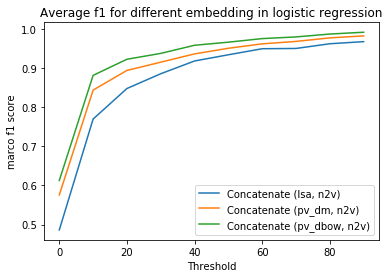

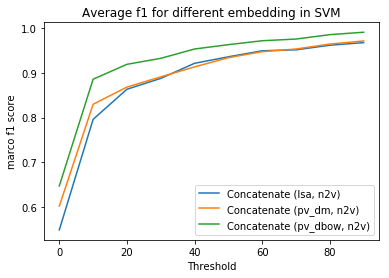

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
threshold_change = np.array(threshold_change)
#--------------   logistic regression --------------------------#
# process result into np array
logistic_regression_result = np.array(lr_diff_embedding_result)
fig = plt.figure()
ax = plt.axes()
for emb_type, result in zip(pp_textual, logistic_regression_result):
    emb_type = "Concatenate ("+emb_type+", n2v)"
    plt.plot(threshold_change, result, label=emb_type)
plt.legend()
plt.title('Average f1 for different embedding in logistic regression')
plt.xlabel('Threshold')
plt.ylabel('marco f1 score')

# plt.savefig('diff_combined_embedding_sample=140k_clf=logistic regression.eps', format='eps', dpi=300)


# -------------------- svm -------------------------------------#
svm_result = np.array(svm_diff_embedding_result)
fig = plt.figure()
ax = plt.axes()
for emb_type, result in zip(pp_textual, svm_result):
    emb_type = "Concatenate ("+emb_type+", n2v)"
    plt.plot(threshold_change, result, label=emb_type)
plt.legend()
plt.title('Average f1 for different embedding in SVM')
plt.xlabel('Threshold')
plt.ylabel('marco f1 score')

# plt.savefig('diff_combined_embedding_sample=140k_clf=SVM.eps', format='eps', dpi=300)

In [32]:
print(pp_textual)
print("svc: ", modelSVCf1)
print("lr: ", modelLRf1)

['tf', 'tf_idf', 'lsa']
svc:  [0.9464991405128569, 0.9731343812578639, 0.9706356660582325]
lr:  [0.9699976962200287, 0.9314359637774903, 0.9415017101135941]


In [19]:
# accuracy
from statistics import mean 
cleaned_svcLinear_accuracy = [x for x in all_svcLinear_accuracy if isinstance(x, float)]
cleaned_lr_accuracy = [x for x in all_LR_accuracy if isinstance(x, float)]
print(len(cleaned_svcLinear_accuracy))
print(len(cleaned_lr_accuracy))
print(mean(cleaned_svcLinear_accuracy))
print(mean(cleaned_lr_accuracy))

578
578
0.9798807689357634
0.9496564529342066


In [20]:
# f1
from statistics import mean 
# remove string from result
cleaned_svcLinear_f1 = [x for x in all_svcLinear_f1 if isinstance(x, float)]
cleaned_lr_f1 = [x for x in all_LR_f1 if isinstance(x, float)]
print(len(cleaned_svcLinear_f1))
print(len(cleaned_lr_f1))
print(mean(cleaned_svcLinear_f1))
print(mean(cleaned_lr_f1))

578
578
0.9764067884953497
0.9288583090243283


In [ ]:
%reset

In [ ]:
%who